In [43]:
# Do all necessary preprocessing, calling prepro.py
import utils
from utils import *
importlib.reload(utils)
from utils import *

In [2]:
# Load data
X, X_test_original, y = load_data() 
y = y.ravel()
scores = np.array([])
xtrain = X  # For andreas cross validation
ytrain = y

In [ ]:
# # Isolation Forest in case we need it: 
# # Fit an isolation forest
# clf = IsolationForest(n_estimators=n_estimators)
# clf.fit(X_new)
# clf.decision_function(X_new)
# inlier_indices = np.where(clf.predict(X_new) == 1)[0]
# print("Size of inliers:", inlier_indices.shape)
# X_inliers = X_new[inlier_indices]
# y_inliers = y_[inlier_indices]
# X_test_inliers = X_test_new # Do not remove outliers from test dataset
# y_test_inliers = y_test
# print("Inliers shapes:", X_inliers.shape, y_inliers.shape)

# SMOTEClassifier(SMOTE(), xgb.XGBClassifier())

# Andreas Optimal Model:

In [ ]:
# Simple pipeline with grid search

steps = [("scaler", preprocessing.StandardScaler()), ("classifier", svm.SVC())]

pipeline = Pipeline(steps = steps)

parameters = {"classifier__kernel": ["rbf"],
              "classifier__gamma": ["auto"],
              "classifier__C": [0.1, 0.5, 1, 5, 10, 50, 100],
              "classifier__degree": [1, 2, 3, 4, 5, 6],
              "classifier__class_weight": ["balanced"]
             }

grid = GridSearchCV(pipeline, parameters, cv = 5, scoring = 'balanced_accuracy')

# grid.fit(xtrain.values, ytrain.values.ravel())

# 0.7015740740740741
# {'classifier__C': 0.5, 'classifier__class_weight': 'balanced', 'classifier__degree': 1, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}


# Original NN model

In [ ]:
# dropout in hidden layers with weight constraint
def create_model(neurons=60):
    # create model
    model = Sequential()
    model.add(Dense(neurons, input_dim=1000, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.5))
    model.add(Dense(neurons, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(int(neurons/2), activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.1))
    model.add(Dense(3, activation='sigmoid'))
    # Compile model
#     sgd = SGD(lr=0.02, momentum=0.9)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
 
# One hot encode data
# enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
# y_enc = enc.fit_transform(y)
y_enc = np.zeros((y.shape[0], 3))
y_enc[np.arange(y.shape[0]), y] = 1

estimators = []
estimators.append(('standardize', preprocessing.StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=1)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=3, shuffle=True)
cw = sklearn.utils.class_weight.compute_class_weight('balanced', np.unique(y), y)
class_weight = {0: cw[0], 1: cw[1], 2: cw[2]}

def score(estimator, X_, y_):
    pred = estimator.predict(X_)
    y_normal = np.argmax(y_, axis=1)
    BMAC = balanced_accuracy_score(y_normal, pred)
    return BMAC


# results = cross_val_score(pipeline, X, y_enc, cv=kfold, verbose=2, scoring=score, 
#                           fit_params={'mlp__class_weight': class_weight})
# print(results)

# Keras NN Grid Search: Number of Neurons (Complete): Optimal Neurons is 30

In [3]:
inputs = [15, 30, 60, 120, 240]
results = []

for neurons in inputs:
    print("Input:", neurons)
    # dropout in hidden layers with weight constraint
    def create_model():
        # create model
        model = Sequential()
        model.add(Dense(neurons, input_dim=1000, activation='relu', kernel_constraint=maxnorm(3)))
        model.add(Dropout(0.5))
        model.add(Dense(neurons, activation='relu', kernel_constraint=maxnorm(3)))
        model.add(Dropout(0.2))
        model.add(Dense(int(neurons/2), activation='relu', kernel_constraint=maxnorm(3)))
        model.add(Dropout(0.1))
        model.add(Dense(3, activation='sigmoid'))
        # Compile model
    #     sgd = SGD(lr=0.02, momentum=0.9)
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

    # One hot encode data
    y_enc = np.zeros((y.shape[0], 3))
    y_enc[np.arange(y.shape[0]), y] = 1

    # Build the estimator
    estimators = []
    estimators.append(('standardize', preprocessing.StandardScaler()))
    estimators.append(('mlp', KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=1)))
    pipeline = Pipeline(estimators)
    kfold = KFold(n_splits=5, shuffle=True)
    cw = sklearn.utils.class_weight.compute_class_weight('balanced', np.unique(y), y)
    class_weight = {0: cw[0], 1: cw[1], 2: cw[2]}

    def score(estimator, X_, y_):
        pred = estimator.predict(X_)
        y_normal = np.argmax(y_, axis=1)
        BMAC = balanced_accuracy_score(y_normal, pred)
        return BMAC

    result = cross_val_score(pipeline, X, y_enc, cv=kfold, verbose=2, scoring=score, 
                              fit_params={'mlp__class_weight': class_weight})
    results.append(result)

# summarize results
means = [np.mean(x) for x in results]
stds = [np.std(x) for x in results]
params = inputs 
print("Best: %f using %s" % (np.max(means), params[np.argmax(means)]))
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# Save into a variable
neuron_results = results

Input: 15
[CV]  ................................................................
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Instructions for updating:
Use tf.cast instead.
Epoch 1/20
3840/3840 [==============================] - 2s 468us/step - loss: 0.6547 - acc: 0.6698
Epoch 2/20
3840/3840 [==============================] - 1s 146us/step - loss: 0.5780 - acc: 0.7444
Epoch 3/20
3840/3840 [==============================] - 1s 150us/step - loss: 0.5385 - acc: 0.7558
Epoch 4/20
3840/3840 [==============================] - 1s 200us/step - loss: 0.5133 - acc: 0.7766
Epoch 5/20
3840/3840 [==============================] - 1s 161us/step - loss: 0.5050 - acc: 0.7828
Epoch 6/20
3840/3840 [==============================] - 1s 175us/step - loss: 0.4872 - acc: 0.7955
Epoch 7/20
3840/3840 [==============================] - 1s 211us/step - loss: 0.4649 - acc: 0.8040
Epoch 8/20
3840/3840 [==============================] - 1s 162us/step - loss: 0.4726 - acc: 0.8054
Epoch 9/20
3840/3840 [==============================] - 1s 158us/step - loss: 0.4546 - acc: 0.8056
Epoch 10/20
3840/3840 [==============================] - 1s 1

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.5s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 2s 544us/step - loss: 0.6419 - acc: 0.6635
Epoch 2/20
3840/3840 [==============================] - 1s 194us/step - loss: 0.5651 - acc: 0.7293
Epoch 3/20
3840/3840 [==============================] - 1s 154us/step - loss: 0.5366 - acc: 0.7484
Epoch 4/20
3840/3840 [==============================] - 1s 146us/step - loss: 0.5079 - acc: 0.7688
Epoch 5/20
3840/3840 [==============================] - 1s 146us/step - loss: 0.4988 - acc: 0.7869
Epoch 6/20
3840/3840 [==============================] - 1s 179us/step - loss: 0.4907 - acc: 0.7840
Epoch 7/20
3840/3840 [==============================] - 1s 175us/step - loss: 0.4718 - acc: 0.7828
Epoch 8/20
3840/3840 [==============================] - 1s 175us/step - loss: 0.4602 - acc: 0.7836
Epoch 9/20
3840/3840 [==============================] - 1s 180us/step - loss: 0.4462 - acc: 0.7815
Epoch 10/20
3840/3840 [==============================] - 1s 191us/step - loss: 0.4320 - acc: 0.7941
Epoch 11/

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 2s 538us/step - loss: 0.6382 - acc: 0.6411
Epoch 2/20
3840/3840 [==============================] - 1s 185us/step - loss: 0.5326 - acc: 0.7458
Epoch 3/20
3840/3840 [==============================] - 1s 207us/step - loss: 0.4941 - acc: 0.7651
Epoch 4/20
3840/3840 [==============================] - 1s 264us/step - loss: 0.4658 - acc: 0.7740
Epoch 5/20
3840/3840 [==============================] - 1s 269us/step - loss: 0.4285 - acc: 0.7890
Epoch 6/20
3840/3840 [==============================] - 1s 214us/step - loss: 0.4248 - acc: 0.7992
Epoch 7/20
3840/3840 [==============================] - 1s 191us/step - loss: 0.4103 - acc: 0.8114
Epoch 8/20
3840/3840 [==============================] - 1s 242us/step - loss: 0.3797 - acc: 0.8227
Epoch 9/20
3840/3840 [==============================] - 1s 182us/step - loss: 0.3694 - acc: 0.8306
Epoch 10/20
3840/3840 [==============================] - 1s 227us/step - loss: 0.3636 - acc: 0.8339
Epoch 11/

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.7s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 3s 698us/step - loss: 0.6241 - acc: 0.6474
Epoch 2/20
3840/3840 [==============================] - 1s 251us/step - loss: 0.5308 - acc: 0.7424
Epoch 3/20
3840/3840 [==============================] - 1s 205us/step - loss: 0.4986 - acc: 0.7614
Epoch 4/20
3840/3840 [==============================] - 1s 288us/step - loss: 0.4766 - acc: 0.7720
Epoch 5/20
3840/3840 [==============================] - 1s 248us/step - loss: 0.4466 - acc: 0.7850
Epoch 6/20
3840/3840 [==============================] - 1s 241us/step - loss: 0.4392 - acc: 0.7959
Epoch 7/20
3840/3840 [==============================] - 1s 221us/step - loss: 0.4134 - acc: 0.8060
Epoch 8/20
3840/3840 [==============================] - 1s 217us/step - loss: 0.4112 - acc: 0.8114
Epoch 9/20
3840/3840 [==============================] - 1s 242us/step - loss: 0.3926 - acc: 0.8199
Epoch 10/20
3840/3840 [==============================] - 1s 221us/step - loss: 0.3806 - acc: 0.8221
Epoch 11/

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 3s 751us/step - loss: 0.5408 - acc: 0.7497
Epoch 2/20
3840/3840 [==============================] - 1s 351us/step - loss: 0.4831 - acc: 0.7824
Epoch 3/20
3840/3840 [==============================] - 1s 275us/step - loss: 0.4604 - acc: 0.7881
Epoch 4/20
3840/3840 [==============================] - 1s 294us/step - loss: 0.4329 - acc: 0.7940
Epoch 5/20
3840/3840 [==============================] - 1s 347us/step - loss: 0.4180 - acc: 0.8020
Epoch 6/20
3840/3840 [==============================] - 2s 410us/step - loss: 0.3879 - acc: 0.8194
Epoch 7/20
3840/3840 [==============================] - 1s 292us/step - loss: 0.3672 - acc: 0.8367
Epoch 8/20
3840/3840 [==============================] - 1s 265us/step - loss: 0.3516 - acc: 0.8426
Epoch 9/20
3840/3840 [==============================] - 1s 301us/step - loss: 0.3290 - acc: 0.8503
Epoch 10/20
3840/3840 [==============================] - 1s 250us/step - loss: 0.3205 - acc: 0.8571
Epoch 11/

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.6s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 4s 928us/step - loss: 0.5507 - acc: 0.7594
Epoch 2/20
3840/3840 [==============================] - 1s 302us/step - loss: 0.4901 - acc: 0.7658
Epoch 3/20
3840/3840 [==============================] - 1s 242us/step - loss: 0.4519 - acc: 0.7820
Epoch 4/20
3840/3840 [==============================] - 1s 294us/step - loss: 0.4365 - acc: 0.7841
Epoch 5/20
3840/3840 [==============================] - 1s 246us/step - loss: 0.4031 - acc: 0.8043
Epoch 6/20
3840/3840 [==============================] - 1s 267us/step - loss: 0.3859 - acc: 0.8128
Epoch 7/20
3840/3840 [==============================] - 1s 236us/step - loss: 0.3631 - acc: 0.8274
Epoch 8/20
3840/3840 [==============================] - 1s 262us/step - loss: 0.3498 - acc: 0.8251
Epoch 9/20
3840/3840 [==============================] - 1s 236us/step - loss: 0.3203 - acc: 0.8435
Epoch 10/20
3840/3840 [==============================] - 1s 264us/step - loss: 0.3103 - acc: 0.8454
Epoch 11/

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 4s 925us/step - loss: 0.5403 - acc: 0.7542
Epoch 2/20
3840/3840 [==============================] - 1s 329us/step - loss: 0.4722 - acc: 0.7799
Epoch 3/20
3840/3840 [==============================] - 1s 354us/step - loss: 0.4336 - acc: 0.7967
Epoch 4/20
3840/3840 [==============================] - 1s 337us/step - loss: 0.4117 - acc: 0.8063
Epoch 5/20
3840/3840 [==============================] - 1s 355us/step - loss: 0.3813 - acc: 0.8212
Epoch 6/20
3840/3840 [==============================] - 1s 350us/step - loss: 0.3529 - acc: 0.8409
Epoch 7/20
3840/3840 [==============================] - 1s 322us/step - loss: 0.3486 - acc: 0.8414
Epoch 8/20
3840/3840 [==============================] - 1s 353us/step - loss: 0.3167 - acc: 0.8506
Epoch 9/20
3840/3840 [==============================] - 1s 354us/step - loss: 0.3101 - acc: 0.8636
Epoch 10/20
3840/3840 [==============================] - 1s 322us/step - loss: 0.2822 - acc: 0.8722
Epoch 11/

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.0s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 4s 934us/step - loss: 0.5167 - acc: 0.7603
Epoch 2/20
3840/3840 [==============================] - 1s 324us/step - loss: 0.4426 - acc: 0.7924
Epoch 3/20
3840/3840 [==============================] - 1s 353us/step - loss: 0.4209 - acc: 0.7942
Epoch 4/20
3840/3840 [==============================] - 1s 357us/step - loss: 0.3897 - acc: 0.8205
Epoch 5/20
3840/3840 [==============================] - 1s 329us/step - loss: 0.3642 - acc: 0.8347
Epoch 6/20
3840/3840 [==============================] - 1s 356us/step - loss: 0.3467 - acc: 0.8381
Epoch 7/20
3840/3840 [==============================] - 1s 351us/step - loss: 0.3246 - acc: 0.8490
Epoch 8/20
3840/3840 [==============================] - 1s 325us/step - loss: 0.3076 - acc: 0.8575
Epoch 9/20
3840/3840 [==============================] - 1s 353us/step - loss: 0.2804 - acc: 0.8686
Epoch 10/20
3840/3840 [==============================] - 1s 353us/step - loss: 0.2790 - acc: 0.8707
Epoch 11/

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 5s 1ms/step - loss: 0.5164 - acc: 0.7642
Epoch 2/20
3840/3840 [==============================] - 2s 533us/step - loss: 0.4446 - acc: 0.7945
Epoch 3/20
3840/3840 [==============================] - 2s 531us/step - loss: 0.4076 - acc: 0.8081
Epoch 4/20
3840/3840 [==============================] - 2s 527us/step - loss: 0.3758 - acc: 0.8264
Epoch 5/20
3840/3840 [==============================] - 2s 528us/step - loss: 0.3496 - acc: 0.8429
Epoch 6/20
3840/3840 [==============================] - 2s 535us/step - loss: 0.3396 - acc: 0.8424
Epoch 7/20
3840/3840 [==============================] - 2s 532us/step - loss: 0.3106 - acc: 0.8563
Epoch 8/20
3840/3840 [==============================] - 2s 526us/step - loss: 0.2807 - acc: 0.8678
Epoch 9/20
3840/3840 [==============================] - 2s 560us/step - loss: 0.2602 - acc: 0.8837
Epoch 10/20
3840/3840 [==============================] - 2s 550us/step - loss: 0.2398 - acc: 0.8923
Epoch 11/20

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   45.0s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 5s 1ms/step - loss: 0.5159 - acc: 0.7555
Epoch 2/20
3840/3840 [==============================] - 2s 530us/step - loss: 0.4463 - acc: 0.7819
Epoch 3/20
3840/3840 [==============================] - 2s 531us/step - loss: 0.4177 - acc: 0.8048
Epoch 4/20
3840/3840 [==============================] - 2s 524us/step - loss: 0.3878 - acc: 0.8177
Epoch 5/20
3840/3840 [==============================] - 2s 538us/step - loss: 0.3504 - acc: 0.8324
Epoch 6/20
3840/3840 [==============================] - 2s 540us/step - loss: 0.3237 - acc: 0.8476
Epoch 7/20
3840/3840 [==============================] - 2s 535us/step - loss: 0.3080 - acc: 0.8580
Epoch 8/20
3840/3840 [==============================] - 2s 532us/step - loss: 0.2863 - acc: 0.8683
Epoch 9/20
3840/3840 [==============================] - 2s 546us/step - loss: 0.2692 - acc: 0.8774
Epoch 10/20
3840/3840 [==============================] - 2s 530us/step - loss: 0.2444 - acc: 0.8847
Epoch 11/20

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.8min finished


Best: 0.687105 using 30
0.678520 (0.015752) with: 15
0.687105 (0.012733) with: 30
0.683858 (0.024240) with: 60
0.670367 (0.036707) with: 120
0.669118 (0.013481) with: 240


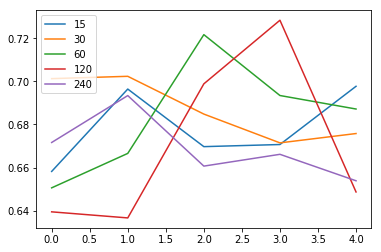

In [36]:
# Analyze results

means = [np.mean(x) for x in neuron_results]
stds = [np.std(x) for x in neuron_results]
params = inputs
print("Best: %f using %s" % (np.max(means), params[np.argmax(means)]))
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# Nov 14 neuron results
# Best: 0.687105 using 30
# 0.678520 (0.015752) with: 15
# 0.687105 (0.012733) with: 30
# 0.683858 (0.024240) with: 60
# 0.670367 (0.036707) with: 120
# 0.669118 (0.013481) with: 240

# Don't need to rerun, this is good ^
for i in range(len(neuron_results)):
    plt.plot(range(0, 5, 1), neuron_results[i], label = params[i])
    plt.legend()

# Keras NN Search: Dropout and Max Norm (Complete) Best: (0.7, 4)

In [42]:
weight_c = [1, 2, 3, 4, 5]
dropout = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
results = []

for dropout_rate, weight_constraint in itertools.product(dropout, weight_c):
    print("Input:", (dropout_rate, weight_constraint))
    # dropout in hidden layers with weight constraint
    def create_model():
        # create model
        neurons = 30
        model = Sequential()
        model.add(Dense(neurons, input_dim=1000, activation='relu', kernel_constraint=maxnorm(weight_constraint)))
        model.add(Dropout(dropout_rate))
        model.add(Dense(neurons, activation='relu', kernel_constraint=maxnorm(weight_constraint)))
        model.add(Dropout(dropout_rate*0.4))
        model.add(Dense(int(neurons/2), activation='relu', kernel_constraint=maxnorm(weight_constraint)))
        model.add(Dropout(dropout_rate*0.2))
        model.add(Dense(3, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

    # One hot encode data
    y_enc = np.zeros((y.shape[0], 3))
    y_enc[np.arange(y.shape[0]), y] = 1

    # Build the estimator
    estimators = []
    estimators.append(('standardize', preprocessing.StandardScaler()))
    estimators.append(('mlp', KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=1)))
    pipeline = Pipeline(estimators)
    kfold = KFold(n_splits=5, shuffle=True)
    cw = sklearn.utils.class_weight.compute_class_weight('balanced', np.unique(y), y)
    class_weight = {0: cw[0], 1: cw[1], 2: cw[2]}

    def score(estimator, X_, y_):
        pred = estimator.predict(X_)
        y_normal = np.argmax(y_, axis=1)
        BMAC = balanced_accuracy_score(y_normal, pred)
        return BMAC

    result = cross_val_score(pipeline, X, y_enc, cv=kfold, verbose=3, scoring=score, 
                              fit_params={'mlp__class_weight': class_weight})
    results.append(result)

# summarize results
means = [np.mean(x) for x in results]
stds = [np.std(x) for x in results]
params = list(itertools.product(dropout, weight_c))
print("Best: %f using %s" % (np.max(means), params[np.argmax(means)]))
for m, st, p in zip(means, stds, params):
    print("%f (%f) with: %r" % (m, st, p))
    
# Save into a variable
dropout_results = results

Input: (0.0, 1)
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 8s 2ms/step - loss: 0.5033 - acc: 0.7655
Epoch 2/20
3840/3840 [==============================] - 1s 297us/step - loss: 0.4104 - acc: 0.8090
Epoch 3/20
3840/3840 [==============================] - 1s 256us/step - loss: 0.3543 - acc: 0.8386
Epoch 4/20
3840/3840 [==============================] - 1s 248us/step - loss: 0.3087 - acc: 0.8640
Epoch 5/20
3840/3840 [==============================] - 1s 225us/step - loss: 0.2865 - acc: 0.8762
Epoch 6/20
3840/3840 [==============================] - 1s 258us/step - loss: 0.2412 - acc: 0.8959
Epoch 7/20
3840/3840 [==============================] - 1s 220us/step - loss: 0.2194 - acc: 0.9147
Epoch 8/20
3840/3840 [==============================] - 1s 263us/step - loss: 0.1950 - acc: 0.9214
Epoch 9/20
3840/3840 [==============================] - 1s 250us/step - loss: 0.1971 - acc: 0.9240
Epoch 10/20
3840/3840 [==============================] - 1s 268us/step - loss: 0.1730 - acc: 0.9288
Epoch 11/20

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.5s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 8s 2ms/step - loss: 0.4961 - acc: 0.7398
Epoch 2/20
3840/3840 [==============================] - 1s 270us/step - loss: 0.3981 - acc: 0.8074
Epoch 3/20
3840/3840 [==============================] - 1s 228us/step - loss: 0.3554 - acc: 0.8313
Epoch 4/20
3840/3840 [==============================] - 1s 264us/step - loss: 0.3054 - acc: 0.8528
Epoch 5/20
3840/3840 [==============================] - 1s 242us/step - loss: 0.2835 - acc: 0.8649
Epoch 6/20
3840/3840 [==============================] - 1s 274us/step - loss: 0.2531 - acc: 0.8813
Epoch 7/20
3840/3840 [==============================] - 1s 235us/step - loss: 0.2205 - acc: 0.9011
Epoch 8/20
3840/3840 [==============================] - 1s 261us/step - loss: 0.1918 - acc: 0.9118
Epoch 9/20
3840/3840 [==============================] - 1s 231us/step - loss: 0.1710 - acc: 0.9205
Epoch 10/20
3840/3840 [==============================] - 1s 271us/step - loss: 0.1419 - acc: 0.9363
Epoch 11/20

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 7s 2ms/step - loss: 0.4906 - acc: 0.7918
Epoch 2/20
3840/3840 [==============================] - 1s 244us/step - loss: 0.3962 - acc: 0.8252
Epoch 3/20
3840/3840 [==============================] - 1s 222us/step - loss: 0.3509 - acc: 0.8404
Epoch 4/20
3840/3840 [==============================] - 1s 261us/step - loss: 0.3234 - acc: 0.8603
Epoch 5/20
3840/3840 [==============================] - 1s 227us/step - loss: 0.2900 - acc: 0.8748
Epoch 6/20
3840/3840 [==============================] - 1s 246us/step - loss: 0.2547 - acc: 0.8885
Epoch 7/20
3840/3840 [==============================] - 1s 220us/step - loss: 0.2432 - acc: 0.8977
Epoch 8/20
3840/3840 [==============================] - 1s 217us/step - loss: 0.2169 - acc: 0.9087
Epoch 9/20
3840/3840 [==============================] - 1s 241us/step - loss: 0.2168 - acc: 0.9096
Epoch 10/20
3840/3840 [==============================] - 1s 218us/step - loss: 0.2081 - acc: 0.9112
Epoch 11/20

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 7s 2ms/step - loss: 0.4895 - acc: 0.7571
Epoch 2/20
3840/3840 [==============================] - 1s 219us/step - loss: 0.3964 - acc: 0.8095
Epoch 3/20
3840/3840 [==============================] - 1s 225us/step - loss: 0.3450 - acc: 0.8355
Epoch 4/20
3840/3840 [==============================] - 1s 256us/step - loss: 0.2937 - acc: 0.8644
Epoch 5/20
3840/3840 [==============================] - 1s 222us/step - loss: 0.2551 - acc: 0.8849
Epoch 6/20
3840/3840 [==============================] - 1s 244us/step - loss: 0.2129 - acc: 0.9043
Epoch 7/20
3840/3840 [==============================] - 1s 222us/step - loss: 0.1882 - acc: 0.9205
Epoch 8/20
3840/3840 [==============================] - 1s 240us/step - loss: 0.1373 - acc: 0.9401
Epoch 9/20
3840/3840 [==============================] - 1s 219us/step - loss: 0.1235 - acc: 0.9486
Epoch 10/20
3840/3840 [==============================] - 1s 218us/step - loss: 0.1046 - acc: 0.9527
Epoch 11/20

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.3s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 8s 2ms/step - loss: 0.5032 - acc: 0.7628
Epoch 2/20
3840/3840 [==============================] - 1s 219us/step - loss: 0.4169 - acc: 0.7901
Epoch 3/20
3840/3840 [==============================] - 1s 242us/step - loss: 0.3640 - acc: 0.8229
Epoch 4/20
3840/3840 [==============================] - 1s 220us/step - loss: 0.3195 - acc: 0.8417
Epoch 5/20
3840/3840 [==============================] - 1s 219us/step - loss: 0.2843 - acc: 0.8655
Epoch 6/20
3840/3840 [==============================] - 1s 245us/step - loss: 0.2491 - acc: 0.8841
Epoch 7/20
3840/3840 [==============================] - 1s 218us/step - loss: 0.2006 - acc: 0.9038
Epoch 8/20
3840/3840 [==============================] - 1s 246us/step - loss: 0.1648 - acc: 0.9210
Epoch 9/20
3840/3840 [==============================] - 1s 219us/step - loss: 0.1470 - acc: 0.9293
Epoch 10/20
3840/3840 [==============================] - 1s 243us/step - loss: 0.1161 - acc: 0.9440
Epoch 11/20

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   54.9s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 8s 2ms/step - loss: 0.4822 - acc: 0.7481
Epoch 2/20
3840/3840 [==============================] - 1s 219us/step - loss: 0.3813 - acc: 0.8112
Epoch 3/20
3840/3840 [==============================] - 1s 243us/step - loss: 0.3371 - acc: 0.8395
Epoch 4/20
3840/3840 [==============================] - 1s 220us/step - loss: 0.2838 - acc: 0.8684
Epoch 5/20
3840/3840 [==============================] - 1s 257us/step - loss: 0.2445 - acc: 0.8865
Epoch 6/20
3840/3840 [==============================] - 1s 219us/step - loss: 0.2184 - acc: 0.9043
Epoch 7/20
3840/3840 [==============================] - 1s 225us/step - loss: 0.1623 - acc: 0.9260
Epoch 8/20
3840/3840 [==============================] - 1s 242us/step - loss: 0.1664 - acc: 0.9296
Epoch 9/20
3840/3840 [==============================] - 1s 221us/step - loss: 0.1172 - acc: 0.9478
Epoch 10/20
3840/3840 [==============================] - 1s 244us/step - loss: 0.0949 - acc: 0.9569
Epoch 11/20

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 8s 2ms/step - loss: 0.4901 - acc: 0.7424
Epoch 2/20
3840/3840 [==============================] - 1s 223us/step - loss: 0.4020 - acc: 0.8025
Epoch 3/20
3840/3840 [==============================] - 1s 248us/step - loss: 0.3457 - acc: 0.8322
Epoch 4/20
3840/3840 [==============================] - 1s 223us/step - loss: 0.3030 - acc: 0.8522
Epoch 5/20
3840/3840 [==============================] - 1s 248us/step - loss: 0.2656 - acc: 0.8758
Epoch 6/20
3840/3840 [==============================] - 1s 223us/step - loss: 0.2139 - acc: 0.9036
Epoch 7/20
3840/3840 [==============================] - 1s 234us/step - loss: 0.1752 - acc: 0.9195
Epoch 8/20
3840/3840 [==============================] - 1s 243us/step - loss: 0.1417 - acc: 0.9352
Epoch 9/20
3840/3840 [==============================] - 1s 223us/step - loss: 0.1132 - acc: 0.9493
Epoch 10/20
3840/3840 [==============================] - 1s 250us/step - loss: 0.1061 - acc: 0.9550
Epoch 11/20

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.1s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 8s 2ms/step - loss: 0.4947 - acc: 0.7432
Epoch 2/20
3840/3840 [==============================] - 1s 283us/step - loss: 0.4003 - acc: 0.8200
Epoch 3/20
3840/3840 [==============================] - 1s 314us/step - loss: 0.3415 - acc: 0.8491
Epoch 4/20
3840/3840 [==============================] - 1s 270us/step - loss: 0.3018 - acc: 0.8750
Epoch 5/20
3840/3840 [==============================] - 1s 261us/step - loss: 0.2483 - acc: 0.8931
Epoch 6/20
3840/3840 [==============================] - 1s 279us/step - loss: 0.2195 - acc: 0.9062
Epoch 7/20
3840/3840 [==============================] - 1s 233us/step - loss: 0.1745 - acc: 0.9289
Epoch 8/20
3840/3840 [==============================] - 1s 258us/step - loss: 0.1490 - acc: 0.9366
Epoch 9/20
3840/3840 [==============================] - 1s 277us/step - loss: 0.1245 - acc: 0.9500
Epoch 10/20
3840/3840 [==============================] - 1s 288us/step - loss: 0.1077 - acc: 0.9538
Epoch 11/20

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 8s 2ms/step - loss: 0.4981 - acc: 0.7325
Epoch 2/20
3840/3840 [==============================] - 1s 294us/step - loss: 0.4041 - acc: 0.7787
Epoch 3/20
3840/3840 [==============================] - 1s 250us/step - loss: 0.3560 - acc: 0.7999
Epoch 4/20
3840/3840 [==============================] - 1s 263us/step - loss: 0.3102 - acc: 0.8375
Epoch 5/20
3840/3840 [==============================] - 1s 237us/step - loss: 0.2670 - acc: 0.8750
Epoch 6/20
3840/3840 [==============================] - 1s 311us/step - loss: 0.2356 - acc: 0.8923
Epoch 7/20
3840/3840 [==============================] - 1s 309us/step - loss: 0.2080 - acc: 0.9081
Epoch 8/20
3840/3840 [==============================] - 1s 338us/step - loss: 0.1566 - acc: 0.9319
Epoch 9/20
3840/3840 [==============================] - 1s 305us/step - loss: 0.1244 - acc: 0.9477
Epoch 10/20
3840/3840 [==============================] - 1s 313us/step - loss: 0.0966 - acc: 0.9587
Epoch 11/20

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 8s 2ms/step - loss: 0.4982 - acc: 0.7556
Epoch 2/20
3840/3840 [==============================] - 1s 257us/step - loss: 0.4037 - acc: 0.8133
Epoch 3/20
3840/3840 [==============================] - 1s 233us/step - loss: 0.3510 - acc: 0.8425
Epoch 4/20
3840/3840 [==============================] - 1s 258us/step - loss: 0.2974 - acc: 0.8678
Epoch 5/20
3840/3840 [==============================] - 1s 233us/step - loss: 0.2528 - acc: 0.8897
Epoch 6/20
3840/3840 [==============================] - 1s 254us/step - loss: 0.2436 - acc: 0.8966
Epoch 7/20
3840/3840 [==============================] - 1s 239us/step - loss: 0.1702 - acc: 0.9257
Epoch 8/20
3840/3840 [==============================] - 1s 234us/step - loss: 0.1620 - acc: 0.9264
Epoch 9/20
3840/3840 [==============================] - 1s 253us/step - loss: 0.1306 - acc: 0.9444
Epoch 10/20
3840/3840 [==============================] - 1s 233us/step - loss: 0.0944 - acc: 0.9569
Epoch 11/20

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.3s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 8s 2ms/step - loss: 0.5084 - acc: 0.7663
Epoch 2/20
3840/3840 [==============================] - 1s 254us/step - loss: 0.4120 - acc: 0.7949
Epoch 3/20
3840/3840 [==============================] - 1s 233us/step - loss: 0.3627 - acc: 0.8114
Epoch 4/20
3840/3840 [==============================] - 1s 254us/step - loss: 0.3151 - acc: 0.8407
Epoch 5/20
3840/3840 [==============================] - 1s 234us/step - loss: 0.2728 - acc: 0.8658
Epoch 6/20
3840/3840 [==============================] - 1s 262us/step - loss: 0.2344 - acc: 0.8865
Epoch 7/20
3840/3840 [==============================] - 1s 258us/step - loss: 0.2050 - acc: 0.9021
Epoch 8/20
3840/3840 [==============================] - 1s 284us/step - loss: 0.1732 - acc: 0.9155
Epoch 9/20
3840/3840 [==============================] - 1s 245us/step - loss: 0.1498 - acc: 0.9257
Epoch 10/20
3840/3840 [==============================] - 1s 281us/step - loss: 0.1082 - acc: 0.9420
Epoch 11/20

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   59.7s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 8s 2ms/step - loss: 0.5064 - acc: 0.7823
Epoch 2/20
3840/3840 [==============================] - 1s 238us/step - loss: 0.4150 - acc: 0.8268
Epoch 3/20
3840/3840 [==============================] - 1s 264us/step - loss: 0.3613 - acc: 0.8359
Epoch 4/20
3840/3840 [==============================] - 1s 241us/step - loss: 0.3182 - acc: 0.8640
Epoch 5/20
3840/3840 [==============================] - 1s 267us/step - loss: 0.2768 - acc: 0.8830
Epoch 6/20
3840/3840 [==============================] - 1s 241us/step - loss: 0.2439 - acc: 0.9003
Epoch 7/20
3840/3840 [==============================] - 1s 270us/step - loss: 0.2014 - acc: 0.9208
Epoch 8/20
3840/3840 [==============================] - 1s 252us/step - loss: 0.1807 - acc: 0.9288
Epoch 9/20
3840/3840 [==============================] - 1s 264us/step - loss: 0.1513 - acc: 0.9431
Epoch 10/20
3840/3840 [==============================] - 1s 239us/step - loss: 0.1159 - acc: 0.9553
Epoch 11/20

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 8s 2ms/step - loss: 0.5106 - acc: 0.7882
Epoch 2/20
3840/3840 [==============================] - 1s 268us/step - loss: 0.4394 - acc: 0.8345
Epoch 3/20
3840/3840 [==============================] - 1s 238us/step - loss: 0.3787 - acc: 0.8329
Epoch 4/20
3840/3840 [==============================] - 1s 263us/step - loss: 0.3200 - acc: 0.8461
Epoch 5/20
3840/3840 [==============================] - 1s 237us/step - loss: 0.2763 - acc: 0.8692
Epoch 6/20
3840/3840 [==============================] - 1s 261us/step - loss: 0.2237 - acc: 0.8970
Epoch 7/20
3840/3840 [==============================] - 1s 238us/step - loss: 0.1840 - acc: 0.9175
Epoch 8/20
3840/3840 [==============================] - 1s 236us/step - loss: 0.1479 - acc: 0.9339
Epoch 9/20
3840/3840 [==============================] - 1s 264us/step - loss: 0.1248 - acc: 0.9406
Epoch 10/20
3840/3840 [==============================] - 1s 238us/step - loss: 0.1066 - acc: 0.9506
Epoch 11/20

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.4s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 9s 2ms/step - loss: 0.5135 - acc: 0.7123
Epoch 2/20
3840/3840 [==============================] - 1s 239us/step - loss: 0.4042 - acc: 0.8004
Epoch 3/20
3840/3840 [==============================] - 1s 264us/step - loss: 0.3621 - acc: 0.8283
Epoch 4/20
3840/3840 [==============================] - 1s 238us/step - loss: 0.3135 - acc: 0.8538
Epoch 5/20
3840/3840 [==============================] - 1s 261us/step - loss: 0.2732 - acc: 0.8740
Epoch 6/20
3840/3840 [==============================] - 1s 239us/step - loss: 0.2335 - acc: 0.8907
Epoch 7/20
3840/3840 [==============================] - 1s 276us/step - loss: 0.1936 - acc: 0.9156
Epoch 8/20
3840/3840 [==============================] - 1s 240us/step - loss: 0.1545 - acc: 0.9304
Epoch 9/20
3840/3840 [==============================] - 1s 251us/step - loss: 0.1396 - acc: 0.9371
Epoch 10/20
3840/3840 [==============================] - 1s 255us/step - loss: 0.1104 - acc: 0.9491
Epoch 11/20

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 9s 2ms/step - loss: 0.4840 - acc: 0.7566
Epoch 2/20
3840/3840 [==============================] - 1s 259us/step - loss: 0.3979 - acc: 0.8096
Epoch 3/20
3840/3840 [==============================] - 1s 240us/step - loss: 0.3500 - acc: 0.8339
Epoch 4/20
3840/3840 [==============================] - 1s 266us/step - loss: 0.2992 - acc: 0.8615
Epoch 5/20
3840/3840 [==============================] - 1s 238us/step - loss: 0.2584 - acc: 0.8829
Epoch 6/20
3840/3840 [==============================] - 1s 271us/step - loss: 0.2283 - acc: 0.8956
Epoch 7/20
3840/3840 [==============================] - 1s 240us/step - loss: 0.1868 - acc: 0.9179
Epoch 8/20
3840/3840 [==============================] - 1s 266us/step - loss: 0.1704 - acc: 0.9240
Epoch 9/20
3840/3840 [==============================] - 1s 240us/step - loss: 0.1221 - acc: 0.9424
Epoch 10/20
3840/3840 [==============================] - 1s 264us/step - loss: 0.1106 - acc: 0.9510
Epoch 11/20

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 9s 2ms/step - loss: 0.4926 - acc: 0.7728
Epoch 2/20
3840/3840 [==============================] - 1s 305us/step - loss: 0.4149 - acc: 0.8085
Epoch 3/20
3840/3840 [==============================] - 1s 275us/step - loss: 0.3834 - acc: 0.8166
Epoch 4/20
3840/3840 [==============================] - 1s 292us/step - loss: 0.3446 - acc: 0.8471
Epoch 5/20
3840/3840 [==============================] - 1s 275us/step - loss: 0.3167 - acc: 0.8573
Epoch 6/20
3840/3840 [==============================] - 1s 305us/step - loss: 0.2926 - acc: 0.8656
Epoch 7/20
3840/3840 [==============================] - 1s 273us/step - loss: 0.2756 - acc: 0.8784
Epoch 8/20
3840/3840 [==============================] - 1s 299us/step - loss: 0.2530 - acc: 0.8899
Epoch 9/20
3840/3840 [==============================] - 1s 277us/step - loss: 0.2269 - acc: 0.8982
Epoch 10/20
3840/3840 [==============================] - 1s 291us/step - loss: 0.2243 - acc: 0.8996
Epoch 11/20

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.8s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 10s 3ms/step - loss: 0.4992 - acc: 0.7640
Epoch 2/20
3840/3840 [==============================] - 1s 278us/step - loss: 0.4333 - acc: 0.7791
Epoch 3/20
3840/3840 [==============================] - 1s 299us/step - loss: 0.3782 - acc: 0.8130
Epoch 4/20
3840/3840 [==============================] - 1s 272us/step - loss: 0.3498 - acc: 0.8297
Epoch 5/20
3840/3840 [==============================] - 1s 306us/step - loss: 0.3122 - acc: 0.8458
Epoch 6/20
3840/3840 [==============================] - 1s 291us/step - loss: 0.2890 - acc: 0.8603
Epoch 7/20
3840/3840 [==============================] - 1s 306us/step - loss: 0.2642 - acc: 0.8747
Epoch 8/20
3840/3840 [==============================] - 1s 281us/step - loss: 0.2379 - acc: 0.8931
Epoch 9/20
3840/3840 [==============================] - 1s 296us/step - loss: 0.2281 - acc: 0.9012
Epoch 10/20
3840/3840 [==============================] - 1s 274us/step - loss: 0.2055 - acc: 0.9062
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 10s 2ms/step - loss: 0.5124 - acc: 0.7477
Epoch 2/20
3840/3840 [==============================] - 1s 288us/step - loss: 0.4326 - acc: 0.7860
Epoch 3/20
3840/3840 [==============================] - 1s 275us/step - loss: 0.3981 - acc: 0.8095
Epoch 4/20
3840/3840 [==============================] - 1s 307us/step - loss: 0.3655 - acc: 0.8284
Epoch 5/20
3840/3840 [==============================] - 1s 273us/step - loss: 0.3386 - acc: 0.8465
Epoch 6/20
3840/3840 [==============================] - 1s 298us/step - loss: 0.3118 - acc: 0.8580
Epoch 7/20
3840/3840 [==============================] - 1s 274us/step - loss: 0.2992 - acc: 0.8636
Epoch 8/20
3840/3840 [==============================] - 1s 293us/step - loss: 0.2701 - acc: 0.8765
Epoch 9/20
3840/3840 [==============================] - 1s 273us/step - loss: 0.2525 - acc: 0.8908
Epoch 10/20
3840/3840 [==============================] - 1s 290us/step - loss: 0.2392 - acc: 0.8911
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 10s 3ms/step - loss: 0.5178 - acc: 0.7043
Epoch 2/20
3840/3840 [==============================] - 1s 276us/step - loss: 0.4228 - acc: 0.7919
Epoch 3/20
3840/3840 [==============================] - 1s 293us/step - loss: 0.3750 - acc: 0.8248
Epoch 4/20
3840/3840 [==============================] - 1s 276us/step - loss: 0.3333 - acc: 0.8464
Epoch 5/20
3840/3840 [==============================] - 1s 301us/step - loss: 0.2995 - acc: 0.8659
Epoch 6/20
3840/3840 [==============================] - 1s 278us/step - loss: 0.2590 - acc: 0.8877
Epoch 7/20
3840/3840 [==============================] - 1s 298us/step - loss: 0.2322 - acc: 0.8970
Epoch 8/20
3840/3840 [==============================] - 1s 278us/step - loss: 0.2001 - acc: 0.9077
Epoch 9/20
3840/3840 [==============================] - 1s 296us/step - loss: 0.2104 - acc: 0.9104
Epoch 10/20
3840/3840 [==============================] - 1s 277us/step - loss: 0.1624 - acc: 0.9307
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.9s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 10s 3ms/step - loss: 0.5244 - acc: 0.7133
Epoch 2/20
3840/3840 [==============================] - 1s 303us/step - loss: 0.4299 - acc: 0.7941
Epoch 3/20
3840/3840 [==============================] - 1s 277us/step - loss: 0.3836 - acc: 0.8164
Epoch 4/20
3840/3840 [==============================] - 1s 299us/step - loss: 0.3531 - acc: 0.8441
Epoch 5/20
3840/3840 [==============================] - 1s 302us/step - loss: 0.3082 - acc: 0.8602
Epoch 6/20
3840/3840 [==============================] - 1s 277us/step - loss: 0.2753 - acc: 0.8741
Epoch 7/20
3840/3840 [==============================] - 1s 300us/step - loss: 0.2420 - acc: 0.8918
Epoch 8/20
3840/3840 [==============================] - 1s 279us/step - loss: 0.2139 - acc: 0.9043
Epoch 9/20
3840/3840 [==============================] - 1s 300us/step - loss: 0.1902 - acc: 0.9134
Epoch 10/20
3840/3840 [==============================] - 1s 278us/step - loss: 0.1663 - acc: 0.9227
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 10s 3ms/step - loss: 0.5388 - acc: 0.6984
Epoch 2/20
3840/3840 [==============================] - 1s 305us/step - loss: 0.4338 - acc: 0.7661
Epoch 3/20
3840/3840 [==============================] - 1s 279us/step - loss: 0.4035 - acc: 0.7879
Epoch 4/20
3840/3840 [==============================] - 1s 299us/step - loss: 0.3633 - acc: 0.8084
Epoch 5/20
3840/3840 [==============================] - 1s 286us/step - loss: 0.3307 - acc: 0.8303
Epoch 6/20
3840/3840 [==============================] - 1s 333us/step - loss: 0.2944 - acc: 0.8487
Epoch 7/20
3840/3840 [==============================] - 1s 332us/step - loss: 0.2613 - acc: 0.8700
Epoch 8/20
3840/3840 [==============================] - 1s 300us/step - loss: 0.2475 - acc: 0.8809
Epoch 9/20
3840/3840 [==============================] - 1s 331us/step - loss: 0.2228 - acc: 0.8924
Epoch 10/20
3840/3840 [==============================] - 1s 293us/step - loss: 0.2049 - acc: 0.9016
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 10s 3ms/step - loss: 0.4985 - acc: 0.7492
Epoch 2/20
3840/3840 [==============================] - 1s 311us/step - loss: 0.4280 - acc: 0.7863
Epoch 3/20
3840/3840 [==============================] - 1s 283us/step - loss: 0.3848 - acc: 0.8159
Epoch 4/20
3840/3840 [==============================] - 1s 307us/step - loss: 0.3411 - acc: 0.8357
Epoch 5/20
3840/3840 [==============================] - 1s 305us/step - loss: 0.3175 - acc: 0.8485
Epoch 6/20
3840/3840 [==============================] - 1s 283us/step - loss: 0.2852 - acc: 0.8697
Epoch 7/20
3840/3840 [==============================] - 1s 308us/step - loss: 0.2564 - acc: 0.8791
Epoch 8/20
3840/3840 [==============================] - 1s 281us/step - loss: 0.2156 - acc: 0.8945
Epoch 9/20
3840/3840 [==============================] - 1s 325us/step - loss: 0.2147 - acc: 0.9003
Epoch 10/20
3840/3840 [==============================] - 1s 284us/step - loss: 0.1961 - acc: 0.9072
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.3s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 10s 3ms/step - loss: 0.5106 - acc: 0.7755
Epoch 2/20
3840/3840 [==============================] - 1s 282us/step - loss: 0.4337 - acc: 0.8108
Epoch 3/20
3840/3840 [==============================] - 1s 297us/step - loss: 0.3981 - acc: 0.8198
Epoch 4/20
3840/3840 [==============================] - 1s 282us/step - loss: 0.3657 - acc: 0.8381
Epoch 5/20
3840/3840 [==============================] - 1s 298us/step - loss: 0.3181 - acc: 0.8522
Epoch 6/20
3840/3840 [==============================] - 1s 286us/step - loss: 0.2918 - acc: 0.8707
Epoch 7/20
3840/3840 [==============================] - 1s 307us/step - loss: 0.2538 - acc: 0.8865
Epoch 8/20
3840/3840 [==============================] - 1s 307us/step - loss: 0.2229 - acc: 0.9046
Epoch 9/20
3840/3840 [==============================] - 1s 284us/step - loss: 0.2100 - acc: 0.9135
Epoch 10/20
3840/3840 [==============================] - 1s 311us/step - loss: 0.1855 - acc: 0.9174
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 10s 3ms/step - loss: 0.5048 - acc: 0.7523
Epoch 2/20
3840/3840 [==============================] - 1s 301us/step - loss: 0.4246 - acc: 0.8059
Epoch 3/20
3840/3840 [==============================] - 1s 286us/step - loss: 0.3892 - acc: 0.8283
Epoch 4/20
3840/3840 [==============================] - 1s 310us/step - loss: 0.3472 - acc: 0.8498
Epoch 5/20
3840/3840 [==============================] - 1s 288us/step - loss: 0.3190 - acc: 0.8659
Epoch 6/20
3840/3840 [==============================] - 1s 302us/step - loss: 0.2902 - acc: 0.8795
Epoch 7/20
3840/3840 [==============================] - 1s 285us/step - loss: 0.2544 - acc: 0.8917
Epoch 8/20
3840/3840 [==============================] - 1s 306us/step - loss: 0.2239 - acc: 0.9013
Epoch 9/20
3840/3840 [==============================] - 1s 301us/step - loss: 0.2177 - acc: 0.9042
Epoch 10/20
3840/3840 [==============================] - 1s 293us/step - loss: 0.1826 - acc: 0.9208
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 11s 3ms/step - loss: 0.5187 - acc: 0.7585
Epoch 2/20
3840/3840 [==============================] - 1s 314us/step - loss: 0.4353 - acc: 0.7873
Epoch 3/20
3840/3840 [==============================] - 1s 288us/step - loss: 0.3874 - acc: 0.8169
Epoch 4/20
3840/3840 [==============================] - 1s 304us/step - loss: 0.3548 - acc: 0.8351
Epoch 5/20
3840/3840 [==============================] - 1s 286us/step - loss: 0.3264 - acc: 0.8486
Epoch 6/20
3840/3840 [==============================] - 1s 312us/step - loss: 0.2935 - acc: 0.8624
Epoch 7/20
3840/3840 [==============================] - 1s 288us/step - loss: 0.2500 - acc: 0.8824
Epoch 8/20
3840/3840 [==============================] - 1s 314us/step - loss: 0.2265 - acc: 0.8938
Epoch 9/20
3840/3840 [==============================] - 1s 289us/step - loss: 0.2013 - acc: 0.9051
Epoch 10/20
3840/3840 [==============================] - 1s 303us/step - loss: 0.1833 - acc: 0.9117
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   37.2s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 11s 3ms/step - loss: 0.5112 - acc: 0.7484
Epoch 2/20
3840/3840 [==============================] - 1s 291us/step - loss: 0.4313 - acc: 0.7871
Epoch 3/20
3840/3840 [==============================] - 1s 310us/step - loss: 0.3884 - acc: 0.8189
Epoch 4/20
3840/3840 [==============================] - 1s 312us/step - loss: 0.3499 - acc: 0.8405
Epoch 5/20
3840/3840 [==============================] - 1s 290us/step - loss: 0.3170 - acc: 0.8559
Epoch 6/20
3840/3840 [==============================] - 1s 313us/step - loss: 0.2825 - acc: 0.8662
Epoch 7/20
3840/3840 [==============================] - 1s 290us/step - loss: 0.2510 - acc: 0.8885
Epoch 8/20
3840/3840 [==============================] - 1s 311us/step - loss: 0.2193 - acc: 0.9062
Epoch 9/20
3840/3840 [==============================] - 1s 290us/step - loss: 0.2091 - acc: 0.9095
Epoch 10/20
3840/3840 [==============================] - 1s 312us/step - loss: 0.1891 - acc: 0.9158
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 11s 3ms/step - loss: 0.5151 - acc: 0.7450
Epoch 2/20
3840/3840 [==============================] - 1s 291us/step - loss: 0.4371 - acc: 0.7826
Epoch 3/20
3840/3840 [==============================] - 1s 315us/step - loss: 0.3995 - acc: 0.8039
Epoch 4/20
3840/3840 [==============================] - 1s 294us/step - loss: 0.3580 - acc: 0.8263
Epoch 5/20
3840/3840 [==============================] - 1s 309us/step - loss: 0.3332 - acc: 0.8461
Epoch 6/20
3840/3840 [==============================] - 1s 307us/step - loss: 0.2903 - acc: 0.8628
Epoch 7/20
3840/3840 [==============================] - 1s 291us/step - loss: 0.2670 - acc: 0.8791
Epoch 8/20
3840/3840 [==============================] - 1s 327us/step - loss: 0.2304 - acc: 0.8952
Epoch 9/20
3840/3840 [==============================] - 1s 291us/step - loss: 0.2197 - acc: 0.9061
Epoch 10/20
3840/3840 [==============================] - 1s 314us/step - loss: 0.1874 - acc: 0.9184
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 11s 3ms/step - loss: 0.5350 - acc: 0.7038
Epoch 2/20
3840/3840 [==============================] - 1s 320us/step - loss: 0.4478 - acc: 0.7693
Epoch 3/20
3840/3840 [==============================] - 1s 295us/step - loss: 0.3915 - acc: 0.8036
Epoch 4/20
3840/3840 [==============================] - 1s 319us/step - loss: 0.3502 - acc: 0.8330
Epoch 5/20
3840/3840 [==============================] - 1s 326us/step - loss: 0.3060 - acc: 0.8549
Epoch 6/20
3840/3840 [==============================] - 1s 295us/step - loss: 0.2820 - acc: 0.8586
Epoch 7/20
3840/3840 [==============================] - 1s 317us/step - loss: 0.2485 - acc: 0.8881
Epoch 8/20
3840/3840 [==============================] - 1s 298us/step - loss: 0.2177 - acc: 0.8975
Epoch 9/20
3840/3840 [==============================] - 1s 316us/step - loss: 0.1853 - acc: 0.9096
Epoch 10/20
3840/3840 [==============================] - 1s 295us/step - loss: 0.1741 - acc: 0.9206
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   38.5s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 11s 3ms/step - loss: 0.5224 - acc: 0.7287
Epoch 2/20
3840/3840 [==============================] - 1s 295us/step - loss: 0.4236 - acc: 0.7903
Epoch 3/20
3840/3840 [==============================] - 1s 320us/step - loss: 0.3774 - acc: 0.8110
Epoch 4/20
3840/3840 [==============================] - 1s 296us/step - loss: 0.3496 - acc: 0.8274
Epoch 5/20
3840/3840 [==============================] - 1s 314us/step - loss: 0.3049 - acc: 0.8470
Epoch 6/20
3840/3840 [==============================] - 1s 319us/step - loss: 0.2698 - acc: 0.8684
Epoch 7/20
3840/3840 [==============================] - 1s 294us/step - loss: 0.2466 - acc: 0.8793
Epoch 8/20
3840/3840 [==============================] - 1s 319us/step - loss: 0.2121 - acc: 0.8910
Epoch 9/20
3840/3840 [==============================] - 1s 297us/step - loss: 0.1924 - acc: 0.9076
Epoch 10/20
3840/3840 [==============================] - 1s 318us/step - loss: 0.1641 - acc: 0.9166
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 11s 3ms/step - loss: 0.5198 - acc: 0.7587
Epoch 2/20
3840/3840 [==============================] - 1s 319us/step - loss: 0.4379 - acc: 0.7927
Epoch 3/20
3840/3840 [==============================] - 1s 296us/step - loss: 0.3999 - acc: 0.8102
Epoch 4/20
3840/3840 [==============================] - 1s 316us/step - loss: 0.3626 - acc: 0.8310
Epoch 5/20
3840/3840 [==============================] - 1s 319us/step - loss: 0.3229 - acc: 0.8481
Epoch 6/20
3840/3840 [==============================] - 1s 298us/step - loss: 0.2932 - acc: 0.8676
Epoch 7/20
3840/3840 [==============================] - 1s 317us/step - loss: 0.2740 - acc: 0.8714
Epoch 8/20
3840/3840 [==============================] - 1s 296us/step - loss: 0.2315 - acc: 0.8908
Epoch 9/20
3840/3840 [==============================] - 1s 323us/step - loss: 0.2196 - acc: 0.8995
Epoch 10/20
3840/3840 [==============================] - 1s 297us/step - loss: 0.1939 - acc: 0.9077
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 11s 3ms/step - loss: 0.5758 - acc: 0.7021
Epoch 2/20
3840/3840 [==============================] - 1s 318us/step - loss: 0.4611 - acc: 0.7705
Epoch 3/20
3840/3840 [==============================] - 1s 301us/step - loss: 0.4243 - acc: 0.8071
Epoch 4/20
3840/3840 [==============================] - 1s 319us/step - loss: 0.3962 - acc: 0.8092
Epoch 5/20
3840/3840 [==============================] - 1s 308us/step - loss: 0.3670 - acc: 0.8237
Epoch 6/20
3840/3840 [==============================] - 1s 307us/step - loss: 0.3554 - acc: 0.8424
Epoch 7/20
3840/3840 [==============================] - 1s 320us/step - loss: 0.3188 - acc: 0.8520
Epoch 8/20
3840/3840 [==============================] - 1s 301us/step - loss: 0.2982 - acc: 0.8580
Epoch 9/20
3840/3840 [==============================] - 1s 319us/step - loss: 0.2681 - acc: 0.8753
Epoch 10/20
3840/3840 [==============================] - 1s 302us/step - loss: 0.2679 - acc: 0.8791
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.3s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 12s 3ms/step - loss: 0.5162 - acc: 0.7326
Epoch 2/20
3840/3840 [==============================] - 1s 299us/step - loss: 0.4431 - acc: 0.7754
Epoch 3/20
3840/3840 [==============================] - 1s 277us/step - loss: 0.4027 - acc: 0.7951
Epoch 4/20
3840/3840 [==============================] - 1s 309us/step - loss: 0.3694 - acc: 0.8134
Epoch 5/20
3840/3840 [==============================] - 1s 279us/step - loss: 0.3450 - acc: 0.8243
Epoch 6/20
3840/3840 [==============================] - 1s 294us/step - loss: 0.3281 - acc: 0.8414
Epoch 7/20
3840/3840 [==============================] - 1s 279us/step - loss: 0.2974 - acc: 0.8536
Epoch 8/20
3840/3840 [==============================] - 1s 298us/step - loss: 0.2843 - acc: 0.8670
Epoch 9/20
3840/3840 [==============================] - 1s 279us/step - loss: 0.2819 - acc: 0.8739
Epoch 10/20
3840/3840 [==============================] - 1s 292us/step - loss: 0.2607 - acc: 0.8789
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 12s 3ms/step - loss: 0.5108 - acc: 0.7504
Epoch 2/20
3840/3840 [==============================] - 1s 291us/step - loss: 0.4379 - acc: 0.7796
Epoch 3/20
3840/3840 [==============================] - 1s 282us/step - loss: 0.4066 - acc: 0.7962
Epoch 4/20
3840/3840 [==============================] - 1s 305us/step - loss: 0.3785 - acc: 0.8110
Epoch 5/20
3840/3840 [==============================] - 1s 279us/step - loss: 0.3476 - acc: 0.8292
Epoch 6/20
3840/3840 [==============================] - 1s 293us/step - loss: 0.3271 - acc: 0.8463
Epoch 7/20
3840/3840 [==============================] - 1s 279us/step - loss: 0.2924 - acc: 0.8641
Epoch 8/20
3840/3840 [==============================] - 1s 300us/step - loss: 0.2903 - acc: 0.8628
Epoch 9/20
3840/3840 [==============================] - 1s 284us/step - loss: 0.2808 - acc: 0.8671
Epoch 10/20
3840/3840 [==============================] - 1s 296us/step - loss: 0.2551 - acc: 0.8735
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 13s 3ms/step - loss: 0.5578 - acc: 0.7232
Epoch 2/20
3840/3840 [==============================] - 1s 387us/step - loss: 0.4680 - acc: 0.7746
Epoch 3/20
3840/3840 [==============================] - 1s 341us/step - loss: 0.4369 - acc: 0.7812
Epoch 4/20
3840/3840 [==============================] - 1s 346us/step - loss: 0.3937 - acc: 0.8085
Epoch 5/20
3840/3840 [==============================] - 1s 367us/step - loss: 0.3733 - acc: 0.8115
Epoch 6/20
3840/3840 [==============================] - 2s 391us/step - loss: 0.3575 - acc: 0.8248
Epoch 7/20
3840/3840 [==============================] - 2s 391us/step - loss: 0.3198 - acc: 0.8466
Epoch 8/20
3840/3840 [==============================] - 1s 389us/step - loss: 0.2954 - acc: 0.8544
Epoch 9/20
3840/3840 [==============================] - 1s 336us/step - loss: 0.2684 - acc: 0.8727
Epoch 10/20
3840/3840 [==============================] - 1s 358us/step - loss: 0.2472 - acc: 0.8805
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   46.1s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 12s 3ms/step - loss: 0.5668 - acc: 0.6438
Epoch 2/20
3840/3840 [==============================] - 1s 357us/step - loss: 0.4508 - acc: 0.7532
Epoch 3/20
3840/3840 [==============================] - 1s 381us/step - loss: 0.4187 - acc: 0.7817
Epoch 4/20
3840/3840 [==============================] - 1s 359us/step - loss: 0.3814 - acc: 0.8022
Epoch 5/20
3840/3840 [==============================] - 1s 367us/step - loss: 0.3638 - acc: 0.8098
Epoch 6/20
3840/3840 [==============================] - 1s 362us/step - loss: 0.3256 - acc: 0.8332
Epoch 7/20
3840/3840 [==============================] - 1s 328us/step - loss: 0.3182 - acc: 0.8389
Epoch 8/20
3840/3840 [==============================] - 1s 327us/step - loss: 0.2866 - acc: 0.8574
Epoch 9/20
3840/3840 [==============================] - 1s 319us/step - loss: 0.2591 - acc: 0.8720
Epoch 10/20
3840/3840 [==============================] - 1s 301us/step - loss: 0.2524 - acc: 0.8734
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 15s 4ms/step - loss: 0.5255 - acc: 0.7569
Epoch 2/20
3840/3840 [==============================] - 1s 309us/step - loss: 0.4659 - acc: 0.7940
Epoch 3/20
3840/3840 [==============================] - 1s 342us/step - loss: 0.4249 - acc: 0.8040
Epoch 4/20
3840/3840 [==============================] - 1s 329us/step - loss: 0.3938 - acc: 0.8191
Epoch 5/20
3840/3840 [==============================] - 1s 310us/step - loss: 0.3627 - acc: 0.8304
Epoch 6/20
3840/3840 [==============================] - 1s 327us/step - loss: 0.3363 - acc: 0.8438
Epoch 7/20
3840/3840 [==============================] - 1s 308us/step - loss: 0.3091 - acc: 0.8586
Epoch 8/20
3840/3840 [==============================] - 1s 329us/step - loss: 0.2879 - acc: 0.8692
Epoch 9/20
3840/3840 [==============================] - 1s 327us/step - loss: 0.2554 - acc: 0.8807
Epoch 10/20
3840/3840 [==============================] - 1s 311us/step - loss: 0.2254 - acc: 0.8897
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 13s 3ms/step - loss: 0.5348 - acc: 0.7319
Epoch 2/20
3840/3840 [==============================] - 1s 314us/step - loss: 0.4501 - acc: 0.7863
Epoch 3/20
3840/3840 [==============================] - 1s 332us/step - loss: 0.4099 - acc: 0.8107
Epoch 4/20
3840/3840 [==============================] - 1s 331us/step - loss: 0.3629 - acc: 0.8311
Epoch 5/20
3840/3840 [==============================] - 1s 319us/step - loss: 0.3455 - acc: 0.8502
Epoch 6/20
3840/3840 [==============================] - 1s 331us/step - loss: 0.3199 - acc: 0.8609
Epoch 7/20
3840/3840 [==============================] - 1s 313us/step - loss: 0.2811 - acc: 0.8699
Epoch 8/20
3840/3840 [==============================] - 1s 332us/step - loss: 0.2677 - acc: 0.8778
Epoch 9/20
3840/3840 [==============================] - 1s 336us/step - loss: 0.2468 - acc: 0.8918
Epoch 10/20
3840/3840 [==============================] - 1s 314us/step - loss: 0.2246 - acc: 0.9033
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   42.3s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 13s 3ms/step - loss: 0.5482 - acc: 0.6906
Epoch 2/20
3840/3840 [==============================] - 1s 338us/step - loss: 0.4735 - acc: 0.7516
Epoch 3/20
3840/3840 [==============================] - 1s 315us/step - loss: 0.4295 - acc: 0.7763
Epoch 4/20
3840/3840 [==============================] - 1s 339us/step - loss: 0.3838 - acc: 0.8079
Epoch 5/20
3840/3840 [==============================] - 1s 318us/step - loss: 0.3547 - acc: 0.8212
Epoch 6/20
3840/3840 [==============================] - 1s 342us/step - loss: 0.3277 - acc: 0.8431
Epoch 7/20
3840/3840 [==============================] - 1s 336us/step - loss: 0.3180 - acc: 0.8482
Epoch 8/20
3840/3840 [==============================] - 1s 312us/step - loss: 0.2849 - acc: 0.8673
Epoch 9/20
3840/3840 [==============================] - 1s 334us/step - loss: 0.2607 - acc: 0.8722
Epoch 10/20
3840/3840 [==============================] - 1s 315us/step - loss: 0.2535 - acc: 0.8794
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 13s 3ms/step - loss: 0.5137 - acc: 0.7476
Epoch 2/20
3840/3840 [==============================] - 1s 345us/step - loss: 0.4368 - acc: 0.7806
Epoch 3/20
3840/3840 [==============================] - 2s 623us/step - loss: 0.3993 - acc: 0.8076
Epoch 4/20
3840/3840 [==============================] - 1s 334us/step - loss: 0.3611 - acc: 0.8303
Epoch 5/20
3840/3840 [==============================] - 1s 317us/step - loss: 0.3316 - acc: 0.8423
Epoch 6/20
3840/3840 [==============================] - 1s 343us/step - loss: 0.3036 - acc: 0.8557
Epoch 7/20
3840/3840 [==============================] - 1s 333us/step - loss: 0.2759 - acc: 0.8712
Epoch 8/20
3840/3840 [==============================] - 1s 321us/step - loss: 0.2570 - acc: 0.8852
Epoch 9/20
3840/3840 [==============================] - 1s 336us/step - loss: 0.2340 - acc: 0.8859
Epoch 10/20
3840/3840 [==============================] - 1s 332us/step - loss: 0.2098 - acc: 0.8986
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 13s 3ms/step - loss: 0.5519 - acc: 0.7835
Epoch 2/20
3840/3840 [==============================] - 2s 573us/step - loss: 0.4707 - acc: 0.7654
Epoch 3/20
3840/3840 [==============================] - 1s 340us/step - loss: 0.4316 - acc: 0.7842
Epoch 4/20
3840/3840 [==============================] - 1s 319us/step - loss: 0.3998 - acc: 0.8001
Epoch 5/20
3840/3840 [==============================] - 1s 348us/step - loss: 0.3618 - acc: 0.8253
Epoch 6/20
3840/3840 [==============================] - 1s 338us/step - loss: 0.3423 - acc: 0.8403
Epoch 7/20
3840/3840 [==============================] - 1s 324us/step - loss: 0.3157 - acc: 0.8516
Epoch 8/20
3840/3840 [==============================] - 1s 339us/step - loss: 0.2710 - acc: 0.8721
Epoch 9/20
3840/3840 [==============================] - 1s 329us/step - loss: 0.2629 - acc: 0.8799
Epoch 10/20
3840/3840 [==============================] - 1s 326us/step - loss: 0.2365 - acc: 0.8876
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   44.3s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 14s 4ms/step - loss: 0.6054 - acc: 0.6799
Epoch 2/20
3840/3840 [==============================] - 1s 321us/step - loss: 0.4933 - acc: 0.7583
Epoch 3/20
3840/3840 [==============================] - 1s 340us/step - loss: 0.4270 - acc: 0.7832
Epoch 4/20
3840/3840 [==============================] - 1s 351us/step - loss: 0.3810 - acc: 0.8168
Epoch 5/20
3840/3840 [==============================] - 1s 323us/step - loss: 0.3485 - acc: 0.8334
Epoch 6/20
3840/3840 [==============================] - 1s 346us/step - loss: 0.3184 - acc: 0.8392
Epoch 7/20
3840/3840 [==============================] - 1s 331us/step - loss: 0.2905 - acc: 0.8569
Epoch 8/20
3840/3840 [==============================] - 1s 333us/step - loss: 0.2704 - acc: 0.8693
Epoch 9/20
3840/3840 [==============================] - 1s 341us/step - loss: 0.2448 - acc: 0.8788
Epoch 10/20
3840/3840 [==============================] - 1s 323us/step - loss: 0.2223 - acc: 0.8908
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 14s 4ms/step - loss: 0.5300 - acc: 0.7536
Epoch 2/20
3840/3840 [==============================] - 1s 321us/step - loss: 0.4385 - acc: 0.7852
Epoch 3/20
3840/3840 [==============================] - 1s 348us/step - loss: 0.3995 - acc: 0.8049
Epoch 4/20
3840/3840 [==============================] - 1s 336us/step - loss: 0.3656 - acc: 0.8201
Epoch 5/20
3840/3840 [==============================] - 1s 323us/step - loss: 0.3403 - acc: 0.8368
Epoch 6/20
3840/3840 [==============================] - 1s 352us/step - loss: 0.3174 - acc: 0.8505
Epoch 7/20
3840/3840 [==============================] - 1s 331us/step - loss: 0.2954 - acc: 0.8581
Epoch 8/20
3840/3840 [==============================] - 1s 334us/step - loss: 0.2597 - acc: 0.8748
Epoch 9/20
3840/3840 [==============================] - 1s 341us/step - loss: 0.2398 - acc: 0.8867
Epoch 10/20
3840/3840 [==============================] - 1s 329us/step - loss: 0.2399 - acc: 0.8865
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 15s 4ms/step - loss: 0.5673 - acc: 0.6789
Epoch 2/20
3840/3840 [==============================] - 1s 349us/step - loss: 0.4605 - acc: 0.7616
Epoch 3/20
3840/3840 [==============================] - 1s 352us/step - loss: 0.4216 - acc: 0.7845
Epoch 4/20
3840/3840 [==============================] - 1s 327us/step - loss: 0.3902 - acc: 0.8089
Epoch 5/20
3840/3840 [==============================] - 1s 344us/step - loss: 0.3592 - acc: 0.8237
Epoch 6/20
3840/3840 [==============================] - 1s 336us/step - loss: 0.3220 - acc: 0.8469
Epoch 7/20
3840/3840 [==============================] - 1s 326us/step - loss: 0.3035 - acc: 0.8543
Epoch 8/20
3840/3840 [==============================] - 1s 347us/step - loss: 0.2796 - acc: 0.8700
Epoch 9/20
3840/3840 [==============================] - 1s 327us/step - loss: 0.2632 - acc: 0.8819
Epoch 10/20
3840/3840 [==============================] - 1s 346us/step - loss: 0.2473 - acc: 0.8871
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   45.5s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 14s 4ms/step - loss: 0.5218 - acc: 0.7238
Epoch 2/20
3840/3840 [==============================] - 1s 334us/step - loss: 0.4450 - acc: 0.7790
Epoch 3/20
3840/3840 [==============================] - 1s 338us/step - loss: 0.4092 - acc: 0.8028
Epoch 4/20
3840/3840 [==============================] - 1s 345us/step - loss: 0.3934 - acc: 0.8175
Epoch 5/20
3840/3840 [==============================] - 1s 329us/step - loss: 0.3523 - acc: 0.8313
Epoch 6/20
3840/3840 [==============================] - 1s 349us/step - loss: 0.3235 - acc: 0.8444
Epoch 7/20
3840/3840 [==============================] - 1s 348us/step - loss: 0.3036 - acc: 0.8552
Epoch 8/20
3840/3840 [==============================] - 1s 329us/step - loss: 0.2661 - acc: 0.8733
Epoch 9/20
3840/3840 [==============================] - 1s 349us/step - loss: 0.2421 - acc: 0.8830
Epoch 10/20
3840/3840 [==============================] - 1s 343us/step - loss: 0.2368 - acc: 0.8866
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 15s 4ms/step - loss: 0.5471 - acc: 0.7484
Epoch 2/20
3840/3840 [==============================] - 1s 348us/step - loss: 0.4510 - acc: 0.7687
Epoch 3/20
3840/3840 [==============================] - 1s 344us/step - loss: 0.4079 - acc: 0.7960
Epoch 4/20
3840/3840 [==============================] - 1s 331us/step - loss: 0.3757 - acc: 0.8100
Epoch 5/20
3840/3840 [==============================] - 1s 363us/step - loss: 0.3355 - acc: 0.8261
Epoch 6/20
3840/3840 [==============================] - 1s 330us/step - loss: 0.3107 - acc: 0.8469
Epoch 7/20
3840/3840 [==============================] - 1s 346us/step - loss: 0.2995 - acc: 0.8512
Epoch 8/20
3840/3840 [==============================] - 1s 346us/step - loss: 0.2611 - acc: 0.8728
Epoch 9/20
3840/3840 [==============================] - 1s 330us/step - loss: 0.2490 - acc: 0.8806
Epoch 10/20
3840/3840 [==============================] - 1s 348us/step - loss: 0.2376 - acc: 0.8862
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 16s 4ms/step - loss: 0.6122 - acc: 0.5625
Epoch 2/20
3840/3840 [==============================] - 1s 334us/step - loss: 0.4854 - acc: 0.7510
Epoch 3/20
3840/3840 [==============================] - 1s 356us/step - loss: 0.4488 - acc: 0.7819
Epoch 4/20
3840/3840 [==============================] - 1s 335us/step - loss: 0.4207 - acc: 0.7993
Epoch 5/20
3840/3840 [==============================] - 1s 349us/step - loss: 0.3912 - acc: 0.8168
Epoch 6/20
3840/3840 [==============================] - 2s 615us/step - loss: 0.3732 - acc: 0.8276
Epoch 7/20
3840/3840 [==============================] - 1s 357us/step - loss: 0.3554 - acc: 0.8348
Epoch 8/20
3840/3840 [==============================] - 1s 359us/step - loss: 0.3451 - acc: 0.8441
Epoch 9/20
3840/3840 [==============================] - 1s 335us/step - loss: 0.3146 - acc: 0.8560
Epoch 10/20
3840/3840 [==============================] - 1s 351us/step - loss: 0.2913 - acc: 0.8661
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   49.2s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 14s 4ms/step - loss: 0.5460 - acc: 0.7166
Epoch 2/20
3840/3840 [==============================] - 1s 348us/step - loss: 0.4716 - acc: 0.7748
Epoch 3/20
3840/3840 [==============================] - 1s 333us/step - loss: 0.4201 - acc: 0.7964
Epoch 4/20
3840/3840 [==============================] - 1s 349us/step - loss: 0.3972 - acc: 0.8107
Epoch 5/20
3840/3840 [==============================] - 1s 349us/step - loss: 0.3720 - acc: 0.8233
Epoch 6/20
3840/3840 [==============================] - 1s 335us/step - loss: 0.3391 - acc: 0.8438
Epoch 7/20
3840/3840 [==============================] - 1s 353us/step - loss: 0.3332 - acc: 0.8478
Epoch 8/20
3840/3840 [==============================] - 1s 355us/step - loss: 0.3085 - acc: 0.8601
Epoch 9/20
3840/3840 [==============================] - 1s 335us/step - loss: 0.3038 - acc: 0.8658
Epoch 10/20
3840/3840 [==============================] - 1s 352us/step - loss: 0.2924 - acc: 0.8655
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 15s 4ms/step - loss: 0.5333 - acc: 0.7319
Epoch 2/20
3840/3840 [==============================] - 1s 361us/step - loss: 0.4628 - acc: 0.7676
Epoch 3/20
3840/3840 [==============================] - 1s 335us/step - loss: 0.4400 - acc: 0.7830
Epoch 4/20
3840/3840 [==============================] - 1s 353us/step - loss: 0.3976 - acc: 0.8059
Epoch 5/20
3840/3840 [==============================] - 1s 354us/step - loss: 0.3810 - acc: 0.8187
Epoch 6/20
3840/3840 [==============================] - 1s 334us/step - loss: 0.3553 - acc: 0.8316
Epoch 7/20
3840/3840 [==============================] - 1s 354us/step - loss: 0.3370 - acc: 0.8387
Epoch 8/20
3840/3840 [==============================] - 1s 350us/step - loss: 0.3206 - acc: 0.8563
Epoch 9/20
3840/3840 [==============================] - 1s 336us/step - loss: 0.3154 - acc: 0.8606
Epoch 10/20
3840/3840 [==============================] - 1s 352us/step - loss: 0.3025 - acc: 0.8622
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 17s 4ms/step - loss: 0.5382 - acc: 0.7064
Epoch 2/20
3840/3840 [==============================] - 1s 365us/step - loss: 0.4782 - acc: 0.7648
Epoch 3/20
3840/3840 [==============================] - 1s 338us/step - loss: 0.4351 - acc: 0.7872
Epoch 4/20
3840/3840 [==============================] - 1s 374us/step - loss: 0.4116 - acc: 0.8021
Epoch 5/20
3840/3840 [==============================] - 1s 365us/step - loss: 0.3778 - acc: 0.8045
Epoch 6/20
3840/3840 [==============================] - 1s 355us/step - loss: 0.3510 - acc: 0.8297
Epoch 7/20
3840/3840 [==============================] - 1s 368us/step - loss: 0.3332 - acc: 0.8442
Epoch 8/20
3840/3840 [==============================] - 1s 361us/step - loss: 0.3274 - acc: 0.8430
Epoch 9/20
3840/3840 [==============================] - 1s 341us/step - loss: 0.2970 - acc: 0.8598
Epoch 10/20
3840/3840 [==============================] - 3s 721us/step - loss: 0.2645 - acc: 0.8734
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   59.2s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 16s 4ms/step - loss: 0.5421 - acc: 0.7431
Epoch 2/20
3840/3840 [==============================] - 1s 383us/step - loss: 0.4743 - acc: 0.7812
Epoch 3/20
3840/3840 [==============================] - 1s 385us/step - loss: 0.4344 - acc: 0.7895
Epoch 4/20
3840/3840 [==============================] - 2s 400us/step - loss: 0.4171 - acc: 0.7986
Epoch 5/20
3840/3840 [==============================] - 2s 402us/step - loss: 0.3907 - acc: 0.8141
Epoch 6/20
3840/3840 [==============================] - 1s 363us/step - loss: 0.3723 - acc: 0.8217
Epoch 7/20
3840/3840 [==============================] - 1s 381us/step - loss: 0.3561 - acc: 0.8304
Epoch 8/20
3840/3840 [==============================] - 1s 372us/step - loss: 0.3368 - acc: 0.8363
Epoch 9/20
3840/3840 [==============================] - 1s 384us/step - loss: 0.3084 - acc: 0.8551
Epoch 10/20
3840/3840 [==============================] - 1s 383us/step - loss: 0.2871 - acc: 0.8645
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 15s 4ms/step - loss: 0.5398 - acc: 0.7477
Epoch 2/20
3840/3840 [==============================] - 1s 379us/step - loss: 0.4733 - acc: 0.7819
Epoch 3/20
3840/3840 [==============================] - 1s 356us/step - loss: 0.4369 - acc: 0.7869
Epoch 4/20
3840/3840 [==============================] - 1s 340us/step - loss: 0.4095 - acc: 0.8039
Epoch 5/20
3840/3840 [==============================] - 1s 354us/step - loss: 0.3845 - acc: 0.8136
Epoch 6/20
3840/3840 [==============================] - 1s 361us/step - loss: 0.3600 - acc: 0.8240
Epoch 7/20
3840/3840 [==============================] - 1s 363us/step - loss: 0.3320 - acc: 0.8393
Epoch 8/20
3840/3840 [==============================] - 1s 385us/step - loss: 0.3114 - acc: 0.8461
Epoch 9/20
3840/3840 [==============================] - 1s 389us/step - loss: 0.3022 - acc: 0.8527
Epoch 10/20
3840/3840 [==============================] - 1s 341us/step - loss: 0.2716 - acc: 0.8646
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 15s 4ms/step - loss: 0.5509 - acc: 0.6786
Epoch 2/20
3840/3840 [==============================] - 1s 368us/step - loss: 0.4720 - acc: 0.7732
Epoch 3/20
3840/3840 [==============================] - 1s 359us/step - loss: 0.4429 - acc: 0.7860
Epoch 4/20
3840/3840 [==============================] - 1s 344us/step - loss: 0.4137 - acc: 0.8115
Epoch 5/20
3840/3840 [==============================] - 1s 364us/step - loss: 0.3879 - acc: 0.8161
Epoch 6/20
3840/3840 [==============================] - 1s 357us/step - loss: 0.3534 - acc: 0.8313
Epoch 7/20
3840/3840 [==============================] - 1s 377us/step - loss: 0.3374 - acc: 0.8447
Epoch 8/20
3840/3840 [==============================] - 1s 367us/step - loss: 0.3064 - acc: 0.8582
Epoch 9/20
3840/3840 [==============================] - 1s 354us/step - loss: 0.2964 - acc: 0.8612
Epoch 10/20
3840/3840 [==============================] - 1s 362us/step - loss: 0.2689 - acc: 0.8713
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.2s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 16s 4ms/step - loss: 0.5829 - acc: 0.7149
Epoch 2/20
3840/3840 [==============================] - 1s 374us/step - loss: 0.4911 - acc: 0.7688
Epoch 3/20
3840/3840 [==============================] - 1s 344us/step - loss: 0.4582 - acc: 0.7854
Epoch 4/20
3840/3840 [==============================] - 1s 366us/step - loss: 0.4274 - acc: 0.7935
Epoch 5/20
3840/3840 [==============================] - 1s 370us/step - loss: 0.3994 - acc: 0.8032
Epoch 6/20
3840/3840 [==============================] - 1s 346us/step - loss: 0.3719 - acc: 0.8306
Epoch 7/20
3840/3840 [==============================] - 1s 372us/step - loss: 0.3617 - acc: 0.8345
Epoch 8/20
3840/3840 [==============================] - 1s 377us/step - loss: 0.3337 - acc: 0.8449
Epoch 9/20
3840/3840 [==============================] - 1s 361us/step - loss: 0.3138 - acc: 0.8510
Epoch 10/20
3840/3840 [==============================] - 1s 368us/step - loss: 0.2883 - acc: 0.8608
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 16s 4ms/step - loss: 0.5862 - acc: 0.6428
Epoch 2/20
3840/3840 [==============================] - 1s 361us/step - loss: 0.4810 - acc: 0.7548
Epoch 3/20
3840/3840 [==============================] - 1s 348us/step - loss: 0.4403 - acc: 0.7754
Epoch 4/20
3840/3840 [==============================] - 1s 367us/step - loss: 0.4184 - acc: 0.7844
Epoch 5/20
3840/3840 [==============================] - 1s 366us/step - loss: 0.3836 - acc: 0.8024
Epoch 6/20
3840/3840 [==============================] - 1s 347us/step - loss: 0.3772 - acc: 0.8130
Epoch 7/20
3840/3840 [==============================] - 1s 359us/step - loss: 0.3488 - acc: 0.8218
Epoch 8/20
3840/3840 [==============================] - 1s 374us/step - loss: 0.3290 - acc: 0.8405
Epoch 9/20
3840/3840 [==============================] - 1s 347us/step - loss: 0.2970 - acc: 0.8513
Epoch 10/20
3840/3840 [==============================] - 1s 368us/step - loss: 0.2688 - acc: 0.8720
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 16s 4ms/step - loss: 0.5475 - acc: 0.7212
Epoch 2/20
3840/3840 [==============================] - 1s 376us/step - loss: 0.4922 - acc: 0.7723
Epoch 3/20
3840/3840 [==============================] - 1s 390us/step - loss: 0.4589 - acc: 0.7895
Epoch 4/20
3840/3840 [==============================] - 2s 393us/step - loss: 0.4217 - acc: 0.8111
Epoch 5/20
3840/3840 [==============================] - 1s 390us/step - loss: 0.3880 - acc: 0.8219
Epoch 6/20
3840/3840 [==============================] - 1s 377us/step - loss: 0.3722 - acc: 0.8339
Epoch 7/20
3840/3840 [==============================] - 1s 369us/step - loss: 0.3477 - acc: 0.8455
Epoch 8/20
3840/3840 [==============================] - 1s 388us/step - loss: 0.3108 - acc: 0.8584
Epoch 9/20
3840/3840 [==============================] - 1s 377us/step - loss: 0.3042 - acc: 0.8617
Epoch 10/20
3840/3840 [==============================] - 1s 364us/step - loss: 0.2852 - acc: 0.8705
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   50.2s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 16s 4ms/step - loss: 0.5426 - acc: 0.7366
Epoch 2/20
3840/3840 [==============================] - 1s 369us/step - loss: 0.4892 - acc: 0.7721
Epoch 3/20
3840/3840 [==============================] - 1s 351us/step - loss: 0.4454 - acc: 0.7855
Epoch 4/20
3840/3840 [==============================] - 1s 370us/step - loss: 0.4149 - acc: 0.7910
Epoch 5/20
3840/3840 [==============================] - 1s 368us/step - loss: 0.4071 - acc: 0.8062
Epoch 6/20
3840/3840 [==============================] - 1s 351us/step - loss: 0.3740 - acc: 0.8187
Epoch 7/20
3840/3840 [==============================] - 1s 364us/step - loss: 0.3494 - acc: 0.8273
Epoch 8/20
3840/3840 [==============================] - 1s 370us/step - loss: 0.3331 - acc: 0.8409
Epoch 9/20
3840/3840 [==============================] - 1s 354us/step - loss: 0.3048 - acc: 0.8550
Epoch 10/20
3840/3840 [==============================] - 1s 371us/step - loss: 0.2834 - acc: 0.8680
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 16s 4ms/step - loss: 0.5437 - acc: 0.7219
Epoch 2/20
3840/3840 [==============================] - 1s 354us/step - loss: 0.4728 - acc: 0.7708
Epoch 3/20
3840/3840 [==============================] - 1s 371us/step - loss: 0.4373 - acc: 0.7880
Epoch 4/20
3840/3840 [==============================] - 1s 377us/step - loss: 0.4009 - acc: 0.8102
Epoch 5/20
3840/3840 [==============================] - 1s 352us/step - loss: 0.3670 - acc: 0.8228
Epoch 6/20
3840/3840 [==============================] - 1s 373us/step - loss: 0.3471 - acc: 0.8324
Epoch 7/20
3840/3840 [==============================] - 1s 375us/step - loss: 0.3218 - acc: 0.8488
Epoch 8/20
3840/3840 [==============================] - 1s 360us/step - loss: 0.3066 - acc: 0.8576
Epoch 9/20
3840/3840 [==============================] - 1s 381us/step - loss: 0.2833 - acc: 0.8700
Epoch 10/20
3840/3840 [==============================] - 1s 368us/step - loss: 0.2619 - acc: 0.8763
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 18s 5ms/step - loss: 0.5847 - acc: 0.7391
Epoch 2/20
3840/3840 [==============================] - 2s 435us/step - loss: 0.4816 - acc: 0.7615
Epoch 3/20
3840/3840 [==============================] - 2s 412us/step - loss: 0.4403 - acc: 0.7758
Epoch 4/20
3840/3840 [==============================] - 1s 388us/step - loss: 0.4131 - acc: 0.7911
Epoch 5/20
3840/3840 [==============================] - 2s 398us/step - loss: 0.3872 - acc: 0.8153
Epoch 6/20
3840/3840 [==============================] - 2s 416us/step - loss: 0.3574 - acc: 0.8293
Epoch 7/20
3840/3840 [==============================] - 1s 376us/step - loss: 0.3424 - acc: 0.8351
Epoch 8/20
3840/3840 [==============================] - 2s 618us/step - loss: 0.3102 - acc: 0.8403
Epoch 9/20
3840/3840 [==============================] - 2s 413us/step - loss: 0.2905 - acc: 0.8515
Epoch 10/20
3840/3840 [==============================] - 1s 376us/step - loss: 0.2750 - acc: 0.8687
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   56.0s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 19s 5ms/step - loss: 0.5363 - acc: 0.7452
Epoch 2/20
3840/3840 [==============================] - 1s 380us/step - loss: 0.4827 - acc: 0.7887
Epoch 3/20
3840/3840 [==============================] - 2s 403us/step - loss: 0.4427 - acc: 0.7923
Epoch 4/20
3840/3840 [==============================] - 2s 559us/step - loss: 0.4055 - acc: 0.8111
Epoch 5/20
3840/3840 [==============================] - 2s 565us/step - loss: 0.3728 - acc: 0.8240
Epoch 6/20
3840/3840 [==============================] - 2s 395us/step - loss: 0.3360 - acc: 0.8462
Epoch 7/20
3840/3840 [==============================] - 1s 352us/step - loss: 0.3309 - acc: 0.8502
Epoch 8/20
3840/3840 [==============================] - 1s 369us/step - loss: 0.3027 - acc: 0.8634
Epoch 9/20
3840/3840 [==============================] - 1s 347us/step - loss: 0.2806 - acc: 0.8786
Epoch 10/20
3840/3840 [==============================] - 1s 335us/step - loss: 0.2803 - acc: 0.8786
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 16s 4ms/step - loss: 0.5731 - acc: 0.6925
Epoch 2/20
3840/3840 [==============================] - 1s 344us/step - loss: 0.4862 - acc: 0.7927
Epoch 3/20
3840/3840 [==============================] - 1s 341us/step - loss: 0.4549 - acc: 0.8029
Epoch 4/20
3840/3840 [==============================] - 1s 330us/step - loss: 0.4203 - acc: 0.8089
Epoch 5/20
3840/3840 [==============================] - 1s 342us/step - loss: 0.3954 - acc: 0.8313
Epoch 6/20
3840/3840 [==============================] - 1s 337us/step - loss: 0.3781 - acc: 0.8347
Epoch 7/20
3840/3840 [==============================] - 1s 346us/step - loss: 0.3508 - acc: 0.8498
Epoch 8/20
3840/3840 [==============================] - 1s 351us/step - loss: 0.3285 - acc: 0.8588
Epoch 9/20
3840/3840 [==============================] - 1s 331us/step - loss: 0.3138 - acc: 0.8622
Epoch 10/20
3840/3840 [==============================] - 1s 351us/step - loss: 0.2983 - acc: 0.8665
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 17s 4ms/step - loss: 0.5658 - acc: 0.6851
Epoch 2/20
3840/3840 [==============================] - 1s 365us/step - loss: 0.5018 - acc: 0.7557
Epoch 3/20
3840/3840 [==============================] - 1s 382us/step - loss: 0.4733 - acc: 0.7663
Epoch 4/20
3840/3840 [==============================] - 1s 384us/step - loss: 0.4408 - acc: 0.7838
Epoch 5/20
3840/3840 [==============================] - 1s 386us/step - loss: 0.4188 - acc: 0.7982
Epoch 6/20
3840/3840 [==============================] - 1s 366us/step - loss: 0.3898 - acc: 0.8013
Epoch 7/20
3840/3840 [==============================] - 1s 385us/step - loss: 0.3934 - acc: 0.8141
Epoch 8/20
3840/3840 [==============================] - 1s 383us/step - loss: 0.3668 - acc: 0.8295
Epoch 9/20
3840/3840 [==============================] - 1s 370us/step - loss: 0.3638 - acc: 0.8286
Epoch 10/20
3840/3840 [==============================] - 1s 385us/step - loss: 0.3401 - acc: 0.8459
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   52.1s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 17s 5ms/step - loss: 0.5606 - acc: 0.7023
Epoch 2/20
3840/3840 [==============================] - 1s 363us/step - loss: 0.4920 - acc: 0.7647
Epoch 3/20
3840/3840 [==============================] - 2s 393us/step - loss: 0.4595 - acc: 0.7832
Epoch 4/20
3840/3840 [==============================] - 1s 389us/step - loss: 0.4337 - acc: 0.7848
Epoch 5/20
3840/3840 [==============================] - 1s 382us/step - loss: 0.4126 - acc: 0.8044
Epoch 6/20
3840/3840 [==============================] - 1s 365us/step - loss: 0.3804 - acc: 0.8171
Epoch 7/20
3840/3840 [==============================] - 1s 389us/step - loss: 0.3685 - acc: 0.8251
Epoch 8/20
3840/3840 [==============================] - 1s 387us/step - loss: 0.3622 - acc: 0.8326
Epoch 9/20
3840/3840 [==============================] - 1s 366us/step - loss: 0.3405 - acc: 0.8429
Epoch 10/20
3840/3840 [==============================] - 2s 402us/step - loss: 0.3360 - acc: 0.8444
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 17s 5ms/step - loss: 0.5618 - acc: 0.7168
Epoch 2/20
3840/3840 [==============================] - 2s 421us/step - loss: 0.4990 - acc: 0.7767
Epoch 3/20
3840/3840 [==============================] - 1s 368us/step - loss: 0.4667 - acc: 0.7918
Epoch 4/20
3840/3840 [==============================] - 1s 382us/step - loss: 0.4339 - acc: 0.7992
Epoch 5/20
3840/3840 [==============================] - 1s 385us/step - loss: 0.4302 - acc: 0.8060
Epoch 6/20
3840/3840 [==============================] - 1s 367us/step - loss: 0.3955 - acc: 0.8274
Epoch 7/20
3840/3840 [==============================] - 1s 386us/step - loss: 0.3882 - acc: 0.8327
Epoch 8/20
3840/3840 [==============================] - 2s 393us/step - loss: 0.3691 - acc: 0.8398
Epoch 9/20
3840/3840 [==============================] - 1s 385us/step - loss: 0.3434 - acc: 0.8512
Epoch 10/20
3840/3840 [==============================] - 1s 367us/step - loss: 0.3244 - acc: 0.8496
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 18s 5ms/step - loss: 0.5557 - acc: 0.7122
Epoch 2/20
3840/3840 [==============================] - 1s 380us/step - loss: 0.4876 - acc: 0.7668
Epoch 3/20
3840/3840 [==============================] - 2s 391us/step - loss: 0.4569 - acc: 0.7734
Epoch 4/20
3840/3840 [==============================] - 1s 372us/step - loss: 0.4361 - acc: 0.7934
Epoch 5/20
3840/3840 [==============================] - 1s 384us/step - loss: 0.4037 - acc: 0.8091
Epoch 6/20
3840/3840 [==============================] - 1s 389us/step - loss: 0.3780 - acc: 0.8183
Epoch 7/20
3840/3840 [==============================] - 1s 388us/step - loss: 0.3699 - acc: 0.8283
Epoch 8/20
3840/3840 [==============================] - 1s 372us/step - loss: 0.3453 - acc: 0.8366
Epoch 9/20
3840/3840 [==============================] - 1s 387us/step - loss: 0.3305 - acc: 0.8462
Epoch 10/20
3840/3840 [==============================] - 2s 394us/step - loss: 0.3146 - acc: 0.8459
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   53.2s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 18s 5ms/step - loss: 0.6012 - acc: 0.6564
Epoch 2/20
3840/3840 [==============================] - 1s 386us/step - loss: 0.5021 - acc: 0.7695
Epoch 3/20
3840/3840 [==============================] - 1s 372us/step - loss: 0.4672 - acc: 0.7675
Epoch 4/20
3840/3840 [==============================] - 1s 388us/step - loss: 0.4387 - acc: 0.7818
Epoch 5/20
3840/3840 [==============================] - 2s 391us/step - loss: 0.4254 - acc: 0.7984
Epoch 6/20
3840/3840 [==============================] - 1s 376us/step - loss: 0.3909 - acc: 0.8101
Epoch 7/20
3840/3840 [==============================] - 2s 394us/step - loss: 0.3716 - acc: 0.8221
Epoch 8/20
3840/3840 [==============================] - 2s 393us/step - loss: 0.3537 - acc: 0.8239
Epoch 9/20
3840/3840 [==============================] - 2s 399us/step - loss: 0.3273 - acc: 0.8411
Epoch 10/20
3840/3840 [==============================] - 1s 371us/step - loss: 0.3106 - acc: 0.8494
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 19s 5ms/step - loss: 0.5802 - acc: 0.7865
Epoch 2/20
3840/3840 [==============================] - 1s 371us/step - loss: 0.5119 - acc: 0.7691
Epoch 3/20
3840/3840 [==============================] - 2s 397us/step - loss: 0.4732 - acc: 0.7688
Epoch 4/20
3840/3840 [==============================] - 2s 395us/step - loss: 0.4443 - acc: 0.7824
Epoch 5/20
3840/3840 [==============================] - 1s 386us/step - loss: 0.4174 - acc: 0.7995
Epoch 6/20
3840/3840 [==============================] - 1s 388us/step - loss: 0.3893 - acc: 0.8103
Epoch 7/20
3840/3840 [==============================] - 2s 405us/step - loss: 0.3685 - acc: 0.8244
Epoch 8/20
3840/3840 [==============================] - 2s 404us/step - loss: 0.3687 - acc: 0.8253
Epoch 9/20
3840/3840 [==============================] - 2s 397us/step - loss: 0.3533 - acc: 0.8345
Epoch 10/20
3840/3840 [==============================] - 1s 375us/step - loss: 0.3328 - acc: 0.8394
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 18s 5ms/step - loss: 0.5921 - acc: 0.6307
Epoch 2/20
3840/3840 [==============================] - 1s 391us/step - loss: 0.4976 - acc: 0.7460
Epoch 3/20
3840/3840 [==============================] - 1s 375us/step - loss: 0.4696 - acc: 0.7619
Epoch 4/20
3840/3840 [==============================] - 1s 390us/step - loss: 0.4433 - acc: 0.7812
Epoch 5/20
3840/3840 [==============================] - 2s 392us/step - loss: 0.4184 - acc: 0.7836
Epoch 6/20
3840/3840 [==============================] - 2s 415us/step - loss: 0.4021 - acc: 0.7986
Epoch 7/20
3840/3840 [==============================] - 2s 429us/step - loss: 0.3693 - acc: 0.8091
Epoch 8/20
3840/3840 [==============================] - 2s 404us/step - loss: 0.3625 - acc: 0.8194
Epoch 9/20
3840/3840 [==============================] - 2s 398us/step - loss: 0.3554 - acc: 0.8222
Epoch 10/20
3840/3840 [==============================] - 2s 399us/step - loss: 0.3328 - acc: 0.8334
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   54.9s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 18s 5ms/step - loss: 0.5486 - acc: 0.7392
Epoch 2/20
3840/3840 [==============================] - 2s 392us/step - loss: 0.4898 - acc: 0.7608
Epoch 3/20
3840/3840 [==============================] - 1s 385us/step - loss: 0.4597 - acc: 0.7777
Epoch 4/20
3840/3840 [==============================] - 1s 376us/step - loss: 0.4250 - acc: 0.7971
Epoch 5/20
3840/3840 [==============================] - 1s 390us/step - loss: 0.4028 - acc: 0.8099
Epoch 6/20
3840/3840 [==============================] - 2s 393us/step - loss: 0.3886 - acc: 0.8178
Epoch 7/20
3840/3840 [==============================] - 2s 395us/step - loss: 0.3570 - acc: 0.8315
Epoch 8/20
3840/3840 [==============================] - 1s 380us/step - loss: 0.3422 - acc: 0.8380
Epoch 9/20
3840/3840 [==============================] - 2s 394us/step - loss: 0.3275 - acc: 0.8459
Epoch 10/20
3840/3840 [==============================] - 2s 395us/step - loss: 0.3024 - acc: 0.8546
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 18s 5ms/step - loss: 0.5573 - acc: 0.7435
Epoch 2/20
3840/3840 [==============================] - 2s 399us/step - loss: 0.5019 - acc: 0.7677
Epoch 3/20
3840/3840 [==============================] - 2s 399us/step - loss: 0.4606 - acc: 0.7799
Epoch 4/20
3840/3840 [==============================] - 2s 395us/step - loss: 0.4437 - acc: 0.7934
Epoch 5/20
3840/3840 [==============================] - 1s 377us/step - loss: 0.4183 - acc: 0.7961
Epoch 6/20
3840/3840 [==============================] - 2s 402us/step - loss: 0.4073 - acc: 0.8096
Epoch 7/20
3840/3840 [==============================] - 2s 395us/step - loss: 0.3756 - acc: 0.8188
Epoch 8/20
3840/3840 [==============================] - 2s 391us/step - loss: 0.3638 - acc: 0.8188
Epoch 9/20
3840/3840 [==============================] - 1s 389us/step - loss: 0.3432 - acc: 0.8312
Epoch 10/20
3840/3840 [==============================] - 2s 400us/step - loss: 0.3299 - acc: 0.8401
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 19s 5ms/step - loss: 0.5814 - acc: 0.7024
Epoch 2/20
3840/3840 [==============================] - 2s 401us/step - loss: 0.4983 - acc: 0.7586
Epoch 3/20
3840/3840 [==============================] - 2s 418us/step - loss: 0.4690 - acc: 0.7691
Epoch 4/20
3840/3840 [==============================] - 2s 426us/step - loss: 0.4396 - acc: 0.7851
Epoch 5/20
3840/3840 [==============================] - 2s 465us/step - loss: 0.4164 - acc: 0.7939
Epoch 6/20
3840/3840 [==============================] - 2s 490us/step - loss: 0.4015 - acc: 0.8012
Epoch 7/20
3840/3840 [==============================] - 2s 637us/step - loss: 0.3847 - acc: 0.8102
Epoch 8/20
3840/3840 [==============================] - 2s 563us/step - loss: 0.3523 - acc: 0.8238
Epoch 9/20
3840/3840 [==============================] - 2s 584us/step - loss: 0.3465 - acc: 0.8310
Epoch 10/20
3840/3840 [==============================] - 2s 464us/step - loss: 0.3138 - acc: 0.8403
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 20s 5ms/step - loss: 0.5518 - acc: 0.7624
Epoch 2/20
3840/3840 [==============================] - 2s 512us/step - loss: 0.4855 - acc: 0.7736
Epoch 3/20
3840/3840 [==============================] - 2s 450us/step - loss: 0.4410 - acc: 0.7825
Epoch 4/20
3840/3840 [==============================] - 2s 465us/step - loss: 0.4419 - acc: 0.7884
Epoch 5/20
3840/3840 [==============================] - 2s 487us/step - loss: 0.3933 - acc: 0.8024
Epoch 6/20
3840/3840 [==============================] - 2s 425us/step - loss: 0.3808 - acc: 0.8095
Epoch 7/20
3840/3840 [==============================] - 2s 412us/step - loss: 0.3586 - acc: 0.8220
Epoch 8/20
3840/3840 [==============================] - 2s 398us/step - loss: 0.3451 - acc: 0.8274
Epoch 9/20
3840/3840 [==============================] - 2s 425us/step - loss: 0.3367 - acc: 0.8379
Epoch 10/20
3840/3840 [==============================] - 2s 441us/step - loss: 0.3158 - acc: 0.8450
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 21s 5ms/step - loss: 0.5800 - acc: 0.7014
Epoch 2/20
3840/3840 [==============================] - 2s 474us/step - loss: 0.5033 - acc: 0.7633
Epoch 3/20
3840/3840 [==============================] - 2s 465us/step - loss: 0.4718 - acc: 0.7645
Epoch 4/20
3840/3840 [==============================] - 2s 415us/step - loss: 0.4477 - acc: 0.7763
Epoch 5/20
3840/3840 [==============================] - 2s 395us/step - loss: 0.4235 - acc: 0.7918
Epoch 6/20
3840/3840 [==============================] - 2s 420us/step - loss: 0.3980 - acc: 0.8045
Epoch 7/20
3840/3840 [==============================] - 2s 441us/step - loss: 0.3917 - acc: 0.8162
Epoch 8/20
3840/3840 [==============================] - 2s 420us/step - loss: 0.3549 - acc: 0.8266
Epoch 9/20
3840/3840 [==============================] - 2s 443us/step - loss: 0.3433 - acc: 0.8391
Epoch 10/20
3840/3840 [==============================] - 2s 429us/step - loss: 0.3365 - acc: 0.8431
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 19s 5ms/step - loss: 0.5995 - acc: 0.6427
Epoch 2/20
3840/3840 [==============================] - 1s 380us/step - loss: 0.5088 - acc: 0.7425
Epoch 3/20
3840/3840 [==============================] - 2s 394us/step - loss: 0.4745 - acc: 0.7641
Epoch 4/20
3840/3840 [==============================] - 2s 397us/step - loss: 0.4532 - acc: 0.7730
Epoch 5/20
3840/3840 [==============================] - 2s 396us/step - loss: 0.4322 - acc: 0.7834
Epoch 6/20
3840/3840 [==============================] - 1s 381us/step - loss: 0.4059 - acc: 0.7931
Epoch 7/20
3840/3840 [==============================] - 2s 396us/step - loss: 0.4041 - acc: 0.8113
Epoch 8/20
3840/3840 [==============================] - 2s 404us/step - loss: 0.3732 - acc: 0.8079
Epoch 9/20
3840/3840 [==============================] - 2s 398us/step - loss: 0.3558 - acc: 0.8214
Epoch 10/20
3840/3840 [==============================] - 2s 403us/step - loss: 0.3556 - acc: 0.8271
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   56.4s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 20s 5ms/step - loss: 0.6289 - acc: 0.6024
Epoch 2/20
3840/3840 [==============================] - 1s 380us/step - loss: 0.4996 - acc: 0.7584
Epoch 3/20
3840/3840 [==============================] - 2s 420us/step - loss: 0.4729 - acc: 0.7760
Epoch 4/20
3840/3840 [==============================] - 2s 398us/step - loss: 0.4346 - acc: 0.7895
Epoch 5/20
3840/3840 [==============================] - 2s 396us/step - loss: 0.4231 - acc: 0.8004
Epoch 6/20
3840/3840 [==============================] - 1s 382us/step - loss: 0.3988 - acc: 0.8095
Epoch 7/20
3840/3840 [==============================] - 2s 397us/step - loss: 0.3791 - acc: 0.8170
Epoch 8/20
3840/3840 [==============================] - 2s 400us/step - loss: 0.3546 - acc: 0.8285
Epoch 9/20
3840/3840 [==============================] - 2s 402us/step - loss: 0.3324 - acc: 0.8446
Epoch 10/20
3840/3840 [==============================] - 1s 383us/step - loss: 0.3330 - acc: 0.8474
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 20s 5ms/step - loss: 0.5714 - acc: 0.7749
Epoch 2/20
3840/3840 [==============================] - 2s 493us/step - loss: 0.5126 - acc: 0.7801
Epoch 3/20
3840/3840 [==============================] - 2s 489us/step - loss: 0.4792 - acc: 0.7894
Epoch 4/20
3840/3840 [==============================] - 2s 502us/step - loss: 0.4501 - acc: 0.7982
Epoch 5/20
3840/3840 [==============================] - 2s 500us/step - loss: 0.4288 - acc: 0.8098
Epoch 6/20
3840/3840 [==============================] - 2s 455us/step - loss: 0.4067 - acc: 0.8210
Epoch 7/20
3840/3840 [==============================] - 1s 388us/step - loss: 0.3784 - acc: 0.8275
Epoch 8/20
3840/3840 [==============================] - 2s 401us/step - loss: 0.3633 - acc: 0.8382
Epoch 9/20
3840/3840 [==============================] - 2s 404us/step - loss: 0.3544 - acc: 0.8385
Epoch 10/20
3840/3840 [==============================] - 2s 403us/step - loss: 0.3321 - acc: 0.8502
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 20s 5ms/step - loss: 0.5702 - acc: 0.7258
Epoch 2/20
3840/3840 [==============================] - 2s 413us/step - loss: 0.5099 - acc: 0.7743
Epoch 3/20
3840/3840 [==============================] - 2s 404us/step - loss: 0.4928 - acc: 0.7871
Epoch 4/20
3840/3840 [==============================] - 1s 388us/step - loss: 0.4655 - acc: 0.7982
Epoch 5/20
3840/3840 [==============================] - 2s 402us/step - loss: 0.4499 - acc: 0.7981
Epoch 6/20
3840/3840 [==============================] - 2s 405us/step - loss: 0.4246 - acc: 0.8068
Epoch 7/20
3840/3840 [==============================] - 2s 404us/step - loss: 0.4223 - acc: 0.8131
Epoch 8/20
3840/3840 [==============================] - 1s 387us/step - loss: 0.4039 - acc: 0.8204
Epoch 9/20
3840/3840 [==============================] - 2s 407us/step - loss: 0.3986 - acc: 0.8223
Epoch 10/20
3840/3840 [==============================] - 2s 405us/step - loss: 0.3681 - acc: 0.8306
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   57.8s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 20s 5ms/step - loss: 0.5929 - acc: 0.6972
Epoch 2/20
3840/3840 [==============================] - 2s 402us/step - loss: 0.5194 - acc: 0.7594
Epoch 3/20
3840/3840 [==============================] - 2s 393us/step - loss: 0.4834 - acc: 0.7655
Epoch 4/20
3840/3840 [==============================] - 2s 436us/step - loss: 0.4685 - acc: 0.7679
Epoch 5/20
3840/3840 [==============================] - 2s 413us/step - loss: 0.4418 - acc: 0.7797
Epoch 6/20
3840/3840 [==============================] - 2s 414us/step - loss: 0.4166 - acc: 0.7929
Epoch 7/20
3840/3840 [==============================] - 2s 391us/step - loss: 0.4022 - acc: 0.8020
Epoch 8/20
3840/3840 [==============================] - 2s 413us/step - loss: 0.3927 - acc: 0.8010
Epoch 9/20
3840/3840 [==============================] - 2s 418us/step - loss: 0.3890 - acc: 0.8070
Epoch 10/20
3840/3840 [==============================] - 2s 412us/step - loss: 0.3766 - acc: 0.8191
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 20s 5ms/step - loss: 0.5848 - acc: 0.6753
Epoch 2/20
3840/3840 [==============================] - 2s 399us/step - loss: 0.5123 - acc: 0.7667
Epoch 3/20
3840/3840 [==============================] - 2s 411us/step - loss: 0.4830 - acc: 0.7737
Epoch 4/20
3840/3840 [==============================] - 2s 413us/step - loss: 0.4590 - acc: 0.7853
Epoch 5/20
3840/3840 [==============================] - 2s 405us/step - loss: 0.4375 - acc: 0.7914
Epoch 6/20
3840/3840 [==============================] - 2s 391us/step - loss: 0.4121 - acc: 0.8128
Epoch 7/20
3840/3840 [==============================] - 2s 409us/step - loss: 0.4005 - acc: 0.8070
Epoch 8/20
3840/3840 [==============================] - 2s 414us/step - loss: 0.3913 - acc: 0.8207
Epoch 9/20
3840/3840 [==============================] - 2s 413us/step - loss: 0.3795 - acc: 0.8242
Epoch 10/20
3840/3840 [==============================] - 2s 392us/step - loss: 0.3667 - acc: 0.8279
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 21s 5ms/step - loss: 0.5731 - acc: 0.7511
Epoch 2/20
3840/3840 [==============================] - 2s 402us/step - loss: 0.5151 - acc: 0.7688
Epoch 3/20
3840/3840 [==============================] - 2s 420us/step - loss: 0.4890 - acc: 0.7707
Epoch 4/20
3840/3840 [==============================] - 2s 411us/step - loss: 0.4621 - acc: 0.7747
Epoch 5/20
3840/3840 [==============================] - 2s 417us/step - loss: 0.4436 - acc: 0.7900
Epoch 6/20
3840/3840 [==============================] - 2s 396us/step - loss: 0.4194 - acc: 0.7937
Epoch 7/20
3840/3840 [==============================] - 2s 415us/step - loss: 0.4011 - acc: 0.8008
Epoch 8/20
3840/3840 [==============================] - 2s 442us/step - loss: 0.3926 - acc: 0.8072
Epoch 9/20
3840/3840 [==============================] - 2s 434us/step - loss: 0.3755 - acc: 0.8163
Epoch 10/20
3840/3840 [==============================] - 2s 419us/step - loss: 0.3534 - acc: 0.8246
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   59.8s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 21s 5ms/step - loss: 0.6428 - acc: 0.5951
Epoch 2/20
3840/3840 [==============================] - 2s 417us/step - loss: 0.5345 - acc: 0.7439
Epoch 3/20
3840/3840 [==============================] - 2s 427us/step - loss: 0.5039 - acc: 0.7727
Epoch 4/20
3840/3840 [==============================] - 2s 407us/step - loss: 0.4845 - acc: 0.7832
Epoch 5/20
3840/3840 [==============================] - 2s 413us/step - loss: 0.4599 - acc: 0.8011
Epoch 6/20
3840/3840 [==============================] - 2s 421us/step - loss: 0.4450 - acc: 0.8023
Epoch 7/20
3840/3840 [==============================] - 2s 417us/step - loss: 0.4206 - acc: 0.8130
Epoch 8/20
3840/3840 [==============================] - 2s 399us/step - loss: 0.4011 - acc: 0.8238
Epoch 9/20
3840/3840 [==============================] - 2s 415us/step - loss: 0.3838 - acc: 0.8299
Epoch 10/20
3840/3840 [==============================] - 2s 420us/step - loss: 0.3926 - acc: 0.8244
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 21s 5ms/step - loss: 0.6533 - acc: 0.6559
Epoch 2/20
3840/3840 [==============================] - 2s 401us/step - loss: 0.5344 - acc: 0.7473
Epoch 3/20
3840/3840 [==============================] - 2s 419us/step - loss: 0.4984 - acc: 0.7648
Epoch 4/20
3840/3840 [==============================] - 2s 423us/step - loss: 0.4741 - acc: 0.7786
Epoch 5/20
3840/3840 [==============================] - 2s 421us/step - loss: 0.4518 - acc: 0.7885
Epoch 6/20
3840/3840 [==============================] - 2s 420us/step - loss: 0.4188 - acc: 0.8056
Epoch 7/20
3840/3840 [==============================] - 2s 403us/step - loss: 0.4170 - acc: 0.8116
Epoch 8/20
3840/3840 [==============================] - 2s 417us/step - loss: 0.3950 - acc: 0.8170
Epoch 9/20
3840/3840 [==============================] - 2s 417us/step - loss: 0.3683 - acc: 0.8356
Epoch 10/20
3840/3840 [==============================] - 2s 414us/step - loss: 0.3694 - acc: 0.8312
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 21s 5ms/step - loss: 0.5922 - acc: 0.7220
Epoch 2/20
3840/3840 [==============================] - 2s 432us/step - loss: 0.5222 - acc: 0.7727
Epoch 3/20
3840/3840 [==============================] - 2s 434us/step - loss: 0.5042 - acc: 0.7939
Epoch 4/20
3840/3840 [==============================] - 2s 412us/step - loss: 0.4716 - acc: 0.8056
Epoch 5/20
3840/3840 [==============================] - 2s 432us/step - loss: 0.4570 - acc: 0.8115
Epoch 6/20
3840/3840 [==============================] - 2s 428us/step - loss: 0.4356 - acc: 0.8137
Epoch 7/20
3840/3840 [==============================] - 2s 429us/step - loss: 0.4119 - acc: 0.8231
Epoch 8/20
3840/3840 [==============================] - 2s 415us/step - loss: 0.4018 - acc: 0.8244
Epoch 9/20
3840/3840 [==============================] - 2s 433us/step - loss: 0.3710 - acc: 0.8385
Epoch 10/20
3840/3840 [==============================] - 2s 433us/step - loss: 0.3524 - acc: 0.8455
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 21s 6ms/step - loss: 0.5808 - acc: 0.7193
Epoch 2/20
3840/3840 [==============================] - 2s 427us/step - loss: 0.5099 - acc: 0.7509
Epoch 3/20
3840/3840 [==============================] - 2s 430us/step - loss: 0.4791 - acc: 0.7612
Epoch 4/20
3840/3840 [==============================] - 2s 430us/step - loss: 0.4621 - acc: 0.7695
Epoch 5/20
3840/3840 [==============================] - 2s 413us/step - loss: 0.4386 - acc: 0.7814
Epoch 6/20
3840/3840 [==============================] - 2s 433us/step - loss: 0.4181 - acc: 0.7910
Epoch 7/20
3840/3840 [==============================] - 2s 431us/step - loss: 0.4094 - acc: 0.8022
Epoch 8/20
3840/3840 [==============================] - 2s 429us/step - loss: 0.3847 - acc: 0.8051
Epoch 9/20
3840/3840 [==============================] - 2s 436us/step - loss: 0.3706 - acc: 0.8154
Epoch 10/20
3840/3840 [==============================] - 2s 414us/step - loss: 0.3702 - acc: 0.8160
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 21s 6ms/step - loss: 0.5795 - acc: 0.7581
Epoch 2/20
3840/3840 [==============================] - 2s 456us/step - loss: 0.5309 - acc: 0.7630
Epoch 3/20
3840/3840 [==============================] - 2s 418us/step - loss: 0.4818 - acc: 0.7719
Epoch 4/20
3840/3840 [==============================] - 2s 426us/step - loss: 0.4694 - acc: 0.7670
Epoch 5/20
3840/3840 [==============================] - 2s 432us/step - loss: 0.4399 - acc: 0.7832
Epoch 6/20
3840/3840 [==============================] - 2s 429us/step - loss: 0.4317 - acc: 0.7978
Epoch 7/20
3840/3840 [==============================] - 2s 462us/step - loss: 0.4141 - acc: 0.8103
Epoch 8/20
3840/3840 [==============================] - 2s 422us/step - loss: 0.3934 - acc: 0.8164
Epoch 9/20
3840/3840 [==============================] - 2s 439us/step - loss: 0.3789 - acc: 0.8222
Epoch 10/20
3840/3840 [==============================] - 2s 438us/step - loss: 0.3593 - acc: 0.8319
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 21s 6ms/step - loss: 0.6478 - acc: 0.6643
Epoch 2/20
3840/3840 [==============================] - 2s 430us/step - loss: 0.5325 - acc: 0.7734
Epoch 3/20
3840/3840 [==============================] - 2s 431us/step - loss: 0.5146 - acc: 0.7942
Epoch 4/20
3840/3840 [==============================] - 2s 420us/step - loss: 0.4929 - acc: 0.7924
Epoch 5/20
3840/3840 [==============================] - 2s 444us/step - loss: 0.4779 - acc: 0.7960
Epoch 6/20
3840/3840 [==============================] - 2s 434us/step - loss: 0.4598 - acc: 0.7996
Epoch 7/20
3840/3840 [==============================] - 2s 434us/step - loss: 0.4493 - acc: 0.8008
Epoch 8/20
3840/3840 [==============================] - 2s 436us/step - loss: 0.4275 - acc: 0.8121
Epoch 9/20
3840/3840 [==============================] - 2s 421us/step - loss: 0.4205 - acc: 0.8214
Epoch 10/20
3840/3840 [==============================] - 2s 440us/step - loss: 0.3979 - acc: 0.8235
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 22s 6ms/step - loss: 0.6021 - acc: 0.6764
Epoch 2/20
3840/3840 [==============================] - 2s 441us/step - loss: 0.5204 - acc: 0.7523 1s - l
Epoch 3/20
3840/3840 [==============================] - 2s 440us/step - loss: 0.4861 - acc: 0.7656
Epoch 4/20
3840/3840 [==============================] - 2s 423us/step - loss: 0.4638 - acc: 0.7794
Epoch 5/20
3840/3840 [==============================] - 2s 459us/step - loss: 0.4359 - acc: 0.7814
Epoch 6/20
3840/3840 [==============================] - 2s 432us/step - loss: 0.4177 - acc: 0.8043
Epoch 7/20
3840/3840 [==============================] - 2s 439us/step - loss: 0.4075 - acc: 0.8078
Epoch 8/20
3840/3840 [==============================] - 2s 435us/step - loss: 0.3922 - acc: 0.8060
Epoch 9/20
3840/3840 [==============================] - 2s 419us/step - loss: 0.3813 - acc: 0.8187
Epoch 10/20
3840/3840 [==============================] - 2s 433us/step - loss: 0.3541 - acc: 0.8261
Epo

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 23s 6ms/step - loss: 0.5766 - acc: 0.7513
Epoch 2/20
3840/3840 [==============================] - 2s 478us/step - loss: 0.5188 - acc: 0.7642
Epoch 3/20
3840/3840 [==============================] - 2s 507us/step - loss: 0.4842 - acc: 0.7845
Epoch 4/20
3840/3840 [==============================] - 2s 515us/step - loss: 0.4530 - acc: 0.7847
Epoch 5/20
3840/3840 [==============================] - 2s 516us/step - loss: 0.4246 - acc: 0.8020
Epoch 6/20
3840/3840 [==============================] - 2s 511us/step - loss: 0.4194 - acc: 0.8056
Epoch 7/20
3840/3840 [==============================] - 2s 455us/step - loss: 0.3989 - acc: 0.8131
Epoch 8/20
3840/3840 [==============================] - 2s 437us/step - loss: 0.3923 - acc: 0.8174
Epoch 9/20
3840/3840 [==============================] - 2s 445us/step - loss: 0.3624 - acc: 0.8293
Epoch 10/20
3840/3840 [==============================] - 2s 423us/step - loss: 0.3581 - acc: 0.8313
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 22s 6ms/step - loss: 0.6680 - acc: 0.6157
Epoch 2/20
3840/3840 [==============================] - 2s 424us/step - loss: 0.5410 - acc: 0.7638
Epoch 3/20
3840/3840 [==============================] - 2s 451us/step - loss: 0.5168 - acc: 0.7770
Epoch 4/20
3840/3840 [==============================] - 2s 440us/step - loss: 0.4886 - acc: 0.7836
Epoch 5/20
3840/3840 [==============================] - 2s 446us/step - loss: 0.4721 - acc: 0.7872
Epoch 6/20
3840/3840 [==============================] - 2s 446us/step - loss: 0.4526 - acc: 0.7980
Epoch 7/20
3840/3840 [==============================] - 2s 440us/step - loss: 0.4357 - acc: 0.8059
Epoch 8/20
3840/3840 [==============================] - 2s 429us/step - loss: 0.4106 - acc: 0.8169
Epoch 9/20
3840/3840 [==============================] - 2s 445us/step - loss: 0.4129 - acc: 0.8165
Epoch 10/20
3840/3840 [==============================] - 2s 441us/step - loss: 0.3779 - acc: 0.8247
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 23s 6ms/step - loss: 0.5790 - acc: 0.7205
Epoch 2/20
3840/3840 [==============================] - 2s 446us/step - loss: 0.5287 - acc: 0.7532
Epoch 3/20
3840/3840 [==============================] - 2s 443us/step - loss: 0.4939 - acc: 0.7805
Epoch 4/20
3840/3840 [==============================] - 2s 445us/step - loss: 0.4747 - acc: 0.7898
Epoch 5/20
3840/3840 [==============================] - 2s 444us/step - loss: 0.4458 - acc: 0.7996
Epoch 6/20
3840/3840 [==============================] - 2s 427us/step - loss: 0.4275 - acc: 0.8190
Epoch 7/20
3840/3840 [==============================] - 2s 451us/step - loss: 0.4099 - acc: 0.8180
Epoch 8/20
3840/3840 [==============================] - 2s 441us/step - loss: 0.3907 - acc: 0.8332
Epoch 9/20
3840/3840 [==============================] - 2s 442us/step - loss: 0.3721 - acc: 0.8368
Epoch 10/20
3840/3840 [==============================] - 2s 444us/step - loss: 0.3691 - acc: 0.8405
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 22s 6ms/step - loss: 0.6202 - acc: 0.6504
Epoch 2/20
3840/3840 [==============================] - 2s 453us/step - loss: 0.5480 - acc: 0.7275
Epoch 3/20
3840/3840 [==============================] - 2s 444us/step - loss: 0.4895 - acc: 0.7543
Epoch 4/20
3840/3840 [==============================] - 2s 433us/step - loss: 0.4532 - acc: 0.7748
Epoch 5/20
3840/3840 [==============================] - 2s 443us/step - loss: 0.4411 - acc: 0.7865
Epoch 6/20
3840/3840 [==============================] - 2s 449us/step - loss: 0.4213 - acc: 0.7925
Epoch 7/20
3840/3840 [==============================] - 2s 445us/step - loss: 0.4035 - acc: 0.8060
Epoch 8/20
3840/3840 [==============================] - 2s 441us/step - loss: 0.4013 - acc: 0.8109
Epoch 9/20
3840/3840 [==============================] - 2s 445us/step - loss: 0.3662 - acc: 0.8181
Epoch 10/20
3840/3840 [==============================] - 2s 434us/step - loss: 0.3582 - acc: 0.8254
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 23s 6ms/step - loss: 0.5599 - acc: 0.7352
Epoch 2/20
3840/3840 [==============================] - 2s 450us/step - loss: 0.5282 - acc: 0.7747
Epoch 3/20
3840/3840 [==============================] - 2s 434us/step - loss: 0.4926 - acc: 0.7873
Epoch 4/20
3840/3840 [==============================] - 2s 453us/step - loss: 0.4650 - acc: 0.7997
Epoch 5/20
3840/3840 [==============================] - 2s 446us/step - loss: 0.4615 - acc: 0.7990
Epoch 6/20
3840/3840 [==============================] - 2s 448us/step - loss: 0.4490 - acc: 0.8060
Epoch 7/20
3840/3840 [==============================] - 2s 453us/step - loss: 0.4318 - acc: 0.8063
Epoch 8/20
3840/3840 [==============================] - 2s 450us/step - loss: 0.4181 - acc: 0.8150
Epoch 9/20
3840/3840 [==============================] - 2s 433us/step - loss: 0.4074 - acc: 0.8217
Epoch 10/20
3840/3840 [==============================] - 2s 452us/step - loss: 0.3957 - acc: 0.8222
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 23s 6ms/step - loss: 0.6042 - acc: 0.7054
Epoch 2/20
3840/3840 [==============================] - 2s 455us/step - loss: 0.5214 - acc: 0.7543
Epoch 3/20
3840/3840 [==============================] - 2s 450us/step - loss: 0.4912 - acc: 0.7704
Epoch 4/20
3840/3840 [==============================] - 2s 443us/step - loss: 0.4866 - acc: 0.7743
Epoch 5/20
3840/3840 [==============================] - 2s 439us/step - loss: 0.4640 - acc: 0.7879
Epoch 6/20
3840/3840 [==============================] - 2s 452us/step - loss: 0.4553 - acc: 0.7946
Epoch 7/20
3840/3840 [==============================] - 2s 451us/step - loss: 0.4277 - acc: 0.8035
Epoch 8/20
3840/3840 [==============================] - 2s 444us/step - loss: 0.4282 - acc: 0.7984
Epoch 9/20
3840/3840 [==============================] - 2s 450us/step - loss: 0.4066 - acc: 0.8070
Epoch 10/20
3840/3840 [==============================] - 2s 433us/step - loss: 0.4043 - acc: 0.8152
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 23s 6ms/step - loss: 0.6143 - acc: 0.6571
Epoch 2/20
3840/3840 [==============================] - 2s 451us/step - loss: 0.5272 - acc: 0.7538
Epoch 3/20
3840/3840 [==============================] - 2s 459us/step - loss: 0.4976 - acc: 0.7695
Epoch 4/20
3840/3840 [==============================] - 2s 458us/step - loss: 0.4806 - acc: 0.7747
Epoch 5/20
3840/3840 [==============================] - 2s 448us/step - loss: 0.4706 - acc: 0.7811
Epoch 6/20
3840/3840 [==============================] - 2s 447us/step - loss: 0.4393 - acc: 0.7875
Epoch 7/20
3840/3840 [==============================] - 2s 453us/step - loss: 0.4402 - acc: 0.7865
Epoch 8/20
3840/3840 [==============================] - 2s 457us/step - loss: 0.4200 - acc: 0.7961
Epoch 9/20
3840/3840 [==============================] - 2s 455us/step - loss: 0.4242 - acc: 0.7993
Epoch 10/20
3840/3840 [==============================] - 2s 455us/step - loss: 0.4109 - acc: 0.8035
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 23s 6ms/step - loss: 0.6286 - acc: 0.7247
Epoch 2/20
3840/3840 [==============================] - 2s 416us/step - loss: 0.5589 - acc: 0.7712
Epoch 3/20
3840/3840 [==============================] - 2s 414us/step - loss: 0.5387 - acc: 0.7845
Epoch 4/20
3840/3840 [==============================] - 2s 399us/step - loss: 0.5110 - acc: 0.7925
Epoch 5/20
3840/3840 [==============================] - 2s 413us/step - loss: 0.4895 - acc: 0.7873
Epoch 6/20
3840/3840 [==============================] - 2s 407us/step - loss: 0.4843 - acc: 0.7926
Epoch 7/20
3840/3840 [==============================] - 2s 417us/step - loss: 0.4627 - acc: 0.7955
Epoch 8/20
3840/3840 [==============================] - 2s 399us/step - loss: 0.4571 - acc: 0.7942
Epoch 9/20
3840/3840 [==============================] - 2s 419us/step - loss: 0.4412 - acc: 0.8034
Epoch 10/20
3840/3840 [==============================] - 2s 410us/step - loss: 0.4237 - acc: 0.7997
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 23s 6ms/step - loss: 0.6222 - acc: 0.6386
Epoch 2/20
3840/3840 [==============================] - 2s 419us/step - loss: 0.5108 - acc: 0.7452
Epoch 3/20
3840/3840 [==============================] - 2s 415us/step - loss: 0.5017 - acc: 0.7599
Epoch 4/20
3840/3840 [==============================] - 2s 409us/step - loss: 0.4784 - acc: 0.7675
Epoch 5/20
3840/3840 [==============================] - 2s 399us/step - loss: 0.4522 - acc: 0.7785
Epoch 6/20
3840/3840 [==============================] - 2s 413us/step - loss: 0.4603 - acc: 0.7806
Epoch 7/20
3840/3840 [==============================] - 2s 414us/step - loss: 0.4330 - acc: 0.7959
Epoch 8/20
3840/3840 [==============================] - 2s 423us/step - loss: 0.4189 - acc: 0.8006
Epoch 9/20
3840/3840 [==============================] - 2s 398us/step - loss: 0.4187 - acc: 0.8056
Epoch 10/20
3840/3840 [==============================] - 2s 409us/step - loss: 0.4101 - acc: 0.8025
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 24s 6ms/step - loss: 0.6147 - acc: 0.7181
Epoch 2/20
3840/3840 [==============================] - 2s 417us/step - loss: 0.5537 - acc: 0.7664
Epoch 3/20
3840/3840 [==============================] - 2s 401us/step - loss: 0.5225 - acc: 0.7718
Epoch 4/20
3840/3840 [==============================] - 2s 416us/step - loss: 0.4946 - acc: 0.7832
Epoch 5/20
3840/3840 [==============================] - 2s 415us/step - loss: 0.4823 - acc: 0.7889
Epoch 6/20
3840/3840 [==============================] - 2s 413us/step - loss: 0.4523 - acc: 0.7911
Epoch 7/20
3840/3840 [==============================] - 2s 401us/step - loss: 0.4392 - acc: 0.7967
Epoch 8/20
3840/3840 [==============================] - 2s 437us/step - loss: 0.4227 - acc: 0.8063
Epoch 9/20
3840/3840 [==============================] - 2s 418us/step - loss: 0.4088 - acc: 0.8133
Epoch 10/20
3840/3840 [==============================] - 2s 413us/step - loss: 0.4046 - acc: 0.8171
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 28s 7ms/step - loss: 0.6406 - acc: 0.6536
Epoch 2/20
3840/3840 [==============================] - 2s 529us/step - loss: 0.5505 - acc: 0.7554
Epoch 3/20
3840/3840 [==============================] - 2s 576us/step - loss: 0.5250 - acc: 0.7681
Epoch 4/20
3840/3840 [==============================] - 2s 521us/step - loss: 0.4995 - acc: 0.7774
Epoch 5/20
3840/3840 [==============================] - 2s 493us/step - loss: 0.4820 - acc: 0.7910
Epoch 6/20
3840/3840 [==============================] - 2s 511us/step - loss: 0.4708 - acc: 0.7944
Epoch 7/20
3840/3840 [==============================] - 2s 512us/step - loss: 0.4550 - acc: 0.7962
Epoch 8/20
3840/3840 [==============================] - 2s 481us/step - loss: 0.4513 - acc: 0.8036
Epoch 9/20
3840/3840 [==============================] - 2s 517us/step - loss: 0.4354 - acc: 0.8083
Epoch 10/20
3840/3840 [==============================] - 2s 493us/step - loss: 0.4228 - acc: 0.8184
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 28s 7ms/step - loss: 0.6964 - acc: 0.5914
Epoch 2/20
3840/3840 [==============================] - 2s 517us/step - loss: 0.5689 - acc: 0.7245
Epoch 3/20
3840/3840 [==============================] - 2s 473us/step - loss: 0.5177 - acc: 0.7809
Epoch 4/20
3840/3840 [==============================] - 2s 470us/step - loss: 0.4935 - acc: 0.7917
Epoch 5/20
3840/3840 [==============================] - 2s 503us/step - loss: 0.4773 - acc: 0.7919
Epoch 6/20
3840/3840 [==============================] - 2s 514us/step - loss: 0.4587 - acc: 0.8015
Epoch 7/20
3840/3840 [==============================] - 2s 525us/step - loss: 0.4490 - acc: 0.8028
Epoch 8/20
3840/3840 [==============================] - 2s 537us/step - loss: 0.4351 - acc: 0.8045
Epoch 9/20
3840/3840 [==============================] - 2s 487us/step - loss: 0.4243 - acc: 0.7993
Epoch 10/20
3840/3840 [==============================] - 2s 488us/step - loss: 0.4103 - acc: 0.8104
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 26s 7ms/step - loss: 0.6154 - acc: 0.6850
Epoch 2/20
3840/3840 [==============================] - 2s 470us/step - loss: 0.5498 - acc: 0.7573
Epoch 3/20
3840/3840 [==============================] - 2s 486us/step - loss: 0.5040 - acc: 0.7765
Epoch 4/20
3840/3840 [==============================] - 2s 486us/step - loss: 0.4923 - acc: 0.7689
Epoch 5/20
3840/3840 [==============================] - 2s 492us/step - loss: 0.4797 - acc: 0.7859
Epoch 6/20
3840/3840 [==============================] - 2s 492us/step - loss: 0.4556 - acc: 0.7946
Epoch 7/20
3840/3840 [==============================] - 2s 499us/step - loss: 0.4451 - acc: 0.7964
Epoch 8/20
3840/3840 [==============================] - 2s 490us/step - loss: 0.4320 - acc: 0.7978
Epoch 9/20
3840/3840 [==============================] - 2s 486us/step - loss: 0.4272 - acc: 0.8033
Epoch 10/20
3840/3840 [==============================] - 2s 487us/step - loss: 0.4145 - acc: 0.8043
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 27s 7ms/step - loss: 0.5911 - acc: 0.7342
Epoch 2/20
3840/3840 [==============================] - 2s 534us/step - loss: 0.5371 - acc: 0.7636
Epoch 3/20
3840/3840 [==============================] - 2s 505us/step - loss: 0.5220 - acc: 0.7780
Epoch 4/20
3840/3840 [==============================] - 2s 511us/step - loss: 0.4867 - acc: 0.7751
Epoch 5/20
3840/3840 [==============================] - 2s 511us/step - loss: 0.4792 - acc: 0.7850
Epoch 6/20
3840/3840 [==============================] - 2s 519us/step - loss: 0.4508 - acc: 0.7956
Epoch 7/20
3840/3840 [==============================] - 2s 502us/step - loss: 0.4494 - acc: 0.7928
Epoch 8/20
3840/3840 [==============================] - 2s 506us/step - loss: 0.4406 - acc: 0.8003
Epoch 9/20
3840/3840 [==============================] - 2s 517us/step - loss: 0.4195 - acc: 0.8074
Epoch 10/20
3840/3840 [==============================] - 2s 505us/step - loss: 0.4188 - acc: 0.8118
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 25s 7ms/step - loss: 0.6259 - acc: 0.6823
Epoch 2/20
3840/3840 [==============================] - 2s 466us/step - loss: 0.5517 - acc: 0.7412
Epoch 3/20
3840/3840 [==============================] - 2s 476us/step - loss: 0.5277 - acc: 0.7589
Epoch 4/20
3840/3840 [==============================] - 2s 471us/step - loss: 0.4998 - acc: 0.7677
Epoch 5/20
3840/3840 [==============================] - 2s 468us/step - loss: 0.4936 - acc: 0.7754
Epoch 6/20
3840/3840 [==============================] - 2s 468us/step - loss: 0.4733 - acc: 0.7806
Epoch 7/20
3840/3840 [==============================] - 2s 475us/step - loss: 0.4572 - acc: 0.7843
Epoch 8/20
3840/3840 [==============================] - 2s 462us/step - loss: 0.4491 - acc: 0.7921
Epoch 9/20
3840/3840 [==============================] - 2s 475us/step - loss: 0.4357 - acc: 0.7957
Epoch 10/20
3840/3840 [==============================] - 2s 472us/step - loss: 0.4161 - acc: 0.8007
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 25s 7ms/step - loss: 0.6722 - acc: 0.5644
Epoch 2/20
3840/3840 [==============================] - 2s 469us/step - loss: 0.5580 - acc: 0.7378
Epoch 3/20
3840/3840 [==============================] - 2s 465us/step - loss: 0.5168 - acc: 0.7726
Epoch 4/20
3840/3840 [==============================] - 2s 471us/step - loss: 0.4999 - acc: 0.7760
Epoch 5/20
3840/3840 [==============================] - 2s 458us/step - loss: 0.4796 - acc: 0.7838
Epoch 6/20
3840/3840 [==============================] - 2s 471us/step - loss: 0.4653 - acc: 0.7843
Epoch 7/20
3840/3840 [==============================] - 2s 469us/step - loss: 0.4516 - acc: 0.7842
Epoch 8/20
3840/3840 [==============================] - 2s 475us/step - loss: 0.4515 - acc: 0.7823
Epoch 9/20
3840/3840 [==============================] - 2s 482us/step - loss: 0.4431 - acc: 0.7835
Epoch 10/20
3840/3840 [==============================] - 2s 468us/step - loss: 0.4207 - acc: 0.7859
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 26s 7ms/step - loss: 0.6431 - acc: 0.6808
Epoch 2/20
3840/3840 [==============================] - 2s 473us/step - loss: 0.5556 - acc: 0.7563
Epoch 3/20
3840/3840 [==============================] - 2s 470us/step - loss: 0.5234 - acc: 0.7709
Epoch 4/20
3840/3840 [==============================] - 2s 457us/step - loss: 0.4923 - acc: 0.7729
Epoch 5/20
3840/3840 [==============================] - 2s 489us/step - loss: 0.4872 - acc: 0.7864
Epoch 6/20
3840/3840 [==============================] - 2s 486us/step - loss: 0.4637 - acc: 0.7859
Epoch 7/20
3840/3840 [==============================] - 2s 476us/step - loss: 0.4585 - acc: 0.7940
Epoch 8/20
3840/3840 [==============================] - 2s 474us/step - loss: 0.4345 - acc: 0.8036
Epoch 9/20
3840/3840 [==============================] - 2s 477us/step - loss: 0.4328 - acc: 0.8110
Epoch 10/20
3840/3840 [==============================] - 2s 470us/step - loss: 0.4218 - acc: 0.8148
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 26s 7ms/step - loss: 0.6561 - acc: 0.6216
Epoch 2/20
3840/3840 [==============================] - 2s 476us/step - loss: 0.5478 - acc: 0.7415
Epoch 3/20
3840/3840 [==============================] - 2s 483us/step - loss: 0.5108 - acc: 0.7590
Epoch 4/20
3840/3840 [==============================] - 2s 471us/step - loss: 0.4919 - acc: 0.7759
Epoch 5/20
3840/3840 [==============================] - 2s 463us/step - loss: 0.4783 - acc: 0.7783
Epoch 6/20
3840/3840 [==============================] - 2s 471us/step - loss: 0.4575 - acc: 0.7859
Epoch 7/20
3840/3840 [==============================] - 2s 480us/step - loss: 0.4429 - acc: 0.7942
Epoch 8/20
3840/3840 [==============================] - 2s 475us/step - loss: 0.4312 - acc: 0.8006
Epoch 9/20
3840/3840 [==============================] - 2s 468us/step - loss: 0.4145 - acc: 0.8041
Epoch 10/20
3840/3840 [==============================] - 2s 478us/step - loss: 0.4068 - acc: 0.8062
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 26s 7ms/step - loss: 0.6489 - acc: 0.5996
Epoch 2/20
3840/3840 [==============================] - 2s 481us/step - loss: 0.5561 - acc: 0.7243
Epoch 3/20
3840/3840 [==============================] - 2s 483us/step - loss: 0.5307 - acc: 0.7439
Epoch 4/20
3840/3840 [==============================] - 2s 478us/step - loss: 0.5254 - acc: 0.7647
Epoch 5/20
3840/3840 [==============================] - 2s 472us/step - loss: 0.5032 - acc: 0.7725
Epoch 6/20
3840/3840 [==============================] - 2s 474us/step - loss: 0.4851 - acc: 0.7787
Epoch 7/20
3840/3840 [==============================] - 2s 480us/step - loss: 0.4630 - acc: 0.7864
Epoch 8/20
3840/3840 [==============================] - 2s 461us/step - loss: 0.4505 - acc: 0.7984
Epoch 9/20
3840/3840 [==============================] - 2s 476us/step - loss: 0.4357 - acc: 0.7986
Epoch 10/20
3840/3840 [==============================] - 2s 475us/step - loss: 0.4267 - acc: 0.8066
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 26s 7ms/step - loss: 0.6053 - acc: 0.7102
Epoch 2/20
3840/3840 [==============================] - 2s 484us/step - loss: 0.5377 - acc: 0.7778
Epoch 3/20
3840/3840 [==============================] - 2s 482us/step - loss: 0.5261 - acc: 0.7894
Epoch 4/20
3840/3840 [==============================] - 2s 488us/step - loss: 0.5051 - acc: 0.7994
Epoch 5/20
3840/3840 [==============================] - 2s 498us/step - loss: 0.4970 - acc: 0.8023
Epoch 6/20
3840/3840 [==============================] - 2s 481us/step - loss: 0.4859 - acc: 0.8003
Epoch 7/20
3840/3840 [==============================] - 2s 478us/step - loss: 0.4778 - acc: 0.8053
Epoch 8/20
3840/3840 [==============================] - 2s 478us/step - loss: 0.4504 - acc: 0.8090
Epoch 9/20
3840/3840 [==============================] - 2s 482us/step - loss: 0.4550 - acc: 0.8102
Epoch 10/20
3840/3840 [==============================] - 2s 480us/step - loss: 0.4456 - acc: 0.8122
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 27s 7ms/step - loss: 0.6037 - acc: 0.7469
Epoch 2/20
3840/3840 [==============================] - 2s 482us/step - loss: 0.5648 - acc: 0.7743
Epoch 3/20
3840/3840 [==============================] - 2s 479us/step - loss: 0.5357 - acc: 0.7878
Epoch 4/20
3840/3840 [==============================] - 2s 498us/step - loss: 0.5269 - acc: 0.7927
Epoch 5/20
3840/3840 [==============================] - 2s 465us/step - loss: 0.4915 - acc: 0.8030
Epoch 6/20
3840/3840 [==============================] - 2s 479us/step - loss: 0.4977 - acc: 0.8001
Epoch 7/20
3840/3840 [==============================] - 2s 489us/step - loss: 0.4853 - acc: 0.8074
Epoch 8/20
3840/3840 [==============================] - 2s 485us/step - loss: 0.4708 - acc: 0.8124
Epoch 9/20
3840/3840 [==============================] - 2s 479us/step - loss: 0.4615 - acc: 0.8100
Epoch 10/20
3840/3840 [==============================] - 2s 490us/step - loss: 0.4601 - acc: 0.8036
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 27s 7ms/step - loss: 0.6788 - acc: 0.5651
Epoch 2/20
3840/3840 [==============================] - 2s 483us/step - loss: 0.5845 - acc: 0.7196
Epoch 3/20
3840/3840 [==============================] - 2s 485us/step - loss: 0.5381 - acc: 0.7408
Epoch 4/20
3840/3840 [==============================] - 2s 480us/step - loss: 0.5253 - acc: 0.7635
Epoch 5/20
3840/3840 [==============================] - 2s 484us/step - loss: 0.4981 - acc: 0.7706
Epoch 6/20
3840/3840 [==============================] - 2s 474us/step - loss: 0.4827 - acc: 0.7773
Epoch 7/20
3840/3840 [==============================] - 2s 471us/step - loss: 0.4874 - acc: 0.7822
Epoch 8/20
3840/3840 [==============================] - 2s 487us/step - loss: 0.4645 - acc: 0.7893
Epoch 9/20
3840/3840 [==============================] - 2s 485us/step - loss: 0.4569 - acc: 0.7905
Epoch 10/20
3840/3840 [==============================] - 2s 488us/step - loss: 0.4486 - acc: 0.7907
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 27s 7ms/step - loss: 0.6154 - acc: 0.7460
Epoch 2/20
3840/3840 [==============================] - 2s 497us/step - loss: 0.5649 - acc: 0.7874
Epoch 3/20
3840/3840 [==============================] - 2s 480us/step - loss: 0.5413 - acc: 0.7739
Epoch 4/20
3840/3840 [==============================] - 2s 496us/step - loss: 0.5209 - acc: 0.7804
Epoch 5/20
3840/3840 [==============================] - 2s 490us/step - loss: 0.5052 - acc: 0.7782
Epoch 6/20
3840/3840 [==============================] - 2s 469us/step - loss: 0.4874 - acc: 0.7853
Epoch 7/20
3840/3840 [==============================] - 2s 488us/step - loss: 0.4900 - acc: 0.7819
Epoch 8/20
3840/3840 [==============================] - 2s 491us/step - loss: 0.4770 - acc: 0.7913
Epoch 9/20
3840/3840 [==============================] - 2s 496us/step - loss: 0.4703 - acc: 0.7858
Epoch 10/20
3840/3840 [==============================] - 2s 493us/step - loss: 0.4629 - acc: 0.7957
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 27s 7ms/step - loss: 0.6504 - acc: 0.7600
Epoch 2/20
3840/3840 [==============================] - 2s 486us/step - loss: 0.5836 - acc: 0.8116
Epoch 3/20
3840/3840 [==============================] - 2s 474us/step - loss: 0.5626 - acc: 0.8096
Epoch 4/20
3840/3840 [==============================] - 2s 489us/step - loss: 0.5463 - acc: 0.8099
Epoch 5/20
3840/3840 [==============================] - 2s 487us/step - loss: 0.5395 - acc: 0.8078
Epoch 6/20
3840/3840 [==============================] - 2s 491us/step - loss: 0.5195 - acc: 0.8078
Epoch 7/20
3840/3840 [==============================] - 2s 492us/step - loss: 0.5121 - acc: 0.7993
Epoch 8/20
3840/3840 [==============================] - 2s 508us/step - loss: 0.5060 - acc: 0.7962
Epoch 9/20
3840/3840 [==============================] - 2s 527us/step - loss: 0.4891 - acc: 0.7911
Epoch 10/20
3840/3840 [==============================] - 2s 501us/step - loss: 0.4932 - acc: 0.7837
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 27s 7ms/step - loss: 0.6157 - acc: 0.6997
Epoch 2/20
3840/3840 [==============================] - 2s 454us/step - loss: 0.5698 - acc: 0.7417
Epoch 3/20
3840/3840 [==============================] - 2s 453us/step - loss: 0.5323 - acc: 0.7693
Epoch 4/20
3840/3840 [==============================] - 2s 441us/step - loss: 0.5224 - acc: 0.7681
Epoch 5/20
3840/3840 [==============================] - 2s 455us/step - loss: 0.5040 - acc: 0.7788
Epoch 6/20
3840/3840 [==============================] - 2s 435us/step - loss: 0.4939 - acc: 0.7897
Epoch 7/20
3840/3840 [==============================] - 2s 454us/step - loss: 0.5024 - acc: 0.7882
Epoch 8/20
3840/3840 [==============================] - 2s 451us/step - loss: 0.4849 - acc: 0.7880
Epoch 9/20
3840/3840 [==============================] - 2s 447us/step - loss: 0.4677 - acc: 0.7974
Epoch 10/20
3840/3840 [==============================] - 2s 449us/step - loss: 0.4517 - acc: 0.7984
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 29s 8ms/step - loss: 0.6218 - acc: 0.7466
Epoch 2/20
3840/3840 [==============================] - 2s 510us/step - loss: 0.5552 - acc: 0.7679
Epoch 3/20
3840/3840 [==============================] - 2s 509us/step - loss: 0.5243 - acc: 0.7756
Epoch 4/20
3840/3840 [==============================] - 2s 513us/step - loss: 0.5065 - acc: 0.7822
Epoch 5/20
3840/3840 [==============================] - 2s 521us/step - loss: 0.4987 - acc: 0.7813
Epoch 6/20
3840/3840 [==============================] - 2s 517us/step - loss: 0.4936 - acc: 0.7794
Epoch 7/20
3840/3840 [==============================] - 2s 499us/step - loss: 0.4763 - acc: 0.7826
Epoch 8/20
3840/3840 [==============================] - 2s 511us/step - loss: 0.4715 - acc: 0.7790
Epoch 9/20
3840/3840 [==============================] - 2s 510us/step - loss: 0.4574 - acc: 0.7789
Epoch 10/20
3840/3840 [==============================] - 2s 518us/step - loss: 0.4611 - acc: 0.7712
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 28s 7ms/step - loss: 0.6670 - acc: 0.7727
Epoch 2/20
3840/3840 [==============================] - 2s 500us/step - loss: 0.5872 - acc: 0.7951
Epoch 3/20
3840/3840 [==============================] - 2s 501us/step - loss: 0.5546 - acc: 0.8005
Epoch 4/20
3840/3840 [==============================] - 2s 498us/step - loss: 0.5387 - acc: 0.7931
Epoch 5/20
3840/3840 [==============================] - 2s 487us/step - loss: 0.5230 - acc: 0.7944
Epoch 6/20
3840/3840 [==============================] - 2s 497us/step - loss: 0.5157 - acc: 0.8019
Epoch 7/20
3840/3840 [==============================] - 2s 508us/step - loss: 0.5048 - acc: 0.8056
Epoch 8/20
3840/3840 [==============================] - 2s 501us/step - loss: 0.4956 - acc: 0.8094
Epoch 9/20
3840/3840 [==============================] - 2s 501us/step - loss: 0.4853 - acc: 0.8037
Epoch 10/20
3840/3840 [==============================] - 2s 509us/step - loss: 0.4852 - acc: 0.8106
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 28s 7ms/step - loss: 0.6610 - acc: 0.6536
Epoch 2/20
3840/3840 [==============================] - 2s 505us/step - loss: 0.5920 - acc: 0.7317
Epoch 3/20
3840/3840 [==============================] - 2s 509us/step - loss: 0.5601 - acc: 0.7553
Epoch 4/20
3840/3840 [==============================] - 2s 504us/step - loss: 0.5296 - acc: 0.7730
Epoch 5/20
3840/3840 [==============================] - 2s 504us/step - loss: 0.5142 - acc: 0.7834
Epoch 6/20
3840/3840 [==============================] - 2s 502us/step - loss: 0.5069 - acc: 0.7860
Epoch 7/20
3840/3840 [==============================] - 2s 506us/step - loss: 0.4968 - acc: 0.7887
Epoch 8/20
3840/3840 [==============================] - 2s 501us/step - loss: 0.4871 - acc: 0.7918
Epoch 9/20
3840/3840 [==============================] - 2s 508us/step - loss: 0.4769 - acc: 0.7867
Epoch 10/20
3840/3840 [==============================] - 2s 494us/step - loss: 0.4675 - acc: 0.7940
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 28s 7ms/step - loss: 0.7786 - acc: 0.5812
Epoch 2/20
3840/3840 [==============================] - 2s 515us/step - loss: 0.5798 - acc: 0.7509
Epoch 3/20
3840/3840 [==============================] - 2s 509us/step - loss: 0.5535 - acc: 0.7642
Epoch 4/20
3840/3840 [==============================] - 2s 506us/step - loss: 0.5336 - acc: 0.7850
Epoch 5/20
3840/3840 [==============================] - 2s 511us/step - loss: 0.5244 - acc: 0.7845
Epoch 6/20
3840/3840 [==============================] - 2s 507us/step - loss: 0.5158 - acc: 0.7874
Epoch 7/20
3840/3840 [==============================] - 2s 516us/step - loss: 0.4933 - acc: 0.7901
Epoch 8/20
3840/3840 [==============================] - 2s 516us/step - loss: 0.4892 - acc: 0.7926
Epoch 9/20
3840/3840 [==============================] - 2s 513us/step - loss: 0.4761 - acc: 0.7991
Epoch 10/20
3840/3840 [==============================] - 2s 508us/step - loss: 0.4659 - acc: 0.7955
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 28s 7ms/step - loss: 0.6441 - acc: 0.6576
Epoch 2/20
3840/3840 [==============================] - 2s 510us/step - loss: 0.5659 - acc: 0.7317
Epoch 3/20
3840/3840 [==============================] - 2s 499us/step - loss: 0.5452 - acc: 0.7508
Epoch 4/20
3840/3840 [==============================] - 2s 501us/step - loss: 0.5231 - acc: 0.7530
Epoch 5/20
3840/3840 [==============================] - 2s 506us/step - loss: 0.5059 - acc: 0.7599
Epoch 6/20
3840/3840 [==============================] - 2s 513us/step - loss: 0.4957 - acc: 0.7758
Epoch 7/20
3840/3840 [==============================] - 2s 537us/step - loss: 0.4778 - acc: 0.7764
Epoch 8/20
3840/3840 [==============================] - 2s 522us/step - loss: 0.4661 - acc: 0.7786
Epoch 9/20
3840/3840 [==============================] - 2s 513us/step - loss: 0.4591 - acc: 0.7818
Epoch 10/20
3840/3840 [==============================] - 2s 518us/step - loss: 0.4567 - acc: 0.7865
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 29s 7ms/step - loss: 0.6723 - acc: 0.6854
Epoch 2/20
3840/3840 [==============================] - 2s 514us/step - loss: 0.5744 - acc: 0.7715
Epoch 3/20
3840/3840 [==============================] - 2s 506us/step - loss: 0.5633 - acc: 0.7620
Epoch 4/20
3840/3840 [==============================] - 2s 508us/step - loss: 0.5334 - acc: 0.7714
Epoch 5/20
3840/3840 [==============================] - 2s 521us/step - loss: 0.5231 - acc: 0.7693
Epoch 6/20
3840/3840 [==============================] - 2s 515us/step - loss: 0.4867 - acc: 0.7868
Epoch 7/20
3840/3840 [==============================] - 2s 504us/step - loss: 0.4760 - acc: 0.7819
Epoch 8/20
3840/3840 [==============================] - 2s 513us/step - loss: 0.4851 - acc: 0.7746
Epoch 9/20
3840/3840 [==============================] - 2s 509us/step - loss: 0.4689 - acc: 0.7840
Epoch 10/20
3840/3840 [==============================] - 2s 507us/step - loss: 0.4547 - acc: 0.7848
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 29s 8ms/step - loss: 0.7278 - acc: 0.5490
Epoch 2/20
3840/3840 [==============================] - 2s 515us/step - loss: 0.6158 - acc: 0.7022
Epoch 3/20
3840/3840 [==============================] - 2s 536us/step - loss: 0.5663 - acc: 0.7431
Epoch 4/20
3840/3840 [==============================] - 2s 525us/step - loss: 0.5495 - acc: 0.7628
Epoch 5/20
3840/3840 [==============================] - 2s 506us/step - loss: 0.5156 - acc: 0.7684
Epoch 6/20
3840/3840 [==============================] - 2s 499us/step - loss: 0.5021 - acc: 0.7786
Epoch 7/20
3840/3840 [==============================] - 2s 517us/step - loss: 0.4890 - acc: 0.7824
Epoch 8/20
3840/3840 [==============================] - 2s 514us/step - loss: 0.4771 - acc: 0.7915
Epoch 9/20
3840/3840 [==============================] - 2s 513us/step - loss: 0.4756 - acc: 0.7925
Epoch 10/20
3840/3840 [==============================] - 2s 517us/step - loss: 0.4620 - acc: 0.7910
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 29s 8ms/step - loss: 0.6413 - acc: 0.6803
Epoch 2/20
3840/3840 [==============================] - 2s 523us/step - loss: 0.5759 - acc: 0.7374
Epoch 3/20
3840/3840 [==============================] - 2s 540us/step - loss: 0.5371 - acc: 0.7639
Epoch 4/20
3840/3840 [==============================] - 2s 514us/step - loss: 0.5259 - acc: 0.7722
Epoch 5/20
3840/3840 [==============================] - 2s 525us/step - loss: 0.5118 - acc: 0.7744
Epoch 6/20
3840/3840 [==============================] - 2s 522us/step - loss: 0.4866 - acc: 0.7848
Epoch 7/20
3840/3840 [==============================] - 2s 520us/step - loss: 0.4816 - acc: 0.7896
Epoch 8/20
3840/3840 [==============================] - 2s 516us/step - loss: 0.4759 - acc: 0.7859
Epoch 9/20
3840/3840 [==============================] - 2s 519us/step - loss: 0.4498 - acc: 0.8002
Epoch 10/20
3840/3840 [==============================] - 2s 519us/step - loss: 0.4447 - acc: 0.8030
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 29s 8ms/step - loss: 0.6236 - acc: 0.7056
Epoch 2/20
3840/3840 [==============================] - 2s 504us/step - loss: 0.5675 - acc: 0.7460
Epoch 3/20
3840/3840 [==============================] - 2s 521us/step - loss: 0.5408 - acc: 0.7725
Epoch 4/20
3840/3840 [==============================] - 2s 521us/step - loss: 0.5189 - acc: 0.7770
Epoch 5/20
3840/3840 [==============================] - 2s 519us/step - loss: 0.5033 - acc: 0.7839
Epoch 6/20
3840/3840 [==============================] - 2s 519us/step - loss: 0.4862 - acc: 0.7921
Epoch 7/20
3840/3840 [==============================] - 2s 522us/step - loss: 0.4784 - acc: 0.7948
Epoch 8/20
3840/3840 [==============================] - 2s 534us/step - loss: 0.4733 - acc: 0.8004
Epoch 9/20
3840/3840 [==============================] - 2s 527us/step - loss: 0.4665 - acc: 0.8049
Epoch 10/20
3840/3840 [==============================] - 2s 538us/step - loss: 0.4536 - acc: 0.8057
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 29s 8ms/step - loss: 0.7149 - acc: 0.5394
Epoch 2/20
3840/3840 [==============================] - 2s 471us/step - loss: 0.6143 - acc: 0.6980
Epoch 3/20
3840/3840 [==============================] - 2s 477us/step - loss: 0.5720 - acc: 0.7423
Epoch 4/20
3840/3840 [==============================] - 2s 491us/step - loss: 0.5574 - acc: 0.7610
Epoch 5/20
3840/3840 [==============================] - 2s 471us/step - loss: 0.5429 - acc: 0.7571
Epoch 6/20
3840/3840 [==============================] - 2s 482us/step - loss: 0.5287 - acc: 0.7721
Epoch 7/20
3840/3840 [==============================] - 2s 473us/step - loss: 0.5076 - acc: 0.7774
Epoch 8/20
3840/3840 [==============================] - 2s 478us/step - loss: 0.5070 - acc: 0.7863
Epoch 9/20
3840/3840 [==============================] - 2s 461us/step - loss: 0.5007 - acc: 0.7866
Epoch 10/20
3840/3840 [==============================] - 2s 479us/step - loss: 0.4915 - acc: 0.7931
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 29s 8ms/step - loss: 0.6467 - acc: 0.7105
Epoch 2/20
3840/3840 [==============================] - 2s 475us/step - loss: 0.5695 - acc: 0.7731
Epoch 3/20
3840/3840 [==============================] - 2s 473us/step - loss: 0.5533 - acc: 0.7745
Epoch 4/20
3840/3840 [==============================] - 2s 463us/step - loss: 0.5487 - acc: 0.7723
Epoch 5/20
3840/3840 [==============================] - 2s 474us/step - loss: 0.5195 - acc: 0.7829
Epoch 6/20
3840/3840 [==============================] - 2s 484us/step - loss: 0.5248 - acc: 0.7870
Epoch 7/20
3840/3840 [==============================] - 2s 476us/step - loss: 0.5174 - acc: 0.7883
Epoch 8/20
3840/3840 [==============================] - 2s 472us/step - loss: 0.4988 - acc: 0.7921
Epoch 9/20
3840/3840 [==============================] - 2s 473us/step - loss: 0.4965 - acc: 0.7983
Epoch 10/20
3840/3840 [==============================] - 2s 479us/step - loss: 0.4938 - acc: 0.7964
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 30s 8ms/step - loss: 0.7084 - acc: 0.6093
Epoch 2/20
3840/3840 [==============================] - 2s 473us/step - loss: 0.5787 - acc: 0.7559
Epoch 3/20
3840/3840 [==============================] - 2s 461us/step - loss: 0.5550 - acc: 0.7697
Epoch 4/20
3840/3840 [==============================] - 2s 478us/step - loss: 0.5324 - acc: 0.7746
Epoch 5/20
3840/3840 [==============================] - 2s 484us/step - loss: 0.5175 - acc: 0.7862
Epoch 6/20
3840/3840 [==============================] - 2s 476us/step - loss: 0.5067 - acc: 0.7852
Epoch 7/20
3840/3840 [==============================] - 2s 479us/step - loss: 0.5055 - acc: 0.7946
Epoch 8/20
3840/3840 [==============================] - 2s 483us/step - loss: 0.5028 - acc: 0.7878
Epoch 9/20
3840/3840 [==============================] - 2s 477us/step - loss: 0.4872 - acc: 0.7930
Epoch 10/20
3840/3840 [==============================] - 2s 482us/step - loss: 0.4871 - acc: 0.8011
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 30s 8ms/step - loss: 0.7356 - acc: 0.7055
Epoch 2/20
3840/3840 [==============================] - 2s 485us/step - loss: 0.6125 - acc: 0.7788
Epoch 3/20
3840/3840 [==============================] - 2s 465us/step - loss: 0.5681 - acc: 0.7872
Epoch 4/20
3840/3840 [==============================] - 2s 477us/step - loss: 0.5529 - acc: 0.7915
Epoch 5/20
3840/3840 [==============================] - 2s 479us/step - loss: 0.5563 - acc: 0.7915
Epoch 6/20
3840/3840 [==============================] - 2s 482us/step - loss: 0.5354 - acc: 0.7951
Epoch 7/20
3840/3840 [==============================] - 2s 479us/step - loss: 0.5262 - acc: 0.7951
Epoch 8/20
3840/3840 [==============================] - 2s 487us/step - loss: 0.5221 - acc: 0.7987
Epoch 9/20
3840/3840 [==============================] - 2s 475us/step - loss: 0.5237 - acc: 0.8002
Epoch 10/20
3840/3840 [==============================] - 2s 480us/step - loss: 0.5225 - acc: 0.8040
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 30s 8ms/step - loss: 0.7164 - acc: 0.6872
Epoch 2/20
3840/3840 [==============================] - 2s 481us/step - loss: 0.6176 - acc: 0.7600
Epoch 3/20
3840/3840 [==============================] - 2s 477us/step - loss: 0.5753 - acc: 0.7804
Epoch 4/20
3840/3840 [==============================] - 2s 473us/step - loss: 0.5725 - acc: 0.7869
Epoch 5/20
3840/3840 [==============================] - 2s 476us/step - loss: 0.5412 - acc: 0.7918
Epoch 6/20
3840/3840 [==============================] - 2s 481us/step - loss: 0.5380 - acc: 0.7928
Epoch 7/20
3840/3840 [==============================] - 2s 481us/step - loss: 0.5317 - acc: 0.7984
Epoch 8/20
3840/3840 [==============================] - 2s 488us/step - loss: 0.5273 - acc: 0.7958
Epoch 9/20
3840/3840 [==============================] - 2s 480us/step - loss: 0.5252 - acc: 0.7975
Epoch 10/20
3840/3840 [==============================] - 2s 482us/step - loss: 0.5131 - acc: 0.8076
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 30s 8ms/step - loss: 0.6962 - acc: 0.7042
Epoch 2/20
3840/3840 [==============================] - 2s 487us/step - loss: 0.5983 - acc: 0.7712
Epoch 3/20
3840/3840 [==============================] - 2s 482us/step - loss: 0.5607 - acc: 0.7880
Epoch 4/20
3840/3840 [==============================] - 2s 483us/step - loss: 0.5427 - acc: 0.8006
Epoch 5/20
3840/3840 [==============================] - 2s 483us/step - loss: 0.5293 - acc: 0.8051
Epoch 6/20
3840/3840 [==============================] - 2s 485us/step - loss: 0.5251 - acc: 0.8079
Epoch 7/20
3840/3840 [==============================] - 2s 472us/step - loss: 0.5169 - acc: 0.8082
Epoch 8/20
3840/3840 [==============================] - 2s 476us/step - loss: 0.5117 - acc: 0.8128
Epoch 9/20
3840/3840 [==============================] - 2s 483us/step - loss: 0.5026 - acc: 0.8141
Epoch 10/20
3840/3840 [==============================] - 2s 479us/step - loss: 0.5106 - acc: 0.8143
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 30s 8ms/step - loss: 0.6338 - acc: 0.7729
Epoch 2/20
3840/3840 [==============================] - 2s 484us/step - loss: 0.5846 - acc: 0.7885
Epoch 3/20
3840/3840 [==============================] - 2s 482us/step - loss: 0.5465 - acc: 0.7928
Epoch 4/20
3840/3840 [==============================] - 2s 483us/step - loss: 0.5415 - acc: 0.7937
Epoch 5/20
3840/3840 [==============================] - 2s 490us/step - loss: 0.5374 - acc: 0.7931
Epoch 6/20
3840/3840 [==============================] - 2s 482us/step - loss: 0.5164 - acc: 0.7926
Epoch 7/20
3840/3840 [==============================] - 2s 501us/step - loss: 0.5322 - acc: 0.7906
Epoch 8/20
3840/3840 [==============================] - 2s 477us/step - loss: 0.5182 - acc: 0.7895
Epoch 9/20
3840/3840 [==============================] - 2s 488us/step - loss: 0.5024 - acc: 0.7964
Epoch 10/20
3840/3840 [==============================] - 2s 489us/step - loss: 0.4984 - acc: 0.7898
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 30s 8ms/step - loss: 0.7402 - acc: 0.6170
Epoch 2/20
3840/3840 [==============================] - 2s 493us/step - loss: 0.6116 - acc: 0.7334
Epoch 3/20
3840/3840 [==============================] - 2s 498us/step - loss: 0.5778 - acc: 0.7665
Epoch 4/20
3840/3840 [==============================] - 2s 498us/step - loss: 0.5552 - acc: 0.7760
Epoch 5/20
3840/3840 [==============================] - 2s 483us/step - loss: 0.5385 - acc: 0.7837
Epoch 6/20
3840/3840 [==============================] - 2s 490us/step - loss: 0.5381 - acc: 0.7882
Epoch 7/20
3840/3840 [==============================] - 2s 476us/step - loss: 0.5176 - acc: 0.7928
Epoch 8/20
3840/3840 [==============================] - 2s 488us/step - loss: 0.5204 - acc: 0.7927
Epoch 9/20
3840/3840 [==============================] - 2s 490us/step - loss: 0.5080 - acc: 0.7981
Epoch 10/20
3840/3840 [==============================] - 2s 498us/step - loss: 0.5024 - acc: 0.7987
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 31s 8ms/step - loss: 0.6875 - acc: 0.6997
Epoch 2/20
3840/3840 [==============================] - 2s 497us/step - loss: 0.6103 - acc: 0.7615
Epoch 3/20
3840/3840 [==============================] - 2s 504us/step - loss: 0.5743 - acc: 0.7740
Epoch 4/20
3840/3840 [==============================] - 2s 510us/step - loss: 0.5499 - acc: 0.7841
Epoch 5/20
3840/3840 [==============================] - 2s 500us/step - loss: 0.5381 - acc: 0.7872
Epoch 6/20
3840/3840 [==============================] - 2s 495us/step - loss: 0.5363 - acc: 0.7944
Epoch 7/20
3840/3840 [==============================] - 2s 495us/step - loss: 0.5305 - acc: 0.7974
Epoch 8/20
3840/3840 [==============================] - 2s 501us/step - loss: 0.5230 - acc: 0.7954
Epoch 9/20
3840/3840 [==============================] - 2s 494us/step - loss: 0.5217 - acc: 0.7935
Epoch 10/20
3840/3840 [==============================] - 2s 482us/step - loss: 0.5111 - acc: 0.7997
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 32s 8ms/step - loss: 0.7453 - acc: 0.5898
Epoch 2/20
3840/3840 [==============================] - 2s 506us/step - loss: 0.6163 - acc: 0.7372
Epoch 3/20
3840/3840 [==============================] - 2s 492us/step - loss: 0.5847 - acc: 0.7567
Epoch 4/20
3840/3840 [==============================] - 2s 495us/step - loss: 0.5446 - acc: 0.7792
Epoch 5/20
3840/3840 [==============================] - 2s 501us/step - loss: 0.5368 - acc: 0.7797
Epoch 6/20
3840/3840 [==============================] - 2s 481us/step - loss: 0.5202 - acc: 0.7834
Epoch 7/20
3840/3840 [==============================] - 2s 491us/step - loss: 0.5191 - acc: 0.7887
Epoch 8/20
3840/3840 [==============================] - 2s 495us/step - loss: 0.5134 - acc: 0.7910
Epoch 9/20
3840/3840 [==============================] - 2s 523us/step - loss: 0.5096 - acc: 0.7928
Epoch 10/20
3840/3840 [==============================] - 2s 503us/step - loss: 0.4976 - acc: 0.7911
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 31s 8ms/step - loss: 0.6990 - acc: 0.6540
Epoch 2/20
3840/3840 [==============================] - 2s 493us/step - loss: 0.5961 - acc: 0.7563
Epoch 3/20
3840/3840 [==============================] - 2s 479us/step - loss: 0.5670 - acc: 0.7778
Epoch 4/20
3840/3840 [==============================] - 2s 495us/step - loss: 0.5481 - acc: 0.7814
Epoch 5/20
3840/3840 [==============================] - 2s 502us/step - loss: 0.5320 - acc: 0.7853
Epoch 6/20
3840/3840 [==============================] - 2s 496us/step - loss: 0.5240 - acc: 0.7889
Epoch 7/20
3840/3840 [==============================] - 2s 491us/step - loss: 0.5067 - acc: 0.7929
Epoch 8/20
3840/3840 [==============================] - 2s 494us/step - loss: 0.5127 - acc: 0.7978
Epoch 9/20
3840/3840 [==============================] - 2s 498us/step - loss: 0.5041 - acc: 0.7975
Epoch 10/20
3840/3840 [==============================] - 2s 499us/step - loss: 0.5077 - acc: 0.7941
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 31s 8ms/step - loss: 0.7443 - acc: 0.6346
Epoch 2/20
3840/3840 [==============================] - 2s 481us/step - loss: 0.6030 - acc: 0.7691
Epoch 3/20
3840/3840 [==============================] - 2s 498us/step - loss: 0.5872 - acc: 0.7810
Epoch 4/20
3840/3840 [==============================] - 2s 496us/step - loss: 0.5723 - acc: 0.7899
Epoch 5/20
3840/3840 [==============================] - 2s 501us/step - loss: 0.5528 - acc: 0.7870
Epoch 6/20
3840/3840 [==============================] - 2s 496us/step - loss: 0.5444 - acc: 0.7907
Epoch 7/20
3840/3840 [==============================] - 2s 504us/step - loss: 0.5345 - acc: 0.7980
Epoch 8/20
3840/3840 [==============================] - 2s 502us/step - loss: 0.5213 - acc: 0.8020
Epoch 9/20
3840/3840 [==============================] - 2s 499us/step - loss: 0.5134 - acc: 0.8023
Epoch 10/20
3840/3840 [==============================] - 2s 501us/step - loss: 0.5336 - acc: 0.7943
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  7.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 32s 8ms/step - loss: 0.6790 - acc: 0.7326
Epoch 2/20
3840/3840 [==============================] - 2s 565us/step - loss: 0.5892 - acc: 0.7950
Epoch 3/20
3840/3840 [==============================] - 2s 559us/step - loss: 0.5783 - acc: 0.7866
Epoch 4/20
3840/3840 [==============================] - 2s 568us/step - loss: 0.5626 - acc: 0.7960
Epoch 5/20
3840/3840 [==============================] - 2s 560us/step - loss: 0.5450 - acc: 0.8006
Epoch 6/20
3840/3840 [==============================] - 2s 555us/step - loss: 0.5335 - acc: 0.8023
Epoch 7/20
3840/3840 [==============================] - 2s 560us/step - loss: 0.5256 - acc: 0.8089
Epoch 8/20
3840/3840 [==============================] - 2s 564us/step - loss: 0.5215 - acc: 0.8114
Epoch 9/20
3840/3840 [==============================] - 2s 558us/step - loss: 0.5192 - acc: 0.8155
Epoch 10/20
3840/3840 [==============================] - 2s 558us/step - loss: 0.5092 - acc: 0.8181
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 33s 9ms/step - loss: 0.7684 - acc: 0.6220
Epoch 2/20
3840/3840 [==============================] - 2s 559us/step - loss: 0.6189 - acc: 0.7417
Epoch 3/20
3840/3840 [==============================] - 2s 562us/step - loss: 0.5792 - acc: 0.7664
Epoch 4/20
3840/3840 [==============================] - 2s 581us/step - loss: 0.5588 - acc: 0.7769
Epoch 5/20
3840/3840 [==============================] - 2s 561us/step - loss: 0.5433 - acc: 0.7838
Epoch 6/20
3840/3840 [==============================] - 2s 595us/step - loss: 0.5343 - acc: 0.7855
Epoch 7/20
3840/3840 [==============================] - 2s 567us/step - loss: 0.5329 - acc: 0.7908
Epoch 8/20
3840/3840 [==============================] - 2s 561us/step - loss: 0.5172 - acc: 0.7938
Epoch 9/20
3840/3840 [==============================] - 2s 565us/step - loss: 0.5150 - acc: 0.7909
Epoch 10/20
3840/3840 [==============================] - 2s 563us/step - loss: 0.5112 - acc: 0.7983
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 33s 9ms/step - loss: 0.6945 - acc: 0.6322
Epoch 2/20
3840/3840 [==============================] - 2s 566us/step - loss: 0.5932 - acc: 0.7372
Epoch 3/20
3840/3840 [==============================] - 2s 563us/step - loss: 0.5581 - acc: 0.7665
Epoch 4/20
3840/3840 [==============================] - 2s 564us/step - loss: 0.5322 - acc: 0.7827
Epoch 5/20
3840/3840 [==============================] - 2s 567us/step - loss: 0.5201 - acc: 0.7792
Epoch 6/20
3840/3840 [==============================] - 2s 560us/step - loss: 0.5121 - acc: 0.7820
Epoch 7/20
3840/3840 [==============================] - 2s 567us/step - loss: 0.5077 - acc: 0.7857
Epoch 8/20
3840/3840 [==============================] - 2s 564us/step - loss: 0.5044 - acc: 0.7862
Epoch 9/20
3840/3840 [==============================] - 2s 563us/step - loss: 0.4950 - acc: 0.7929
Epoch 10/20
3840/3840 [==============================] - 2s 564us/step - loss: 0.4861 - acc: 0.7977
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  7.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 35s 9ms/step - loss: 0.7133 - acc: 0.6582
Epoch 2/20
3840/3840 [==============================] - 2s 598us/step - loss: 0.6136 - acc: 0.7582
Epoch 3/20
3840/3840 [==============================] - 2s 587us/step - loss: 0.5978 - acc: 0.7710
Epoch 4/20
3840/3840 [==============================] - 2s 590us/step - loss: 0.5907 - acc: 0.7727
Epoch 5/20
3840/3840 [==============================] - 2s 588us/step - loss: 0.5782 - acc: 0.7766
Epoch 6/20
3840/3840 [==============================] - 2s 586us/step - loss: 0.5570 - acc: 0.7825
Epoch 7/20
3840/3840 [==============================] - 2s 601us/step - loss: 0.5536 - acc: 0.7870
Epoch 8/20
3840/3840 [==============================] - 2s 595us/step - loss: 0.5603 - acc: 0.7910
Epoch 9/20
3840/3840 [==============================] - 2s 581us/step - loss: 0.5474 - acc: 0.7895
Epoch 10/20
3840/3840 [==============================] - 2s 588us/step - loss: 0.5409 - acc: 0.7918
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 34s 9ms/step - loss: 0.8125 - acc: 0.5060
Epoch 2/20
3840/3840 [==============================] - 2s 577us/step - loss: 0.6923 - acc: 0.6391
Epoch 3/20
3840/3840 [==============================] - 2s 588us/step - loss: 0.6342 - acc: 0.7151
Epoch 4/20
3840/3840 [==============================] - 2s 569us/step - loss: 0.6003 - acc: 0.7583
Epoch 5/20
3840/3840 [==============================] - 2s 570us/step - loss: 0.5807 - acc: 0.7753
Epoch 6/20
3840/3840 [==============================] - 2s 573us/step - loss: 0.5638 - acc: 0.7817
Epoch 7/20
3840/3840 [==============================] - 2s 575us/step - loss: 0.5560 - acc: 0.7876
Epoch 8/20
3840/3840 [==============================] - 2s 577us/step - loss: 0.5439 - acc: 0.7926
Epoch 9/20
3840/3840 [==============================] - 2s 603us/step - loss: 0.5456 - acc: 0.7941
Epoch 10/20
3840/3840 [==============================] - 2s 589us/step - loss: 0.5392 - acc: 0.7951
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.1min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 34s 9ms/step - loss: 0.7416 - acc: 0.6592
Epoch 2/20
3840/3840 [==============================] - 2s 578us/step - loss: 0.6154 - acc: 0.7659
Epoch 3/20
3840/3840 [==============================] - 2s 571us/step - loss: 0.5919 - acc: 0.7772
Epoch 4/20
3840/3840 [==============================] - 2s 572us/step - loss: 0.5727 - acc: 0.7849
Epoch 5/20
3840/3840 [==============================] - 2s 569us/step - loss: 0.5563 - acc: 0.7843
Epoch 6/20
3840/3840 [==============================] - 2s 575us/step - loss: 0.5520 - acc: 0.7881
Epoch 7/20
3840/3840 [==============================] - 2s 578us/step - loss: 0.5455 - acc: 0.7916
Epoch 8/20
3840/3840 [==============================] - 2s 575us/step - loss: 0.5479 - acc: 0.7916
Epoch 9/20
3840/3840 [==============================] - 2s 580us/step - loss: 0.5317 - acc: 0.7913
Epoch 10/20
3840/3840 [==============================] - 2s 583us/step - loss: 0.5349 - acc: 0.7960
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  7.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 34s 9ms/step - loss: 0.8480 - acc: 0.6404
Epoch 2/20
3840/3840 [==============================] - 2s 576us/step - loss: 0.6616 - acc: 0.7477
Epoch 3/20
3840/3840 [==============================] - 2s 586us/step - loss: 0.6071 - acc: 0.7740
Epoch 4/20
3840/3840 [==============================] - 2s 581us/step - loss: 0.5855 - acc: 0.7772
Epoch 5/20
3840/3840 [==============================] - 2s 584us/step - loss: 0.5663 - acc: 0.7819
Epoch 6/20
3840/3840 [==============================] - 2s 580us/step - loss: 0.5585 - acc: 0.7865
Epoch 7/20
3840/3840 [==============================] - 2s 606us/step - loss: 0.5613 - acc: 0.7874
Epoch 8/20
3840/3840 [==============================] - 2s 599us/step - loss: 0.5552 - acc: 0.7860
Epoch 9/20
3840/3840 [==============================] - 2s 584us/step - loss: 0.5556 - acc: 0.7859
Epoch 10/20
3840/3840 [==============================] - 2s 584us/step - loss: 0.5409 - acc: 0.7888
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 34s 9ms/step - loss: 0.8214 - acc: 0.6250
Epoch 2/20
3840/3840 [==============================] - 2s 581us/step - loss: 0.6647 - acc: 0.7166
Epoch 3/20
3840/3840 [==============================] - 2s 578us/step - loss: 0.6193 - acc: 0.7624
Epoch 4/20
3840/3840 [==============================] - 2s 580us/step - loss: 0.5855 - acc: 0.7766
Epoch 5/20
3840/3840 [==============================] - 2s 577us/step - loss: 0.5848 - acc: 0.7803
Epoch 6/20
3840/3840 [==============================] - 2s 581us/step - loss: 0.5661 - acc: 0.7864
Epoch 7/20
3840/3840 [==============================] - 2s 614us/step - loss: 0.5637 - acc: 0.7897
Epoch 8/20
3840/3840 [==============================] - 2s 590us/step - loss: 0.5378 - acc: 0.7944
Epoch 9/20
3840/3840 [==============================] - 2s 584us/step - loss: 0.5585 - acc: 0.7918
Epoch 10/20
3840/3840 [==============================] - 2s 584us/step - loss: 0.5579 - acc: 0.7926
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.1min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 35s 9ms/step - loss: 0.7822 - acc: 0.6639
Epoch 2/20
3840/3840 [==============================] - 2s 579us/step - loss: 0.6434 - acc: 0.7372
Epoch 3/20
3840/3840 [==============================] - 2s 585us/step - loss: 0.6119 - acc: 0.7606
Epoch 4/20
3840/3840 [==============================] - 2s 584us/step - loss: 0.5812 - acc: 0.7742
Epoch 5/20
3840/3840 [==============================] - 2s 589us/step - loss: 0.5679 - acc: 0.7816
Epoch 6/20
3840/3840 [==============================] - 2s 591us/step - loss: 0.5624 - acc: 0.7838
Epoch 7/20
3840/3840 [==============================] - 2s 600us/step - loss: 0.5575 - acc: 0.7886
Epoch 8/20
3840/3840 [==============================] - 2s 584us/step - loss: 0.5496 - acc: 0.7896
Epoch 9/20
3840/3840 [==============================] - 2s 585us/step - loss: 0.5428 - acc: 0.7881
Epoch 10/20
3840/3840 [==============================] - 2s 581us/step - loss: 0.5475 - acc: 0.7905
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  7.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 35s 9ms/step - loss: 0.8404 - acc: 0.6586
Epoch 2/20
3840/3840 [==============================] - 2s 583us/step - loss: 0.6666 - acc: 0.7391
Epoch 3/20
3840/3840 [==============================] - 2s 584us/step - loss: 0.6238 - acc: 0.7570
Epoch 4/20
3840/3840 [==============================] - 2s 594us/step - loss: 0.6028 - acc: 0.7674
Epoch 5/20
3840/3840 [==============================] - 2s 586us/step - loss: 0.5850 - acc: 0.7719
Epoch 6/20
3840/3840 [==============================] - 2s 592us/step - loss: 0.5714 - acc: 0.7741
Epoch 7/20
3840/3840 [==============================] - 2s 589us/step - loss: 0.5555 - acc: 0.7793
Epoch 8/20
3840/3840 [==============================] - 2s 583us/step - loss: 0.5618 - acc: 0.7780
Epoch 9/20
3840/3840 [==============================] - 2s 588us/step - loss: 0.5696 - acc: 0.7773
Epoch 10/20
3840/3840 [==============================] - 2s 587us/step - loss: 0.5599 - acc: 0.7766
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 36s 9ms/step - loss: 0.7916 - acc: 0.6485
Epoch 2/20
3840/3840 [==============================] - 2s 590us/step - loss: 0.6569 - acc: 0.7519
Epoch 3/20
3840/3840 [==============================] - 2s 587us/step - loss: 0.6025 - acc: 0.7698
Epoch 4/20
3840/3840 [==============================] - 2s 590us/step - loss: 0.5870 - acc: 0.7787
Epoch 5/20
3840/3840 [==============================] - 2s 595us/step - loss: 0.5719 - acc: 0.7815
Epoch 6/20
3840/3840 [==============================] - 2s 586us/step - loss: 0.5576 - acc: 0.7848
Epoch 7/20
3840/3840 [==============================] - 2s 595us/step - loss: 0.5489 - acc: 0.7877
Epoch 8/20
3840/3840 [==============================] - 2s 594us/step - loss: 0.5404 - acc: 0.7873
Epoch 9/20
3840/3840 [==============================] - 2s 593us/step - loss: 0.5413 - acc: 0.7911
Epoch 10/20
3840/3840 [==============================] - 2s 625us/step - loss: 0.5346 - acc: 0.7908
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.1min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 36s 9ms/step - loss: 0.8385 - acc: 0.6898
Epoch 2/20
3840/3840 [==============================] - 2s 589us/step - loss: 0.6429 - acc: 0.7595
Epoch 3/20
3840/3840 [==============================] - 2s 591us/step - loss: 0.6172 - acc: 0.7758
Epoch 4/20
3840/3840 [==============================] - 2s 594us/step - loss: 0.5933 - acc: 0.7789
Epoch 5/20
3840/3840 [==============================] - 2s 593us/step - loss: 0.5630 - acc: 0.7857
Epoch 6/20
3840/3840 [==============================] - 2s 601us/step - loss: 0.5534 - acc: 0.7891
Epoch 7/20
3840/3840 [==============================] - 2s 595us/step - loss: 0.5400 - acc: 0.7917
Epoch 8/20
3840/3840 [==============================] - 2s 584us/step - loss: 0.5498 - acc: 0.7910
Epoch 9/20
3840/3840 [==============================] - 2s 596us/step - loss: 0.5463 - acc: 0.7931
Epoch 10/20
3840/3840 [==============================] - 2s 600us/step - loss: 0.5444 - acc: 0.7956
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  7.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 35s 9ms/step - loss: 0.7958 - acc: 0.6728
Epoch 2/20
3840/3840 [==============================] - 2s 534us/step - loss: 0.6547 - acc: 0.7561
Epoch 3/20
3840/3840 [==============================] - 2s 529us/step - loss: 0.6261 - acc: 0.7724
Epoch 4/20
3840/3840 [==============================] - 2s 539us/step - loss: 0.6021 - acc: 0.7753
Epoch 5/20
3840/3840 [==============================] - 2s 530us/step - loss: 0.5886 - acc: 0.7843
Epoch 6/20
3840/3840 [==============================] - 2s 526us/step - loss: 0.5702 - acc: 0.7794
Epoch 7/20
3840/3840 [==============================] - 2s 530us/step - loss: 0.5541 - acc: 0.7846
Epoch 8/20
3840/3840 [==============================] - 2s 550us/step - loss: 0.5626 - acc: 0.7864
Epoch 9/20
3840/3840 [==============================] - 2s 544us/step - loss: 0.5397 - acc: 0.7897
Epoch 10/20
3840/3840 [==============================] - 2s 532us/step - loss: 0.5419 - acc: 0.7951
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 39s 10ms/step - loss: 0.8296 - acc: 0.6287
Epoch 2/20
3840/3840 [==============================] - 2s 631us/step - loss: 0.6303 - acc: 0.7437
Epoch 3/20
3840/3840 [==============================] - 2s 640us/step - loss: 0.5910 - acc: 0.7671
Epoch 4/20
3840/3840 [==============================] - 2s 627us/step - loss: 0.5788 - acc: 0.7755
Epoch 5/20
3840/3840 [==============================] - 2s 621us/step - loss: 0.5600 - acc: 0.7832
Epoch 6/20
3840/3840 [==============================] - 2s 649us/step - loss: 0.5617 - acc: 0.7885
Epoch 7/20
3840/3840 [==============================] - 2s 624us/step - loss: 0.5608 - acc: 0.7862
Epoch 8/20
3840/3840 [==============================] - 2s 624us/step - loss: 0.5289 - acc: 0.7941
Epoch 9/20
3840/3840 [==============================] - 2s 621us/step - loss: 0.5365 - acc: 0.7955
Epoch 10/20
3840/3840 [==============================] - 2s 625us/step - loss: 0.5314 - acc: 0.7959
Epoch 11/

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 36s 9ms/step - loss: 0.7905 - acc: 0.6675
Epoch 2/20
3840/3840 [==============================] - 2s 598us/step - loss: 0.6621 - acc: 0.7431
Epoch 3/20
3840/3840 [==============================] - 2s 606us/step - loss: 0.6068 - acc: 0.7633
Epoch 4/20
3840/3840 [==============================] - 2s 595us/step - loss: 0.5689 - acc: 0.7817
Epoch 5/20
3840/3840 [==============================] - 2s 601us/step - loss: 0.5779 - acc: 0.7831
Epoch 6/20
3840/3840 [==============================] - 2s 624us/step - loss: 0.5637 - acc: 0.7832
Epoch 7/20
3840/3840 [==============================] - 2s 597us/step - loss: 0.5542 - acc: 0.7873
Epoch 8/20
3840/3840 [==============================] - 2s 597us/step - loss: 0.5509 - acc: 0.7863
Epoch 9/20
3840/3840 [==============================] - 2s 601us/step - loss: 0.5422 - acc: 0.7889
Epoch 10/20
3840/3840 [==============================] - 2s 599us/step - loss: 0.5329 - acc: 0.7951
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  7.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 36s 9ms/step - loss: 0.7445 - acc: 0.6460
Epoch 2/20
3840/3840 [==============================] - 2s 603us/step - loss: 0.6504 - acc: 0.7415
Epoch 3/20
3840/3840 [==============================] - 2s 616us/step - loss: 0.6133 - acc: 0.7632
Epoch 4/20
3840/3840 [==============================] - 2s 603us/step - loss: 0.5986 - acc: 0.7726
Epoch 5/20
3840/3840 [==============================] - 2s 608us/step - loss: 0.5833 - acc: 0.7753
Epoch 6/20
3840/3840 [==============================] - 2s 605us/step - loss: 0.5725 - acc: 0.7808
Epoch 7/20
3840/3840 [==============================] - 2s 601us/step - loss: 0.5493 - acc: 0.7878
Epoch 8/20
3840/3840 [==============================] - 2s 609us/step - loss: 0.5492 - acc: 0.7890
Epoch 9/20
3840/3840 [==============================] - 2s 598us/step - loss: 0.5418 - acc: 0.7892
Epoch 10/20
3840/3840 [==============================] - 2s 606us/step - loss: 0.5417 - acc: 0.7899
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 36s 9ms/step - loss: 0.7483 - acc: 0.6707
Epoch 2/20
3840/3840 [==============================] - 2s 607us/step - loss: 0.6389 - acc: 0.7516
Epoch 3/20
3840/3840 [==============================] - 2s 605us/step - loss: 0.6211 - acc: 0.7660
Epoch 4/20
3840/3840 [==============================] - 2s 620us/step - loss: 0.5778 - acc: 0.7772
Epoch 5/20
3840/3840 [==============================] - 2s 610us/step - loss: 0.5832 - acc: 0.7796
Epoch 6/20
3840/3840 [==============================] - 2s 606us/step - loss: 0.5650 - acc: 0.7846
Epoch 7/20
3840/3840 [==============================] - 2s 605us/step - loss: 0.5474 - acc: 0.7896
Epoch 8/20
3840/3840 [==============================] - 2s 604us/step - loss: 0.5552 - acc: 0.7857
Epoch 9/20
3840/3840 [==============================] - 2s 606us/step - loss: 0.5474 - acc: 0.7900
Epoch 10/20
3840/3840 [==============================] - 2s 608us/step - loss: 0.5476 - acc: 0.7906
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 37s 10ms/step - loss: 0.9650 - acc: 0.5471
Epoch 2/20
3840/3840 [==============================] - 2s 623us/step - loss: 0.7086 - acc: 0.6706
Epoch 3/20
3840/3840 [==============================] - 2s 614us/step - loss: 0.6579 - acc: 0.7198
Epoch 4/20
3840/3840 [==============================] - 2s 619us/step - loss: 0.6071 - acc: 0.7469
Epoch 5/20
3840/3840 [==============================] - 2s 616us/step - loss: 0.5896 - acc: 0.7671
Epoch 6/20
3840/3840 [==============================] - 2s 609us/step - loss: 0.5719 - acc: 0.7673
Epoch 7/20
3840/3840 [==============================] - 2s 612us/step - loss: 0.5607 - acc: 0.7762
Epoch 8/20
3840/3840 [==============================] - 2s 613us/step - loss: 0.5548 - acc: 0.7768
Epoch 9/20
3840/3840 [==============================] - 2s 606us/step - loss: 0.5461 - acc: 0.7825
Epoch 10/20
3840/3840 [==============================] - 2s 637us/step - loss: 0.5503 - acc: 0.7824
Epoch 11/

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  8.1min finished


In [44]:
# Analyze Results

means = [np.mean(x) for x in dropout_results]
stds = [np.std(x) for x in dropout_results]
params = list(itertools.product(dropout, weight_c))
print("Best: %f using %s" % (np.max(means), params[np.argmax(means)]))
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Nov 14 dropout results (60 neurons)
# Best: 0.678588 using (0.4, 5)
# 0.640552 (0.027379) with: (0.0, 1)
# 0.649154 (0.009938) with: (0.1, 2)
# 0.643685 (0.016983) with: (0.2, 3)
# 0.668004 (0.019197) with: (0.3, 4)
# 0.678588 (0.025227) with: (0.4, 5)

# Nov 15 Dropout
# Best: 0.696174 using (0.7, 4)
# 0.650642 (0.015216) with: (0.0, 1)
# 0.657307 (0.026931) with: (0.0, 2)
# 0.629835 (0.029415) with: (0.0, 3)
# 0.653656 (0.027232) with: (0.0, 4)
# 0.636517 (0.013191) with: (0.0, 5)
# 0.664681 (0.022337) with: (0.1, 1)
# 0.654195 (0.021384) with: (0.1, 2)
# 0.656906 (0.016353) with: (0.1, 3)
# 0.661421 (0.025813) with: (0.1, 4)
# 0.653796 (0.025165) with: (0.1, 5)
# 0.669235 (0.020462) with: (0.2, 1)
# 0.671460 (0.019962) with: (0.2, 2)
# 0.659945 (0.016278) with: (0.2, 3)
# 0.663501 (0.015111) with: (0.2, 4)
# 0.652485 (0.014111) with: (0.2, 5)
# 0.664239 (0.021049) with: (0.3, 1)
# 0.681309 (0.012280) with: (0.3, 2)
# 0.666394 (0.035302) with: (0.3, 3)
# 0.662096 (0.018217) with: (0.3, 4)
# 0.669694 (0.011330) with: (0.3, 5)
# 0.669241 (0.018018) with: (0.4, 1)
# 0.674562 (0.019739) with: (0.4, 2)
# 0.677877 (0.017999) with: (0.4, 3)
# 0.678872 (0.021842) with: (0.4, 4)
# 0.673720 (0.030201) with: (0.4, 5)
# 0.689792 (0.025039) with: (0.5, 1)
# 0.686033 (0.021267) with: (0.5, 2)
# 0.684664 (0.017476) with: (0.5, 3)
# 0.676223 (0.027741) with: (0.5, 4)
# 0.671119 (0.023597) with: (0.5, 5)
# 0.690366 (0.006684) with: (0.6, 1)
# 0.683671 (0.029502) with: (0.6, 2)
# 0.691728 (0.024163) with: (0.6, 3)
# 0.679865 (0.010925) with: (0.6, 4)
# 0.682480 (0.021617) with: (0.6, 5)
# 0.682142 (0.005927) with: (0.7, 1)
# 0.686899 (0.019932) with: (0.7, 2)
# 0.690437 (0.028829) with: (0.7, 3)
# 0.696174 (0.014894) with: (0.7, 4)
# 0.688140 (0.007276) with: (0.7, 5)
# 0.683688 (0.015699) with: (0.8, 1)
# 0.656767 (0.023636) with: (0.8, 2)
# 0.668052 (0.022368) with: (0.8, 3)
# 0.668679 (0.015473) with: (0.8, 4)
# 0.652830 (0.025408) with: (0.8, 5)
# 0.575628 (0.041368) with: (0.9, 1)
# 0.551756 (0.023067) with: (0.9, 2)
# 0.555779 (0.013684) with: (0.9, 3)
# 0.544907 (0.026359) with: (0.9, 4)
# 0.563261 (0.035773) with: (0.9, 5)

Best: 0.696174 using (0.7, 4)
0.650642 (0.015216) with: (0.0, 1)
0.657307 (0.026931) with: (0.0, 2)
0.629835 (0.029415) with: (0.0, 3)
0.653656 (0.027232) with: (0.0, 4)
0.636517 (0.013191) with: (0.0, 5)
0.664681 (0.022337) with: (0.1, 1)
0.654195 (0.021384) with: (0.1, 2)
0.656906 (0.016353) with: (0.1, 3)
0.661421 (0.025813) with: (0.1, 4)
0.653796 (0.025165) with: (0.1, 5)
0.669235 (0.020462) with: (0.2, 1)
0.671460 (0.019962) with: (0.2, 2)
0.659945 (0.016278) with: (0.2, 3)
0.663501 (0.015111) with: (0.2, 4)
0.652485 (0.014111) with: (0.2, 5)
0.664239 (0.021049) with: (0.3, 1)
0.681309 (0.012280) with: (0.3, 2)
0.666394 (0.035302) with: (0.3, 3)
0.662096 (0.018217) with: (0.3, 4)
0.669694 (0.011330) with: (0.3, 5)
0.669241 (0.018018) with: (0.4, 1)
0.674562 (0.019739) with: (0.4, 2)
0.677877 (0.017999) with: (0.4, 3)
0.678872 (0.021842) with: (0.4, 4)
0.673720 (0.030201) with: (0.4, 5)
0.689792 (0.025039) with: (0.5, 1)
0.686033 (0.021267) with: (0.5, 2)
0.684664 (0.017476) with:

# Keras NN Search: Batch Size and Number of Epochs (Complete) Best: (80, 20)

In [3]:
batch_size_l = [10, 20, 40, 60, 80, 100]
epochs_l = [10, 20, 50, 100]
results = []

for batch_size, epochs in itertools.product(batch_size_l, epochs_l):
    print("Input:", (batch_size, epochs))
    # dropout in hidden layers with weight constraint
    def create_model():
        # create model
        neurons = 30 # From previous optimization
        dropout_rate = 0.7 # From previous optimization
        weight_constraint = 4 # From previous optimization
        model = Sequential()
        model.add(Dense(neurons, input_dim=1000, activation='relu', kernel_constraint=maxnorm(weight_constraint)))
        model.add(Dropout(dropout_rate))
        model.add(Dense(neurons, activation='relu', kernel_constraint=maxnorm(weight_constraint)))
        model.add(Dropout(dropout_rate*0.4))
        model.add(Dense(int(neurons/2), activation='relu', kernel_constraint=maxnorm(weight_constraint)))
        model.add(Dropout(dropout_rate*0.2))
        model.add(Dense(3, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

    # One hot encode data
    y_enc = np.zeros((y.shape[0], 3))
    y_enc[np.arange(y.shape[0]), y] = 1

    # Build the estimator
    estimators = []
    estimators.append(('standardize', preprocessing.StandardScaler()))
    estimators.append(('mlp', KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=1)))
    pipeline = Pipeline(estimators)
    kfold = KFold(n_splits=5, shuffle=True)
    cw = sklearn.utils.class_weight.compute_class_weight('balanced', np.unique(y), y)
    class_weight = {0: cw[0], 1: cw[1], 2: cw[2]}

    def score(estimator, X_, y_):
        pred = estimator.predict(X_)
        y_normal = np.argmax(y_, axis=1)
        BMAC = balanced_accuracy_score(y_normal, pred)
        return BMAC

    result = cross_val_score(pipeline, X, y_enc, cv=kfold, verbose=3, scoring=score, 
                              fit_params={'mlp__class_weight': class_weight})
    results.append(result)

# summarize results
means = [np.mean(x) for x in results]
stds = [np.std(x) for x in results]
params = list(itertools.product(batch_size_l, epochs_l))
print("Best: %f using %s" % (np.max(means), params[np.argmax(means)]))
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# Save into a variable
batchepoch_results = results

Input: (10, 10)
[CV]  ................................................................
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Instructions for updating:
Use tf.cast instead.
Epoch 1/10
3840/3840 [==============================] - 3s 875us/step - loss: 0.6479 - acc: 0.6914
Epoch 2/10
3840/3840 [==============================] - 2s 535us/step - loss: 0.5581 - acc: 0.7642
Epoch 3/10
3840/3840 [==============================] - 2s 558us/step - loss: 0.5232 - acc: 0.7871
Epoch 4/10
3840/3840 [==============================] - 2s 534us/step - loss: 0.5108 - acc: 0.7922
Epoch 5/10
3840/3840 [==============================] - 2s 544us/step - loss: 0.5037 - acc: 0.7943
Epoch 6/10
3840/3840 [==============================] - 2s 545us/step - loss: 0.4922 - acc: 0.7946
Epoch 7/10
3840/3840 [==============================] - 2s 555us/step - loss: 0.4841 - acc: 0.7913
Epoch 8/10
3840/3840 [==============================] - 2s 552us/step - loss: 0.4613 - acc: 0.7879
Epoch 9/10
3840/3840 [==============================] - 2s 548us/step - loss: 0.4623 - acc: 0.7898
Epoch 10/10
960/960 [==============================] - 0s 247

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.5s remaining:    0.0s


Epoch 1/10
3840/3840 [==============================] - 4s 925us/step - loss: 0.6449 - acc: 0.6762
Epoch 2/10
3840/3840 [==============================] - 2s 551us/step - loss: 0.5452 - acc: 0.7541
Epoch 3/10
3840/3840 [==============================] - 2s 578us/step - loss: 0.5158 - acc: 0.7600
Epoch 4/10
3840/3840 [==============================] - 2s 559us/step - loss: 0.5003 - acc: 0.7642
Epoch 5/10
3840/3840 [==============================] - 2s 556us/step - loss: 0.4994 - acc: 0.7737
Epoch 6/10
3840/3840 [==============================] - 2s 575us/step - loss: 0.4776 - acc: 0.7843
Epoch 7/10
3840/3840 [==============================] - 2s 570us/step - loss: 0.4780 - acc: 0.7810
Epoch 8/10
3840/3840 [==============================] - 2s 560us/step - loss: 0.4551 - acc: 0.7832
Epoch 9/10
3840/3840 [==============================] - 2s 559us/step - loss: 0.4586 - acc: 0.7917
Epoch 10/10
960/960 [==============================] - 0s 466us/step
[CV] ...................................

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   47.7s remaining:    0.0s


Epoch 1/10
3840/3840 [==============================] - 4s 1ms/step - loss: 0.7093 - acc: 0.5767
Epoch 2/10
3840/3840 [==============================] - 2s 565us/step - loss: 0.5745 - acc: 0.7478
Epoch 3/10
3840/3840 [==============================] - 2s 585us/step - loss: 0.5423 - acc: 0.7726
Epoch 4/10
3840/3840 [==============================] - 2s 567us/step - loss: 0.5161 - acc: 0.7851
Epoch 5/10
3840/3840 [==============================] - 2s 585us/step - loss: 0.5150 - acc: 0.7871
Epoch 6/10
3840/3840 [==============================] - 2s 566us/step - loss: 0.4936 - acc: 0.7894
Epoch 7/10
3840/3840 [==============================] - 2s 560us/step - loss: 0.4897 - acc: 0.7863
Epoch 8/10
3840/3840 [==============================] - 2s 556us/step - loss: 0.4735 - acc: 0.7961
Epoch 9/10
3840/3840 [==============================] - 2s 550us/step - loss: 0.4691 - acc: 0.7982
Epoch 10/10
960/960 [==============================] - 0s 322us/step
[CV] .................................... 

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 4s 940us/step - loss: 0.6172 - acc: 0.7306
Epoch 2/20
3840/3840 [==============================] - 2s 578us/step - loss: 0.5443 - acc: 0.7772
Epoch 3/20
3840/3840 [==============================] - 2s 557us/step - loss: 0.5163 - acc: 0.7757
Epoch 4/20
3840/3840 [==============================] - 2s 550us/step - loss: 0.5044 - acc: 0.7695
Epoch 5/20
3840/3840 [==============================] - 2s 551us/step - loss: 0.4872 - acc: 0.7677
Epoch 6/20
3840/3840 [==============================] - 2s 548us/step - loss: 0.4890 - acc: 0.7739
Epoch 7/20
3840/3840 [==============================] - 2s 556us/step - loss: 0.4828 - acc: 0.7780
Epoch 8/20
3840/3840 [==============================] - 2s 573us/step - loss: 0.4631 - acc: 0.7787
Epoch 9/20
3840/3840 [==============================] - 2s 552us/step - loss: 0.4610 - acc: 0.7746
Epoch 10/20
3840/3840 [==============================] - 2s 553us/step - loss: 0.4632 - acc: 0.7790
Epoch 11/

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   45.2s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 4s 958us/step - loss: 0.6566 - acc: 0.6873
Epoch 2/20
3840/3840 [==============================] - 2s 558us/step - loss: 0.5532 - acc: 0.7776
Epoch 3/20
3840/3840 [==============================] - 2s 558us/step - loss: 0.5276 - acc: 0.7873
Epoch 4/20
3840/3840 [==============================] - 2s 559us/step - loss: 0.5161 - acc: 0.7921
Epoch 5/20
3840/3840 [==============================] - 2s 555us/step - loss: 0.4968 - acc: 0.7966
Epoch 6/20
3840/3840 [==============================] - 2s 563us/step - loss: 0.4988 - acc: 0.7943
Epoch 7/20
3840/3840 [==============================] - 2s 560us/step - loss: 0.4803 - acc: 0.7985
Epoch 8/20
3840/3840 [==============================] - 2s 561us/step - loss: 0.4720 - acc: 0.8024
Epoch 9/20
3840/3840 [==============================] - 2s 557us/step - loss: 0.4624 - acc: 0.8026
Epoch 10/20
3840/3840 [==============================] - 2s 563us/step - loss: 0.4536 - acc: 0.8091
Epoch 11/

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 4s 980us/step - loss: 0.6571 - acc: 0.6572
Epoch 2/20
3840/3840 [==============================] - 2s 557us/step - loss: 0.5489 - acc: 0.7682
Epoch 3/20
3840/3840 [==============================] - 2s 564us/step - loss: 0.5231 - acc: 0.7793
Epoch 4/20
3840/3840 [==============================] - 2s 556us/step - loss: 0.5136 - acc: 0.7861
Epoch 5/20
3840/3840 [==============================] - 2s 555us/step - loss: 0.4995 - acc: 0.7846
Epoch 6/20
3840/3840 [==============================] - 2s 563us/step - loss: 0.4861 - acc: 0.7910
Epoch 7/20
3840/3840 [==============================] - 2s 563us/step - loss: 0.4801 - acc: 0.7943
Epoch 8/20
3840/3840 [==============================] - 2s 561us/step - loss: 0.4661 - acc: 0.8004
Epoch 9/20
3840/3840 [==============================] - 2s 562us/step - loss: 0.4554 - acc: 0.8090
Epoch 10/20
3840/3840 [==============================] - 2s 561us/step - loss: 0.4365 - acc: 0.8136
Epoch 11/

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/50
3840/3840 [==============================] - 4s 1ms/step - loss: 0.6816 - acc: 0.6284
Epoch 2/50
3840/3840 [==============================] - 2s 577us/step - loss: 0.5638 - acc: 0.7520
Epoch 3/50
3840/3840 [==============================] - 2s 592us/step - loss: 0.5389 - acc: 0.7674
Epoch 4/50
3840/3840 [==============================] - 2s 574us/step - loss: 0.5159 - acc: 0.7837
Epoch 5/50
3840/3840 [==============================] - 2s 561us/step - loss: 0.5059 - acc: 0.7773
Epoch 6/50
3840/3840 [==============================] - 2s 569us/step - loss: 0.4962 - acc: 0.7701
Epoch 7/50
3840/3840 [==============================] - 2s 585us/step - loss: 0.4813 - acc: 0.7759
Epoch 8/50
3840/3840 [==============================] - 2s 568us/step - loss: 0.4687 - acc: 0.7747
Epoch 9/50
3840/3840 [==============================] - 2s 563us/step - loss: 0.4579 - acc: 0.7837
Epoch 10/50
3840/3840 [==============================] - 2s 572us/step - loss: 0.4553 - acc: 0.7809
Epoch 11/50

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s


Epoch 1/50
3840/3840 [==============================] - 4s 1ms/step - loss: 0.7076 - acc: 0.6016
Epoch 2/50
3840/3840 [==============================] - 2s 570us/step - loss: 0.5720 - acc: 0.7549
Epoch 3/50
3840/3840 [==============================] - 2s 568us/step - loss: 0.5353 - acc: 0.7719
Epoch 4/50
3840/3840 [==============================] - 2s 569us/step - loss: 0.5097 - acc: 0.7747
Epoch 5/50
3840/3840 [==============================] - 2s 562us/step - loss: 0.4964 - acc: 0.7777
Epoch 6/50
3840/3840 [==============================] - 2s 600us/step - loss: 0.4954 - acc: 0.7813
Epoch 7/50
3840/3840 [==============================] - 2s 569us/step - loss: 0.4750 - acc: 0.7859
Epoch 8/50
3840/3840 [==============================] - 2s 563us/step - loss: 0.4627 - acc: 0.7893
Epoch 9/50
3840/3840 [==============================] - 2s 570us/step - loss: 0.4539 - acc: 0.7990
Epoch 10/50
3840/3840 [==============================] - 2s 570us/step - loss: 0.4568 - acc: 0.7962
Epoch 11/50

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.8min remaining:    0.0s


Epoch 1/50
3840/3840 [==============================] - 4s 1ms/step - loss: 0.6035 - acc: 0.7576
Epoch 2/50
3840/3840 [==============================] - 2s 568us/step - loss: 0.5295 - acc: 0.7734
Epoch 3/50
3840/3840 [==============================] - 2s 568us/step - loss: 0.5117 - acc: 0.7872
Epoch 4/50
3840/3840 [==============================] - 2s 578us/step - loss: 0.4944 - acc: 0.7892
Epoch 5/50
3840/3840 [==============================] - 2s 576us/step - loss: 0.4832 - acc: 0.7918
Epoch 6/50
3840/3840 [==============================] - 2s 573us/step - loss: 0.4734 - acc: 0.7970
Epoch 7/50
3840/3840 [==============================] - 2s 573us/step - loss: 0.4686 - acc: 0.7990
Epoch 8/50
3840/3840 [==============================] - 2s 569us/step - loss: 0.4476 - acc: 0.8012
Epoch 9/50
3840/3840 [==============================] - 2s 572us/step - loss: 0.4563 - acc: 0.8021
Epoch 10/50
3840/3840 [==============================] - 2s 571us/step - loss: 0.4448 - acc: 0.8106
Epoch 11/50

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/100
3840/3840 [==============================] - 4s 1ms/step - loss: 0.6287 - acc: 0.7199
Epoch 2/100
3840/3840 [==============================] - 2s 579us/step - loss: 0.5589 - acc: 0.7718
Epoch 3/100
3840/3840 [==============================] - 2s 580us/step - loss: 0.5203 - acc: 0.7760
Epoch 4/100
3840/3840 [==============================] - 2s 584us/step - loss: 0.5058 - acc: 0.7883
Epoch 5/100
3840/3840 [==============================] - 2s 580us/step - loss: 0.4955 - acc: 0.7878
Epoch 6/100
3840/3840 [==============================] - 2s 582us/step - loss: 0.4775 - acc: 0.7898
Epoch 7/100
3840/3840 [==============================] - 2s 580us/step - loss: 0.4731 - acc: 0.7914
Epoch 8/100
3840/3840 [==============================] - 2s 600us/step - loss: 0.4674 - acc: 0.7953
Epoch 9/100
3840/3840 [==============================] - 2s 594us/step - loss: 0.4517 - acc: 0.7961
Epoch 10/100
3840/3840 [==============================] - 2s 573us/step - loss: 0.4433 - acc: 0.7971
E

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.8min remaining:    0.0s


Epoch 1/100
3840/3840 [==============================] - 4s 1ms/step - loss: 0.6132 - acc: 0.7224
Epoch 2/100
3840/3840 [==============================] - 2s 587us/step - loss: 0.5557 - acc: 0.7584
Epoch 3/100
3840/3840 [==============================] - 2s 598us/step - loss: 0.5152 - acc: 0.7689
Epoch 4/100
3840/3840 [==============================] - 2s 590us/step - loss: 0.5036 - acc: 0.7650
Epoch 5/100
3840/3840 [==============================] - 2s 614us/step - loss: 0.5003 - acc: 0.7671
Epoch 6/100
3840/3840 [==============================] - 2s 587us/step - loss: 0.4802 - acc: 0.7710
Epoch 7/100
3840/3840 [==============================] - 2s 577us/step - loss: 0.4730 - acc: 0.7757
Epoch 8/100
3840/3840 [==============================] - 2s 580us/step - loss: 0.4493 - acc: 0.7799
Epoch 9/100
3840/3840 [==============================] - 2s 593us/step - loss: 0.4571 - acc: 0.7810
Epoch 10/100
3840/3840 [==============================] - 2s 583us/step - loss: 0.4447 - acc: 0.7842
E

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.5min remaining:    0.0s


Epoch 1/100
3840/3840 [==============================] - 5s 1ms/step - loss: 0.6188 - acc: 0.7063
Epoch 2/100
3840/3840 [==============================] - 2s 567us/step - loss: 0.5506 - acc: 0.7808
Epoch 3/100
3840/3840 [==============================] - 2s 550us/step - loss: 0.5295 - acc: 0.7944
Epoch 4/100
3840/3840 [==============================] - 2s 552us/step - loss: 0.5113 - acc: 0.7955
Epoch 5/100
3840/3840 [==============================] - 2s 551us/step - loss: 0.4958 - acc: 0.8043
Epoch 6/100
3840/3840 [==============================] - 2s 543us/step - loss: 0.4876 - acc: 0.8010
Epoch 7/100
3840/3840 [==============================] - 2s 549us/step - loss: 0.4872 - acc: 0.7949
Epoch 8/100
3840/3840 [==============================] - 2s 555us/step - loss: 0.4575 - acc: 0.8016
Epoch 9/100
3840/3840 [==============================] - 2s 546us/step - loss: 0.4556 - acc: 0.7938
Epoch 10/100
3840/3840 [==============================] - 2s 559us/step - loss: 0.4517 - acc: 0.7841
E

3840/3840 [==============================] - 3s 775us/step - loss: 0.3123 - acc: 0.8640
Epoch 62/100
3840/3840 [==============================] - 3s 695us/step - loss: 0.2936 - acc: 0.8681
Epoch 63/100
3840/3840 [==============================] - 3s 701us/step - loss: 0.2936 - acc: 0.8692
Epoch 64/100
3840/3840 [==============================] - 2s 612us/step - loss: 0.2890 - acc: 0.8667
Epoch 65/100
3840/3840 [==============================] - 2s 623us/step - loss: 0.3026 - acc: 0.8662
Epoch 66/100
3840/3840 [==============================] - 3s 701us/step - loss: 0.2918 - acc: 0.8626
Epoch 67/100
3840/3840 [==============================] - 2s 624us/step - loss: 0.2984 - acc: 0.8697
Epoch 68/100
3840/3840 [==============================] - 2s 616us/step - loss: 0.2762 - acc: 0.8782
Epoch 69/100
3840/3840 [==============================] - 2s 622us/step - loss: 0.2979 - acc: 0.8663
Epoch 70/100
3840/3840 [==============================] - 2s 612us/step - loss: 0.2917 - acc: 0.8674
Epo

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 19.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
3840/3840 [==============================] - 4s 942us/step - loss: 0.6274 - acc: 0.7388
Epoch 2/10
3840/3840 [==============================] - 1s 319us/step - loss: 0.5579 - acc: 0.7665
Epoch 3/10
3840/3840 [==============================] - 1s 314us/step - loss: 0.5352 - acc: 0.7604
Epoch 4/10
3840/3840 [==============================] - 1s 293us/step - loss: 0.5119 - acc: 0.7817
Epoch 5/10
3840/3840 [==============================] - 1s 319us/step - loss: 0.5014 - acc: 0.7749
Epoch 6/10
3840/3840 [==============================] - 1s 291us/step - loss: 0.4846 - acc: 0.7838
Epoch 7/10
3840/3840 [==============================] - 1s 321us/step - loss: 0.4691 - acc: 0.7904
Epoch 8/10
3840/3840 [==============================] - 1s 291us/step - loss: 0.4721 - acc: 0.7847
Epoch 9/10
3840/3840 [==============================] - 1s 321us/step - loss: 0.4538 - acc: 0.7918
Epoch 10/10
960/960 [==============================] - 1s 833us/step
[CV] ...................................

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.7s remaining:    0.0s


Epoch 1/10
3840/3840 [==============================] - 4s 989us/step - loss: 0.6302 - acc: 0.7076
Epoch 2/10
3840/3840 [==============================] - 1s 315us/step - loss: 0.5663 - acc: 0.7491
Epoch 3/10
3840/3840 [==============================] - 1s 365us/step - loss: 0.5409 - acc: 0.7563
Epoch 4/10
3840/3840 [==============================] - 1s 339us/step - loss: 0.5356 - acc: 0.7631
Epoch 5/10
3840/3840 [==============================] - 1s 313us/step - loss: 0.5080 - acc: 0.7571
Epoch 6/10
3840/3840 [==============================] - 1s 321us/step - loss: 0.5029 - acc: 0.7638
Epoch 7/10
3840/3840 [==============================] - 1s 318us/step - loss: 0.4779 - acc: 0.7654
Epoch 8/10
3840/3840 [==============================] - 1s 292us/step - loss: 0.4752 - acc: 0.7672
Epoch 9/10
3840/3840 [==============================] - 1s 321us/step - loss: 0.4657 - acc: 0.7805
Epoch 10/10
960/960 [==============================] - 1s 883us/step
[CV] ...................................

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   32.0s remaining:    0.0s


Epoch 1/10
3840/3840 [==============================] - 4s 1ms/step - loss: 0.6586 - acc: 0.6516
Epoch 2/10
3840/3840 [==============================] - 1s 322us/step - loss: 0.5624 - acc: 0.7692
Epoch 3/10
3840/3840 [==============================] - 1s 297us/step - loss: 0.5258 - acc: 0.7678
Epoch 4/10
3840/3840 [==============================] - 1s 317us/step - loss: 0.5179 - acc: 0.7795
Epoch 5/10
3840/3840 [==============================] - 1s 293us/step - loss: 0.5003 - acc: 0.7790
Epoch 6/10
3840/3840 [==============================] - 1s 319us/step - loss: 0.4892 - acc: 0.7865
Epoch 7/10
3840/3840 [==============================] - 1s 297us/step - loss: 0.4776 - acc: 0.7833
Epoch 8/10
3840/3840 [==============================] - 1s 317us/step - loss: 0.4545 - acc: 0.7924
Epoch 9/10
3840/3840 [==============================] - 1s 318us/step - loss: 0.4382 - acc: 0.8023
Epoch 10/10
960/960 [==============================] - 1s 1ms/step
[CV] .................................... , 

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 4s 1ms/step - loss: 0.6329 - acc: 0.7244
Epoch 2/20
3840/3840 [==============================] - 1s 320us/step - loss: 0.5708 - acc: 0.7602
Epoch 3/20
3840/3840 [==============================] - 1s 298us/step - loss: 0.5446 - acc: 0.7632
Epoch 4/20
3840/3840 [==============================] - 1s 326us/step - loss: 0.5110 - acc: 0.7701
Epoch 5/20
3840/3840 [==============================] - 1s 300us/step - loss: 0.5043 - acc: 0.7665
Epoch 6/20
3840/3840 [==============================] - 1s 320us/step - loss: 0.4930 - acc: 0.7757
Epoch 7/20
3840/3840 [==============================] - 1s 299us/step - loss: 0.4728 - acc: 0.7718
Epoch 8/20
3840/3840 [==============================] - 1s 325us/step - loss: 0.4718 - acc: 0.7773
Epoch 9/20
3840/3840 [==============================] - 1s 330us/step - loss: 0.4594 - acc: 0.7764
Epoch 10/20
3840/3840 [==============================] - 1s 299us/step - loss: 0.4489 - acc: 0.7902
Epoch 11/20

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.9s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 4s 1ms/step - loss: 0.6338 - acc: 0.7511
Epoch 2/20
3840/3840 [==============================] - 1s 304us/step - loss: 0.5649 - acc: 0.7911
Epoch 3/20
3840/3840 [==============================] - 1s 329us/step - loss: 0.5374 - acc: 0.8046
Epoch 4/20
3840/3840 [==============================] - 1s 329us/step - loss: 0.5159 - acc: 0.8076
Epoch 5/20
3840/3840 [==============================] - 1s 302us/step - loss: 0.5083 - acc: 0.8091
Epoch 6/20
3840/3840 [==============================] - 1s 330us/step - loss: 0.4946 - acc: 0.8172
Epoch 7/20
3840/3840 [==============================] - 1s 303us/step - loss: 0.4923 - acc: 0.8159
Epoch 8/20
3840/3840 [==============================] - 1s 325us/step - loss: 0.4818 - acc: 0.8181
Epoch 9/20
3840/3840 [==============================] - 1s 330us/step - loss: 0.4635 - acc: 0.8264
Epoch 10/20
3840/3840 [==============================] - 1s 303us/step - loss: 0.4665 - acc: 0.8236
Epoch 11/20

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   58.0s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 4s 1ms/step - loss: 0.6600 - acc: 0.6455
Epoch 2/20
3840/3840 [==============================] - 1s 302us/step - loss: 0.5723 - acc: 0.7406
Epoch 3/20
3840/3840 [==============================] - 1s 332us/step - loss: 0.5537 - acc: 0.7562
Epoch 4/20
3840/3840 [==============================] - 1s 323us/step - loss: 0.5240 - acc: 0.7652
Epoch 5/20
3840/3840 [==============================] - 1s 301us/step - loss: 0.5239 - acc: 0.7639
Epoch 6/20
3840/3840 [==============================] - 1s 332us/step - loss: 0.4967 - acc: 0.7715
Epoch 7/20
3840/3840 [==============================] - 1s 302us/step - loss: 0.4934 - acc: 0.7721
Epoch 8/20
3840/3840 [==============================] - 1s 332us/step - loss: 0.4816 - acc: 0.7779
Epoch 9/20
3840/3840 [==============================] - 1s 303us/step - loss: 0.4787 - acc: 0.7792
Epoch 10/20
3840/3840 [==============================] - 1s 332us/step - loss: 0.4547 - acc: 0.7767
Epoch 11/20

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/50
3840/3840 [==============================] - 4s 1ms/step - loss: 0.6194 - acc: 0.6852
Epoch 2/50
3840/3840 [==============================] - 1s 332us/step - loss: 0.5562 - acc: 0.7569
Epoch 3/50
3840/3840 [==============================] - 1s 325us/step - loss: 0.5254 - acc: 0.7775
Epoch 4/50
3840/3840 [==============================] - 1s 314us/step - loss: 0.5104 - acc: 0.7911
Epoch 5/50
3840/3840 [==============================] - 1s 333us/step - loss: 0.5002 - acc: 0.7972
Epoch 6/50
3840/3840 [==============================] - 1s 311us/step - loss: 0.4905 - acc: 0.7979
Epoch 7/50
3840/3840 [==============================] - 1s 340us/step - loss: 0.4799 - acc: 0.8008
Epoch 8/50
3840/3840 [==============================] - 1s 342us/step - loss: 0.4779 - acc: 0.7980
Epoch 9/50
3840/3840 [==============================] - 1s 310us/step - loss: 0.4502 - acc: 0.8095
Epoch 10/50
3840/3840 [==============================] - 1s 338us/step - loss: 0.4569 - acc: 0.8072
Epoch 11/50

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


Epoch 1/50
3840/3840 [==============================] - 5s 1ms/step - loss: 0.6567 - acc: 0.6748
Epoch 2/50
3840/3840 [==============================] - 1s 309us/step - loss: 0.5646 - acc: 0.7527
Epoch 3/50
3840/3840 [==============================] - 1s 327us/step - loss: 0.5401 - acc: 0.7551
Epoch 4/50
3840/3840 [==============================] - 1s 309us/step - loss: 0.5167 - acc: 0.7778
Epoch 5/50
3840/3840 [==============================] - 1s 337us/step - loss: 0.5037 - acc: 0.7730
Epoch 6/50
3840/3840 [==============================] - 1s 334us/step - loss: 0.4847 - acc: 0.7785
Epoch 7/50
3840/3840 [==============================] - 1s 308us/step - loss: 0.4895 - acc: 0.7811
Epoch 8/50
3840/3840 [==============================] - 1s 335us/step - loss: 0.4799 - acc: 0.7814
Epoch 9/50
3840/3840 [==============================] - 1s 308us/step - loss: 0.4543 - acc: 0.7978
Epoch 10/50
3840/3840 [==============================] - 1s 329us/step - loss: 0.4560 - acc: 0.7948
Epoch 11/50

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min remaining:    0.0s


Epoch 1/50
3840/3840 [==============================] - 5s 1ms/step - loss: 0.6269 - acc: 0.6916
Epoch 2/50
3840/3840 [==============================] - 1s 340us/step - loss: 0.5625 - acc: 0.7616
Epoch 3/50
3840/3840 [==============================] - 1s 310us/step - loss: 0.5216 - acc: 0.7774
Epoch 4/50
3840/3840 [==============================] - 1s 338us/step - loss: 0.5034 - acc: 0.7820
Epoch 5/50
3840/3840 [==============================] - 1s 320us/step - loss: 0.4897 - acc: 0.7836
Epoch 6/50
3840/3840 [==============================] - 1s 322us/step - loss: 0.4909 - acc: 0.7924
Epoch 7/50
3840/3840 [==============================] - 1s 328us/step - loss: 0.4740 - acc: 0.7949
Epoch 8/50
3840/3840 [==============================] - 1s 310us/step - loss: 0.4616 - acc: 0.7958
Epoch 9/50
3840/3840 [==============================] - 1s 336us/step - loss: 0.4516 - acc: 0.7967
Epoch 10/50
3840/3840 [==============================] - 1s 312us/step - loss: 0.4424 - acc: 0.8015
Epoch 11/50

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/100
3840/3840 [==============================] - 5s 1ms/step - loss: 0.6268 - acc: 0.7209
Epoch 2/100
3840/3840 [==============================] - 1s 314us/step - loss: 0.5501 - acc: 0.7641
Epoch 3/100
3840/3840 [==============================] - 1s 341us/step - loss: 0.5348 - acc: 0.7699
Epoch 4/100
3840/3840 [==============================] - 1s 342us/step - loss: 0.5194 - acc: 0.7804
Epoch 5/100
3840/3840 [==============================] - 1s 314us/step - loss: 0.5012 - acc: 0.7854
Epoch 6/100
3840/3840 [==============================] - 1s 340us/step - loss: 0.4832 - acc: 0.7925
Epoch 7/100
3840/3840 [==============================] - 1s 319us/step - loss: 0.4707 - acc: 0.7999
Epoch 8/100
3840/3840 [==============================] - 1s 341us/step - loss: 0.4672 - acc: 0.8038
Epoch 9/100
3840/3840 [==============================] - 1s 357us/step - loss: 0.4671 - acc: 0.8010
Epoch 10/100
3840/3840 [==============================] - 1s 317us/step - loss: 0.4402 - acc: 0.8109
E

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min remaining:    0.0s


Epoch 1/100
3840/3840 [==============================] - 5s 1ms/step - loss: 0.6121 - acc: 0.7151
Epoch 2/100
3840/3840 [==============================] - 1s 317us/step - loss: 0.5509 - acc: 0.7920
Epoch 3/100
3840/3840 [==============================] - 1s 346us/step - loss: 0.5227 - acc: 0.7942
Epoch 4/100
3840/3840 [==============================] - 1s 332us/step - loss: 0.5103 - acc: 0.8007
Epoch 5/100
3840/3840 [==============================] - 1s 347us/step - loss: 0.5035 - acc: 0.8021
Epoch 6/100
3840/3840 [==============================] - 1s 339us/step - loss: 0.4967 - acc: 0.7939
Epoch 7/100
3840/3840 [==============================] - 1s 328us/step - loss: 0.4820 - acc: 0.7938
Epoch 8/100
3840/3840 [==============================] - 1s 342us/step - loss: 0.4867 - acc: 0.7860
Epoch 9/100
3840/3840 [==============================] - 1s 319us/step - loss: 0.4658 - acc: 0.7813
Epoch 10/100
3840/3840 [==============================] - 1s 345us/step - loss: 0.4628 - acc: 0.7814
E

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.5min remaining:    0.0s


Epoch 1/100
3840/3840 [==============================] - 5s 1ms/step - loss: 0.7014 - acc: 0.6493
Epoch 2/100
3840/3840 [==============================] - 1s 363us/step - loss: 0.5916 - acc: 0.7301
Epoch 3/100
3840/3840 [==============================] - 1s 326us/step - loss: 0.5656 - acc: 0.7417
Epoch 4/100
3840/3840 [==============================] - 1s 344us/step - loss: 0.5393 - acc: 0.7583
Epoch 5/100
3840/3840 [==============================] - 1s 344us/step - loss: 0.5216 - acc: 0.7727
Epoch 6/100
3840/3840 [==============================] - 1s 320us/step - loss: 0.5111 - acc: 0.7790
Epoch 7/100
3840/3840 [==============================] - 1s 351us/step - loss: 0.4887 - acc: 0.7843
Epoch 8/100
3840/3840 [==============================] - 1s 336us/step - loss: 0.4891 - acc: 0.7902
Epoch 9/100
3840/3840 [==============================] - 1s 333us/step - loss: 0.4736 - acc: 0.7950
Epoch 10/100
3840/3840 [==============================] - 1s 341us/step - loss: 0.4640 - acc: 0.8028
E

3840/3840 [==============================] - 1s 334us/step - loss: 0.2642 - acc: 0.8898
Epoch 83/100
3840/3840 [==============================] - 1s 327us/step - loss: 0.2760 - acc: 0.8861
Epoch 84/100
3840/3840 [==============================] - 1s 352us/step - loss: 0.2537 - acc: 0.8910
Epoch 85/100
3840/3840 [==============================] - 1s 321us/step - loss: 0.2531 - acc: 0.8918
Epoch 86/100
3840/3840 [==============================] - 1s 352us/step - loss: 0.2371 - acc: 0.8957
Epoch 87/100
3840/3840 [==============================] - 1s 344us/step - loss: 0.2527 - acc: 0.8871
Epoch 88/100
3840/3840 [==============================] - 1s 323us/step - loss: 0.2491 - acc: 0.8954
Epoch 89/100
3840/3840 [==============================] - 1s 350us/step - loss: 0.2476 - acc: 0.8923
Epoch 90/100
3840/3840 [==============================] - 1s 320us/step - loss: 0.2433 - acc: 0.8964
Epoch 91/100
3840/3840 [==============================] - 1s 352us/step - loss: 0.2508 - acc: 0.8929
Epo

3840/3840 [==============================] - 1s 349us/step - loss: 0.3156 - acc: 0.8572
Epoch 41/100
3840/3840 [==============================] - 1s 323us/step - loss: 0.3258 - acc: 0.8557
Epoch 42/100
3840/3840 [==============================] - 1s 355us/step - loss: 0.3212 - acc: 0.8609
Epoch 43/100
3840/3840 [==============================] - 1s 352us/step - loss: 0.3100 - acc: 0.8666
Epoch 44/100
3840/3840 [==============================] - 1s 323us/step - loss: 0.3106 - acc: 0.8625
Epoch 45/100
3840/3840 [==============================] - 1s 343us/step - loss: 0.3113 - acc: 0.8680
Epoch 46/100
3840/3840 [==============================] - 1s 343us/step - loss: 0.3138 - acc: 0.8613
Epoch 47/100
3840/3840 [==============================] - 1s 324us/step - loss: 0.3044 - acc: 0.8659
Epoch 48/100
3840/3840 [==============================] - 1s 346us/step - loss: 0.2991 - acc: 0.8697
Epoch 49/100
3840/3840 [==============================] - 1s 324us/step - loss: 0.2938 - acc: 0.8767
Epo

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 11.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
3840/3840 [==============================] - 5s 1ms/step - loss: 0.7440 - acc: 0.5765
Epoch 2/10
3840/3840 [==============================] - 1s 161us/step - loss: 0.5966 - acc: 0.7418
Epoch 3/10
3840/3840 [==============================] - 1s 184us/step - loss: 0.5586 - acc: 0.7636
Epoch 4/10
3840/3840 [==============================] - 1s 162us/step - loss: 0.5400 - acc: 0.7760
Epoch 5/10
3840/3840 [==============================] - 1s 161us/step - loss: 0.5196 - acc: 0.7870
Epoch 6/10
3840/3840 [==============================] - 1s 180us/step - loss: 0.5096 - acc: 0.7925
Epoch 7/10
3840/3840 [==============================] - 1s 164us/step - loss: 0.5067 - acc: 0.7909
Epoch 8/10
3840/3840 [==============================] - 1s 163us/step - loss: 0.4890 - acc: 0.8031
Epoch 9/10
3840/3840 [==============================] - 1s 162us/step - loss: 0.4827 - acc: 0.7990
Epoch 10/10
960/960 [==============================] - 2s 2ms/step
[CV] .................................... , 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.7s remaining:    0.0s


Epoch 1/10
3840/3840 [==============================] - 5s 1ms/step - loss: 0.6980 - acc: 0.5657
Epoch 2/10
3840/3840 [==============================] - 1s 162us/step - loss: 0.5869 - acc: 0.7255
Epoch 3/10
3840/3840 [==============================] - 1s 182us/step - loss: 0.5555 - acc: 0.7549
Epoch 4/10
3840/3840 [==============================] - 1s 163us/step - loss: 0.5352 - acc: 0.7655
Epoch 5/10
3840/3840 [==============================] - 1s 161us/step - loss: 0.5208 - acc: 0.7806
Epoch 6/10
3840/3840 [==============================] - 1s 189us/step - loss: 0.5024 - acc: 0.7761
Epoch 7/10
3840/3840 [==============================] - 1s 162us/step - loss: 0.5013 - acc: 0.7865
Epoch 8/10
3840/3840 [==============================] - 1s 161us/step - loss: 0.4744 - acc: 0.7881
Epoch 9/10
3840/3840 [==============================] - 1s 184us/step - loss: 0.4785 - acc: 0.7838
Epoch 10/10
960/960 [==============================] - 1s 2ms/step
[CV] .................................... , 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   25.4s remaining:    0.0s


Epoch 1/10
3840/3840 [==============================] - 5s 1ms/step - loss: 0.6631 - acc: 0.6497
Epoch 2/10
3840/3840 [==============================] - 1s 163us/step - loss: 0.5785 - acc: 0.7580
Epoch 3/10
3840/3840 [==============================] - 1s 184us/step - loss: 0.5548 - acc: 0.7621
Epoch 4/10
3840/3840 [==============================] - 1s 162us/step - loss: 0.5356 - acc: 0.7708
Epoch 5/10
3840/3840 [==============================] - 1s 162us/step - loss: 0.5138 - acc: 0.7753
Epoch 6/10
3840/3840 [==============================] - 1s 186us/step - loss: 0.5048 - acc: 0.7798
Epoch 7/10
3840/3840 [==============================] - 1s 162us/step - loss: 0.4812 - acc: 0.7780
Epoch 8/10
3840/3840 [==============================] - 1s 163us/step - loss: 0.4858 - acc: 0.7883
Epoch 9/10
3840/3840 [==============================] - 1s 182us/step - loss: 0.4826 - acc: 0.7788
Epoch 10/10
960/960 [==============================] - 2s 2ms/step
[CV] .................................... , 

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 5s 1ms/step - loss: 0.6725 - acc: 0.7096
Epoch 2/20
3840/3840 [==============================] - 1s 165us/step - loss: 0.5793 - acc: 0.7724
Epoch 3/20
3840/3840 [==============================] - 1s 178us/step - loss: 0.5414 - acc: 0.7903
Epoch 4/20
3840/3840 [==============================] - 1s 169us/step - loss: 0.5255 - acc: 0.7953
Epoch 5/20
3840/3840 [==============================] - 1s 165us/step - loss: 0.5123 - acc: 0.7845
Epoch 6/20
3840/3840 [==============================] - 1s 165us/step - loss: 0.4931 - acc: 0.7935
Epoch 7/20
3840/3840 [==============================] - 1s 185us/step - loss: 0.4854 - acc: 0.7929
Epoch 8/20
3840/3840 [==============================] - 1s 166us/step - loss: 0.4874 - acc: 0.7891
Epoch 9/20
3840/3840 [==============================] - 1s 166us/step - loss: 0.4645 - acc: 0.7912
Epoch 10/20
3840/3840 [==============================] - 1s 190us/step - loss: 0.4702 - acc: 0.7883
Epoch 11/20

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.9s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 5s 1ms/step - loss: 0.6988 - acc: 0.7385
Epoch 2/20
3840/3840 [==============================] - 1s 188us/step - loss: 0.6049 - acc: 0.7862
Epoch 3/20
3840/3840 [==============================] - 1s 167us/step - loss: 0.5738 - acc: 0.7854
Epoch 4/20
3840/3840 [==============================] - 1s 167us/step - loss: 0.5528 - acc: 0.7841
Epoch 5/20
3840/3840 [==============================] - 1s 183us/step - loss: 0.5363 - acc: 0.7825
Epoch 6/20
3840/3840 [==============================] - 1s 167us/step - loss: 0.5270 - acc: 0.7916
Epoch 7/20
3840/3840 [==============================] - 1s 167us/step - loss: 0.5157 - acc: 0.7960
Epoch 8/20
3840/3840 [==============================] - 1s 193us/step - loss: 0.5073 - acc: 0.7903
Epoch 9/20
3840/3840 [==============================] - 1s 167us/step - loss: 0.4950 - acc: 0.7882
Epoch 10/20
3840/3840 [==============================] - 1s 167us/step - loss: 0.4774 - acc: 0.7989
Epoch 11/20

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   40.1s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 5s 1ms/step - loss: 0.6806 - acc: 0.5923
Epoch 2/20
3840/3840 [==============================] - 1s 190us/step - loss: 0.6051 - acc: 0.7082
Epoch 3/20
3840/3840 [==============================] - 1s 167us/step - loss: 0.5540 - acc: 0.7555
Epoch 4/20
3840/3840 [==============================] - 1s 167us/step - loss: 0.5342 - acc: 0.7593
Epoch 5/20
3840/3840 [==============================] - 1s 191us/step - loss: 0.5163 - acc: 0.7660
Epoch 6/20
3840/3840 [==============================] - 1s 168us/step - loss: 0.4929 - acc: 0.7769
Epoch 7/20
3840/3840 [==============================] - 1s 167us/step - loss: 0.4800 - acc: 0.7729
Epoch 8/20
3840/3840 [==============================] - 1s 205us/step - loss: 0.4770 - acc: 0.7772
Epoch 9/20
3840/3840 [==============================] - 1s 170us/step - loss: 0.4751 - acc: 0.7845
Epoch 10/20
3840/3840 [==============================] - 1s 167us/step - loss: 0.4579 - acc: 0.7845
Epoch 11/20

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/50
3840/3840 [==============================] - 6s 2ms/step - loss: 0.6894 - acc: 0.6642
Epoch 2/50
3840/3840 [==============================] - 1s 209us/step - loss: 0.6010 - acc: 0.7430
Epoch 3/50
3840/3840 [==============================] - 1s 185us/step - loss: 0.5612 - acc: 0.7543
Epoch 4/50
3840/3840 [==============================] - 1s 204us/step - loss: 0.5527 - acc: 0.7578
Epoch 5/50
3840/3840 [==============================] - 1s 174us/step - loss: 0.5277 - acc: 0.7604
Epoch 6/50
3840/3840 [==============================] - 1s 174us/step - loss: 0.5085 - acc: 0.7723
Epoch 7/50
3840/3840 [==============================] - 1s 198us/step - loss: 0.5029 - acc: 0.7695
Epoch 8/50
3840/3840 [==============================] - 1s 172us/step - loss: 0.4956 - acc: 0.7791
Epoch 9/50
3840/3840 [==============================] - 1s 173us/step - loss: 0.4781 - acc: 0.7790
Epoch 10/50
3840/3840 [==============================] - 1s 191us/step - loss: 0.4697 - acc: 0.7799
Epoch 11/50

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   42.1s remaining:    0.0s


Epoch 1/50
3840/3840 [==============================] - 6s 1ms/step - loss: 0.6593 - acc: 0.6691
Epoch 2/50
3840/3840 [==============================] - 1s 197us/step - loss: 0.5724 - acc: 0.7284
Epoch 3/50
3840/3840 [==============================] - 1s 170us/step - loss: 0.5495 - acc: 0.7448
Epoch 4/50
3840/3840 [==============================] - 1s 169us/step - loss: 0.5343 - acc: 0.7602
Epoch 5/50
3840/3840 [==============================] - 1s 190us/step - loss: 0.5154 - acc: 0.7608
Epoch 6/50
3840/3840 [==============================] - 1s 170us/step - loss: 0.5055 - acc: 0.7676
Epoch 7/50
3840/3840 [==============================] - 1s 171us/step - loss: 0.4776 - acc: 0.7698
Epoch 8/50
3840/3840 [==============================] - 1s 197us/step - loss: 0.4726 - acc: 0.7780
Epoch 9/50
3840/3840 [==============================] - 1s 170us/step - loss: 0.4763 - acc: 0.7752
Epoch 10/50
3840/3840 [==============================] - 1s 170us/step - loss: 0.4660 - acc: 0.7766
Epoch 11/50

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s


Epoch 1/50
3840/3840 [==============================] - 6s 2ms/step - loss: 0.6864 - acc: 0.6139
Epoch 2/50
3840/3840 [==============================] - 1s 170us/step - loss: 0.5939 - acc: 0.7379
Epoch 3/50
3840/3840 [==============================] - 1s 171us/step - loss: 0.5580 - acc: 0.7630
Epoch 4/50
3840/3840 [==============================] - 1s 188us/step - loss: 0.5348 - acc: 0.7721
Epoch 5/50
3840/3840 [==============================] - 1s 171us/step - loss: 0.5084 - acc: 0.7800
Epoch 6/50
3840/3840 [==============================] - 1s 171us/step - loss: 0.5003 - acc: 0.7793
Epoch 7/50
3840/3840 [==============================] - 1s 191us/step - loss: 0.4843 - acc: 0.7791
Epoch 8/50
3840/3840 [==============================] - 1s 171us/step - loss: 0.4813 - acc: 0.7891
Epoch 9/50
3840/3840 [==============================] - 1s 171us/step - loss: 0.4767 - acc: 0.7906
Epoch 10/50
3840/3840 [==============================] - 1s 188us/step - loss: 0.4624 - acc: 0.7936
Epoch 11/50

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/100
3840/3840 [==============================] - 6s 2ms/step - loss: 0.7117 - acc: 0.6000
Epoch 2/100
3840/3840 [==============================] - 1s 176us/step - loss: 0.5834 - acc: 0.7456
Epoch 3/100
3840/3840 [==============================] - 1s 175us/step - loss: 0.5618 - acc: 0.7655
Epoch 4/100
3840/3840 [==============================] - 1s 192us/step - loss: 0.5436 - acc: 0.7620
Epoch 5/100
3840/3840 [==============================] - 1s 176us/step - loss: 0.5126 - acc: 0.7674
Epoch 6/100
3840/3840 [==============================] - 1s 174us/step - loss: 0.5088 - acc: 0.7643
Epoch 7/100
3840/3840 [==============================] - 1s 203us/step - loss: 0.5003 - acc: 0.7718
Epoch 8/100
3840/3840 [==============================] - 1s 174us/step - loss: 0.4899 - acc: 0.7818
Epoch 9/100
3840/3840 [==============================] - 1s 174us/step - loss: 0.4688 - acc: 0.7847
Epoch 10/100
3840/3840 [==============================] - 1s 196us/step - loss: 0.4660 - acc: 0.7847
E

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


Epoch 1/100
3840/3840 [==============================] - 6s 2ms/step - loss: 0.6558 - acc: 0.7312
Epoch 2/100
3840/3840 [==============================] - 1s 173us/step - loss: 0.5704 - acc: 0.7804
Epoch 3/100
3840/3840 [==============================] - 1s 193us/step - loss: 0.5631 - acc: 0.7802
Epoch 4/100
3840/3840 [==============================] - 1s 173us/step - loss: 0.5357 - acc: 0.7913
Epoch 5/100
3840/3840 [==============================] - 1s 176us/step - loss: 0.5283 - acc: 0.7922
Epoch 6/100
3840/3840 [==============================] - 1s 196us/step - loss: 0.5082 - acc: 0.7901
Epoch 7/100
3840/3840 [==============================] - 1s 176us/step - loss: 0.5022 - acc: 0.7903
Epoch 8/100
3840/3840 [==============================] - 1s 178us/step - loss: 0.4907 - acc: 0.7865
Epoch 9/100
3840/3840 [==============================] - 1s 293us/step - loss: 0.4818 - acc: 0.7944
Epoch 10/100
3840/3840 [==============================] - 1s 220us/step - loss: 0.4647 - acc: 0.8071
E

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min remaining:    0.0s


Epoch 1/100
3840/3840 [==============================] - 6s 2ms/step - loss: 0.6558 - acc: 0.6655
Epoch 2/100
3840/3840 [==============================] - 1s 178us/step - loss: 0.5735 - acc: 0.7540
Epoch 3/100
3840/3840 [==============================] - 1s 182us/step - loss: 0.5517 - acc: 0.7692
Epoch 4/100
3840/3840 [==============================] - 1s 189us/step - loss: 0.5367 - acc: 0.7832
Epoch 5/100
3840/3840 [==============================] - 1s 175us/step - loss: 0.5298 - acc: 0.7845
Epoch 6/100
3840/3840 [==============================] - 1s 185us/step - loss: 0.5132 - acc: 0.7830
Epoch 7/100
3840/3840 [==============================] - 1s 190us/step - loss: 0.4953 - acc: 0.7924
Epoch 8/100
3840/3840 [==============================] - 1s 175us/step - loss: 0.4815 - acc: 0.8026
Epoch 9/100
3840/3840 [==============================] - 1s 194us/step - loss: 0.4733 - acc: 0.8069
Epoch 10/100
3840/3840 [==============================] - 1s 183us/step - loss: 0.4840 - acc: 0.8061
E

3840/3840 [==============================] - 1s 177us/step - loss: 0.2906 - acc: 0.8704
Epoch 62/100
3840/3840 [==============================] - 1s 182us/step - loss: 0.2706 - acc: 0.8729
Epoch 63/100
3840/3840 [==============================] - 1s 197us/step - loss: 0.2680 - acc: 0.8753
Epoch 64/100
3840/3840 [==============================] - 1s 176us/step - loss: 0.2802 - acc: 0.8795
Epoch 65/100
3840/3840 [==============================] - 1s 176us/step - loss: 0.2708 - acc: 0.8776
Epoch 66/100
3840/3840 [==============================] - 1s 195us/step - loss: 0.2714 - acc: 0.8766
Epoch 67/100
3840/3840 [==============================] - 1s 178us/step - loss: 0.2655 - acc: 0.8763
Epoch 68/100
3840/3840 [==============================] - 1s 178us/step - loss: 0.2764 - acc: 0.8765
Epoch 69/100
3840/3840 [==============================] - 1s 202us/step - loss: 0.2781 - acc: 0.8753
Epoch 70/100
3840/3840 [==============================] - 1s 177us/step - loss: 0.2538 - acc: 0.8827
Epo

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
3840/3840 [==============================] - 7s 2ms/step - loss: 0.7184 - acc: 0.5746
Epoch 2/10
3840/3840 [==============================] - 0s 128us/step - loss: 0.6124 - acc: 0.7142
Epoch 3/10
3840/3840 [==============================] - 0s 129us/step - loss: 0.5735 - acc: 0.7445
Epoch 4/10
3840/3840 [==============================] - 0s 128us/step - loss: 0.5504 - acc: 0.7626
Epoch 5/10
3840/3840 [==============================] - 1s 157us/step - loss: 0.5403 - acc: 0.7635
Epoch 6/10
3840/3840 [==============================] - 0s 130us/step - loss: 0.5174 - acc: 0.7740
Epoch 7/10
3840/3840 [==============================] - 1s 133us/step - loss: 0.5048 - acc: 0.7812
Epoch 8/10
3840/3840 [==============================] - 1s 135us/step - loss: 0.4890 - acc: 0.7806
Epoch 9/10
3840/3840 [==============================] - 1s 154us/step - loss: 0.4918 - acc: 0.7877
Epoch 10/10
960/960 [==============================] - 2s 2ms/step
[CV] .................................... , 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.1s remaining:    0.0s


Epoch 1/10
3840/3840 [==============================] - 6s 2ms/step - loss: 0.7054 - acc: 0.5780
Epoch 2/10
3840/3840 [==============================] - 1s 146us/step - loss: 0.6096 - acc: 0.7211
Epoch 3/10
3840/3840 [==============================] - 0s 124us/step - loss: 0.5699 - acc: 0.7542
Epoch 4/10
3840/3840 [==============================] - 0s 124us/step - loss: 0.5341 - acc: 0.7700
Epoch 5/10
3840/3840 [==============================] - 0s 129us/step - loss: 0.5267 - acc: 0.7698
Epoch 6/10
3840/3840 [==============================] - 1s 145us/step - loss: 0.5119 - acc: 0.7697
Epoch 7/10
3840/3840 [==============================] - 0s 129us/step - loss: 0.4830 - acc: 0.7841
Epoch 8/10
3840/3840 [==============================] - 0s 128us/step - loss: 0.4846 - acc: 0.7824
Epoch 9/10
3840/3840 [==============================] - 0s 126us/step - loss: 0.4792 - acc: 0.7806
Epoch 10/10
960/960 [==============================] - 2s 2ms/step
[CV] .................................... , 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   28.0s remaining:    0.0s


Epoch 1/10
3840/3840 [==============================] - 7s 2ms/step - loss: 0.6952 - acc: 0.6184
Epoch 2/10
3840/3840 [==============================] - 0s 125us/step - loss: 0.5920 - acc: 0.7282
Epoch 3/10
3840/3840 [==============================] - 0s 125us/step - loss: 0.5513 - acc: 0.7540
Epoch 4/10
3840/3840 [==============================] - 1s 146us/step - loss: 0.5331 - acc: 0.7653
Epoch 5/10
3840/3840 [==============================] - 0s 125us/step - loss: 0.5112 - acc: 0.7679
Epoch 6/10
3840/3840 [==============================] - 0s 124us/step - loss: 0.4979 - acc: 0.7810
Epoch 7/10
3840/3840 [==============================] - 0s 125us/step - loss: 0.4960 - acc: 0.7795
Epoch 8/10
3840/3840 [==============================] - 1s 137us/step - loss: 0.4825 - acc: 0.7826
Epoch 9/10
3840/3840 [==============================] - 0s 125us/step - loss: 0.4749 - acc: 0.7905
Epoch 10/10
960/960 [==============================] - 2s 2ms/step
[CV] .................................... , 

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 7s 2ms/step - loss: 0.6545 - acc: 0.7065
Epoch 2/20
3840/3840 [==============================] - 1s 143us/step - loss: 0.5757 - acc: 0.7576
Epoch 3/20
3840/3840 [==============================] - 0s 127us/step - loss: 0.5390 - acc: 0.7682
Epoch 4/20
3840/3840 [==============================] - 0s 126us/step - loss: 0.5266 - acc: 0.7791
Epoch 5/20
3840/3840 [==============================] - 0s 129us/step - loss: 0.5169 - acc: 0.7831
Epoch 6/20
3840/3840 [==============================] - 1s 155us/step - loss: 0.5006 - acc: 0.7893
Epoch 7/20
3840/3840 [==============================] - 1s 139us/step - loss: 0.4898 - acc: 0.7916
Epoch 8/20
3840/3840 [==============================] - 0s 129us/step - loss: 0.4904 - acc: 0.7855
Epoch 9/20
3840/3840 [==============================] - 1s 139us/step - loss: 0.4670 - acc: 0.7927
Epoch 10/20
3840/3840 [==============================] - 1s 144us/step - loss: 0.4633 - acc: 0.7911
Epoch 11/20

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.6s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 7s 2ms/step - loss: 0.6624 - acc: 0.6536
Epoch 2/20
3840/3840 [==============================] - 1s 134us/step - loss: 0.5846 - acc: 0.7508
Epoch 3/20
3840/3840 [==============================] - 0s 126us/step - loss: 0.5513 - acc: 0.7736
Epoch 4/20
3840/3840 [==============================] - 1s 140us/step - loss: 0.5344 - acc: 0.7791
Epoch 5/20
3840/3840 [==============================] - 1s 131us/step - loss: 0.5116 - acc: 0.7952
Epoch 6/20
3840/3840 [==============================] - 0s 130us/step - loss: 0.5023 - acc: 0.7939
Epoch 7/20
3840/3840 [==============================] - 0s 127us/step - loss: 0.4888 - acc: 0.8051
Epoch 8/20
3840/3840 [==============================] - 1s 135us/step - loss: 0.4757 - acc: 0.8115
Epoch 9/20
3840/3840 [==============================] - 1s 146us/step - loss: 0.4724 - acc: 0.8098
Epoch 10/20
3840/3840 [==============================] - 1s 132us/step - loss: 0.4624 - acc: 0.8177
Epoch 11/20

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   39.3s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 7s 2ms/step - loss: 0.6858 - acc: 0.5768
Epoch 2/20
3840/3840 [==============================] - 1s 147us/step - loss: 0.6020 - acc: 0.7148
Epoch 3/20
3840/3840 [==============================] - 0s 128us/step - loss: 0.5793 - acc: 0.7326
Epoch 4/20
3840/3840 [==============================] - 0s 127us/step - loss: 0.5499 - acc: 0.7510
Epoch 5/20
3840/3840 [==============================] - 0s 130us/step - loss: 0.5312 - acc: 0.7474
Epoch 6/20
3840/3840 [==============================] - 1s 140us/step - loss: 0.5165 - acc: 0.7681
Epoch 7/20
3840/3840 [==============================] - 1s 140us/step - loss: 0.5058 - acc: 0.7657
Epoch 8/20
3840/3840 [==============================] - 0s 128us/step - loss: 0.4965 - acc: 0.7651
Epoch 9/20
3840/3840 [==============================] - 0s 127us/step - loss: 0.4852 - acc: 0.7708
Epoch 10/20
3840/3840 [==============================] - 1s 131us/step - loss: 0.4734 - acc: 0.7769
Epoch 11/20

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/50
3840/3840 [==============================] - 7s 2ms/step - loss: 0.6901 - acc: 0.6138
Epoch 2/50
3840/3840 [==============================] - 0s 129us/step - loss: 0.5861 - acc: 0.7419
Epoch 3/50
3840/3840 [==============================] - 1s 148us/step - loss: 0.5582 - acc: 0.7693
Epoch 4/50
3840/3840 [==============================] - 1s 138us/step - loss: 0.5389 - acc: 0.7678
Epoch 5/50
3840/3840 [==============================] - 1s 133us/step - loss: 0.5328 - acc: 0.7765
Epoch 6/50
3840/3840 [==============================] - 1s 138us/step - loss: 0.5239 - acc: 0.7809
Epoch 7/50
3840/3840 [==============================] - 1s 147us/step - loss: 0.5016 - acc: 0.7849
Epoch 8/50
3840/3840 [==============================] - 0s 130us/step - loss: 0.4928 - acc: 0.7846
Epoch 9/50
3840/3840 [==============================] - 0s 129us/step - loss: 0.4801 - acc: 0.7915
Epoch 10/50
3840/3840 [==============================] - 0s 130us/step - loss: 0.4833 - acc: 0.7884
Epoch 11/50

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   37.2s remaining:    0.0s


Epoch 1/50
3840/3840 [==============================] - 8s 2ms/step - loss: 0.6473 - acc: 0.7037
Epoch 2/50
3840/3840 [==============================] - 1s 135us/step - loss: 0.5986 - acc: 0.7424
Epoch 3/50
3840/3840 [==============================] - 1s 134us/step - loss: 0.5594 - acc: 0.7571
Epoch 4/50
3840/3840 [==============================] - 1s 165us/step - loss: 0.5502 - acc: 0.7576
Epoch 5/50
3840/3840 [==============================] - 1s 135us/step - loss: 0.5291 - acc: 0.7682
Epoch 6/50
3840/3840 [==============================] - 1s 135us/step - loss: 0.5150 - acc: 0.7696
Epoch 7/50
3840/3840 [==============================] - 1s 136us/step - loss: 0.5027 - acc: 0.7720
Epoch 8/50
3840/3840 [==============================] - 1s 153us/step - loss: 0.5016 - acc: 0.7803
Epoch 9/50
3840/3840 [==============================] - 1s 136us/step - loss: 0.4827 - acc: 0.7780
Epoch 10/50
3840/3840 [==============================] - 1s 132us/step - loss: 0.4786 - acc: 0.7856
Epoch 11/50

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


Epoch 1/50
3840/3840 [==============================] - 7s 2ms/step - loss: 0.6384 - acc: 0.6801
Epoch 2/50
3840/3840 [==============================] - 1s 150us/step - loss: 0.5739 - acc: 0.7525
Epoch 3/50
3840/3840 [==============================] - 0s 130us/step - loss: 0.5371 - acc: 0.7720
Epoch 4/50
3840/3840 [==============================] - 1s 131us/step - loss: 0.5230 - acc: 0.7822
Epoch 5/50
3840/3840 [==============================] - 0s 130us/step - loss: 0.5082 - acc: 0.7808
Epoch 6/50
3840/3840 [==============================] - 1s 145us/step - loss: 0.4985 - acc: 0.7912
Epoch 7/50
3840/3840 [==============================] - 0s 129us/step - loss: 0.4964 - acc: 0.7913
Epoch 8/50
3840/3840 [==============================] - 1s 131us/step - loss: 0.4752 - acc: 0.7991
Epoch 9/50
3840/3840 [==============================] - 0s 130us/step - loss: 0.4772 - acc: 0.7895
Epoch 10/50
3840/3840 [==============================] - 1s 153us/step - loss: 0.4615 - acc: 0.7891
Epoch 11/50

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/100
3840/3840 [==============================] - 8s 2ms/step - loss: 0.7005 - acc: 0.5297
Epoch 2/100
3840/3840 [==============================] - 1s 153us/step - loss: 0.6101 - acc: 0.6773
Epoch 3/100
3840/3840 [==============================] - 1s 131us/step - loss: 0.5659 - acc: 0.7316
Epoch 4/100
3840/3840 [==============================] - 1s 132us/step - loss: 0.5498 - acc: 0.7516
Epoch 5/100
3840/3840 [==============================] - 1s 132us/step - loss: 0.5118 - acc: 0.7580
Epoch 6/100
3840/3840 [==============================] - 1s 151us/step - loss: 0.5003 - acc: 0.7754
Epoch 7/100
3840/3840 [==============================] - 1s 139us/step - loss: 0.4904 - acc: 0.7703
Epoch 8/100
3840/3840 [==============================] - 1s 136us/step - loss: 0.4825 - acc: 0.7787
Epoch 9/100
3840/3840 [==============================] - 1s 141us/step - loss: 0.4746 - acc: 0.7770
Epoch 10/100
3840/3840 [==============================] - 1s 156us/step - loss: 0.4668 - acc: 0.7813
E

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


Epoch 1/100
3840/3840 [==============================] - 8s 2ms/step - loss: 0.6403 - acc: 0.7251
Epoch 2/100
3840/3840 [==============================] - 1s 132us/step - loss: 0.5747 - acc: 0.7719
Epoch 3/100
3840/3840 [==============================] - 1s 132us/step - loss: 0.5555 - acc: 0.7791
Epoch 4/100
3840/3840 [==============================] - 1s 154us/step - loss: 0.5416 - acc: 0.7806
Epoch 5/100
3840/3840 [==============================] - 1s 144us/step - loss: 0.5249 - acc: 0.7914
Epoch 6/100
3840/3840 [==============================] - 1s 133us/step - loss: 0.5127 - acc: 0.7926
Epoch 7/100
3840/3840 [==============================] - 1s 148us/step - loss: 0.5002 - acc: 0.7920
Epoch 8/100
3840/3840 [==============================] - 1s 141us/step - loss: 0.4943 - acc: 0.7985
Epoch 9/100
3840/3840 [==============================] - 1s 133us/step - loss: 0.4849 - acc: 0.8060
Epoch 10/100
3840/3840 [==============================] - 1s 133us/step - loss: 0.4847 - acc: 0.8035
E

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s


Epoch 1/100
3840/3840 [==============================] - 8s 2ms/step - loss: 0.6549 - acc: 0.6617
Epoch 2/100
3840/3840 [==============================] - 1s 133us/step - loss: 0.5816 - acc: 0.7490
Epoch 3/100
3840/3840 [==============================] - 1s 133us/step - loss: 0.5440 - acc: 0.7682
Epoch 4/100
3840/3840 [==============================] - 1s 132us/step - loss: 0.5329 - acc: 0.7765
Epoch 5/100
3840/3840 [==============================] - 1s 156us/step - loss: 0.5295 - acc: 0.7784
Epoch 6/100
3840/3840 [==============================] - 1s 132us/step - loss: 0.5047 - acc: 0.7839
Epoch 7/100
3840/3840 [==============================] - 1s 135us/step - loss: 0.5015 - acc: 0.7831
Epoch 8/100
3840/3840 [==============================] - 1s 134us/step - loss: 0.4943 - acc: 0.7861
Epoch 9/100
3840/3840 [==============================] - 1s 151us/step - loss: 0.4802 - acc: 0.7876
Epoch 10/100
3840/3840 [==============================] - 1s 133us/step - loss: 0.4640 - acc: 0.8003
E

3840/3840 [==============================] - 1s 135us/step - loss: 0.2885 - acc: 0.8750
Epoch 62/100
3840/3840 [==============================] - 1s 136us/step - loss: 0.2826 - acc: 0.8777
Epoch 63/100
3840/3840 [==============================] - 1s 171us/step - loss: 0.2929 - acc: 0.8710
Epoch 64/100
3840/3840 [==============================] - 1s 135us/step - loss: 0.2938 - acc: 0.8688
Epoch 65/100
3840/3840 [==============================] - 1s 136us/step - loss: 0.2817 - acc: 0.8725
Epoch 66/100
3840/3840 [==============================] - 1s 137us/step - loss: 0.2948 - acc: 0.8734
Epoch 67/100
3840/3840 [==============================] - 1s 157us/step - loss: 0.2864 - acc: 0.8716
Epoch 68/100
3840/3840 [==============================] - 1s 135us/step - loss: 0.2758 - acc: 0.8751
Epoch 69/100
3840/3840 [==============================] - 1s 136us/step - loss: 0.2713 - acc: 0.8772
Epoch 70/100
3840/3840 [==============================] - 1s 134us/step - loss: 0.2776 - acc: 0.8740
Epo

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
3840/3840 [==============================] - 8s 2ms/step - loss: 0.7620 - acc: 0.5544
Epoch 2/10
3840/3840 [==============================] - 0s 107us/step - loss: 0.6178 - acc: 0.7155
Epoch 3/10
3840/3840 [==============================] - 0s 105us/step - loss: 0.5839 - acc: 0.7444
Epoch 4/10
3840/3840 [==============================] - 0s 105us/step - loss: 0.5728 - acc: 0.7486
Epoch 5/10
3840/3840 [==============================] - 0s 125us/step - loss: 0.5487 - acc: 0.7635
Epoch 6/10
3840/3840 [==============================] - 0s 105us/step - loss: 0.5208 - acc: 0.7707
Epoch 7/10
3840/3840 [==============================] - 0s 105us/step - loss: 0.5048 - acc: 0.7776
Epoch 8/10
3840/3840 [==============================] - 0s 104us/step - loss: 0.4946 - acc: 0.7757
Epoch 9/10
3840/3840 [==============================] - 0s 105us/step - loss: 0.4837 - acc: 0.7864
Epoch 10/10
960/960 [==============================] - 3s 3ms/step
[CV] .................................... , 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.5s remaining:    0.0s


Epoch 1/10
3840/3840 [==============================] - 8s 2ms/step - loss: 0.6471 - acc: 0.6647
Epoch 2/10
3840/3840 [==============================] - 0s 105us/step - loss: 0.5785 - acc: 0.7384
Epoch 3/10
3840/3840 [==============================] - 0s 113us/step - loss: 0.5488 - acc: 0.7602
Epoch 4/10
3840/3840 [==============================] - 0s 114us/step - loss: 0.5448 - acc: 0.7642
Epoch 5/10
3840/3840 [==============================] - 0s 105us/step - loss: 0.5323 - acc: 0.7636
Epoch 6/10
3840/3840 [==============================] - 0s 105us/step - loss: 0.4984 - acc: 0.7753
Epoch 7/10
3840/3840 [==============================] - 0s 105us/step - loss: 0.4926 - acc: 0.7780
Epoch 8/10
3840/3840 [==============================] - 0s 109us/step - loss: 0.4865 - acc: 0.7779
Epoch 9/10
3840/3840 [==============================] - 0s 113us/step - loss: 0.4850 - acc: 0.7780
Epoch 10/10
960/960 [==============================] - 3s 3ms/step
[CV] .................................... , 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   30.9s remaining:    0.0s


Epoch 1/10
3840/3840 [==============================] - 8s 2ms/step - loss: 0.7674 - acc: 0.4325
Epoch 2/10
3840/3840 [==============================] - 0s 110us/step - loss: 0.6235 - acc: 0.6707
Epoch 3/10
3840/3840 [==============================] - 0s 105us/step - loss: 0.5680 - acc: 0.7401
Epoch 4/10
3840/3840 [==============================] - 0s 106us/step - loss: 0.5408 - acc: 0.7618
Epoch 5/10
3840/3840 [==============================] - 0s 105us/step - loss: 0.5283 - acc: 0.7631
Epoch 6/10
3840/3840 [==============================] - 0s 118us/step - loss: 0.5213 - acc: 0.7630
Epoch 7/10
3840/3840 [==============================] - 0s 111us/step - loss: 0.5099 - acc: 0.7668
Epoch 8/10
3840/3840 [==============================] - 0s 105us/step - loss: 0.4923 - acc: 0.7744
Epoch 9/10
3840/3840 [==============================] - 0s 106us/step - loss: 0.4825 - acc: 0.7701
Epoch 10/10
960/960 [==============================] - 3s 3ms/step
[CV] .................................... , 

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 9s 2ms/step - loss: 0.7318 - acc: 0.5661
Epoch 2/20
3840/3840 [==============================] - 0s 122us/step - loss: 0.6116 - acc: 0.7174
Epoch 3/20
3840/3840 [==============================] - 0s 107us/step - loss: 0.5695 - acc: 0.7507
Epoch 4/20
3840/3840 [==============================] - 0s 107us/step - loss: 0.5520 - acc: 0.7596
Epoch 5/20
3840/3840 [==============================] - 0s 109us/step - loss: 0.5421 - acc: 0.7666
Epoch 6/20
3840/3840 [==============================] - 0s 106us/step - loss: 0.5222 - acc: 0.7726
Epoch 7/20
3840/3840 [==============================] - 1s 136us/step - loss: 0.5073 - acc: 0.7740
Epoch 8/20
3840/3840 [==============================] - 0s 107us/step - loss: 0.4907 - acc: 0.7865
Epoch 9/20
3840/3840 [==============================] - 0s 108us/step - loss: 0.4709 - acc: 0.7918
Epoch 10/20
3840/3840 [==============================] - 0s 107us/step - loss: 0.4754 - acc: 0.7925
Epoch 11/20

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.4s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 9s 2ms/step - loss: 0.7267 - acc: 0.6126
Epoch 2/20
3840/3840 [==============================] - 0s 107us/step - loss: 0.5943 - acc: 0.7277
Epoch 3/20
3840/3840 [==============================] - 1s 138us/step - loss: 0.5650 - acc: 0.7479
Epoch 4/20
3840/3840 [==============================] - 0s 115us/step - loss: 0.5363 - acc: 0.7657
Epoch 5/20
3840/3840 [==============================] - 0s 107us/step - loss: 0.5289 - acc: 0.7709
Epoch 6/20
3840/3840 [==============================] - 0s 108us/step - loss: 0.5084 - acc: 0.7831
Epoch 7/20
3840/3840 [==============================] - 0s 109us/step - loss: 0.5004 - acc: 0.7849
Epoch 8/20
3840/3840 [==============================] - 0s 125us/step - loss: 0.4992 - acc: 0.7849
Epoch 9/20
3840/3840 [==============================] - 0s 107us/step - loss: 0.4856 - acc: 0.8003
Epoch 10/20
3840/3840 [==============================] - 0s 107us/step - loss: 0.4849 - acc: 0.7961
Epoch 11/20

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   42.2s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 10s 3ms/step - loss: 0.6809 - acc: 0.6586
Epoch 2/20
3840/3840 [==============================] - 0s 114us/step - loss: 0.5949 - acc: 0.7536
Epoch 3/20
3840/3840 [==============================] - 0s 114us/step - loss: 0.5490 - acc: 0.7649
Epoch 4/20
3840/3840 [==============================] - 1s 135us/step - loss: 0.5431 - acc: 0.7672
Epoch 5/20
3840/3840 [==============================] - 0s 118us/step - loss: 0.5315 - acc: 0.7580
Epoch 6/20
3840/3840 [==============================] - 1s 135us/step - loss: 0.5242 - acc: 0.7786
Epoch 7/20
3840/3840 [==============================] - 1s 162us/step - loss: 0.5142 - acc: 0.7719
Epoch 8/20
3840/3840 [==============================] - 1s 168us/step - loss: 0.4912 - acc: 0.7809
Epoch 9/20
3840/3840 [==============================] - 0s 128us/step - loss: 0.4766 - acc: 0.7884
Epoch 10/20
3840/3840 [==============================] - 0s 117us/step - loss: 0.4593 - acc: 0.7861
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/50
3840/3840 [==============================] - 9s 2ms/step - loss: 0.6618 - acc: 0.5866
Epoch 2/50
3840/3840 [==============================] - 0s 119us/step - loss: 0.5783 - acc: 0.7312
Epoch 3/50
3840/3840 [==============================] - 0s 121us/step - loss: 0.5463 - acc: 0.7566
Epoch 4/50
3840/3840 [==============================] - 0s 122us/step - loss: 0.5261 - acc: 0.7603
Epoch 5/50
3840/3840 [==============================] - 1s 143us/step - loss: 0.5102 - acc: 0.7825
Epoch 6/50
3840/3840 [==============================] - 1s 145us/step - loss: 0.5140 - acc: 0.7800
Epoch 7/50
3840/3840 [==============================] - 1s 139us/step - loss: 0.4888 - acc: 0.7896
Epoch 8/50
3840/3840 [==============================] - 1s 156us/step - loss: 0.4936 - acc: 0.7979
Epoch 9/50
3840/3840 [==============================] - 1s 179us/step - loss: 0.4882 - acc: 0.8068
Epoch 10/50
3840/3840 [==============================] - 0s 124us/step - loss: 0.4808 - acc: 0.8098
Epoch 11/50

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   41.4s remaining:    0.0s


Epoch 1/50
3840/3840 [==============================] - 10s 2ms/step - loss: 0.6492 - acc: 0.7109
Epoch 2/50
3840/3840 [==============================] - 0s 124us/step - loss: 0.5886 - acc: 0.7489
Epoch 3/50
3840/3840 [==============================] - 0s 126us/step - loss: 0.5515 - acc: 0.7515
Epoch 4/50
3840/3840 [==============================] - 0s 127us/step - loss: 0.5393 - acc: 0.7569
Epoch 5/50
3840/3840 [==============================] - 1s 146us/step - loss: 0.5185 - acc: 0.7667
Epoch 6/50
3840/3840 [==============================] - 0s 126us/step - loss: 0.5150 - acc: 0.7702
Epoch 7/50
3840/3840 [==============================] - 1s 134us/step - loss: 0.4960 - acc: 0.7796
Epoch 8/50
3840/3840 [==============================] - 0s 129us/step - loss: 0.4897 - acc: 0.7734
Epoch 9/50
3840/3840 [==============================] - 1s 153us/step - loss: 0.4739 - acc: 0.7733
Epoch 10/50
3840/3840 [==============================] - 0s 129us/step - loss: 0.4697 - acc: 0.7778
Epoch 11/5

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s


Epoch 1/50
3840/3840 [==============================] - 10s 2ms/step - loss: 0.7015 - acc: 0.6326
Epoch 2/50
3840/3840 [==============================] - 0s 121us/step - loss: 0.6021 - acc: 0.7266
Epoch 3/50
3840/3840 [==============================] - 0s 124us/step - loss: 0.5755 - acc: 0.7310
Epoch 4/50
3840/3840 [==============================] - 1s 137us/step - loss: 0.5568 - acc: 0.7423
Epoch 5/50
3840/3840 [==============================] - 1s 130us/step - loss: 0.5382 - acc: 0.7549
Epoch 6/50
3840/3840 [==============================] - 0s 121us/step - loss: 0.5325 - acc: 0.7615
Epoch 7/50
3840/3840 [==============================] - 0s 125us/step - loss: 0.5162 - acc: 0.7572
Epoch 8/50
3840/3840 [==============================] - 0s 124us/step - loss: 0.5069 - acc: 0.7672
Epoch 9/50
3840/3840 [==============================] - 1s 149us/step - loss: 0.5032 - acc: 0.7653
Epoch 10/50
3840/3840 [==============================] - 0s 119us/step - loss: 0.4938 - acc: 0.7723
Epoch 11/5

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/100
3840/3840 [==============================] - 10s 3ms/step - loss: 0.7019 - acc: 0.6361
Epoch 2/100
3840/3840 [==============================] - 0s 122us/step - loss: 0.6029 - acc: 0.7487
Epoch 3/100
3840/3840 [==============================] - 0s 121us/step - loss: 0.5814 - acc: 0.7577
Epoch 4/100
3840/3840 [==============================] - 1s 157us/step - loss: 0.5616 - acc: 0.7595
Epoch 5/100
3840/3840 [==============================] - 0s 126us/step - loss: 0.5480 - acc: 0.7711
Epoch 6/100
3840/3840 [==============================] - 0s 120us/step - loss: 0.5258 - acc: 0.7723
Epoch 7/100
3840/3840 [==============================] - 0s 124us/step - loss: 0.5162 - acc: 0.7753
Epoch 8/100
3840/3840 [==============================] - 1s 152us/step - loss: 0.5036 - acc: 0.7755
Epoch 9/100
3840/3840 [==============================] - 0s 125us/step - loss: 0.4916 - acc: 0.7766
Epoch 10/100
3840/3840 [==============================] - 0s 120us/step - loss: 0.4827 - acc: 0.7831


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


Epoch 1/100
3840/3840 [==============================] - 10s 3ms/step - loss: 0.6643 - acc: 0.6801
Epoch 2/100
3840/3840 [==============================] - 0s 123us/step - loss: 0.5898 - acc: 0.7404
Epoch 3/100
3840/3840 [==============================] - 0s 125us/step - loss: 0.5698 - acc: 0.7538
Epoch 4/100
3840/3840 [==============================] - 0s 126us/step - loss: 0.5407 - acc: 0.7598
Epoch 5/100
3840/3840 [==============================] - 1s 146us/step - loss: 0.5292 - acc: 0.7737
Epoch 6/100
3840/3840 [==============================] - 0s 122us/step - loss: 0.5109 - acc: 0.7845
Epoch 7/100
3840/3840 [==============================] - 0s 125us/step - loss: 0.5000 - acc: 0.7827
Epoch 8/100
3840/3840 [==============================] - 0s 128us/step - loss: 0.4991 - acc: 0.7958
Epoch 9/100
3840/3840 [==============================] - 1s 180us/step - loss: 0.4734 - acc: 0.8050
Epoch 10/100
3840/3840 [==============================] - 0s 124us/step - loss: 0.4764 - acc: 0.7982


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s


Epoch 1/100
3840/3840 [==============================] - 11s 3ms/step - loss: 0.6824 - acc: 0.5924
Epoch 2/100
3840/3840 [==============================] - 1s 145us/step - loss: 0.5846 - acc: 0.7343
Epoch 3/100
3840/3840 [==============================] - 1s 160us/step - loss: 0.5601 - acc: 0.7566
Epoch 4/100
3840/3840 [==============================] - 1s 131us/step - loss: 0.5441 - acc: 0.7694
Epoch 5/100
3840/3840 [==============================] - 1s 134us/step - loss: 0.5142 - acc: 0.7787
Epoch 6/100
3840/3840 [==============================] - 0s 126us/step - loss: 0.5171 - acc: 0.7735
Epoch 7/100
3840/3840 [==============================] - 1s 159us/step - loss: 0.4991 - acc: 0.7821
Epoch 8/100
3840/3840 [==============================] - 1s 133us/step - loss: 0.4917 - acc: 0.7894
Epoch 9/100
3840/3840 [==============================] - 1s 133us/step - loss: 0.4839 - acc: 0.7912
Epoch 10/100
3840/3840 [==============================] - 1s 134us/step - loss: 0.4766 - acc: 0.7940


3840/3840 [==============================] - 1s 154us/step - loss: 0.2572 - acc: 0.8828
Epoch 62/100
3840/3840 [==============================] - 1s 131us/step - loss: 0.2741 - acc: 0.8785
Epoch 63/100
3840/3840 [==============================] - 0s 125us/step - loss: 0.2633 - acc: 0.8812
Epoch 64/100
3840/3840 [==============================] - 0s 128us/step - loss: 0.2743 - acc: 0.8768
Epoch 65/100
3840/3840 [==============================] - 1s 155us/step - loss: 0.2671 - acc: 0.8799
Epoch 66/100
3840/3840 [==============================] - 0s 129us/step - loss: 0.2583 - acc: 0.8846
Epoch 67/100
3840/3840 [==============================] - 0s 128us/step - loss: 0.2659 - acc: 0.8838
Epoch 68/100
3840/3840 [==============================] - 0s 129us/step - loss: 0.2558 - acc: 0.8897
Epoch 69/100
3840/3840 [==============================] - 1s 155us/step - loss: 0.2561 - acc: 0.8832
Epoch 70/100
3840/3840 [==============================] - 0s 121us/step - loss: 0.2431 - acc: 0.8887
Epo

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
3840/3840 [==============================] - 10s 3ms/step - loss: 0.7957 - acc: 0.6260
Epoch 2/10
3840/3840 [==============================] - 0s 106us/step - loss: 0.6333 - acc: 0.7110
Epoch 3/10
3840/3840 [==============================] - 0s 100us/step - loss: 0.5902 - acc: 0.7706
Epoch 4/10
3840/3840 [==============================] - 0s 106us/step - loss: 0.5699 - acc: 0.7867
Epoch 5/10
3840/3840 [==============================] - 0s 107us/step - loss: 0.5476 - acc: 0.7907
Epoch 6/10
3840/3840 [==============================] - 0s 125us/step - loss: 0.5362 - acc: 0.7949
Epoch 7/10
3840/3840 [==============================] - 0s 105us/step - loss: 0.5294 - acc: 0.7949
Epoch 8/10
3840/3840 [==============================] - 0s 102us/step - loss: 0.5156 - acc: 0.7962
Epoch 9/10
3840/3840 [==============================] - 0s 106us/step - loss: 0.5080 - acc: 0.7999
Epoch 10/10
960/960 [==============================] - 4s 4ms/step
[CV] .................................... ,

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.8s remaining:    0.0s


Epoch 1/10
3840/3840 [==============================] - 10s 3ms/step - loss: 0.6810 - acc: 0.5893
Epoch 2/10
3840/3840 [==============================] - 0s 109us/step - loss: 0.6075 - acc: 0.7106
Epoch 3/10
3840/3840 [==============================] - 0s 109us/step - loss: 0.5688 - acc: 0.7441
Epoch 4/10
3840/3840 [==============================] - 0s 109us/step - loss: 0.5519 - acc: 0.7523
Epoch 5/10
3840/3840 [==============================] - 0s 107us/step - loss: 0.5514 - acc: 0.7668
Epoch 6/10
3840/3840 [==============================] - 0s 125us/step - loss: 0.5236 - acc: 0.7687
Epoch 7/10
3840/3840 [==============================] - 0s 109us/step - loss: 0.5109 - acc: 0.7760
Epoch 8/10
3840/3840 [==============================] - 0s 108us/step - loss: 0.4992 - acc: 0.7806
Epoch 9/10
3840/3840 [==============================] - 0s 108us/step - loss: 0.4930 - acc: 0.7831
Epoch 10/10
960/960 [==============================] - 4s 4ms/step
[CV] .................................... ,

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   37.6s remaining:    0.0s


Epoch 1/10
3840/3840 [==============================] - 11s 3ms/step - loss: 0.6409 - acc: 0.7429
Epoch 2/10
3840/3840 [==============================] - 0s 108us/step - loss: 0.5833 - acc: 0.7848
Epoch 3/10
3840/3840 [==============================] - 0s 104us/step - loss: 0.5585 - acc: 0.7946
Epoch 4/10
3840/3840 [==============================] - 0s 102us/step - loss: 0.5568 - acc: 0.7917
Epoch 5/10
3840/3840 [==============================] - 0s 107us/step - loss: 0.5339 - acc: 0.7839
Epoch 6/10
3840/3840 [==============================] - 1s 133us/step - loss: 0.5230 - acc: 0.7767
Epoch 7/10
3840/3840 [==============================] - 0s 109us/step - loss: 0.5174 - acc: 0.7741
Epoch 8/10
3840/3840 [==============================] - 0s 103us/step - loss: 0.5003 - acc: 0.7805
Epoch 9/10
3840/3840 [==============================] - 0s 105us/step - loss: 0.4794 - acc: 0.7858
Epoch 10/10
960/960 [==============================] - 4s 4ms/step
[CV] .................................... ,

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 11s 3ms/step - loss: 0.7593 - acc: 0.4726
Epoch 2/20
3840/3840 [==============================] - 0s 109us/step - loss: 0.6302 - acc: 0.6536
Epoch 3/20
3840/3840 [==============================] - 0s 123us/step - loss: 0.5934 - acc: 0.7070
Epoch 4/20
3840/3840 [==============================] - 0s 102us/step - loss: 0.5688 - acc: 0.7301
Epoch 5/20
3840/3840 [==============================] - 0s 107us/step - loss: 0.5496 - acc: 0.7372
Epoch 6/20
3840/3840 [==============================] - 0s 109us/step - loss: 0.5353 - acc: 0.7483
Epoch 7/20
3840/3840 [==============================] - 0s 111us/step - loss: 0.5245 - acc: 0.7590
Epoch 8/20
3840/3840 [==============================] - 1s 143us/step - loss: 0.5073 - acc: 0.7639
Epoch 9/20
3840/3840 [==============================] - 0s 104us/step - loss: 0.4958 - acc: 0.7747
Epoch 10/20
3840/3840 [==============================] - 0s 110us/step - loss: 0.4974 - acc: 0.7707
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.0s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 12s 3ms/step - loss: 0.7097 - acc: 0.5995
Epoch 2/20
3840/3840 [==============================] - 1s 170us/step - loss: 0.6293 - acc: 0.7003
Epoch 3/20
3840/3840 [==============================] - 1s 131us/step - loss: 0.5979 - acc: 0.7186
Epoch 4/20
3840/3840 [==============================] - 0s 128us/step - loss: 0.5656 - acc: 0.7372
Epoch 5/20
3840/3840 [==============================] - 1s 184us/step - loss: 0.5502 - acc: 0.7453
Epoch 6/20
3840/3840 [==============================] - 0s 129us/step - loss: 0.5352 - acc: 0.7548
Epoch 7/20
3840/3840 [==============================] - 0s 127us/step - loss: 0.5177 - acc: 0.7628
Epoch 8/20
3840/3840 [==============================] - 1s 156us/step - loss: 0.5137 - acc: 0.7568
Epoch 9/20
3840/3840 [==============================] - 0s 129us/step - loss: 0.5001 - acc: 0.7648
Epoch 10/20
3840/3840 [==============================] - 1s 134us/step - loss: 0.5045 - acc: 0.7670
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   51.2s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 12s 3ms/step - loss: 0.7900 - acc: 0.4788
Epoch 2/20
3840/3840 [==============================] - 0s 119us/step - loss: 0.6756 - acc: 0.5821
Epoch 3/20
3840/3840 [==============================] - 1s 149us/step - loss: 0.6248 - acc: 0.6648
Epoch 4/20
3840/3840 [==============================] - 0s 117us/step - loss: 0.5949 - acc: 0.7180
Epoch 5/20
3840/3840 [==============================] - 0s 110us/step - loss: 0.5598 - acc: 0.7574
Epoch 6/20
3840/3840 [==============================] - 0s 117us/step - loss: 0.5424 - acc: 0.7732
Epoch 7/20
3840/3840 [==============================] - 0s 112us/step - loss: 0.5318 - acc: 0.7747
Epoch 8/20
3840/3840 [==============================] - 1s 149us/step - loss: 0.5183 - acc: 0.7831
Epoch 9/20
3840/3840 [==============================] - 0s 124us/step - loss: 0.5143 - acc: 0.7881
Epoch 10/20
3840/3840 [==============================] - 0s 120us/step - loss: 0.5052 - acc: 0.7825
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/50
3840/3840 [==============================] - 13s 3ms/step - loss: 0.6672 - acc: 0.6946
Epoch 2/50
3840/3840 [==============================] - 0s 108us/step - loss: 0.6024 - acc: 0.7568
Epoch 3/50
3840/3840 [==============================] - 0s 111us/step - loss: 0.5798 - acc: 0.7576
Epoch 4/50
3840/3840 [==============================] - 0s 111us/step - loss: 0.5629 - acc: 0.7699
Epoch 5/50
3840/3840 [==============================] - 0s 112us/step - loss: 0.5399 - acc: 0.7719
Epoch 6/50
3840/3840 [==============================] - 1s 132us/step - loss: 0.5362 - acc: 0.7686
Epoch 7/50
3840/3840 [==============================] - 0s 110us/step - loss: 0.5219 - acc: 0.7735
Epoch 8/50
3840/3840 [==============================] - 0s 110us/step - loss: 0.5136 - acc: 0.7749
Epoch 9/50
3840/3840 [==============================] - 0s 113us/step - loss: 0.4924 - acc: 0.7794
Epoch 10/50
3840/3840 [==============================] - 0s 121us/step - loss: 0.4714 - acc: 0.7884
Epoch 11/5

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.5s remaining:    0.0s


Epoch 1/50
3840/3840 [==============================] - 11s 3ms/step - loss: 0.6743 - acc: 0.6738
Epoch 2/50
3840/3840 [==============================] - 0s 108us/step - loss: 0.5930 - acc: 0.7435
Epoch 3/50
3840/3840 [==============================] - 0s 111us/step - loss: 0.5800 - acc: 0.7604
Epoch 4/50
3840/3840 [==============================] - 0s 110us/step - loss: 0.5502 - acc: 0.7750
Epoch 5/50
3840/3840 [==============================] - 1s 136us/step - loss: 0.5393 - acc: 0.7821
Epoch 6/50
3840/3840 [==============================] - 0s 108us/step - loss: 0.5250 - acc: 0.7800
Epoch 7/50
3840/3840 [==============================] - 0s 111us/step - loss: 0.5189 - acc: 0.7847
Epoch 8/50
3840/3840 [==============================] - 0s 110us/step - loss: 0.5173 - acc: 0.7910
Epoch 9/50
3840/3840 [==============================] - 0s 114us/step - loss: 0.4952 - acc: 0.7905
Epoch 10/50
3840/3840 [==============================] - 0s 124us/step - loss: 0.4834 - acc: 0.7951
Epoch 11/5

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s


Epoch 1/50
3840/3840 [==============================] - 12s 3ms/step - loss: 0.7332 - acc: 0.5316
Epoch 2/50
3840/3840 [==============================] - 0s 111us/step - loss: 0.6311 - acc: 0.6453
Epoch 3/50
3840/3840 [==============================] - 0s 130us/step - loss: 0.6008 - acc: 0.7160
Epoch 4/50
3840/3840 [==============================] - 0s 112us/step - loss: 0.5647 - acc: 0.7546
Epoch 5/50
3840/3840 [==============================] - 0s 106us/step - loss: 0.5392 - acc: 0.7585
Epoch 6/50
3840/3840 [==============================] - 0s 111us/step - loss: 0.5185 - acc: 0.7673
Epoch 7/50
3840/3840 [==============================] - 0s 113us/step - loss: 0.5104 - acc: 0.7623
Epoch 8/50
3840/3840 [==============================] - 0s 129us/step - loss: 0.5052 - acc: 0.7687
Epoch 9/50
3840/3840 [==============================] - 0s 108us/step - loss: 0.5015 - acc: 0.7754
Epoch 10/50
3840/3840 [==============================] - 0s 107us/step - loss: 0.4793 - acc: 0.7734
Epoch 11/5

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/100
3840/3840 [==============================] - 12s 3ms/step - loss: 0.6463 - acc: 0.7056
Epoch 2/100
3840/3840 [==============================] - 0s 106us/step - loss: 0.5814 - acc: 0.7638
Epoch 3/100
3840/3840 [==============================] - 0s 128us/step - loss: 0.5659 - acc: 0.7763
Epoch 4/100
3840/3840 [==============================] - 0s 114us/step - loss: 0.5484 - acc: 0.7818
Epoch 5/100
3840/3840 [==============================] - 0s 115us/step - loss: 0.5325 - acc: 0.7874
Epoch 6/100
3840/3840 [==============================] - 0s 115us/step - loss: 0.5258 - acc: 0.7944
Epoch 7/100
3840/3840 [==============================] - 0s 108us/step - loss: 0.5199 - acc: 0.7891
Epoch 8/100
3840/3840 [==============================] - 1s 133us/step - loss: 0.5095 - acc: 0.7928
Epoch 9/100
3840/3840 [==============================] - 0s 115us/step - loss: 0.5011 - acc: 0.7964
Epoch 10/100
3840/3840 [==============================] - 0s 116us/step - loss: 0.4922 - acc: 0.7968


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


Epoch 1/100
3840/3840 [==============================] - 12s 3ms/step - loss: 0.6940 - acc: 0.6397
Epoch 2/100
3840/3840 [==============================] - 0s 114us/step - loss: 0.6243 - acc: 0.7257
Epoch 3/100
3840/3840 [==============================] - 1s 140us/step - loss: 0.5881 - acc: 0.7458
Epoch 4/100
3840/3840 [==============================] - 0s 114us/step - loss: 0.5591 - acc: 0.7508
Epoch 5/100
3840/3840 [==============================] - 0s 116us/step - loss: 0.5554 - acc: 0.7553
Epoch 6/100
3840/3840 [==============================] - 0s 115us/step - loss: 0.5222 - acc: 0.7760
Epoch 7/100
3840/3840 [==============================] - 0s 122us/step - loss: 0.5129 - acc: 0.7811
Epoch 8/100
3840/3840 [==============================] - 0s 130us/step - loss: 0.5106 - acc: 0.7722
Epoch 9/100
3840/3840 [==============================] - 0s 116us/step - loss: 0.5002 - acc: 0.7801
Epoch 10/100
3840/3840 [==============================] - 0s 113us/step - loss: 0.4886 - acc: 0.7902


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s


Epoch 1/100
3840/3840 [==============================] - 12s 3ms/step - loss: 0.7033 - acc: 0.5576
Epoch 2/100
3840/3840 [==============================] - 0s 115us/step - loss: 0.6067 - acc: 0.7030
Epoch 3/100
3840/3840 [==============================] - 0s 113us/step - loss: 0.5640 - acc: 0.7309
Epoch 4/100
3840/3840 [==============================] - 0s 123us/step - loss: 0.5534 - acc: 0.7371
Epoch 5/100
3840/3840 [==============================] - 0s 114us/step - loss: 0.5294 - acc: 0.7555
Epoch 6/100
3840/3840 [==============================] - 0s 115us/step - loss: 0.5337 - acc: 0.7588
Epoch 7/100
3840/3840 [==============================] - 0s 114us/step - loss: 0.5186 - acc: 0.7679
Epoch 8/100
3840/3840 [==============================] - 0s 122us/step - loss: 0.5001 - acc: 0.7727
Epoch 9/100
3840/3840 [==============================] - 0s 118us/step - loss: 0.4969 - acc: 0.7714
Epoch 10/100
3840/3840 [==============================] - 0s 111us/step - loss: 0.4841 - acc: 0.7806


3840/3840 [==============================] - 0s 128us/step - loss: 0.2991 - acc: 0.8760
Epoch 62/100
3840/3840 [==============================] - 0s 117us/step - loss: 0.2847 - acc: 0.8701
Epoch 63/100
3840/3840 [==============================] - 0s 114us/step - loss: 0.2896 - acc: 0.8795
Epoch 64/100
3840/3840 [==============================] - 0s 115us/step - loss: 0.2728 - acc: 0.8762
Epoch 65/100
3840/3840 [==============================] - 0s 116us/step - loss: 0.2904 - acc: 0.8774
Epoch 66/100
3840/3840 [==============================] - 0s 124us/step - loss: 0.3006 - acc: 0.8703
Epoch 67/100
3840/3840 [==============================] - 0s 113us/step - loss: 0.2883 - acc: 0.8825
Epoch 68/100
3840/3840 [==============================] - 0s 116us/step - loss: 0.3098 - acc: 0.8724
Epoch 69/100
3840/3840 [==============================] - 0s 114us/step - loss: 0.2965 - acc: 0.8739
Epoch 70/100
3840/3840 [==============================] - 1s 134us/step - loss: 0.2866 - acc: 0.8755
Epo

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.2min finished


In [4]:
# Analyze Results

means = [np.mean(x) for x in batchepoch_results]
stds = [np.std(x) for x in batchepoch_results]
params = list(itertools.product(batch_size_l, epochs_l))
print("Best: %f using %s" % (np.max(means), params[np.argmax(means)]))
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Nov 14 Bach Epoch Results (60 neurons)
# Best: 0.671280 using (10, 10)
# 0.671280 (0.025807) with: (10, 10)
# 0.664303 (0.015683) with: (20, 50)
# 0.638915 (0.030326) with: (40, 100)

# Nov 15 opt (30 neurons)
# Best: 0.686079 using (80, 20)
# 0.666221 (0.019225) with: (10, 10)
# 0.682927 (0.017058) with: (10, 20)
# 0.684848 (0.012817) with: (10, 50)
# 0.663020 (0.018521) with: (10, 100)
# 0.670920 (0.017642) with: (20, 10)
# 0.681969 (0.041114) with: (20, 20)
# 0.672319 (0.022787) with: (20, 50)
# 0.668099 (0.008249) with: (20, 100)
# 0.671866 (0.013040) with: (40, 10)
# 0.681963 (0.016211) with: (40, 20)
# 0.682536 (0.026968) with: (40, 50)
# 0.661211 (0.019936) with: (40, 100)
# 0.671109 (0.019507) with: (60, 10)
# 0.682207 (0.016815) with: (60, 20)
# 0.670250 (0.016813) with: (60, 50)
# 0.675514 (0.020505) with: (60, 100)
# 0.671250 (0.044379) with: (80, 10)
# 0.686079 (0.012543) with: (80, 20)
# 0.679829 (0.018463) with: (80, 50)
# 0.678590 (0.012564) with: (80, 100)
# 0.661263 (0.015685) with: (100, 10)
# 0.682316 (0.020151) with: (100, 20)
# 0.679139 (0.017597) with: (100, 50)
# 0.660951 (0.017247) with: (100, 100)

Best: 0.686079 using (80, 20)
0.666221 (0.019225) with: (10, 10)
0.682927 (0.017058) with: (10, 20)
0.684848 (0.012817) with: (10, 50)
0.663020 (0.018521) with: (10, 100)
0.670920 (0.017642) with: (20, 10)
0.681969 (0.041114) with: (20, 20)
0.672319 (0.022787) with: (20, 50)
0.668099 (0.008249) with: (20, 100)
0.671866 (0.013040) with: (40, 10)
0.681963 (0.016211) with: (40, 20)
0.682536 (0.026968) with: (40, 50)
0.661211 (0.019936) with: (40, 100)
0.671109 (0.019507) with: (60, 10)
0.682207 (0.016815) with: (60, 20)
0.670250 (0.016813) with: (60, 50)
0.675514 (0.020505) with: (60, 100)
0.671250 (0.044379) with: (80, 10)
0.686079 (0.012543) with: (80, 20)
0.679829 (0.018463) with: (80, 50)
0.678590 (0.012564) with: (80, 100)
0.661263 (0.015685) with: (100, 10)
0.682316 (0.020151) with: (100, 20)
0.679139 (0.017597) with: (100, 50)
0.660951 (0.017247) with: (100, 100)


# Submit best NN Model so far

In [22]:
# dropout in hidden layers with weight constraint
def create_model():
    # create model
    neurons = 30
    dropout_rate = 0.7
    weight_constraint = 4
    model = Sequential()
    model.add(Dense(neurons, input_dim=1000, activation='relu', kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation='relu', kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate*0.4))
    model.add(Dense(int(neurons/2), activation='relu', kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate*0.2))
    model.add(Dense(3, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# One hot encode data
y_enc = np.zeros((y.shape[0], 3))
y_enc[np.arange(y.shape[0]), y] = 1

# Build the estimator
estimators = []
estimators.append(('standardize', preprocessing.StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_model, epochs=25, batch_size=35, verbose=1)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=5, shuffle=True)
cw = sklearn.utils.class_weight.compute_class_weight('balanced', np.unique(y), y)
class_weight = {0: cw[0], 1: cw[1], 2: cw[2]}

def score(estimator, X_, y_):
    pred = estimator.predict(X_)
    y_normal = np.argmax(y_, axis=1)
    BMAC = balanced_accuracy_score(y_normal, pred)
    return BMAC

result = cross_val_score(pipeline, X, y_enc, cv=kfold, verbose=3, scoring=score, 
                          fit_params={'mlp__class_weight': class_weight})

# NN2 cv:


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
Epoch 1/25
3840/3840 [==============================] - 38s 10ms/step - loss: 0.6566 - acc: 0.6742
Epoch 2/25
3840/3840 [==============================] - 2s 565us/step - loss: 0.5747 - acc: 0.7575
Epoch 3/25
3840/3840 [==============================] - 2s 575us/step - loss: 0.5659 - acc: 0.7619
Epoch 4/25
3840/3840 [==============================] - 2s 572us/step - loss: 0.5300 - acc: 0.7746
Epoch 5/25
3840/3840 [==============================] - 2s 573us/step - loss: 0.5198 - acc: 0.7807
Epoch 6/25
3840/3840 [==============================] - 2s 571us/step - loss: 0.5120 - acc: 0.7802
Epoch 7/25
3840/3840 [==============================] - 2s 596us/step - loss: 0.5048 - acc: 0.7772
Epoch 8/25
3840/3840 [==============================] - 2s 571us/step - loss: 0.4790 - acc: 0.7879
Epoch 9/25
3840/3840 [==============================] - 2s 577us/step - loss: 0.4737 - acc: 0.7905
Epoch 10/25
3840/3840 [===============

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


Epoch 1/25
3840/3840 [==============================] - 37s 10ms/step - loss: 0.6687 - acc: 0.6046
Epoch 2/25
3840/3840 [==============================] - 2s 560us/step - loss: 0.5738 - acc: 0.7214
Epoch 3/25
3840/3840 [==============================] - 2s 561us/step - loss: 0.5435 - acc: 0.7520
Epoch 4/25
3840/3840 [==============================] - 2s 565us/step - loss: 0.5230 - acc: 0.7652
Epoch 5/25
3840/3840 [==============================] - 2s 558us/step - loss: 0.4925 - acc: 0.7772
Epoch 6/25
3840/3840 [==============================] - 2s 560us/step - loss: 0.4842 - acc: 0.7831
Epoch 7/25
3840/3840 [==============================] - 2s 579us/step - loss: 0.4684 - acc: 0.7918
Epoch 8/25
3840/3840 [==============================] - 2s 568us/step - loss: 0.4639 - acc: 0.7892
Epoch 9/25
3840/3840 [==============================] - 2s 565us/step - loss: 0.4464 - acc: 0.7975
Epoch 10/25
3840/3840 [==============================] - 2s 568us/step - loss: 0.4385 - acc: 0.7984
Epoch 11/

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.6min remaining:    0.0s


Epoch 1/25
3840/3840 [==============================] - 40s 10ms/step - loss: 0.6563 - acc: 0.7807
Epoch 2/25
3840/3840 [==============================] - 2s 554us/step - loss: 0.5804 - acc: 0.8039
Epoch 3/25
3840/3840 [==============================] - 2s 547us/step - loss: 0.5650 - acc: 0.8001
Epoch 4/25
3840/3840 [==============================] - 2s 554us/step - loss: 0.5380 - acc: 0.8023
Epoch 5/25
3840/3840 [==============================] - 2s 555us/step - loss: 0.5330 - acc: 0.8029
Epoch 6/25
3840/3840 [==============================] - 2s 559us/step - loss: 0.5183 - acc: 0.7953
Epoch 7/25
3840/3840 [==============================] - 2s 554us/step - loss: 0.5005 - acc: 0.8038
Epoch 8/25
3840/3840 [==============================] - 2s 553us/step - loss: 0.4928 - acc: 0.7959
Epoch 9/25
3840/3840 [==============================] - 2s 563us/step - loss: 0.4849 - acc: 0.8006
Epoch 10/25
3840/3840 [==============================] - 2s 549us/step - loss: 0.4824 - acc: 0.7904
Epoch 11/

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.2min finished


In [24]:
# Scale data
print(np.mean(result))
xtest = X_test_original
scaler = preprocessing.StandardScaler()
xtest_scaled = scaler.fit_transform(xtest)
scaler = preprocessing.StandardScaler()
xtrain_scaled = scaler.fit_transform(xtrain)

# One hot encode data
y_enc = np.zeros((y.shape[0], 3))
y_enc[np.arange(y.shape[0]), y] = 1

# Fit the model
cw = sklearn.utils.class_weight.compute_class_weight('balanced', np.unique(y), y)
class_weight = {0: cw[0], 1: cw[1], 2: cw[2]}
pipeline = Pipeline(estimators)
pipeline.fit(xtrain_scaled, y_enc, mlp__class_weight = class_weight)
pred = pipeline.predict(xtest_scaled)

index = pd.read_csv("sample.csv")
index['y'] = pred

index.to_csv("predictionsSimpleGridCVNN2.csv")

0.6837588203178561
Epoch 1/25
4800/4800 [==============================] - 44s 9ms/step - loss: 0.6789 - acc: 0.6094
Epoch 2/25
4800/4800 [==============================] - 3s 682us/step - loss: 0.5772 - acc: 0.7394
Epoch 3/25
4800/4800 [==============================] - 3s 709us/step - loss: 0.5388 - acc: 0.7669
Epoch 4/25
4800/4800 [==============================] - 3s 680us/step - loss: 0.5299 - acc: 0.7719
Epoch 5/25
4800/4800 [==============================] - 3s 628us/step - loss: 0.5147 - acc: 0.7792
Epoch 6/25
4800/4800 [==============================] - 3s 603us/step - loss: 0.4907 - acc: 0.7890
Epoch 7/25
4800/4800 [==============================] - 3s 605us/step - loss: 0.4771 - acc: 0.7869
Epoch 8/25
4800/4800 [==============================] - 3s 608us/step - loss: 0.4660 - acc: 0.7958
Epoch 9/25
4800/4800 [==============================] - 3s 654us/step - loss: 0.4545 - acc: 0.7926
Epoch 10/25
4800/4800 [==============================] - 3s 652us/step - loss: 0.4461 - acc

# Run final grid search on NN: Batch size. Complete. Best: 0.695380 using (35, 25). Call this model NN2. 

In [20]:
batch_size_l = [25, 32, 35, 40, 50, 60, 70, 80, 90]
epochs = [17, 20, 25, 30]
results = []

for batch_size, epoch in itertools.product(batch_size_l, epochs):
    print("Input:", (batch_size, epoch))
    # dropout in hidden layers with weight constraint
    def create_model():
        # create model
        neurons = 30 # From previous optimization
        dropout_rate = 0.7 # From previous optimization
        weight_constraint = 4 # From previous optimization
        model = Sequential()
        model.add(Dense(neurons, input_dim=1000, activation='relu', kernel_constraint=maxnorm(weight_constraint)))
        model.add(Dropout(dropout_rate))
        model.add(Dense(neurons, activation='relu', kernel_constraint=maxnorm(weight_constraint)))
        model.add(Dropout(dropout_rate*0.4))
        model.add(Dense(int(neurons/2), activation='relu', kernel_constraint=maxnorm(weight_constraint)))
        model.add(Dropout(dropout_rate*0.2))
        model.add(Dense(3, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

    # One hot encode data
    y_enc = np.zeros((y.shape[0], 3))
    y_enc[np.arange(y.shape[0]), y] = 1

    # Build the estimator
    estimators = []
    estimators.append(('standardize', preprocessing.StandardScaler()))
    estimators.append(('mlp', KerasClassifier(build_fn=create_model, epochs=epoch, batch_size=batch_size, verbose=1)))
    pipeline = Pipeline(estimators)
    kfold = KFold(n_splits=5, shuffle=True)
    cw = sklearn.utils.class_weight.compute_class_weight('balanced', np.unique(y), y)
    class_weight = {0: cw[0], 1: cw[1], 2: cw[2]}

    def score(estimator, X_, y_):
        pred = estimator.predict(X_)
        y_normal = np.argmax(y_, axis=1)
        BMAC = balanced_accuracy_score(y_normal, pred)
        return BMAC

    result = cross_val_score(pipeline, X, y_enc, cv=kfold, verbose=3, scoring=score, 
                              fit_params={'mlp__class_weight': class_weight})
    results.append(result)

# summarize results
means = [np.mean(x) for x in results]
stds = [np.std(x) for x in results]
params = list(itertools.product(batch_size_l, epochs))
print("Best: %f using %s" % (np.max(means), params[np.argmax(means)]))
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# Save into a variable
batchepoch2_results = results

# Results:
# Best: 0.695380 using (35, 25)
# 0.692537 (0.022636) with: (25, 17)
# 0.685639 (0.018829) with: (25, 20)
# 0.682780 (0.025608) with: (25, 25)
# 0.684346 (0.017185) with: (25, 30)
# 0.691154 (0.014746) with: (32, 17)
# 0.688317 (0.008964) with: (32, 20)
# 0.678900 (0.006081) with: (32, 25)
# 0.689969 (0.019698) with: (32, 30)
# 0.673499 (0.013015) with: (35, 17)
# 0.685111 (0.019830) with: (35, 20)
# 0.695380 (0.011148) with: (35, 25)
# 0.681501 (0.022806) with: (35, 30)
# 0.674983 (0.012844) with: (40, 17)
# 0.682939 (0.014346) with: (40, 20)
# 0.683199 (0.012419) with: (40, 25)
# 0.686257 (0.026148) with: (40, 30)
# 0.688066 (0.006543) with: (50, 17)
# 0.683393 (0.011736) with: (50, 20)
# 0.679720 (0.006632) with: (50, 25)
# 0.683576 (0.021029) with: (50, 30)
# 0.673349 (0.011632) with: (60, 17)
# 0.681240 (0.025178) with: (60, 20)
# 0.682025 (0.024088) with: (60, 25)
# 0.683618 (0.008155) with: (60, 30)
# 0.671850 (0.019080) with: (70, 17)
# 0.684717 (0.025766) with: (70, 20)
# 0.687561 (0.023567) with: (70, 25)
# 0.687506 (0.017302) with: (70, 30)
# 0.676964 (0.013289) with: (80, 17)
# 0.676168 (0.016125) with: (80, 20)
# 0.684666 (0.025443) with: (80, 25)
# 0.686619 (0.010823) with: (80, 30)
# 0.666451 (0.020302) with: (90, 17)
# 0.679666 (0.015284) with: (90, 20)
# 0.680232 (0.026340) with: (90, 25)
# 0.673651 (0.027212) with: (90, 30)

Input: (25, 17)
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/17
3840/3840 [==============================] - 15s 4ms/step - loss: 0.6486 - acc: 0.7072
Epoch 2/17
3840/3840 [==============================] - 2s 464us/step - loss: 0.5847 - acc: 0.7651
Epoch 3/17
3840/3840 [==============================] - 2s 441us/step - loss: 0.5538 - acc: 0.7701
Epoch 4/17
3840/3840 [==============================] - 2s 419us/step - loss: 0.5330 - acc: 0.7678
Epoch 5/17
3840/3840 [==============================] - 2s 432us/step - loss: 0.5160 - acc: 0.7688
Epoch 6/17
3840/3840 [==============================] - 2s 424us/step - loss: 0.5107 - acc: 0.7666
Epoch 7/17
3840/3840 [==============================] - 2s 506us/step - loss: 0.4864 - acc: 0.7668
Epoch 8/17
3840/3840 [==============================] - 2s 480us/step - loss: 0.4803 - acc: 0.7691
Epoch 9/17
3840/3840 [==============================] - 3s 661us/step - loss: 0.4828 - acc: 0.7681
Epoch 10/17
3840/3840 [==============================] - 3s 794us/step - loss: 0.4695 - acc: 0.7671
Epoch 11/1

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   53.7s remaining:    0.0s


Epoch 1/17
3840/3840 [==============================] - 15s 4ms/step - loss: 0.6772 - acc: 0.6168
Epoch 2/17
3840/3840 [==============================] - 2s 410us/step - loss: 0.5606 - acc: 0.7539
Epoch 3/17
3840/3840 [==============================] - 2s 426us/step - loss: 0.5405 - acc: 0.7656
Epoch 4/17
3840/3840 [==============================] - 2s 412us/step - loss: 0.5128 - acc: 0.7832
Epoch 5/17
3840/3840 [==============================] - 2s 432us/step - loss: 0.5035 - acc: 0.7885
Epoch 6/17
3840/3840 [==============================] - 2s 466us/step - loss: 0.4915 - acc: 0.7910
Epoch 7/17
3840/3840 [==============================] - 2s 418us/step - loss: 0.4777 - acc: 0.7940
Epoch 8/17
3840/3840 [==============================] - 2s 635us/step - loss: 0.4659 - acc: 0.8030
Epoch 9/17
3840/3840 [==============================] - 2s 578us/step - loss: 0.4660 - acc: 0.8034
Epoch 10/17
3840/3840 [==============================] - 2s 488us/step - loss: 0.4614 - acc: 0.8070
Epoch 11/1

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s


Epoch 1/17
3840/3840 [==============================] - 15s 4ms/step - loss: 0.6414 - acc: 0.7022
Epoch 2/17
3840/3840 [==============================] - 2s 429us/step - loss: 0.5699 - acc: 0.7501
Epoch 3/17
3840/3840 [==============================] - 2s 436us/step - loss: 0.5358 - acc: 0.7738
Epoch 4/17
3840/3840 [==============================] - 2s 416us/step - loss: 0.5149 - acc: 0.7778
Epoch 5/17
3840/3840 [==============================] - 2s 432us/step - loss: 0.5029 - acc: 0.7827
Epoch 6/17
3840/3840 [==============================] - 2s 428us/step - loss: 0.4885 - acc: 0.7881
Epoch 7/17
3840/3840 [==============================] - 2s 431us/step - loss: 0.4702 - acc: 0.7923
Epoch 8/17
3840/3840 [==============================] - 2s 429us/step - loss: 0.4682 - acc: 0.7892
Epoch 9/17
3840/3840 [==============================] - 2s 417us/step - loss: 0.4569 - acc: 0.7963
Epoch 10/17
3840/3840 [==============================] - 2s 442us/step - loss: 0.4473 - acc: 0.7966
Epoch 11/1

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 15s 4ms/step - loss: 0.6646 - acc: 0.6882
Epoch 2/20
3840/3840 [==============================] - 2s 410us/step - loss: 0.5657 - acc: 0.7638
Epoch 3/20
3840/3840 [==============================] - 2s 427us/step - loss: 0.5334 - acc: 0.7818
Epoch 4/20
3840/3840 [==============================] - 2s 429us/step - loss: 0.5147 - acc: 0.8003
Epoch 5/20
3840/3840 [==============================] - 2s 432us/step - loss: 0.5072 - acc: 0.8047
Epoch 6/20
3840/3840 [==============================] - 2s 432us/step - loss: 0.4948 - acc: 0.8076
Epoch 7/20
3840/3840 [==============================] - 2s 430us/step - loss: 0.4847 - acc: 0.8119
Epoch 8/20
3840/3840 [==============================] - 2s 423us/step - loss: 0.4597 - acc: 0.8208
Epoch 9/20
3840/3840 [==============================] - 2s 425us/step - loss: 0.4609 - acc: 0.8204
Epoch 10/20
3840/3840 [==============================] - 2s 430us/step - loss: 0.4635 - acc: 0.8128
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   51.6s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 15s 4ms/step - loss: 0.6452 - acc: 0.6898
Epoch 2/20
3840/3840 [==============================] - 2s 449us/step - loss: 0.5708 - acc: 0.7500
Epoch 3/20
3840/3840 [==============================] - 2s 424us/step - loss: 0.5430 - acc: 0.7503
Epoch 4/20
3840/3840 [==============================] - 2s 429us/step - loss: 0.5220 - acc: 0.7691
Epoch 5/20
3840/3840 [==============================] - 2s 429us/step - loss: 0.5041 - acc: 0.7767
Epoch 6/20
3840/3840 [==============================] - 2s 410us/step - loss: 0.4960 - acc: 0.7814
Epoch 7/20
3840/3840 [==============================] - 2s 441us/step - loss: 0.4880 - acc: 0.7795
Epoch 8/20
3840/3840 [==============================] - 2s 448us/step - loss: 0.4709 - acc: 0.7878
Epoch 9/20
3840/3840 [==============================] - 2s 426us/step - loss: 0.4584 - acc: 0.7881
Epoch 10/20
3840/3840 [==============================] - 2s 416us/step - loss: 0.4422 - acc: 0.7933
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 15s 4ms/step - loss: 0.6563 - acc: 0.7117
Epoch 2/20
3840/3840 [==============================] - 2s 428us/step - loss: 0.5833 - acc: 0.7445
Epoch 3/20
3840/3840 [==============================] - 2s 451us/step - loss: 0.5523 - acc: 0.7564
Epoch 4/20
3840/3840 [==============================] - 2s 458us/step - loss: 0.5292 - acc: 0.7569
Epoch 5/20
3840/3840 [==============================] - 2s 463us/step - loss: 0.5023 - acc: 0.7706
Epoch 6/20
3840/3840 [==============================] - 2s 429us/step - loss: 0.5133 - acc: 0.7634
Epoch 7/20
3840/3840 [==============================] - 2s 428us/step - loss: 0.4719 - acc: 0.7761
Epoch 8/20
3840/3840 [==============================] - 2s 432us/step - loss: 0.4759 - acc: 0.7787
Epoch 9/20
3840/3840 [==============================] - 2s 431us/step - loss: 0.4659 - acc: 0.7829
Epoch 10/20
3840/3840 [==============================] - 2s 428us/step - loss: 0.4583 - acc: 0.7863
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/25
3840/3840 [==============================] - 15s 4ms/step - loss: 0.6599 - acc: 0.6978
Epoch 2/25
3840/3840 [==============================] - 2s 435us/step - loss: 0.5844 - acc: 0.7427
Epoch 3/25
3840/3840 [==============================] - 2s 450us/step - loss: 0.5578 - acc: 0.7670
Epoch 4/25
3840/3840 [==============================] - 2s 453us/step - loss: 0.5338 - acc: 0.7893
Epoch 5/25
3840/3840 [==============================] - 2s 433us/step - loss: 0.5225 - acc: 0.7931
Epoch 6/25
3840/3840 [==============================] - 2s 417us/step - loss: 0.5132 - acc: 0.8005
Epoch 7/25
3840/3840 [==============================] - 2s 433us/step - loss: 0.5101 - acc: 0.8020
Epoch 8/25
3840/3840 [==============================] - 2s 437us/step - loss: 0.4923 - acc: 0.8073
Epoch 9/25
3840/3840 [==============================] - 2s 434us/step - loss: 0.4818 - acc: 0.8112
Epoch 10/25
3840/3840 [==============================] - 2s 438us/step - loss: 0.4732 - acc: 0.8130
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


Epoch 1/25
3840/3840 [==============================] - 15s 4ms/step - loss: 0.6717 - acc: 0.6240
Epoch 2/25
3840/3840 [==============================] - 2s 433us/step - loss: 0.5677 - acc: 0.7380
Epoch 3/25
3840/3840 [==============================] - 2s 427us/step - loss: 0.5485 - acc: 0.7543
Epoch 4/25
3840/3840 [==============================] - 2s 426us/step - loss: 0.5159 - acc: 0.7688
Epoch 5/25
3840/3840 [==============================] - 2s 435us/step - loss: 0.5212 - acc: 0.7772
Epoch 6/25
3840/3840 [==============================] - 2s 436us/step - loss: 0.4948 - acc: 0.7721
Epoch 7/25
3840/3840 [==============================] - 2s 441us/step - loss: 0.4844 - acc: 0.7805
Epoch 8/25
3840/3840 [==============================] - 2s 421us/step - loss: 0.4672 - acc: 0.7895
Epoch 9/25
3840/3840 [==============================] - 2s 432us/step - loss: 0.4650 - acc: 0.7950
Epoch 10/25
3840/3840 [==============================] - 2s 436us/step - loss: 0.4481 - acc: 0.7998
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s


Epoch 1/25
3840/3840 [==============================] - 16s 4ms/step - loss: 0.6698 - acc: 0.6480
Epoch 2/25
3840/3840 [==============================] - 2s 433us/step - loss: 0.5694 - acc: 0.7567
Epoch 3/25
3840/3840 [==============================] - 2s 437us/step - loss: 0.5401 - acc: 0.7703
Epoch 4/25
3840/3840 [==============================] - 2s 439us/step - loss: 0.5265 - acc: 0.7843
Epoch 5/25
3840/3840 [==============================] - 2s 436us/step - loss: 0.5106 - acc: 0.7873
Epoch 6/25
3840/3840 [==============================] - 2s 423us/step - loss: 0.4922 - acc: 0.7825
Epoch 7/25
3840/3840 [==============================] - 2s 431us/step - loss: 0.4811 - acc: 0.7897
Epoch 8/25
3840/3840 [==============================] - 2s 437us/step - loss: 0.4719 - acc: 0.7884
Epoch 9/25
3840/3840 [==============================] - 2s 431us/step - loss: 0.4617 - acc: 0.7918
Epoch 10/25
3840/3840 [==============================] - 2s 439us/step - loss: 0.4556 - acc: 0.7920
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/30
3840/3840 [==============================] - 16s 4ms/step - loss: 0.6346 - acc: 0.7097
Epoch 2/30
3840/3840 [==============================] - 2s 441us/step - loss: 0.5525 - acc: 0.7771
Epoch 3/30
3840/3840 [==============================] - 2s 440us/step - loss: 0.5313 - acc: 0.7798
Epoch 4/30
3840/3840 [==============================] - 2s 421us/step - loss: 0.5222 - acc: 0.7869
Epoch 5/30
3840/3840 [==============================] - 2s 440us/step - loss: 0.5097 - acc: 0.7903
Epoch 6/30
3840/3840 [==============================] - 2s 440us/step - loss: 0.4939 - acc: 0.7876
Epoch 7/30
3840/3840 [==============================] - 2s 438us/step - loss: 0.4906 - acc: 0.7868
Epoch 8/30
3840/3840 [==============================] - 2s 441us/step - loss: 0.4703 - acc: 0.7891
Epoch 9/30
3840/3840 [==============================] - 2s 424us/step - loss: 0.4759 - acc: 0.7871
Epoch 10/30
3840/3840 [==============================] - 2s 441us/step - loss: 0.4619 - acc: 0.7898
Epoch 11/3

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


Epoch 1/30
3840/3840 [==============================] - 16s 4ms/step - loss: 0.6435 - acc: 0.7159
Epoch 2/30
3840/3840 [==============================] - 2s 460us/step - loss: 0.5734 - acc: 0.7490
Epoch 3/30
3840/3840 [==============================] - 2s 455us/step - loss: 0.5438 - acc: 0.7606
Epoch 4/30
3840/3840 [==============================] - 2s 441us/step - loss: 0.5205 - acc: 0.7679
Epoch 5/30
3840/3840 [==============================] - 2s 451us/step - loss: 0.5053 - acc: 0.7836
Epoch 6/30
3840/3840 [==============================] - 2s 424us/step - loss: 0.5007 - acc: 0.7884
Epoch 7/30
3840/3840 [==============================] - 2s 443us/step - loss: 0.4915 - acc: 0.7810
Epoch 8/30
3840/3840 [==============================] - 2s 443us/step - loss: 0.4757 - acc: 0.7906
Epoch 9/30
3840/3840 [==============================] - 2s 437us/step - loss: 0.4775 - acc: 0.7859
Epoch 10/30
3840/3840 [==============================] - 2s 444us/step - loss: 0.4617 - acc: 0.7855
Epoch 11/3

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min remaining:    0.0s


Epoch 1/30
3840/3840 [==============================] - 16s 4ms/step - loss: 0.6939 - acc: 0.5639
Epoch 2/30
3840/3840 [==============================] - 2s 436us/step - loss: 0.6038 - acc: 0.7081
Epoch 3/30
3840/3840 [==============================] - 2s 447us/step - loss: 0.5715 - acc: 0.7397
Epoch 4/30
3840/3840 [==============================] - 2s 442us/step - loss: 0.5488 - acc: 0.7528
Epoch 5/30
3840/3840 [==============================] - 2s 433us/step - loss: 0.5265 - acc: 0.7600
Epoch 6/30
3840/3840 [==============================] - 2s 433us/step - loss: 0.5141 - acc: 0.7669
Epoch 7/30
3840/3840 [==============================] - 2s 431us/step - loss: 0.5013 - acc: 0.7833
Epoch 8/30
3840/3840 [==============================] - 2s 446us/step - loss: 0.4939 - acc: 0.7773
Epoch 9/30
3840/3840 [==============================] - 2s 448us/step - loss: 0.4849 - acc: 0.7806
Epoch 10/30
3840/3840 [==============================] - 2s 447us/step - loss: 0.4729 - acc: 0.7834
Epoch 11/3

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/17
3840/3840 [==============================] - 16s 4ms/step - loss: 0.6528 - acc: 0.7009
Epoch 2/17
3840/3840 [==============================] - 1s 348us/step - loss: 0.5769 - acc: 0.7674
Epoch 3/17
3840/3840 [==============================] - 1s 355us/step - loss: 0.5441 - acc: 0.7867
Epoch 4/17
3840/3840 [==============================] - 1s 339us/step - loss: 0.5352 - acc: 0.7871
Epoch 5/17
3840/3840 [==============================] - 1s 356us/step - loss: 0.5152 - acc: 0.7927
Epoch 6/17
3840/3840 [==============================] - 1s 360us/step - loss: 0.4956 - acc: 0.8020
Epoch 7/17
3840/3840 [==============================] - 1s 342us/step - loss: 0.4921 - acc: 0.8035
Epoch 8/17
3840/3840 [==============================] - 1s 357us/step - loss: 0.4820 - acc: 0.8094
Epoch 9/17
3840/3840 [==============================] - 1s 361us/step - loss: 0.4769 - acc: 0.8005
Epoch 10/17
3840/3840 [==============================] - 1s 340us/step - loss: 0.4668 - acc: 0.8130
Epoch 11/1

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   44.5s remaining:    0.0s


Epoch 1/17
3840/3840 [==============================] - 16s 4ms/step - loss: 0.6107 - acc: 0.7530
Epoch 2/17
3840/3840 [==============================] - 1s 346us/step - loss: 0.5575 - acc: 0.7801
Epoch 3/17
3840/3840 [==============================] - 1s 350us/step - loss: 0.5337 - acc: 0.7766
Epoch 4/17
3840/3840 [==============================] - 1s 374us/step - loss: 0.5175 - acc: 0.7740
Epoch 5/17
3840/3840 [==============================] - 1s 350us/step - loss: 0.4976 - acc: 0.7943
Epoch 6/17
3840/3840 [==============================] - 1s 369us/step - loss: 0.4830 - acc: 0.8035
Epoch 7/17
3840/3840 [==============================] - 1s 364us/step - loss: 0.4769 - acc: 0.7986
Epoch 8/17
3840/3840 [==============================] - 1s 343us/step - loss: 0.4637 - acc: 0.8029
Epoch 9/17
3840/3840 [==============================] - 1s 359us/step - loss: 0.4589 - acc: 0.8090
Epoch 10/17
3840/3840 [==============================] - 1s 357us/step - loss: 0.4427 - acc: 0.8119
Epoch 11/1

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s


Epoch 1/17
3840/3840 [==============================] - 16s 4ms/step - loss: 0.6634 - acc: 0.6984
Epoch 2/17
3840/3840 [==============================] - 1s 365us/step - loss: 0.5907 - acc: 0.7494
Epoch 3/17
3840/3840 [==============================] - 1s 362us/step - loss: 0.5754 - acc: 0.7592
Epoch 4/17
3840/3840 [==============================] - 1s 340us/step - loss: 0.5427 - acc: 0.7583
Epoch 5/17
3840/3840 [==============================] - 1s 364us/step - loss: 0.5266 - acc: 0.7742
Epoch 6/17
3840/3840 [==============================] - 1s 369us/step - loss: 0.5200 - acc: 0.7643
Epoch 7/17
3840/3840 [==============================] - 1s 341us/step - loss: 0.5096 - acc: 0.7663
Epoch 8/17
3840/3840 [==============================] - 1s 362us/step - loss: 0.4890 - acc: 0.7650
Epoch 9/17
3840/3840 [==============================] - 1s 369us/step - loss: 0.4959 - acc: 0.7634
Epoch 10/17
3840/3840 [==============================] - 1s 344us/step - loss: 0.4702 - acc: 0.7807
Epoch 11/1

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 16s 4ms/step - loss: 0.6583 - acc: 0.6216
Epoch 2/20
3840/3840 [==============================] - 1s 359us/step - loss: 0.5758 - acc: 0.7473
Epoch 3/20
3840/3840 [==============================] - 1s 367us/step - loss: 0.5504 - acc: 0.7578
Epoch 4/20
3840/3840 [==============================] - 1s 346us/step - loss: 0.5239 - acc: 0.7600
Epoch 5/20
3840/3840 [==============================] - 1s 368us/step - loss: 0.5076 - acc: 0.7622
Epoch 6/20
3840/3840 [==============================] - 1s 360us/step - loss: 0.4923 - acc: 0.7683
Epoch 7/20
3840/3840 [==============================] - 1s 346us/step - loss: 0.4825 - acc: 0.7747
Epoch 8/20
3840/3840 [==============================] - 1s 362us/step - loss: 0.4680 - acc: 0.7779
Epoch 9/20
3840/3840 [==============================] - 1s 355us/step - loss: 0.4666 - acc: 0.7763
Epoch 10/20
3840/3840 [==============================] - 1s 348us/step - loss: 0.4472 - acc: 0.7877
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   49.7s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 17s 4ms/step - loss: 0.6627 - acc: 0.6528
Epoch 2/20
3840/3840 [==============================] - 1s 370us/step - loss: 0.5756 - acc: 0.7441
Epoch 3/20
3840/3840 [==============================] - 1s 347us/step - loss: 0.5687 - acc: 0.7443
Epoch 4/20
3840/3840 [==============================] - 1s 365us/step - loss: 0.5372 - acc: 0.7662
Epoch 5/20
3840/3840 [==============================] - 1s 376us/step - loss: 0.5228 - acc: 0.7672
Epoch 6/20
3840/3840 [==============================] - 1s 347us/step - loss: 0.5036 - acc: 0.7818
Epoch 7/20
3840/3840 [==============================] - 1s 369us/step - loss: 0.4881 - acc: 0.7859
Epoch 8/20
3840/3840 [==============================] - 1s 365us/step - loss: 0.4783 - acc: 0.7804
Epoch 9/20
3840/3840 [==============================] - 1s 347us/step - loss: 0.4870 - acc: 0.7953
Epoch 10/20
3840/3840 [==============================] - 1s 363us/step - loss: 0.4748 - acc: 0.7844
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 17s 4ms/step - loss: 0.6770 - acc: 0.6979
Epoch 2/20
3840/3840 [==============================] - 1s 368us/step - loss: 0.5745 - acc: 0.7583
Epoch 3/20
3840/3840 [==============================] - 1s 365us/step - loss: 0.5366 - acc: 0.7779
Epoch 4/20
3840/3840 [==============================] - 1s 347us/step - loss: 0.5304 - acc: 0.7796
Epoch 5/20
3840/3840 [==============================] - 1s 362us/step - loss: 0.5129 - acc: 0.7838
Epoch 6/20
3840/3840 [==============================] - 1s 361us/step - loss: 0.4922 - acc: 0.7964
Epoch 7/20
3840/3840 [==============================] - 1s 346us/step - loss: 0.4816 - acc: 0.7952
Epoch 8/20
3840/3840 [==============================] - 1s 371us/step - loss: 0.4676 - acc: 0.8012
Epoch 9/20
3840/3840 [==============================] - 1s 367us/step - loss: 0.4619 - acc: 0.8036
Epoch 10/20
3840/3840 [==============================] - 1s 348us/step - loss: 0.4614 - acc: 0.8101
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/25
3840/3840 [==============================] - 17s 4ms/step - loss: 0.6570 - acc: 0.7296
Epoch 2/25
3840/3840 [==============================] - 1s 326us/step - loss: 0.5850 - acc: 0.7594
Epoch 3/25
3840/3840 [==============================] - 1s 340us/step - loss: 0.5544 - acc: 0.7711
Epoch 4/25
3840/3840 [==============================] - 1s 348us/step - loss: 0.5383 - acc: 0.7801
Epoch 5/25
3840/3840 [==============================] - 1s 326us/step - loss: 0.5231 - acc: 0.7739
Epoch 6/25
3840/3840 [==============================] - 1s 345us/step - loss: 0.5031 - acc: 0.7813
Epoch 7/25
3840/3840 [==============================] - 1s 330us/step - loss: 0.4969 - acc: 0.7839
Epoch 8/25
3840/3840 [==============================] - 1s 337us/step - loss: 0.4856 - acc: 0.7873
Epoch 9/25
3840/3840 [==============================] - 1s 348us/step - loss: 0.4721 - acc: 0.7935
Epoch 10/25
3840/3840 [==============================] - 1s 330us/step - loss: 0.4641 - acc: 0.7946
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   55.2s remaining:    0.0s


Epoch 1/25
3840/3840 [==============================] - 17s 4ms/step - loss: 0.6908 - acc: 0.6025
Epoch 2/25
3840/3840 [==============================] - 1s 352us/step - loss: 0.5528 - acc: 0.7425
Epoch 3/25
3840/3840 [==============================] - 1s 332us/step - loss: 0.5339 - acc: 0.7554
Epoch 4/25
3840/3840 [==============================] - 1s 342us/step - loss: 0.5174 - acc: 0.7663
Epoch 5/25
3840/3840 [==============================] - 1s 349us/step - loss: 0.4959 - acc: 0.7744
Epoch 6/25
3840/3840 [==============================] - 1s 329us/step - loss: 0.4826 - acc: 0.7867
Epoch 7/25
3840/3840 [==============================] - 1s 341us/step - loss: 0.4852 - acc: 0.7848
Epoch 8/25
3840/3840 [==============================] - 1s 339us/step - loss: 0.4586 - acc: 0.7857
Epoch 9/25
3840/3840 [==============================] - 1s 330us/step - loss: 0.4622 - acc: 0.7924
Epoch 10/25
3840/3840 [==============================] - 1s 345us/step - loss: 0.4528 - acc: 0.7960
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s


Epoch 1/25
3840/3840 [==============================] - 17s 4ms/step - loss: 0.6539 - acc: 0.6635
Epoch 2/25
3840/3840 [==============================] - 1s 328us/step - loss: 0.5969 - acc: 0.7465
Epoch 3/25
3840/3840 [==============================] - 1s 350us/step - loss: 0.5481 - acc: 0.7575
Epoch 4/25
3840/3840 [==============================] - 1s 345us/step - loss: 0.5394 - acc: 0.7745
Epoch 5/25
3840/3840 [==============================] - 1s 329us/step - loss: 0.5144 - acc: 0.7800
Epoch 6/25
3840/3840 [==============================] - 1s 348us/step - loss: 0.5111 - acc: 0.7806
Epoch 7/25
3840/3840 [==============================] - 1s 340us/step - loss: 0.4922 - acc: 0.7868
Epoch 8/25
3840/3840 [==============================] - 1s 334us/step - loss: 0.4820 - acc: 0.7905
Epoch 9/25
3840/3840 [==============================] - 1s 347us/step - loss: 0.4679 - acc: 0.7891
Epoch 10/25
3840/3840 [==============================] - 1s 331us/step - loss: 0.4722 - acc: 0.7971
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/30
3840/3840 [==============================] - 17s 4ms/step - loss: 0.6135 - acc: 0.7049
Epoch 2/30
3840/3840 [==============================] - 1s 347us/step - loss: 0.5568 - acc: 0.7602
Epoch 3/30
3840/3840 [==============================] - 1s 337us/step - loss: 0.5263 - acc: 0.7821
Epoch 4/30
3840/3840 [==============================] - 1s 343us/step - loss: 0.5085 - acc: 0.7920
Epoch 5/30
3840/3840 [==============================] - 1s 349us/step - loss: 0.4930 - acc: 0.8004
Epoch 6/30
3840/3840 [==============================] - 1s 335us/step - loss: 0.4836 - acc: 0.8008
Epoch 7/30
3840/3840 [==============================] - 1s 350us/step - loss: 0.4750 - acc: 0.8078
Epoch 8/30
3840/3840 [==============================] - 1s 353us/step - loss: 0.4673 - acc: 0.8053
Epoch 9/30
3840/3840 [==============================] - 1s 334us/step - loss: 0.4612 - acc: 0.8064
Epoch 10/30
3840/3840 [==============================] - 1s 357us/step - loss: 0.4378 - acc: 0.8134
Epoch 11/3

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


Epoch 1/30
3840/3840 [==============================] - 17s 4ms/step - loss: 0.6270 - acc: 0.7436
Epoch 2/30
3840/3840 [==============================] - 1s 350us/step - loss: 0.5715 - acc: 0.7708
Epoch 3/30
3840/3840 [==============================] - 1s 350us/step - loss: 0.5475 - acc: 0.7763
Epoch 4/30
3840/3840 [==============================] - 1s 332us/step - loss: 0.5255 - acc: 0.7790
Epoch 5/30
3840/3840 [==============================] - 1s 343us/step - loss: 0.5215 - acc: 0.7870
Epoch 6/30
3840/3840 [==============================] - 1s 335us/step - loss: 0.4973 - acc: 0.7971
Epoch 7/30
3840/3840 [==============================] - 1s 342us/step - loss: 0.4913 - acc: 0.7938
Epoch 8/30
3840/3840 [==============================] - 1s 350us/step - loss: 0.4873 - acc: 0.7918
Epoch 9/30
3840/3840 [==============================] - 1s 336us/step - loss: 0.4827 - acc: 0.7944
Epoch 10/30
3840/3840 [==============================] - 1s 343us/step - loss: 0.4800 - acc: 0.8001
Epoch 11/3

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s


Epoch 1/30
3840/3840 [==============================] - 18s 5ms/step - loss: 0.6969 - acc: 0.6123
Epoch 2/30
3840/3840 [==============================] - 1s 335us/step - loss: 0.5664 - acc: 0.7547
Epoch 3/30
3840/3840 [==============================] - 1s 350us/step - loss: 0.5320 - acc: 0.7716
Epoch 4/30
3840/3840 [==============================] - 1s 347us/step - loss: 0.5241 - acc: 0.7781
Epoch 5/30
3840/3840 [==============================] - 1s 334us/step - loss: 0.4920 - acc: 0.7832
Epoch 6/30
3840/3840 [==============================] - 1s 342us/step - loss: 0.4855 - acc: 0.7912
Epoch 7/30
3840/3840 [==============================] - 1s 337us/step - loss: 0.4781 - acc: 0.7933
Epoch 8/30
3840/3840 [==============================] - 1s 369us/step - loss: 0.4604 - acc: 0.7998
Epoch 9/30
3840/3840 [==============================] - 1s 364us/step - loss: 0.4593 - acc: 0.7977
Epoch 10/30
3840/3840 [==============================] - 1s 338us/step - loss: 0.4448 - acc: 0.7995
Epoch 11/3

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/17
3840/3840 [==============================] - 18s 5ms/step - loss: 0.6716 - acc: 0.6872
Epoch 2/17
3840/3840 [==============================] - 1s 312us/step - loss: 0.5882 - acc: 0.7492
Epoch 3/17
3840/3840 [==============================] - 1s 327us/step - loss: 0.5507 - acc: 0.7552
Epoch 4/17
3840/3840 [==============================] - 1s 311us/step - loss: 0.5430 - acc: 0.7550
Epoch 5/17
3840/3840 [==============================] - 1s 329us/step - loss: 0.5325 - acc: 0.7581
Epoch 6/17
3840/3840 [==============================] - 1s 312us/step - loss: 0.5201 - acc: 0.7648
Epoch 7/17
3840/3840 [==============================] - 1s 325us/step - loss: 0.4957 - acc: 0.7734
Epoch 8/17
3840/3840 [==============================] - 1s 321us/step - loss: 0.4828 - acc: 0.7748
Epoch 9/17
3840/3840 [==============================] - 1s 313us/step - loss: 0.4578 - acc: 0.7828
Epoch 10/17
3840/3840 [==============================] - 1s 355us/step - loss: 0.4785 - acc: 0.7726
Epoch 11/1

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   45.3s remaining:    0.0s


Epoch 1/17
3840/3840 [==============================] - 18s 5ms/step - loss: 0.7188 - acc: 0.5673
Epoch 2/17
3840/3840 [==============================] - 1s 324us/step - loss: 0.5920 - acc: 0.7288
Epoch 3/17
3840/3840 [==============================] - 1s 314us/step - loss: 0.5456 - acc: 0.7619
Epoch 4/17
3840/3840 [==============================] - 1s 323us/step - loss: 0.5247 - acc: 0.7668
Epoch 5/17
3840/3840 [==============================] - 1s 314us/step - loss: 0.5138 - acc: 0.7685
Epoch 6/17
3840/3840 [==============================] - 1s 321us/step - loss: 0.4942 - acc: 0.7804
Epoch 7/17
3840/3840 [==============================] - 1s 328us/step - loss: 0.4813 - acc: 0.7903
Epoch 8/17
3840/3840 [==============================] - 1s 312us/step - loss: 0.4742 - acc: 0.7852
Epoch 9/17
3840/3840 [==============================] - 1s 327us/step - loss: 0.4699 - acc: 0.7925
Epoch 10/17
3840/3840 [==============================] - 1s 313us/step - loss: 0.4572 - acc: 0.8010
Epoch 11/1

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s


Epoch 1/17
3840/3840 [==============================] - 18s 5ms/step - loss: 0.6329 - acc: 0.7375
Epoch 2/17
3840/3840 [==============================] - 1s 317us/step - loss: 0.5613 - acc: 0.7668
Epoch 3/17
3840/3840 [==============================] - 1s 320us/step - loss: 0.5517 - acc: 0.7730
Epoch 4/17
3840/3840 [==============================] - 1s 336us/step - loss: 0.5354 - acc: 0.7859
Epoch 5/17
3840/3840 [==============================] - 1s 316us/step - loss: 0.5047 - acc: 0.7868
Epoch 6/17
3840/3840 [==============================] - 1s 330us/step - loss: 0.5109 - acc: 0.7936
Epoch 7/17
3840/3840 [==============================] - 1s 314us/step - loss: 0.4944 - acc: 0.7906
Epoch 8/17
3840/3840 [==============================] - 1s 331us/step - loss: 0.4688 - acc: 0.7935
Epoch 9/17
3840/3840 [==============================] - 1s 328us/step - loss: 0.4820 - acc: 0.7900
Epoch 10/17
3840/3840 [==============================] - 1s 313us/step - loss: 0.4760 - acc: 0.7930
Epoch 11/1

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 18s 5ms/step - loss: 0.6565 - acc: 0.7037
Epoch 2/20
3840/3840 [==============================] - 1s 319us/step - loss: 0.5783 - acc: 0.7669
Epoch 3/20
3840/3840 [==============================] - 1s 325us/step - loss: 0.5549 - acc: 0.7862
Epoch 4/20
3840/3840 [==============================] - 1s 317us/step - loss: 0.5266 - acc: 0.7984
Epoch 5/20
3840/3840 [==============================] - 1s 332us/step - loss: 0.5173 - acc: 0.8018
Epoch 6/20
3840/3840 [==============================] - 1s 328us/step - loss: 0.5149 - acc: 0.8036
Epoch 7/20
3840/3840 [==============================] - 1s 324us/step - loss: 0.4909 - acc: 0.8113
Epoch 8/20
3840/3840 [==============================] - 1s 334us/step - loss: 0.4842 - acc: 0.8158
Epoch 9/20
3840/3840 [==============================] - 1s 319us/step - loss: 0.4761 - acc: 0.8181
Epoch 10/20
3840/3840 [==============================] - 1s 336us/step - loss: 0.4766 - acc: 0.8187
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   50.0s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 18s 5ms/step - loss: 0.6649 - acc: 0.6016
Epoch 2/20
3840/3840 [==============================] - 1s 316us/step - loss: 0.5933 - acc: 0.7167
Epoch 3/20
3840/3840 [==============================] - 1s 336us/step - loss: 0.5417 - acc: 0.7493
Epoch 4/20
3840/3840 [==============================] - 1s 316us/step - loss: 0.5250 - acc: 0.7543
Epoch 5/20
3840/3840 [==============================] - 1s 334us/step - loss: 0.4985 - acc: 0.7657
Epoch 6/20
3840/3840 [==============================] - 1s 335us/step - loss: 0.4844 - acc: 0.7696
Epoch 7/20
3840/3840 [==============================] - 1s 317us/step - loss: 0.4830 - acc: 0.7689
Epoch 8/20
3840/3840 [==============================] - 1s 359us/step - loss: 0.4657 - acc: 0.7749
Epoch 9/20
3840/3840 [==============================] - 1s 342us/step - loss: 0.4552 - acc: 0.7867
Epoch 10/20
3840/3840 [==============================] - 1s 330us/step - loss: 0.4488 - acc: 0.7858
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 18s 5ms/step - loss: 0.6482 - acc: 0.6509
Epoch 2/20
3840/3840 [==============================] - 1s 318us/step - loss: 0.5525 - acc: 0.7470
Epoch 3/20
3840/3840 [==============================] - 1s 331us/step - loss: 0.5361 - acc: 0.7625
Epoch 4/20
3840/3840 [==============================] - 1s 329us/step - loss: 0.5156 - acc: 0.7707
Epoch 5/20
3840/3840 [==============================] - 1s 318us/step - loss: 0.5005 - acc: 0.7783
Epoch 6/20
3840/3840 [==============================] - 1s 332us/step - loss: 0.4834 - acc: 0.7848
Epoch 7/20
3840/3840 [==============================] - 1s 318us/step - loss: 0.4695 - acc: 0.7892
Epoch 8/20
3840/3840 [==============================] - 1s 335us/step - loss: 0.4626 - acc: 0.7937
Epoch 9/20
3840/3840 [==============================] - 1s 350us/step - loss: 0.4583 - acc: 0.7956
Epoch 10/20
3840/3840 [==============================] - 1s 331us/step - loss: 0.4464 - acc: 0.7967
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/25
3840/3840 [==============================] - 19s 5ms/step - loss: 0.6481 - acc: 0.6859
Epoch 2/25
3840/3840 [==============================] - 1s 320us/step - loss: 0.5634 - acc: 0.7596
Epoch 3/25
3840/3840 [==============================] - 1s 333us/step - loss: 0.5478 - acc: 0.7604
Epoch 4/25
3840/3840 [==============================] - 1s 324us/step - loss: 0.5182 - acc: 0.7731
Epoch 5/25
3840/3840 [==============================] - 1s 337us/step - loss: 0.5103 - acc: 0.7792
Epoch 6/25
3840/3840 [==============================] - 1s 332us/step - loss: 0.5013 - acc: 0.7861
Epoch 7/25
3840/3840 [==============================] - 1s 321us/step - loss: 0.4841 - acc: 0.7956
Epoch 8/25
3840/3840 [==============================] - 1s 339us/step - loss: 0.4786 - acc: 0.7977
Epoch 9/25
3840/3840 [==============================] - 1s 322us/step - loss: 0.4596 - acc: 0.8035
Epoch 10/25
3840/3840 [==============================] - 1s 339us/step - loss: 0.4521 - acc: 0.8135
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   59.7s remaining:    0.0s


Epoch 1/25
3840/3840 [==============================] - 19s 5ms/step - loss: 0.6446 - acc: 0.7314
Epoch 2/25
3840/3840 [==============================] - 1s 339us/step - loss: 0.5781 - acc: 0.7790
Epoch 3/25
3840/3840 [==============================] - 1s 322us/step - loss: 0.5591 - acc: 0.7777
Epoch 4/25
3840/3840 [==============================] - 1s 335us/step - loss: 0.5394 - acc: 0.7888
Epoch 5/25
3840/3840 [==============================] - 1s 337us/step - loss: 0.5249 - acc: 0.7921
Epoch 6/25
3840/3840 [==============================] - 1s 322us/step - loss: 0.5178 - acc: 0.7931
Epoch 7/25
3840/3840 [==============================] - 1s 333us/step - loss: 0.5109 - acc: 0.7920
Epoch 8/25
3840/3840 [==============================] - 1s 323us/step - loss: 0.4889 - acc: 0.7991
Epoch 9/25
3840/3840 [==============================] - 1s 333us/step - loss: 0.4842 - acc: 0.7930
Epoch 10/25
3840/3840 [==============================] - 1s 340us/step - loss: 0.4740 - acc: 0.7970
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s


Epoch 1/25
3840/3840 [==============================] - 20s 5ms/step - loss: 0.6593 - acc: 0.6496
Epoch 2/25
3840/3840 [==============================] - 1s 368us/step - loss: 0.5576 - acc: 0.7450
Epoch 3/25
3840/3840 [==============================] - 1s 349us/step - loss: 0.5369 - acc: 0.7649
Epoch 4/25
3840/3840 [==============================] - 1s 358us/step - loss: 0.5170 - acc: 0.7691
Epoch 5/25
3840/3840 [==============================] - 1s 368us/step - loss: 0.5018 - acc: 0.7749
Epoch 6/25
3840/3840 [==============================] - 1s 350us/step - loss: 0.4852 - acc: 0.7829
Epoch 7/25
3840/3840 [==============================] - 1s 367us/step - loss: 0.4771 - acc: 0.7809
Epoch 8/25
3840/3840 [==============================] - 1s 369us/step - loss: 0.4651 - acc: 0.7894
Epoch 9/25
3840/3840 [==============================] - 1s 346us/step - loss: 0.4535 - acc: 0.7944
Epoch 10/25
3840/3840 [==============================] - 1s 363us/step - loss: 0.4479 - acc: 0.7970
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/30
3840/3840 [==============================] - 20s 5ms/step - loss: 0.6514 - acc: 0.7237
Epoch 2/30
3840/3840 [==============================] - 1s 340us/step - loss: 0.5870 - acc: 0.7742
Epoch 3/30
3840/3840 [==============================] - 1s 345us/step - loss: 0.5483 - acc: 0.7859
Epoch 4/30
3840/3840 [==============================] - 1s 344us/step - loss: 0.5353 - acc: 0.7836
Epoch 5/30
3840/3840 [==============================] - 1s 329us/step - loss: 0.5205 - acc: 0.7860
Epoch 6/30
3840/3840 [==============================] - 1s 350us/step - loss: 0.5020 - acc: 0.7814
Epoch 7/30
3840/3840 [==============================] - 1s 329us/step - loss: 0.4976 - acc: 0.7885
Epoch 8/30
3840/3840 [==============================] - 1s 344us/step - loss: 0.4898 - acc: 0.7885
Epoch 9/30
3840/3840 [==============================] - 1s 341us/step - loss: 0.4850 - acc: 0.7917
Epoch 10/30
3840/3840 [==============================] - 1s 332us/step - loss: 0.4700 - acc: 0.7967
Epoch 11/3

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


Epoch 1/30
3840/3840 [==============================] - 20s 5ms/step - loss: 0.7083 - acc: 0.5911
Epoch 2/30
3840/3840 [==============================] - 1s 336us/step - loss: 0.5797 - acc: 0.7438
Epoch 3/30
3840/3840 [==============================] - 1s 335us/step - loss: 0.5518 - acc: 0.7623
Epoch 4/30
3840/3840 [==============================] - 1s 337us/step - loss: 0.5253 - acc: 0.7728
Epoch 5/30
3840/3840 [==============================] - 1s 346us/step - loss: 0.5098 - acc: 0.7859
Epoch 6/30
3840/3840 [==============================] - 1s 331us/step - loss: 0.5031 - acc: 0.7900
Epoch 7/30
3840/3840 [==============================] - 1s 344us/step - loss: 0.4957 - acc: 0.7940
Epoch 8/30
3840/3840 [==============================] - 1s 342us/step - loss: 0.4879 - acc: 0.8067
Epoch 9/30
3840/3840 [==============================] - 1s 332us/step - loss: 0.4714 - acc: 0.8077
Epoch 10/30
3840/3840 [==============================] - 1s 345us/step - loss: 0.4719 - acc: 0.8086
Epoch 11/3

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min remaining:    0.0s


Epoch 1/30
3840/3840 [==============================] - 20s 5ms/step - loss: 0.6625 - acc: 0.7356
Epoch 2/30
3840/3840 [==============================] - 1s 357us/step - loss: 0.5825 - acc: 0.7623
Epoch 3/30
3840/3840 [==============================] - 1s 330us/step - loss: 0.5597 - acc: 0.7636
Epoch 4/30
3840/3840 [==============================] - 1s 351us/step - loss: 0.5452 - acc: 0.7686
Epoch 5/30
3840/3840 [==============================] - 1s 338us/step - loss: 0.5312 - acc: 0.7776
Epoch 6/30
3840/3840 [==============================] - 1s 337us/step - loss: 0.5164 - acc: 0.7756
Epoch 7/30
3840/3840 [==============================] - 1s 344us/step - loss: 0.5013 - acc: 0.7868
Epoch 8/30
3840/3840 [==============================] - 1s 330us/step - loss: 0.4898 - acc: 0.7833
Epoch 9/30
3840/3840 [==============================] - 1s 342us/step - loss: 0.4830 - acc: 0.7925
Epoch 10/30
3840/3840 [==============================] - 1s 347us/step - loss: 0.4700 - acc: 0.7946
Epoch 11/3

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/17
3840/3840 [==============================] - 20s 5ms/step - loss: 0.7382 - acc: 0.6320
Epoch 2/17
3840/3840 [==============================] - 1s 290us/step - loss: 0.6004 - acc: 0.7477
Epoch 3/17
3840/3840 [==============================] - 1s 304us/step - loss: 0.5565 - acc: 0.7606
Epoch 4/17
3840/3840 [==============================] - 1s 295us/step - loss: 0.5249 - acc: 0.7773
Epoch 5/17
3840/3840 [==============================] - 1s 308us/step - loss: 0.5150 - acc: 0.7881
Epoch 6/17
3840/3840 [==============================] - 1s 291us/step - loss: 0.5045 - acc: 0.7899
Epoch 7/17
3840/3840 [==============================] - 1s 300us/step - loss: 0.4772 - acc: 0.8007
Epoch 8/17
3840/3840 [==============================] - 1s 293us/step - loss: 0.4861 - acc: 0.7984
Epoch 9/17
3840/3840 [==============================] - 1s 305us/step - loss: 0.4790 - acc: 0.7970
Epoch 10/17
3840/3840 [==============================] - 1s 305us/step - loss: 0.4668 - acc: 0.8003
Epoch 11/1

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   47.2s remaining:    0.0s


Epoch 1/17
3840/3840 [==============================] - 20s 5ms/step - loss: 0.6290 - acc: 0.6727
Epoch 2/17
3840/3840 [==============================] - 1s 310us/step - loss: 0.5722 - acc: 0.7456
Epoch 3/17
3840/3840 [==============================] - 1s 293us/step - loss: 0.5463 - acc: 0.7411
Epoch 4/17
3840/3840 [==============================] - 1s 304us/step - loss: 0.5233 - acc: 0.7511
Epoch 5/17
3840/3840 [==============================] - 1s 293us/step - loss: 0.5084 - acc: 0.7592
Epoch 6/17
3840/3840 [==============================] - 1s 306us/step - loss: 0.4899 - acc: 0.7691
Epoch 7/17
3840/3840 [==============================] - 1s 301us/step - loss: 0.4813 - acc: 0.7722
Epoch 8/17
3840/3840 [==============================] - 1s 304us/step - loss: 0.4651 - acc: 0.7758
Epoch 9/17
3840/3840 [==============================] - 1s 314us/step - loss: 0.4457 - acc: 0.7833
Epoch 10/17
3840/3840 [==============================] - 1s 294us/step - loss: 0.4406 - acc: 0.7863
Epoch 11/1

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


Epoch 1/17
3840/3840 [==============================] - 20s 5ms/step - loss: 0.6901 - acc: 0.6409
Epoch 2/17
3840/3840 [==============================] - 1s 293us/step - loss: 0.5785 - acc: 0.7394
Epoch 3/17
3840/3840 [==============================] - 1s 311us/step - loss: 0.5573 - acc: 0.7621
Epoch 4/17
3840/3840 [==============================] - 1s 309us/step - loss: 0.5326 - acc: 0.7773
Epoch 5/17
3840/3840 [==============================] - 1s 293us/step - loss: 0.5085 - acc: 0.7917
Epoch 6/17
3840/3840 [==============================] - 1s 304us/step - loss: 0.4987 - acc: 0.8023
Epoch 7/17
3840/3840 [==============================] - 1s 297us/step - loss: 0.4857 - acc: 0.8065
Epoch 8/17
3840/3840 [==============================] - 1s 307us/step - loss: 0.4874 - acc: 0.8090
Epoch 9/17
3840/3840 [==============================] - 1s 298us/step - loss: 0.4801 - acc: 0.8125
Epoch 10/17
3840/3840 [==============================] - 1s 314us/step - loss: 0.4798 - acc: 0.8100
Epoch 11/1

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 21s 5ms/step - loss: 0.6716 - acc: 0.6086
Epoch 2/20
3840/3840 [==============================] - 1s 298us/step - loss: 0.5872 - acc: 0.7336
Epoch 3/20
3840/3840 [==============================] - 1s 313us/step - loss: 0.5603 - acc: 0.7553
Epoch 4/20
3840/3840 [==============================] - 1s 297us/step - loss: 0.5534 - acc: 0.7532
Epoch 5/20
3840/3840 [==============================] - 1s 308us/step - loss: 0.5238 - acc: 0.7710
Epoch 6/20
3840/3840 [==============================] - 1s 303us/step - loss: 0.5044 - acc: 0.7722
Epoch 7/20
3840/3840 [==============================] - 1s 312us/step - loss: 0.4860 - acc: 0.7810
Epoch 8/20
3840/3840 [==============================] - 1s 314us/step - loss: 0.4909 - acc: 0.7778
Epoch 9/20
3840/3840 [==============================] - 1s 298us/step - loss: 0.4786 - acc: 0.7780
Epoch 10/20
3840/3840 [==============================] - 1s 317us/step - loss: 0.4636 - acc: 0.7797
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   51.9s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 21s 5ms/step - loss: 0.6698 - acc: 0.6923
Epoch 2/20
3840/3840 [==============================] - 1s 299us/step - loss: 0.5733 - acc: 0.7548
Epoch 3/20
3840/3840 [==============================] - 1s 314us/step - loss: 0.5366 - acc: 0.7701
Epoch 4/20
3840/3840 [==============================] - 1s 298us/step - loss: 0.5379 - acc: 0.7744
Epoch 5/20
3840/3840 [==============================] - 1s 314us/step - loss: 0.5108 - acc: 0.7861
Epoch 6/20
3840/3840 [==============================] - 1s 297us/step - loss: 0.4934 - acc: 0.7849
Epoch 7/20
3840/3840 [==============================] - 1s 310us/step - loss: 0.4971 - acc: 0.7907
Epoch 8/20
3840/3840 [==============================] - 1s 298us/step - loss: 0.4854 - acc: 0.7876
Epoch 9/20
3840/3840 [==============================] - 1s 310us/step - loss: 0.4715 - acc: 0.7944
Epoch 10/20
3840/3840 [==============================] - 1s 317us/step - loss: 0.4730 - acc: 0.7994
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 21s 5ms/step - loss: 0.6742 - acc: 0.6520
Epoch 2/20
3840/3840 [==============================] - 1s 320us/step - loss: 0.5730 - acc: 0.7582
Epoch 3/20
3840/3840 [==============================] - 1s 305us/step - loss: 0.5361 - acc: 0.7741
Epoch 4/20
3840/3840 [==============================] - 1s 301us/step - loss: 0.5219 - acc: 0.7772
Epoch 5/20
3840/3840 [==============================] - 1s 314us/step - loss: 0.5079 - acc: 0.7844
Epoch 6/20
3840/3840 [==============================] - 1s 298us/step - loss: 0.5004 - acc: 0.7860
Epoch 7/20
3840/3840 [==============================] - 1s 312us/step - loss: 0.4882 - acc: 0.7899
Epoch 8/20
3840/3840 [==============================] - 1s 301us/step - loss: 0.4844 - acc: 0.7944
Epoch 9/20
3840/3840 [==============================] - 1s 308us/step - loss: 0.4662 - acc: 0.7978
Epoch 10/20
3840/3840 [==============================] - 1s 302us/step - loss: 0.4699 - acc: 0.7915
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/25
3840/3840 [==============================] - 22s 6ms/step - loss: 0.6439 - acc: 0.7169
Epoch 2/25
3840/3840 [==============================] - 1s 350us/step - loss: 0.5737 - acc: 0.7541
Epoch 3/25
3840/3840 [==============================] - 1s 354us/step - loss: 0.5589 - acc: 0.7649
Epoch 4/25
3840/3840 [==============================] - 1s 327us/step - loss: 0.5339 - acc: 0.7695
Epoch 5/25
3840/3840 [==============================] - 1s 347us/step - loss: 0.5159 - acc: 0.7696
Epoch 6/25
3840/3840 [==============================] - 1s 382us/step - loss: 0.5009 - acc: 0.7721
Epoch 7/25
3840/3840 [==============================] - 1s 338us/step - loss: 0.4918 - acc: 0.7810
Epoch 8/25
3840/3840 [==============================] - 1s 351us/step - loss: 0.4760 - acc: 0.7810
Epoch 9/25
3840/3840 [==============================] - 1s 316us/step - loss: 0.4740 - acc: 0.7789
Epoch 10/25
3840/3840 [==============================] - 1s 321us/step - loss: 0.4654 - acc: 0.7871
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


Epoch 1/25
3840/3840 [==============================] - 21s 6ms/step - loss: 0.6524 - acc: 0.7076
Epoch 2/25
3840/3840 [==============================] - 1s 302us/step - loss: 0.5768 - acc: 0.7529
Epoch 3/25
3840/3840 [==============================] - 1s 313us/step - loss: 0.5403 - acc: 0.7682
Epoch 4/25
3840/3840 [==============================] - 1s 302us/step - loss: 0.5347 - acc: 0.7720
Epoch 5/25
3840/3840 [==============================] - 1s 317us/step - loss: 0.5237 - acc: 0.7800
Epoch 6/25
3840/3840 [==============================] - 1s 301us/step - loss: 0.5112 - acc: 0.7802
Epoch 7/25
3840/3840 [==============================] - 1s 324us/step - loss: 0.4930 - acc: 0.7832
Epoch 8/25
3840/3840 [==============================] - 1s 315us/step - loss: 0.4778 - acc: 0.7905
Epoch 9/25
3840/3840 [==============================] - 1s 301us/step - loss: 0.4727 - acc: 0.7904
Epoch 10/25
3840/3840 [==============================] - 1s 322us/step - loss: 0.4686 - acc: 0.7924
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s


Epoch 1/25
3840/3840 [==============================] - 21s 6ms/step - loss: 0.6212 - acc: 0.7072
Epoch 2/25
3840/3840 [==============================] - 1s 321us/step - loss: 0.5541 - acc: 0.7680
Epoch 3/25
3840/3840 [==============================] - 1s 302us/step - loss: 0.5314 - acc: 0.7747
Epoch 4/25
3840/3840 [==============================] - 1s 320us/step - loss: 0.5101 - acc: 0.7777
Epoch 5/25
3840/3840 [==============================] - 1s 302us/step - loss: 0.5020 - acc: 0.7901
Epoch 6/25
3840/3840 [==============================] - 1s 313us/step - loss: 0.4920 - acc: 0.7930
Epoch 7/25
3840/3840 [==============================] - 1s 331us/step - loss: 0.4824 - acc: 0.7914
Epoch 8/25
3840/3840 [==============================] - 1s 326us/step - loss: 0.4772 - acc: 0.7933
Epoch 9/25
3840/3840 [==============================] - 1s 311us/step - loss: 0.4575 - acc: 0.8047
Epoch 10/25
3840/3840 [==============================] - 1s 313us/step - loss: 0.4560 - acc: 0.8096
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/30
3840/3840 [==============================] - 22s 6ms/step - loss: 0.6583 - acc: 0.6639
Epoch 2/30
3840/3840 [==============================] - 1s 308us/step - loss: 0.5920 - acc: 0.7390
Epoch 3/30
3840/3840 [==============================] - 1s 320us/step - loss: 0.5546 - acc: 0.7557
Epoch 4/30
3840/3840 [==============================] - 1s 317us/step - loss: 0.5410 - acc: 0.7683
Epoch 5/30
3840/3840 [==============================] - 1s 306us/step - loss: 0.5148 - acc: 0.7798
Epoch 6/30
3840/3840 [==============================] - 1s 324us/step - loss: 0.5085 - acc: 0.7762
Epoch 7/30
3840/3840 [==============================] - 1s 307us/step - loss: 0.4838 - acc: 0.7858
Epoch 8/30
3840/3840 [==============================] - 1s 322us/step - loss: 0.4788 - acc: 0.7810
Epoch 9/30
3840/3840 [==============================] - 1s 313us/step - loss: 0.4754 - acc: 0.7834
Epoch 10/30
3840/3840 [==============================] - 1s 317us/step - loss: 0.4571 - acc: 0.7860
Epoch 11/3

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


Epoch 1/30
3840/3840 [==============================] - 22s 6ms/step - loss: 0.6641 - acc: 0.6987
Epoch 2/30
3840/3840 [==============================] - 1s 324us/step - loss: 0.5916 - acc: 0.7389
Epoch 3/30
3840/3840 [==============================] - 1s 333us/step - loss: 0.5649 - acc: 0.7628
Epoch 4/30
3840/3840 [==============================] - 1s 314us/step - loss: 0.5404 - acc: 0.7678
Epoch 5/30
3840/3840 [==============================] - 1s 334us/step - loss: 0.5227 - acc: 0.7763
Epoch 6/30
3840/3840 [==============================] - 1s 323us/step - loss: 0.5139 - acc: 0.7742
Epoch 7/30
3840/3840 [==============================] - 1s 309us/step - loss: 0.4957 - acc: 0.7826
Epoch 8/30
3840/3840 [==============================] - 1s 320us/step - loss: 0.4788 - acc: 0.7751
Epoch 9/30
3840/3840 [==============================] - 1s 309us/step - loss: 0.4704 - acc: 0.7802
Epoch 10/30
3840/3840 [==============================] - 1s 328us/step - loss: 0.4663 - acc: 0.7862
Epoch 11/3

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min remaining:    0.0s


Epoch 1/30
3840/3840 [==============================] - 22s 6ms/step - loss: 0.6323 - acc: 0.7110
Epoch 2/30
3840/3840 [==============================] - 1s 308us/step - loss: 0.5648 - acc: 0.7621
Epoch 3/30
3840/3840 [==============================] - 1s 319us/step - loss: 0.5343 - acc: 0.7688
Epoch 4/30
3840/3840 [==============================] - 1s 309us/step - loss: 0.5099 - acc: 0.7807
Epoch 5/30
3840/3840 [==============================] - 1s 317us/step - loss: 0.5049 - acc: 0.7805
Epoch 6/30
3840/3840 [==============================] - 1s 318us/step - loss: 0.4872 - acc: 0.7842
Epoch 7/30
3840/3840 [==============================] - 1s 316us/step - loss: 0.4799 - acc: 0.7876
Epoch 8/30
3840/3840 [==============================] - 1s 327us/step - loss: 0.4674 - acc: 0.7977
Epoch 9/30
3840/3840 [==============================] - 1s 311us/step - loss: 0.4690 - acc: 0.7991
Epoch 10/30
3840/3840 [==============================] - 1s 322us/step - loss: 0.4534 - acc: 0.8007
Epoch 11/3

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/17
3840/3840 [==============================] - 22s 6ms/step - loss: 0.6612 - acc: 0.6635
Epoch 2/17
3840/3840 [==============================] - 1s 258us/step - loss: 0.5922 - acc: 0.7418
Epoch 3/17
3840/3840 [==============================] - 1s 260us/step - loss: 0.5596 - acc: 0.7556
Epoch 4/17
3840/3840 [==============================] - 1s 254us/step - loss: 0.5419 - acc: 0.7636
Epoch 5/17
3840/3840 [==============================] - 1s 266us/step - loss: 0.5303 - acc: 0.7756
Epoch 6/17
3840/3840 [==============================] - 1s 254us/step - loss: 0.5019 - acc: 0.7878
Epoch 7/17
3840/3840 [==============================] - 1s 266us/step - loss: 0.5040 - acc: 0.7893
Epoch 8/17
3840/3840 [==============================] - 1s 255us/step - loss: 0.4836 - acc: 0.7908
Epoch 9/17
3840/3840 [==============================] - 1s 262us/step - loss: 0.4768 - acc: 0.7920
Epoch 10/17
3840/3840 [==============================] - 1s 256us/step - loss: 0.4738 - acc: 0.7972
Epoch 11/1

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   47.7s remaining:    0.0s


Epoch 1/17
3840/3840 [==============================] - 22s 6ms/step - loss: 0.6244 - acc: 0.7065
Epoch 2/17
3840/3840 [==============================] - 1s 257us/step - loss: 0.5641 - acc: 0.7582
Epoch 3/17
3840/3840 [==============================] - 1s 269us/step - loss: 0.5465 - acc: 0.7782
Epoch 4/17
3840/3840 [==============================] - 1s 256us/step - loss: 0.5195 - acc: 0.7865
Epoch 5/17
3840/3840 [==============================] - 1s 272us/step - loss: 0.5109 - acc: 0.7945
Epoch 6/17
3840/3840 [==============================] - 1s 254us/step - loss: 0.5085 - acc: 0.7896
Epoch 7/17
3840/3840 [==============================] - 1s 267us/step - loss: 0.4902 - acc: 0.7911
Epoch 8/17
3840/3840 [==============================] - 1s 254us/step - loss: 0.4743 - acc: 0.7993
Epoch 9/17
3840/3840 [==============================] - 1s 277us/step - loss: 0.4628 - acc: 0.7975
Epoch 10/17
3840/3840 [==============================] - 1s 255us/step - loss: 0.4626 - acc: 0.8019
Epoch 11/1

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


Epoch 1/17
3840/3840 [==============================] - 23s 6ms/step - loss: 0.7045 - acc: 0.5911
Epoch 2/17
3840/3840 [==============================] - 1s 271us/step - loss: 0.6061 - acc: 0.7062
Epoch 3/17
3840/3840 [==============================] - 1s 256us/step - loss: 0.5692 - acc: 0.7273
Epoch 4/17
3840/3840 [==============================] - 1s 266us/step - loss: 0.5609 - acc: 0.7351
Epoch 5/17
3840/3840 [==============================] - 1s 257us/step - loss: 0.5359 - acc: 0.7391
Epoch 6/17
3840/3840 [==============================] - 1s 270us/step - loss: 0.5371 - acc: 0.7456
Epoch 7/17
3840/3840 [==============================] - 1s 255us/step - loss: 0.5052 - acc: 0.7556
Epoch 8/17
3840/3840 [==============================] - 1s 273us/step - loss: 0.5006 - acc: 0.7659
Epoch 9/17
3840/3840 [==============================] - 1s 264us/step - loss: 0.4921 - acc: 0.7700
Epoch 10/17
3840/3840 [==============================] - 1s 257us/step - loss: 0.4730 - acc: 0.7744
Epoch 11/1

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 25s 6ms/step - loss: 0.6901 - acc: 0.6242
Epoch 2/20
3840/3840 [==============================] - 1s 291us/step - loss: 0.5823 - acc: 0.7321
Epoch 3/20
3840/3840 [==============================] - 1s 312us/step - loss: 0.5572 - acc: 0.7542
Epoch 4/20
3840/3840 [==============================] - 1s 286us/step - loss: 0.5403 - acc: 0.7684
Epoch 5/20
3840/3840 [==============================] - 1s 304us/step - loss: 0.5267 - acc: 0.7646
Epoch 6/20
3840/3840 [==============================] - 1s 287us/step - loss: 0.5116 - acc: 0.7733
Epoch 7/20
3840/3840 [==============================] - 1s 301us/step - loss: 0.4913 - acc: 0.7780
Epoch 8/20
3840/3840 [==============================] - 1s 307us/step - loss: 0.4711 - acc: 0.7861
Epoch 9/20
3840/3840 [==============================] - 1s 292us/step - loss: 0.4523 - acc: 0.7929
Epoch 10/20
3840/3840 [==============================] - 1s 312us/step - loss: 0.4599 - acc: 0.7884
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   56.6s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 23s 6ms/step - loss: 0.7159 - acc: 0.5622
Epoch 2/20
3840/3840 [==============================] - 1s 283us/step - loss: 0.6121 - acc: 0.7051
Epoch 3/20
3840/3840 [==============================] - 1s 301us/step - loss: 0.5722 - acc: 0.7353
Epoch 4/20
3840/3840 [==============================] - 1s 288us/step - loss: 0.5435 - acc: 0.7552
Epoch 5/20
3840/3840 [==============================] - 1s 284us/step - loss: 0.5188 - acc: 0.7620
Epoch 6/20
3840/3840 [==============================] - 1s 300us/step - loss: 0.5074 - acc: 0.7714
Epoch 7/20
3840/3840 [==============================] - 1s 286us/step - loss: 0.4912 - acc: 0.7769
Epoch 8/20
3840/3840 [==============================] - 1s 302us/step - loss: 0.4861 - acc: 0.7792
Epoch 9/20
3840/3840 [==============================] - 1s 283us/step - loss: 0.4768 - acc: 0.7903
Epoch 10/20
3840/3840 [==============================] - 1s 298us/step - loss: 0.4582 - acc: 0.7891
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 23s 6ms/step - loss: 0.6197 - acc: 0.7071
Epoch 2/20
3840/3840 [==============================] - 1s 300us/step - loss: 0.5630 - acc: 0.7584
Epoch 3/20
3840/3840 [==============================] - 1s 284us/step - loss: 0.5410 - acc: 0.7753
Epoch 4/20
3840/3840 [==============================] - 1s 307us/step - loss: 0.5259 - acc: 0.7816
Epoch 5/20
3840/3840 [==============================] - 1s 284us/step - loss: 0.5146 - acc: 0.7953
Epoch 6/20
3840/3840 [==============================] - 1s 297us/step - loss: 0.5032 - acc: 0.7979
Epoch 7/20
3840/3840 [==============================] - 1s 283us/step - loss: 0.4914 - acc: 0.7990
Epoch 8/20
3840/3840 [==============================] - 1s 307us/step - loss: 0.4845 - acc: 0.8076
Epoch 9/20
3840/3840 [==============================] - 1s 297us/step - loss: 0.4770 - acc: 0.8066
Epoch 10/20
3840/3840 [==============================] - 1s 288us/step - loss: 0.4700 - acc: 0.8071
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/25
3840/3840 [==============================] - 24s 6ms/step - loss: 0.6595 - acc: 0.6037
Epoch 2/25
3840/3840 [==============================] - 1s 305us/step - loss: 0.5608 - acc: 0.7471
Epoch 3/25
3840/3840 [==============================] - 1s 304us/step - loss: 0.5463 - acc: 0.7632
Epoch 4/25
3840/3840 [==============================] - 1s 287us/step - loss: 0.5241 - acc: 0.7781
Epoch 5/25
3840/3840 [==============================] - 1s 303us/step - loss: 0.5108 - acc: 0.7900
Epoch 6/25
3840/3840 [==============================] - 1s 287us/step - loss: 0.4925 - acc: 0.7940
Epoch 7/25
3840/3840 [==============================] - 1s 308us/step - loss: 0.4851 - acc: 0.7990
Epoch 8/25
3840/3840 [==============================] - 1s 287us/step - loss: 0.4817 - acc: 0.8025
Epoch 9/25
3840/3840 [==============================] - 1s 307us/step - loss: 0.4709 - acc: 0.7981
Epoch 10/25
3840/3840 [==============================] - 1s 291us/step - loss: 0.4720 - acc: 0.8047
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


Epoch 1/25
3840/3840 [==============================] - 24s 6ms/step - loss: 0.6801 - acc: 0.6628
Epoch 2/25
3840/3840 [==============================] - 1s 288us/step - loss: 0.5937 - acc: 0.7484
Epoch 3/25
3840/3840 [==============================] - 1s 304us/step - loss: 0.5476 - acc: 0.7652
Epoch 4/25
3840/3840 [==============================] - 1s 300us/step - loss: 0.5393 - acc: 0.7760
Epoch 5/25
3840/3840 [==============================] - 1s 289us/step - loss: 0.5083 - acc: 0.7826
Epoch 6/25
3840/3840 [==============================] - 1s 298us/step - loss: 0.4979 - acc: 0.7885
Epoch 7/25
3840/3840 [==============================] - 1s 286us/step - loss: 0.5020 - acc: 0.7862
Epoch 8/25
3840/3840 [==============================] - 1s 303us/step - loss: 0.4815 - acc: 0.7964
Epoch 9/25
3840/3840 [==============================] - 1s 288us/step - loss: 0.4608 - acc: 0.7972
Epoch 10/25
3840/3840 [==============================] - 1s 308us/step - loss: 0.4656 - acc: 0.8008
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s


Epoch 1/25
3840/3840 [==============================] - 24s 6ms/step - loss: 0.6943 - acc: 0.5933
Epoch 2/25
3840/3840 [==============================] - 1s 301us/step - loss: 0.5840 - acc: 0.7335
Epoch 3/25
3840/3840 [==============================] - 1s 304us/step - loss: 0.5571 - acc: 0.7545
Epoch 4/25
3840/3840 [==============================] - 1s 287us/step - loss: 0.5419 - acc: 0.7600
Epoch 5/25
3840/3840 [==============================] - 1s 302us/step - loss: 0.5137 - acc: 0.7714
Epoch 6/25
3840/3840 [==============================] - 1s 287us/step - loss: 0.5215 - acc: 0.7748
Epoch 7/25
3840/3840 [==============================] - 1s 300us/step - loss: 0.4887 - acc: 0.7679
Epoch 8/25
3840/3840 [==============================] - 1s 287us/step - loss: 0.4781 - acc: 0.7753
Epoch 9/25
3840/3840 [==============================] - 1s 307us/step - loss: 0.4784 - acc: 0.7762
Epoch 10/25
3840/3840 [==============================] - 1s 287us/step - loss: 0.4695 - acc: 0.7863
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/30
3840/3840 [==============================] - 24s 6ms/step - loss: 0.6622 - acc: 0.6716
Epoch 2/30
3840/3840 [==============================] - 1s 309us/step - loss: 0.5839 - acc: 0.7464
Epoch 3/30
3840/3840 [==============================] - 1s 290us/step - loss: 0.5478 - acc: 0.7630
Epoch 4/30
3840/3840 [==============================] - 1s 308us/step - loss: 0.5240 - acc: 0.7710
Epoch 5/30
3840/3840 [==============================] - 1s 289us/step - loss: 0.5199 - acc: 0.7737
Epoch 6/30
3840/3840 [==============================] - 1s 312us/step - loss: 0.5126 - acc: 0.7796
Epoch 7/30
3840/3840 [==============================] - 1s 290us/step - loss: 0.4846 - acc: 0.7883
Epoch 8/30
3840/3840 [==============================] - 1s 307us/step - loss: 0.4648 - acc: 0.7905
Epoch 9/30
3840/3840 [==============================] - 1s 290us/step - loss: 0.4720 - acc: 0.7924
Epoch 10/30
3840/3840 [==============================] - 1s 310us/step - loss: 0.4525 - acc: 0.7987
Epoch 11/3

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


Epoch 1/30
3840/3840 [==============================] - 25s 6ms/step - loss: 0.6249 - acc: 0.7185
Epoch 2/30
3840/3840 [==============================] - 1s 289us/step - loss: 0.5668 - acc: 0.7542
Epoch 3/30
3840/3840 [==============================] - 1s 312us/step - loss: 0.5546 - acc: 0.7593
Epoch 4/30
3840/3840 [==============================] - 1s 295us/step - loss: 0.5150 - acc: 0.7765
Epoch 5/30
3840/3840 [==============================] - 1s 307us/step - loss: 0.5082 - acc: 0.7865
Epoch 6/30
3840/3840 [==============================] - 1s 311us/step - loss: 0.4911 - acc: 0.7909
Epoch 7/30
3840/3840 [==============================] - 1s 290us/step - loss: 0.4986 - acc: 0.7855
Epoch 8/30
3840/3840 [==============================] - 1s 305us/step - loss: 0.4644 - acc: 0.7964
Epoch 9/30
3840/3840 [==============================] - 1s 292us/step - loss: 0.4603 - acc: 0.8020
Epoch 10/30
3840/3840 [==============================] - 1s 320us/step - loss: 0.4663 - acc: 0.7940
Epoch 11/3

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min remaining:    0.0s


Epoch 1/30
3840/3840 [==============================] - 25s 6ms/step - loss: 0.6661 - acc: 0.6635
Epoch 2/30
3840/3840 [==============================] - 1s 292us/step - loss: 0.5944 - acc: 0.7522
Epoch 3/30
3840/3840 [==============================] - 1s 306us/step - loss: 0.5616 - acc: 0.7622
Epoch 4/30
3840/3840 [==============================] - 1s 293us/step - loss: 0.5335 - acc: 0.7713
Epoch 5/30
3840/3840 [==============================] - 1s 304us/step - loss: 0.5138 - acc: 0.7794
Epoch 6/30
3840/3840 [==============================] - 1s 306us/step - loss: 0.5028 - acc: 0.7778
Epoch 7/30
3840/3840 [==============================] - 1s 291us/step - loss: 0.5040 - acc: 0.7751
Epoch 8/30
3840/3840 [==============================] - 1s 305us/step - loss: 0.4781 - acc: 0.7881
Epoch 9/30
3840/3840 [==============================] - 1s 292us/step - loss: 0.4744 - acc: 0.7876
Epoch 10/30
3840/3840 [==============================] - 1s 310us/step - loss: 0.4646 - acc: 0.7815
Epoch 11/3

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/17
3840/3840 [==============================] - 25s 6ms/step - loss: 0.6794 - acc: 0.6453
Epoch 2/17
3840/3840 [==============================] - 1s 250us/step - loss: 0.5933 - acc: 0.7391
Epoch 3/17
3840/3840 [==============================] - 1s 256us/step - loss: 0.5650 - acc: 0.7448
Epoch 4/17
3840/3840 [==============================] - 1s 251us/step - loss: 0.5427 - acc: 0.7489
Epoch 5/17
3840/3840 [==============================] - 1s 248us/step - loss: 0.5241 - acc: 0.7628
Epoch 6/17
3840/3840 [==============================] - 1s 269us/step - loss: 0.5197 - acc: 0.7725
Epoch 7/17
3840/3840 [==============================] - 1s 250us/step - loss: 0.5086 - acc: 0.7760
Epoch 8/17
3840/3840 [==============================] - 1s 261us/step - loss: 0.5028 - acc: 0.7776
Epoch 9/17
3840/3840 [==============================] - 1s 247us/step - loss: 0.4845 - acc: 0.7783
Epoch 10/17
3840/3840 [==============================] - 1s 267us/step - loss: 0.4622 - acc: 0.7924
Epoch 11/1

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   51.5s remaining:    0.0s


Epoch 1/17
3840/3840 [==============================] - 25s 7ms/step - loss: 0.6892 - acc: 0.6840
Epoch 2/17
3840/3840 [==============================] - 1s 263us/step - loss: 0.5933 - acc: 0.7740
Epoch 3/17
3840/3840 [==============================] - 1s 249us/step - loss: 0.5576 - acc: 0.7827
Epoch 4/17
3840/3840 [==============================] - 1s 282us/step - loss: 0.5376 - acc: 0.7939
Epoch 5/17
3840/3840 [==============================] - 1s 250us/step - loss: 0.5155 - acc: 0.7938
Epoch 6/17
3840/3840 [==============================] - 1s 266us/step - loss: 0.5247 - acc: 0.7976
Epoch 7/17
3840/3840 [==============================] - 1s 249us/step - loss: 0.4926 - acc: 0.7992
Epoch 8/17
3840/3840 [==============================] - 1s 270us/step - loss: 0.4954 - acc: 0.8008
Epoch 9/17
3840/3840 [==============================] - 1s 252us/step - loss: 0.4855 - acc: 0.8060
Epoch 10/17
3840/3840 [==============================] - 1s 269us/step - loss: 0.4765 - acc: 0.8081
Epoch 11/1

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s


Epoch 1/17
3840/3840 [==============================] - 25s 7ms/step - loss: 0.6714 - acc: 0.6895
Epoch 2/17
3840/3840 [==============================] - 1s 269us/step - loss: 0.5943 - acc: 0.7619
Epoch 3/17
3840/3840 [==============================] - 1s 250us/step - loss: 0.5587 - acc: 0.7685
Epoch 4/17
3840/3840 [==============================] - 1s 259us/step - loss: 0.5280 - acc: 0.7762
Epoch 5/17
3840/3840 [==============================] - 1s 252us/step - loss: 0.5255 - acc: 0.7868
Epoch 6/17
3840/3840 [==============================] - 1s 271us/step - loss: 0.4915 - acc: 0.7974
Epoch 7/17
3840/3840 [==============================] - 1s 263us/step - loss: 0.4895 - acc: 0.7938
Epoch 8/17
3840/3840 [==============================] - 1s 262us/step - loss: 0.4788 - acc: 0.7997
Epoch 9/17
3840/3840 [==============================] - 1s 255us/step - loss: 0.4682 - acc: 0.8079
Epoch 10/17
3840/3840 [==============================] - 1s 268us/step - loss: 0.4574 - acc: 0.8095
Epoch 11/1

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 26s 7ms/step - loss: 0.7050 - acc: 0.6555
Epoch 2/20
3840/3840 [==============================] - 1s 237us/step - loss: 0.5996 - acc: 0.7526
Epoch 3/20
3840/3840 [==============================] - 1s 231us/step - loss: 0.5747 - acc: 0.7700
Epoch 4/20
3840/3840 [==============================] - 1s 236us/step - loss: 0.5515 - acc: 0.7775
Epoch 5/20
3840/3840 [==============================] - 1s 244us/step - loss: 0.5378 - acc: 0.7878
Epoch 6/20
3840/3840 [==============================] - 1s 235us/step - loss: 0.5218 - acc: 0.7896
Epoch 7/20
3840/3840 [==============================] - 1s 242us/step - loss: 0.5141 - acc: 0.7946
Epoch 8/20
3840/3840 [==============================] - 1s 232us/step - loss: 0.4959 - acc: 0.8002
Epoch 9/20
3840/3840 [==============================] - 1s 248us/step - loss: 0.4889 - acc: 0.8020
Epoch 10/20
3840/3840 [==============================] - 1s 232us/step - loss: 0.4895 - acc: 0.8064
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   54.4s remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 26s 7ms/step - loss: 0.6631 - acc: 0.6838
Epoch 2/20
3840/3840 [==============================] - 1s 262us/step - loss: 0.5817 - acc: 0.7472
Epoch 3/20
3840/3840 [==============================] - 1s 232us/step - loss: 0.5735 - acc: 0.7574
Epoch 4/20
3840/3840 [==============================] - 1s 241us/step - loss: 0.5395 - acc: 0.7604
Epoch 5/20
3840/3840 [==============================] - 1s 234us/step - loss: 0.5274 - acc: 0.7668
Epoch 6/20
3840/3840 [==============================] - 1s 235us/step - loss: 0.5168 - acc: 0.7711
Epoch 7/20
3840/3840 [==============================] - 1s 253us/step - loss: 0.4962 - acc: 0.7799
Epoch 8/20
3840/3840 [==============================] - 1s 232us/step - loss: 0.4769 - acc: 0.7864
Epoch 9/20
3840/3840 [==============================] - 1s 251us/step - loss: 0.4710 - acc: 0.7877
Epoch 10/20
3840/3840 [==============================] - 1s 236us/step - loss: 0.4769 - acc: 0.7827
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 25s 7ms/step - loss: 0.6951 - acc: 0.6580
Epoch 2/20
3840/3840 [==============================] - 1s 232us/step - loss: 0.5986 - acc: 0.7435
Epoch 3/20
3840/3840 [==============================] - 1s 249us/step - loss: 0.5632 - acc: 0.7555
Epoch 4/20
3840/3840 [==============================] - 1s 233us/step - loss: 0.5425 - acc: 0.7599
Epoch 5/20
3840/3840 [==============================] - 1s 252us/step - loss: 0.5301 - acc: 0.7720
Epoch 6/20
3840/3840 [==============================] - 1s 232us/step - loss: 0.5136 - acc: 0.7743
Epoch 7/20
3840/3840 [==============================] - 1s 250us/step - loss: 0.4995 - acc: 0.7893
Epoch 8/20
3840/3840 [==============================] - 1s 234us/step - loss: 0.4827 - acc: 0.7863
Epoch 9/20
3840/3840 [==============================] - 1s 240us/step - loss: 0.4852 - acc: 0.7972
Epoch 10/20
3840/3840 [==============================] - 1s 233us/step - loss: 0.4660 - acc: 0.8021
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/25
3840/3840 [==============================] - 26s 7ms/step - loss: 0.6890 - acc: 0.6266
Epoch 2/25
3840/3840 [==============================] - 1s 243us/step - loss: 0.5767 - acc: 0.7541
Epoch 3/25
3840/3840 [==============================] - 1s 239us/step - loss: 0.5601 - acc: 0.7531
Epoch 4/25
3840/3840 [==============================] - 1s 255us/step - loss: 0.5439 - acc: 0.7646
Epoch 5/25
3840/3840 [==============================] - 1s 235us/step - loss: 0.5205 - acc: 0.7720
Epoch 6/25
3840/3840 [==============================] - 1s 248us/step - loss: 0.5208 - acc: 0.7730
Epoch 7/25
3840/3840 [==============================] - 1s 235us/step - loss: 0.4924 - acc: 0.7768
Epoch 8/25
3840/3840 [==============================] - 1s 247us/step - loss: 0.5001 - acc: 0.7701
Epoch 9/25
3840/3840 [==============================] - 1s 239us/step - loss: 0.4929 - acc: 0.7786
Epoch 10/25
3840/3840 [==============================] - 1s 236us/step - loss: 0.4647 - acc: 0.7795
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   59.3s remaining:    0.0s


Epoch 1/25
3840/3840 [==============================] - 26s 7ms/step - loss: 0.6522 - acc: 0.6602
Epoch 2/25
3840/3840 [==============================] - 1s 235us/step - loss: 0.5775 - acc: 0.7452
Epoch 3/25
3840/3840 [==============================] - 1s 250us/step - loss: 0.5544 - acc: 0.7628
Epoch 4/25
3840/3840 [==============================] - 1s 236us/step - loss: 0.5388 - acc: 0.7653
Epoch 5/25
3840/3840 [==============================] - 1s 245us/step - loss: 0.5081 - acc: 0.7714
Epoch 6/25
3840/3840 [==============================] - 1s 236us/step - loss: 0.5122 - acc: 0.7731
Epoch 7/25
3840/3840 [==============================] - 1s 246us/step - loss: 0.4938 - acc: 0.7806
Epoch 8/25
3840/3840 [==============================] - 1s 236us/step - loss: 0.4778 - acc: 0.7905
Epoch 9/25
3840/3840 [==============================] - 1s 236us/step - loss: 0.4637 - acc: 0.7885
Epoch 10/25
3840/3840 [==============================] - 1s 248us/step - loss: 0.4693 - acc: 0.7970
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s


Epoch 1/25
3840/3840 [==============================] - 26s 7ms/step - loss: 0.6767 - acc: 0.7229
Epoch 2/25
3840/3840 [==============================] - 1s 236us/step - loss: 0.5954 - acc: 0.7731
Epoch 3/25
3840/3840 [==============================] - 1s 242us/step - loss: 0.5666 - acc: 0.7826
Epoch 4/25
3840/3840 [==============================] - 1s 247us/step - loss: 0.5486 - acc: 0.7867
Epoch 5/25
3840/3840 [==============================] - 1s 237us/step - loss: 0.5331 - acc: 0.7919
Epoch 6/25
3840/3840 [==============================] - 1s 245us/step - loss: 0.5174 - acc: 0.7960
Epoch 7/25
3840/3840 [==============================] - 1s 236us/step - loss: 0.5023 - acc: 0.8037
Epoch 8/25
3840/3840 [==============================] - 1s 246us/step - loss: 0.4859 - acc: 0.8107
Epoch 9/25
3840/3840 [==============================] - 1s 236us/step - loss: 0.4914 - acc: 0.8165
Epoch 10/25
3840/3840 [==============================] - 1s 249us/step - loss: 0.4824 - acc: 0.8189
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/30
3840/3840 [==============================] - 27s 7ms/step - loss: 0.6389 - acc: 0.7074
Epoch 2/30
3840/3840 [==============================] - 1s 239us/step - loss: 0.5806 - acc: 0.7529
Epoch 3/30
3840/3840 [==============================] - 1s 254us/step - loss: 0.5548 - acc: 0.7645
Epoch 4/30
3840/3840 [==============================] - 1s 237us/step - loss: 0.5273 - acc: 0.7896
Epoch 5/30
3840/3840 [==============================] - 1s 254us/step - loss: 0.5088 - acc: 0.7919
Epoch 6/30
3840/3840 [==============================] - 1s 238us/step - loss: 0.5044 - acc: 0.8029
Epoch 7/30
3840/3840 [==============================] - 1s 255us/step - loss: 0.4864 - acc: 0.8107
Epoch 8/30
3840/3840 [==============================] - 1s 240us/step - loss: 0.4682 - acc: 0.8174
Epoch 9/30
3840/3840 [==============================] - 1s 248us/step - loss: 0.4733 - acc: 0.8173
Epoch 10/30
3840/3840 [==============================] - 1s 238us/step - loss: 0.4689 - acc: 0.8102
Epoch 11/3

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


Epoch 1/30
3840/3840 [==============================] - 26s 7ms/step - loss: 0.7376 - acc: 0.4756
Epoch 2/30
3840/3840 [==============================] - 1s 247us/step - loss: 0.5969 - acc: 0.7010
Epoch 3/30
3840/3840 [==============================] - 1s 243us/step - loss: 0.5536 - acc: 0.7556
Epoch 4/30
3840/3840 [==============================] - 1s 238us/step - loss: 0.5379 - acc: 0.7605
Epoch 5/30
3840/3840 [==============================] - 1s 256us/step - loss: 0.5206 - acc: 0.7595
Epoch 6/30
3840/3840 [==============================] - 1s 239us/step - loss: 0.5227 - acc: 0.7715
Epoch 7/30
3840/3840 [==============================] - 1s 253us/step - loss: 0.4846 - acc: 0.7850
Epoch 8/30
3840/3840 [==============================] - 1s 238us/step - loss: 0.4919 - acc: 0.7865
Epoch 9/30
3840/3840 [==============================] - 1s 253us/step - loss: 0.4782 - acc: 0.7915
Epoch 10/30
3840/3840 [==============================] - 1s 239us/step - loss: 0.4672 - acc: 0.7944
Epoch 11/3

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min remaining:    0.0s


Epoch 1/30
3840/3840 [==============================] - 26s 7ms/step - loss: 0.6426 - acc: 0.7710
Epoch 2/30
3840/3840 [==============================] - 1s 250us/step - loss: 0.5922 - acc: 0.7924
Epoch 3/30
3840/3840 [==============================] - 1s 239us/step - loss: 0.5774 - acc: 0.7881
Epoch 4/30
3840/3840 [==============================] - 1s 249us/step - loss: 0.5536 - acc: 0.7895
Epoch 5/30
3840/3840 [==============================] - 1s 245us/step - loss: 0.5366 - acc: 0.7918
Epoch 6/30
3840/3840 [==============================] - 1s 239us/step - loss: 0.5162 - acc: 0.7950
Epoch 7/30
3840/3840 [==============================] - 1s 249us/step - loss: 0.5070 - acc: 0.7821
Epoch 8/30
3840/3840 [==============================] - 1s 239us/step - loss: 0.4998 - acc: 0.7863
Epoch 9/30
3840/3840 [==============================] - 1s 249us/step - loss: 0.4902 - acc: 0.7915
Epoch 10/30
3840/3840 [==============================] - 1s 243us/step - loss: 0.4788 - acc: 0.7970
Epoch 11/3

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/17
3840/3840 [==============================] - 27s 7ms/step - loss: 0.7182 - acc: 0.6474
Epoch 2/17
3840/3840 [==============================] - 1s 212us/step - loss: 0.5940 - acc: 0.7618
Epoch 3/17
3840/3840 [==============================] - 1s 220us/step - loss: 0.5731 - acc: 0.7607
Epoch 4/17
3840/3840 [==============================] - 1s 210us/step - loss: 0.5451 - acc: 0.7722
Epoch 5/17
3840/3840 [==============================] - 1s 208us/step - loss: 0.5386 - acc: 0.7803
Epoch 6/17
3840/3840 [==============================] - 1s 217us/step - loss: 0.5250 - acc: 0.7804
Epoch 7/17
3840/3840 [==============================] - 1s 209us/step - loss: 0.5162 - acc: 0.7904
Epoch 8/17
3840/3840 [==============================] - 1s 215us/step - loss: 0.4944 - acc: 0.7940
Epoch 9/17
3840/3840 [==============================] - 1s 214us/step - loss: 0.4822 - acc: 0.7965
Epoch 10/17
3840/3840 [==============================] - 1s 210us/step - loss: 0.4922 - acc: 0.7889
Epoch 11/1

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   51.7s remaining:    0.0s


Epoch 1/17
3840/3840 [==============================] - 27s 7ms/step - loss: 0.8011 - acc: 0.4913
Epoch 2/17
3840/3840 [==============================] - 1s 213us/step - loss: 0.6574 - acc: 0.6489
Epoch 3/17
3840/3840 [==============================] - 1s 210us/step - loss: 0.5940 - acc: 0.7286
Epoch 4/17
3840/3840 [==============================] - 1s 218us/step - loss: 0.5568 - acc: 0.7499
Epoch 5/17
3840/3840 [==============================] - 1s 211us/step - loss: 0.5407 - acc: 0.7574
Epoch 6/17
3840/3840 [==============================] - 1s 217us/step - loss: 0.5210 - acc: 0.7680
Epoch 7/17
3840/3840 [==============================] - 1s 216us/step - loss: 0.5149 - acc: 0.7823
Epoch 8/17
3840/3840 [==============================] - 1s 210us/step - loss: 0.5033 - acc: 0.7818
Epoch 9/17
3840/3840 [==============================] - 1s 231us/step - loss: 0.4863 - acc: 0.7867
Epoch 10/17
3840/3840 [==============================] - 1s 214us/step - loss: 0.4648 - acc: 0.7930
Epoch 11/1

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s


Epoch 1/17
3840/3840 [==============================] - 27s 7ms/step - loss: 0.7564 - acc: 0.6373
Epoch 2/17
3840/3840 [==============================] - 1s 221us/step - loss: 0.6013 - acc: 0.7622
Epoch 3/17
3840/3840 [==============================] - 1s 210us/step - loss: 0.5693 - acc: 0.7774
Epoch 4/17
3840/3840 [==============================] - 1s 224us/step - loss: 0.5462 - acc: 0.7770
Epoch 5/17
3840/3840 [==============================] - 1s 209us/step - loss: 0.5343 - acc: 0.7727
Epoch 6/17
3840/3840 [==============================] - 1s 210us/step - loss: 0.5226 - acc: 0.7829
Epoch 7/17
3840/3840 [==============================] - 1s 221us/step - loss: 0.5072 - acc: 0.7898
Epoch 8/17
3840/3840 [==============================] - 1s 211us/step - loss: 0.5017 - acc: 0.7879
Epoch 9/17
3840/3840 [==============================] - 1s 240us/step - loss: 0.4839 - acc: 0.7888
Epoch 10/17
3840/3840 [==============================] - 1s 211us/step - loss: 0.4720 - acc: 0.7876
Epoch 11/1

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 31s 8ms/step - loss: 0.6785 - acc: 0.7600
Epoch 2/20
3840/3840 [==============================] - 1s 302us/step - loss: 0.6057 - acc: 0.7859
Epoch 3/20
3840/3840 [==============================] - 1s 287us/step - loss: 0.5901 - acc: 0.7865
Epoch 4/20
3840/3840 [==============================] - 1s 309us/step - loss: 0.5644 - acc: 0.7953
Epoch 5/20
3840/3840 [==============================] - 1s 286us/step - loss: 0.5702 - acc: 0.7940
Epoch 6/20
3840/3840 [==============================] - 1s 264us/step - loss: 0.5447 - acc: 0.7974
Epoch 7/20
3840/3840 [==============================] - 1s 324us/step - loss: 0.5401 - acc: 0.7951
Epoch 8/20
3840/3840 [==============================] - 1s 264us/step - loss: 0.5277 - acc: 0.7952
Epoch 9/20
3840/3840 [==============================] - 1s 295us/step - loss: 0.5201 - acc: 0.7913
Epoch 10/20
3840/3840 [==============================] - 1s 272us/step - loss: 0.5036 - acc: 0.7862
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 30s 8ms/step - loss: 0.6885 - acc: 0.6103
Epoch 2/20
3840/3840 [==============================] - 1s 254us/step - loss: 0.5954 - acc: 0.7319
Epoch 3/20
3840/3840 [==============================] - 1s 341us/step - loss: 0.5667 - acc: 0.7391
Epoch 4/20
3840/3840 [==============================] - 1s 293us/step - loss: 0.5539 - acc: 0.7430
Epoch 5/20
3840/3840 [==============================] - 1s 283us/step - loss: 0.5283 - acc: 0.7650
Epoch 6/20
3840/3840 [==============================] - 1s 265us/step - loss: 0.5221 - acc: 0.7583
Epoch 7/20
3840/3840 [==============================] - 1s 224us/step - loss: 0.5104 - acc: 0.7692
Epoch 8/20
3840/3840 [==============================] - 1s 234us/step - loss: 0.4898 - acc: 0.7751
Epoch 9/20
3840/3840 [==============================] - 1s 291us/step - loss: 0.4848 - acc: 0.7793
Epoch 10/20
3840/3840 [==============================] - 1s 253us/step - loss: 0.4729 - acc: 0.7831
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 30s 8ms/step - loss: 0.7385 - acc: 0.5348
Epoch 2/20
3840/3840 [==============================] - 1s 295us/step - loss: 0.6036 - acc: 0.6949
Epoch 3/20
3840/3840 [==============================] - 1s 328us/step - loss: 0.5794 - acc: 0.7266
Epoch 4/20
3840/3840 [==============================] - 1s 280us/step - loss: 0.5568 - acc: 0.7347
Epoch 5/20
3840/3840 [==============================] - 1s 331us/step - loss: 0.5321 - acc: 0.7509
Epoch 6/20
3840/3840 [==============================] - 1s 283us/step - loss: 0.5199 - acc: 0.7526
Epoch 7/20
3840/3840 [==============================] - 1s 336us/step - loss: 0.5141 - acc: 0.7575
Epoch 8/20
3840/3840 [==============================] - 1s 327us/step - loss: 0.5058 - acc: 0.7674
Epoch 9/20
3840/3840 [==============================] - 1s 319us/step - loss: 0.4925 - acc: 0.7635
Epoch 10/20
3840/3840 [==============================] - 1s 327us/step - loss: 0.4844 - acc: 0.7721
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/25
3840/3840 [==============================] - 40s 11ms/step - loss: 0.6926 - acc: 0.6818
Epoch 2/25
3840/3840 [==============================] - 2s 539us/step - loss: 0.5972 - acc: 0.7632
Epoch 3/25
3840/3840 [==============================] - 2s 421us/step - loss: 0.5745 - acc: 0.7755
Epoch 4/25
3840/3840 [==============================] - 1s 366us/step - loss: 0.5576 - acc: 0.7736
Epoch 5/25
3840/3840 [==============================] - 1s 301us/step - loss: 0.5536 - acc: 0.7806
Epoch 6/25
3840/3840 [==============================] - 1s 315us/step - loss: 0.5246 - acc: 0.7865
Epoch 7/25
3840/3840 [==============================] - 1s 270us/step - loss: 0.5177 - acc: 0.7869
Epoch 8/25
3840/3840 [==============================] - 1s 316us/step - loss: 0.5138 - acc: 0.7972
Epoch 9/25
3840/3840 [==============================] - 1s 270us/step - loss: 0.4874 - acc: 0.8003
Epoch 10/25
3840/3840 [==============================] - 1s 317us/step - loss: 0.4899 - acc: 0.8069
Epoch 11/

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s


Epoch 1/25
3840/3840 [==============================] - 33s 9ms/step - loss: 0.7060 - acc: 0.6190
Epoch 2/25
3840/3840 [==============================] - 1s 269us/step - loss: 0.5923 - acc: 0.7473
Epoch 3/25
3840/3840 [==============================] - 1s 292us/step - loss: 0.5541 - acc: 0.7655
Epoch 4/25
3840/3840 [==============================] - 1s 267us/step - loss: 0.5391 - acc: 0.7798
Epoch 5/25
3840/3840 [==============================] - 1s 291us/step - loss: 0.5217 - acc: 0.7859
Epoch 6/25
3840/3840 [==============================] - 1s 270us/step - loss: 0.5176 - acc: 0.7838
Epoch 7/25
3840/3840 [==============================] - 1s 323us/step - loss: 0.5009 - acc: 0.7849
Epoch 8/25
3840/3840 [==============================] - 1s 276us/step - loss: 0.4888 - acc: 0.7857
Epoch 9/25
3840/3840 [==============================] - 1s 309us/step - loss: 0.4860 - acc: 0.7920
Epoch 10/25
3840/3840 [==============================] - 1s 295us/step - loss: 0.4651 - acc: 0.7987
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min remaining:    0.0s


Epoch 1/25
3840/3840 [==============================] - 37s 10ms/step - loss: 0.6603 - acc: 0.7022
Epoch 2/25
3840/3840 [==============================] - 1s 291us/step - loss: 0.5880 - acc: 0.7736
Epoch 3/25
3840/3840 [==============================] - 1s 312us/step - loss: 0.5583 - acc: 0.7816
Epoch 4/25
3840/3840 [==============================] - 1s 295us/step - loss: 0.5425 - acc: 0.7881
Epoch 5/25
3840/3840 [==============================] - 1s 333us/step - loss: 0.5314 - acc: 0.7953
Epoch 6/25
3840/3840 [==============================] - 1s 312us/step - loss: 0.5294 - acc: 0.7909
Epoch 7/25
3840/3840 [==============================] - 1s 287us/step - loss: 0.5120 - acc: 0.7930
Epoch 8/25
3840/3840 [==============================] - 1s 309us/step - loss: 0.4983 - acc: 0.7967
Epoch 9/25
3840/3840 [==============================] - 1s 281us/step - loss: 0.4960 - acc: 0.8005
Epoch 10/25
3840/3840 [==============================] - 1s 308us/step - loss: 0.4833 - acc: 0.7993
Epoch 11/

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/30
3840/3840 [==============================] - 29s 8ms/step - loss: 0.6624 - acc: 0.6873
Epoch 2/30
3840/3840 [==============================] - 1s 260us/step - loss: 0.5783 - acc: 0.7484
Epoch 3/30
3840/3840 [==============================] - 1s 246us/step - loss: 0.5580 - acc: 0.7564
Epoch 4/30
3840/3840 [==============================] - 1s 261us/step - loss: 0.5345 - acc: 0.7752
Epoch 5/30
3840/3840 [==============================] - 1s 242us/step - loss: 0.5308 - acc: 0.7794
Epoch 6/30
3840/3840 [==============================] - 1s 261us/step - loss: 0.5060 - acc: 0.7852
Epoch 7/30
3840/3840 [==============================] - 1s 243us/step - loss: 0.4982 - acc: 0.7872
Epoch 8/30
3840/3840 [==============================] - 1s 247us/step - loss: 0.4787 - acc: 0.7903
Epoch 9/30
3840/3840 [==============================] - 1s 267us/step - loss: 0.4702 - acc: 0.7904
Epoch 10/30
3840/3840 [==============================] - 1s 244us/step - loss: 0.4608 - acc: 0.7949
Epoch 11/3

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


Epoch 1/30
3840/3840 [==============================] - 39s 10ms/step - loss: 0.6487 - acc: 0.6673
Epoch 2/30
3840/3840 [==============================] - 1s 293us/step - loss: 0.5827 - acc: 0.7415
Epoch 3/30
3840/3840 [==============================] - 1s 277us/step - loss: 0.5551 - acc: 0.7646
Epoch 4/30
3840/3840 [==============================] - 1s 358us/step - loss: 0.5435 - acc: 0.7782
Epoch 5/30
3840/3840 [==============================] - 1s 276us/step - loss: 0.5259 - acc: 0.7845
Epoch 6/30
3840/3840 [==============================] - 1s 305us/step - loss: 0.5045 - acc: 0.7813
Epoch 7/30
3840/3840 [==============================] - 1s 370us/step - loss: 0.4935 - acc: 0.7874
Epoch 8/30
3840/3840 [==============================] - 1s 281us/step - loss: 0.4805 - acc: 0.7867
Epoch 9/30
3840/3840 [==============================] - 1s 304us/step - loss: 0.4859 - acc: 0.7898
Epoch 10/30
3840/3840 [==============================] - 1s 275us/step - loss: 0.4578 - acc: 0.7946
Epoch 11/

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min remaining:    0.0s


Epoch 1/30
3840/3840 [==============================] - 34s 9ms/step - loss: 0.6484 - acc: 0.7104
Epoch 2/30
3840/3840 [==============================] - 1s 306us/step - loss: 0.5793 - acc: 0.7701
Epoch 3/30
3840/3840 [==============================] - 1s 301us/step - loss: 0.5507 - acc: 0.7734
Epoch 4/30
3840/3840 [==============================] - 1s 298us/step - loss: 0.5355 - acc: 0.7753
Epoch 5/30
3840/3840 [==============================] - 1s 298us/step - loss: 0.5258 - acc: 0.7756
Epoch 6/30
3840/3840 [==============================] - 1s 273us/step - loss: 0.5072 - acc: 0.7762
Epoch 7/30
3840/3840 [==============================] - 1s 298us/step - loss: 0.4953 - acc: 0.7774
Epoch 8/30
3840/3840 [==============================] - 1s 276us/step - loss: 0.4890 - acc: 0.7810
Epoch 9/30
3840/3840 [==============================] - 1s 320us/step - loss: 0.4714 - acc: 0.7792
Epoch 10/30
3840/3840 [==============================] - 1s 274us/step - loss: 0.4686 - acc: 0.7819
Epoch 11/3

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  7.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/17
3840/3840 [==============================] - 31s 8ms/step - loss: 0.6699 - acc: 0.6252
Epoch 2/17
3840/3840 [==============================] - 1s 225us/step - loss: 0.5872 - acc: 0.7303
Epoch 3/17
3840/3840 [==============================] - 1s 256us/step - loss: 0.5752 - acc: 0.7424
Epoch 4/17
3840/3840 [==============================] - 1s 223us/step - loss: 0.5351 - acc: 0.7590
Epoch 5/17
3840/3840 [==============================] - 1s 235us/step - loss: 0.5398 - acc: 0.7611
Epoch 6/17
3840/3840 [==============================] - 1s 223us/step - loss: 0.5190 - acc: 0.7569
Epoch 7/17
3840/3840 [==============================] - 1s 258us/step - loss: 0.5055 - acc: 0.7713
Epoch 8/17
3840/3840 [==============================] - 1s 221us/step - loss: 0.5071 - acc: 0.7726
Epoch 9/17
3840/3840 [==============================] - 1s 223us/step - loss: 0.4935 - acc: 0.7730
Epoch 10/17
3840/3840 [==============================] - 1s 242us/step - loss: 0.4689 - acc: 0.7747
Epoch 11/1

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


Epoch 1/17
3840/3840 [==============================] - 36s 9ms/step - loss: 0.6672 - acc: 0.6530
Epoch 2/17
3840/3840 [==============================] - 1s 331us/step - loss: 0.5870 - acc: 0.7418
Epoch 3/17
3840/3840 [==============================] - 1s 276us/step - loss: 0.5528 - acc: 0.7626
Epoch 4/17
3840/3840 [==============================] - 1s 282us/step - loss: 0.5372 - acc: 0.7736
Epoch 5/17
3840/3840 [==============================] - 1s 243us/step - loss: 0.5313 - acc: 0.7764
Epoch 6/17
3840/3840 [==============================] - 1s 278us/step - loss: 0.5137 - acc: 0.7803
Epoch 7/17
3840/3840 [==============================] - 1s 296us/step - loss: 0.5008 - acc: 0.7895
Epoch 8/17
3840/3840 [==============================] - 1s 310us/step - loss: 0.4842 - acc: 0.7867
Epoch 9/17
3840/3840 [==============================] - 1s 274us/step - loss: 0.4761 - acc: 0.7948
Epoch 10/17
3840/3840 [==============================] - 1s 323us/step - loss: 0.4745 - acc: 0.7976
Epoch 11/1

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min remaining:    0.0s


Epoch 1/17
3840/3840 [==============================] - 37s 10ms/step - loss: 0.6410 - acc: 0.6935
Epoch 2/17
3840/3840 [==============================] - 1s 209us/step - loss: 0.5785 - acc: 0.7398
Epoch 3/17
3840/3840 [==============================] - 1s 222us/step - loss: 0.5470 - acc: 0.7619
Epoch 4/17
3840/3840 [==============================] - 1s 199us/step - loss: 0.5458 - acc: 0.7721
Epoch 5/17
3840/3840 [==============================] - 1s 209us/step - loss: 0.5275 - acc: 0.7811
Epoch 6/17
3840/3840 [==============================] - 1s 255us/step - loss: 0.5150 - acc: 0.7750
Epoch 7/17
3840/3840 [==============================] - 1s 215us/step - loss: 0.5092 - acc: 0.7880
Epoch 8/17
3840/3840 [==============================] - 1s 218us/step - loss: 0.5020 - acc: 0.7859
Epoch 9/17
3840/3840 [==============================] - 2s 435us/step - loss: 0.4797 - acc: 0.7891
Epoch 10/17
3840/3840 [==============================] - 2s 530us/step - loss: 0.4784 - acc: 0.7854
Epoch 11/

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 30s 8ms/step - loss: 0.6715 - acc: 0.6683
Epoch 2/20
3840/3840 [==============================] - 1s 217us/step - loss: 0.5960 - acc: 0.7324
Epoch 3/20
3840/3840 [==============================] - 1s 241us/step - loss: 0.5542 - acc: 0.7518
Epoch 4/20
3840/3840 [==============================] - 1s 218us/step - loss: 0.5327 - acc: 0.7561
Epoch 5/20
3840/3840 [==============================] - 1s 237us/step - loss: 0.5273 - acc: 0.7716
Epoch 6/20
3840/3840 [==============================] - 1s 217us/step - loss: 0.5203 - acc: 0.7699
Epoch 7/20
3840/3840 [==============================] - 1s 218us/step - loss: 0.5065 - acc: 0.7789
Epoch 8/20
3840/3840 [==============================] - 1s 243us/step - loss: 0.4881 - acc: 0.7826
Epoch 9/20
3840/3840 [==============================] - 1s 222us/step - loss: 0.4819 - acc: 0.7836
Epoch 10/20
3840/3840 [==============================] - 1s 242us/step - loss: 0.4792 - acc: 0.7808
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 31s 8ms/step - loss: 0.6772 - acc: 0.6408
Epoch 2/20
3840/3840 [==============================] - 1s 220us/step - loss: 0.5974 - acc: 0.7359
Epoch 3/20
3840/3840 [==============================] - 1s 242us/step - loss: 0.5814 - acc: 0.7394
Epoch 4/20
3840/3840 [==============================] - 1s 219us/step - loss: 0.5439 - acc: 0.7542
Epoch 5/20
3840/3840 [==============================] - 1s 235us/step - loss: 0.5234 - acc: 0.7645
Epoch 6/20
3840/3840 [==============================] - 1s 218us/step - loss: 0.5144 - acc: 0.7728
Epoch 7/20
3840/3840 [==============================] - 1s 220us/step - loss: 0.5029 - acc: 0.7700
Epoch 8/20
3840/3840 [==============================] - 1s 244us/step - loss: 0.4906 - acc: 0.7747
Epoch 9/20
3840/3840 [==============================] - 1s 220us/step - loss: 0.4769 - acc: 0.7829
Epoch 10/20
3840/3840 [==============================] - 1s 241us/step - loss: 0.4590 - acc: 0.7891
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 31s 8ms/step - loss: 0.6745 - acc: 0.6773
Epoch 2/20
3840/3840 [==============================] - 1s 234us/step - loss: 0.5974 - acc: 0.7454
Epoch 3/20
3840/3840 [==============================] - 1s 220us/step - loss: 0.5683 - acc: 0.7527
Epoch 4/20
3840/3840 [==============================] - 1s 221us/step - loss: 0.5458 - acc: 0.7591
Epoch 5/20
3840/3840 [==============================] - 1s 237us/step - loss: 0.5183 - acc: 0.7719
Epoch 6/20
3840/3840 [==============================] - 1s 220us/step - loss: 0.5091 - acc: 0.7707
Epoch 7/20
3840/3840 [==============================] - 1s 248us/step - loss: 0.5077 - acc: 0.7789
Epoch 8/20
3840/3840 [==============================] - 1s 220us/step - loss: 0.4931 - acc: 0.7763
Epoch 9/20
3840/3840 [==============================] - 1s 218us/step - loss: 0.4901 - acc: 0.7819
Epoch 10/20
3840/3840 [==============================] - 1s 241us/step - loss: 0.4747 - acc: 0.7861
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/25
3840/3840 [==============================] - 31s 8ms/step - loss: 0.7526 - acc: 0.4576
Epoch 2/25
3840/3840 [==============================] - 1s 222us/step - loss: 0.6620 - acc: 0.5941
Epoch 3/25
3840/3840 [==============================] - 1s 237us/step - loss: 0.6242 - acc: 0.6580
Epoch 4/25
3840/3840 [==============================] - 1s 227us/step - loss: 0.5854 - acc: 0.7190
Epoch 5/25
3840/3840 [==============================] - 1s 222us/step - loss: 0.5698 - acc: 0.7327
Epoch 6/25
3840/3840 [==============================] - 1s 236us/step - loss: 0.5545 - acc: 0.7500
Epoch 7/25
3840/3840 [==============================] - 1s 221us/step - loss: 0.5318 - acc: 0.7615
Epoch 8/25
3840/3840 [==============================] - 1s 247us/step - loss: 0.5279 - acc: 0.7691
Epoch 9/25
3840/3840 [==============================] - 1s 221us/step - loss: 0.5072 - acc: 0.7805
Epoch 10/25
3840/3840 [==============================] - 1s 224us/step - loss: 0.4976 - acc: 0.7812
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


Epoch 1/25
3840/3840 [==============================] - 31s 8ms/step - loss: 0.6679 - acc: 0.6801
Epoch 2/25
3840/3840 [==============================] - 1s 221us/step - loss: 0.6007 - acc: 0.7373
Epoch 3/25
3840/3840 [==============================] - 1s 237us/step - loss: 0.5735 - acc: 0.7496
Epoch 4/25
3840/3840 [==============================] - 1s 221us/step - loss: 0.5635 - acc: 0.7501
Epoch 5/25
3840/3840 [==============================] - 1s 241us/step - loss: 0.5464 - acc: 0.7675
Epoch 6/25
3840/3840 [==============================] - 1s 221us/step - loss: 0.5258 - acc: 0.7705
Epoch 7/25
3840/3840 [==============================] - 1s 239us/step - loss: 0.5133 - acc: 0.7797
Epoch 8/25
3840/3840 [==============================] - 1s 221us/step - loss: 0.5133 - acc: 0.7751
Epoch 9/25
3840/3840 [==============================] - 1s 221us/step - loss: 0.4908 - acc: 0.7853
Epoch 10/25
3840/3840 [==============================] - 1s 244us/step - loss: 0.4820 - acc: 0.7918
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min remaining:    0.0s


Epoch 1/25
3840/3840 [==============================] - 31s 8ms/step - loss: 0.6904 - acc: 0.6852
Epoch 2/25
3840/3840 [==============================] - 1s 223us/step - loss: 0.5963 - acc: 0.7751
Epoch 3/25
3840/3840 [==============================] - 1s 224us/step - loss: 0.5802 - acc: 0.7834
Epoch 4/25
3840/3840 [==============================] - 1s 244us/step - loss: 0.5661 - acc: 0.7766
Epoch 5/25
3840/3840 [==============================] - 1s 224us/step - loss: 0.5509 - acc: 0.7790
Epoch 6/25
3840/3840 [==============================] - 1s 243us/step - loss: 0.5391 - acc: 0.7826
Epoch 7/25
3840/3840 [==============================] - 1s 222us/step - loss: 0.5233 - acc: 0.7830
Epoch 8/25
3840/3840 [==============================] - 1s 241us/step - loss: 0.5203 - acc: 0.7891
Epoch 9/25
3840/3840 [==============================] - 1s 224us/step - loss: 0.5049 - acc: 0.7930
Epoch 10/25
3840/3840 [==============================] - 1s 222us/step - loss: 0.5055 - acc: 0.7926
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/30
3840/3840 [==============================] - 32s 8ms/step - loss: 0.7043 - acc: 0.5615
Epoch 2/30
3840/3840 [==============================] - 1s 239us/step - loss: 0.6092 - acc: 0.6742
Epoch 3/30
3840/3840 [==============================] - 1s 226us/step - loss: 0.5768 - acc: 0.7281
Epoch 4/30
3840/3840 [==============================] - 1s 227us/step - loss: 0.5583 - acc: 0.7345
Epoch 5/30
3840/3840 [==============================] - 1s 243us/step - loss: 0.5415 - acc: 0.7489
Epoch 6/30
3840/3840 [==============================] - 1s 225us/step - loss: 0.5225 - acc: 0.7541
Epoch 7/30
3840/3840 [==============================] - 1s 245us/step - loss: 0.5097 - acc: 0.7627
Epoch 8/30
3840/3840 [==============================] - 1s 226us/step - loss: 0.4901 - acc: 0.7656
Epoch 9/30
3840/3840 [==============================] - 1s 241us/step - loss: 0.4888 - acc: 0.7683
Epoch 10/30
3840/3840 [==============================] - 1s 225us/step - loss: 0.4874 - acc: 0.7730
Epoch 11/3

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


Epoch 1/30
3840/3840 [==============================] - 32s 8ms/step - loss: 0.6874 - acc: 0.7398
Epoch 2/30
3840/3840 [==============================] - 1s 225us/step - loss: 0.6015 - acc: 0.7821
Epoch 3/30
3840/3840 [==============================] - 1s 224us/step - loss: 0.5640 - acc: 0.7887
Epoch 4/30
3840/3840 [==============================] - 1s 247us/step - loss: 0.5564 - acc: 0.7948
Epoch 5/30
3840/3840 [==============================] - 1s 226us/step - loss: 0.5258 - acc: 0.7927
Epoch 6/30
3840/3840 [==============================] - 1s 245us/step - loss: 0.5136 - acc: 0.7959
Epoch 7/30
3840/3840 [==============================] - 1s 226us/step - loss: 0.5049 - acc: 0.7979
Epoch 8/30
3840/3840 [==============================] - 1s 243us/step - loss: 0.4991 - acc: 0.7979
Epoch 9/30
3840/3840 [==============================] - 1s 224us/step - loss: 0.4899 - acc: 0.8010
Epoch 10/30
3840/3840 [==============================] - 1s 226us/step - loss: 0.4909 - acc: 0.8016
Epoch 11/3

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min remaining:    0.0s


Epoch 1/30
3840/3840 [==============================] - 32s 8ms/step - loss: 0.6653 - acc: 0.6790
Epoch 2/30
3840/3840 [==============================] - 1s 229us/step - loss: 0.5889 - acc: 0.7744
Epoch 3/30
3840/3840 [==============================] - 1s 247us/step - loss: 0.5745 - acc: 0.7730
Epoch 4/30
3840/3840 [==============================] - 1s 228us/step - loss: 0.5519 - acc: 0.7799
Epoch 5/30
3840/3840 [==============================] - 1s 245us/step - loss: 0.5265 - acc: 0.7835
Epoch 6/30
3840/3840 [==============================] - 1s 229us/step - loss: 0.5279 - acc: 0.7888
Epoch 7/30
3840/3840 [==============================] - 1s 235us/step - loss: 0.5113 - acc: 0.7905
Epoch 8/30
3840/3840 [==============================] - 1s 230us/step - loss: 0.4970 - acc: 0.7968
Epoch 9/30
3840/3840 [==============================] - 1s 226us/step - loss: 0.4936 - acc: 0.7964
Epoch 10/30
3840/3840 [==============================] - 1s 244us/step - loss: 0.4861 - acc: 0.7989
Epoch 11/3

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/17
3840/3840 [==============================] - 32s 8ms/step - loss: 0.6963 - acc: 0.6184
Epoch 2/17
3840/3840 [==============================] - 1s 222us/step - loss: 0.5736 - acc: 0.7530
Epoch 3/17
3840/3840 [==============================] - 1s 206us/step - loss: 0.5516 - acc: 0.7645
Epoch 4/17
3840/3840 [==============================] - 1s 208us/step - loss: 0.5338 - acc: 0.7773
Epoch 5/17
3840/3840 [==============================] - 1s 220us/step - loss: 0.5265 - acc: 0.7885
Epoch 6/17
3840/3840 [==============================] - 1s 206us/step - loss: 0.5082 - acc: 0.7852
Epoch 7/17
3840/3840 [==============================] - 1s 222us/step - loss: 0.5136 - acc: 0.7870
Epoch 8/17
3840/3840 [==============================] - 1s 206us/step - loss: 0.4954 - acc: 0.7979
Epoch 9/17
3840/3840 [==============================] - 1s 205us/step - loss: 0.4897 - acc: 0.7985
Epoch 10/17
3840/3840 [==============================] - 1s 227us/step - loss: 0.4768 - acc: 0.8026
Epoch 11/1

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


Epoch 1/17
3840/3840 [==============================] - 33s 9ms/step - loss: 0.6665 - acc: 0.6340
Epoch 2/17
3840/3840 [==============================] - 1s 189us/step - loss: 0.5849 - acc: 0.7441
Epoch 3/17
3840/3840 [==============================] - 1s 190us/step - loss: 0.5801 - acc: 0.7317
Epoch 4/17
3840/3840 [==============================] - 1s 201us/step - loss: 0.5517 - acc: 0.7480
Epoch 5/17
3840/3840 [==============================] - 1s 190us/step - loss: 0.5291 - acc: 0.7621
Epoch 6/17
3840/3840 [==============================] - 1s 190us/step - loss: 0.5235 - acc: 0.7729
Epoch 7/17
3840/3840 [==============================] - 1s 203us/step - loss: 0.5075 - acc: 0.7772
Epoch 8/17
3840/3840 [==============================] - 1s 189us/step - loss: 0.4974 - acc: 0.7817
Epoch 9/17
3840/3840 [==============================] - 1s 190us/step - loss: 0.4875 - acc: 0.7804
Epoch 10/17
3840/3840 [==============================] - 1s 203us/step - loss: 0.4903 - acc: 0.7872
Epoch 11/1

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s


Epoch 1/17
3840/3840 [==============================] - 33s 9ms/step - loss: 0.6455 - acc: 0.6974
Epoch 2/17
3840/3840 [==============================] - 1s 189us/step - loss: 0.5811 - acc: 0.7503
Epoch 3/17
3840/3840 [==============================] - 1s 202us/step - loss: 0.5541 - acc: 0.7647
Epoch 4/17
3840/3840 [==============================] - 1s 188us/step - loss: 0.5372 - acc: 0.7660
Epoch 5/17
3840/3840 [==============================] - 1s 189us/step - loss: 0.5247 - acc: 0.7780
Epoch 6/17
3840/3840 [==============================] - 1s 203us/step - loss: 0.5216 - acc: 0.7749
Epoch 7/17
3840/3840 [==============================] - 1s 189us/step - loss: 0.5098 - acc: 0.7861
Epoch 8/17
3840/3840 [==============================] - 1s 189us/step - loss: 0.4995 - acc: 0.7924
Epoch 9/17
3840/3840 [==============================] - 1s 202us/step - loss: 0.5002 - acc: 0.7892
Epoch 10/17
3840/3840 [==============================] - 1s 190us/step - loss: 0.4802 - acc: 0.7890
Epoch 11/1

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
3840/3840 [==============================] - 34s 9ms/step - loss: 0.7324 - acc: 0.6440
Epoch 2/20
3840/3840 [==============================] - 1s 210us/step - loss: 0.5965 - acc: 0.7424
Epoch 3/20
3840/3840 [==============================] - 1s 208us/step - loss: 0.5644 - acc: 0.7668
Epoch 4/20
3840/3840 [==============================] - 1s 226us/step - loss: 0.5466 - acc: 0.7708
Epoch 5/20
3840/3840 [==============================] - 1s 208us/step - loss: 0.5260 - acc: 0.7800
Epoch 6/20
3840/3840 [==============================] - 1s 230us/step - loss: 0.5195 - acc: 0.7840
Epoch 7/20
3840/3840 [==============================] - 1s 208us/step - loss: 0.5127 - acc: 0.7913
Epoch 8/20
3840/3840 [==============================] - 1s 212us/step - loss: 0.4933 - acc: 0.7911
Epoch 9/20
3840/3840 [==============================] - 1s 231us/step - loss: 0.4913 - acc: 0.7958
Epoch 10/20
3840/3840 [==============================] - 1s 208us/step - loss: 0.4804 - acc: 0.7944
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 33s 9ms/step - loss: 0.6421 - acc: 0.7339
Epoch 2/20
3840/3840 [==============================] - 1s 250us/step - loss: 0.5834 - acc: 0.7529
Epoch 3/20
3840/3840 [==============================] - 1s 210us/step - loss: 0.5694 - acc: 0.7551
Epoch 4/20
3840/3840 [==============================] - 1s 233us/step - loss: 0.5504 - acc: 0.7557
Epoch 5/20
3840/3840 [==============================] - 1s 213us/step - loss: 0.5208 - acc: 0.7674
Epoch 6/20
3840/3840 [==============================] - 1s 211us/step - loss: 0.5236 - acc: 0.7732
Epoch 7/20
3840/3840 [==============================] - 1s 229us/step - loss: 0.5092 - acc: 0.7805
Epoch 8/20
3840/3840 [==============================] - 1s 210us/step - loss: 0.4934 - acc: 0.7797
Epoch 9/20
3840/3840 [==============================] - 1s 228us/step - loss: 0.4934 - acc: 0.7810
Epoch 10/20
3840/3840 [==============================] - 1s 209us/step - loss: 0.4801 - acc: 0.7859
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min remaining:    0.0s


Epoch 1/20
3840/3840 [==============================] - 45s 12ms/step - loss: 0.6400 - acc: 0.7354
Epoch 2/20
3840/3840 [==============================] - 2s 399us/step - loss: 0.5781 - acc: 0.7496
Epoch 3/20
3840/3840 [==============================] - 1s 352us/step - loss: 0.5728 - acc: 0.7492
Epoch 4/20
3840/3840 [==============================] - 1s 272us/step - loss: 0.5509 - acc: 0.7515
Epoch 5/20
3840/3840 [==============================] - 1s 268us/step - loss: 0.5335 - acc: 0.7709
Epoch 6/20
3840/3840 [==============================] - 1s 288us/step - loss: 0.5281 - acc: 0.7747
Epoch 7/20
3840/3840 [==============================] - 1s 225us/step - loss: 0.5142 - acc: 0.7757
Epoch 8/20
3840/3840 [==============================] - 1s 203us/step - loss: 0.4961 - acc: 0.7865
Epoch 9/20
3840/3840 [==============================] - 1s 266us/step - loss: 0.4974 - acc: 0.7785
Epoch 10/20
3840/3840 [==============================] - 1s 217us/step - loss: 0.4783 - acc: 0.7812
Epoch 11/

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/25
3840/3840 [==============================] - 34s 9ms/step - loss: 0.6618 - acc: 0.6579
Epoch 2/25
3840/3840 [==============================] - 1s 213us/step - loss: 0.5930 - acc: 0.7285
Epoch 3/25
3840/3840 [==============================] - 1s 231us/step - loss: 0.5646 - acc: 0.7416
Epoch 4/25
3840/3840 [==============================] - 1s 215us/step - loss: 0.5505 - acc: 0.7480
Epoch 5/25
3840/3840 [==============================] - 1s 228us/step - loss: 0.5367 - acc: 0.7547
Epoch 6/25
3840/3840 [==============================] - 1s 220us/step - loss: 0.5270 - acc: 0.7545
Epoch 7/25
3840/3840 [==============================] - 1s 216us/step - loss: 0.5064 - acc: 0.7656
Epoch 8/25
3840/3840 [==============================] - 1s 232us/step - loss: 0.4941 - acc: 0.7745
Epoch 9/25
3840/3840 [==============================] - 1s 215us/step - loss: 0.4915 - acc: 0.7785
Epoch 10/25
3840/3840 [==============================] - 1s 234us/step - loss: 0.4724 - acc: 0.7799
Epoch 11/2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


Epoch 1/25
3840/3840 [==============================] - 34s 9ms/step - loss: 0.6355 - acc: 0.7431
Epoch 2/25
3840/3840 [==============================] - 1s 214us/step - loss: 0.5906 - acc: 0.7707
Epoch 3/25
3840/3840 [==============================] - 1s 232us/step - loss: 0.5580 - acc: 0.7804
Epoch 4/25
3840/3840 [==============================] - 1s 215us/step - loss: 0.5431 - acc: 0.7840
Epoch 5/25
3840/3840 [==============================] - 1s 231us/step - loss: 0.5384 - acc: 0.7892
Epoch 6/25
3840/3840 [==============================] - 1s 214us/step - loss: 0.5247 - acc: 0.7932
Epoch 7/25
3840/3840 [==============================] - 1s 217us/step - loss: 0.5154 - acc: 0.7919
Epoch 8/25
3840/3840 [==============================] - 1s 244us/step - loss: 0.5136 - acc: 0.8019
Epoch 9/25
3840/3840 [==============================] - 1s 216us/step - loss: 0.4909 - acc: 0.8074
Epoch 10/25
3840/3840 [==============================] - 1s 233us/step - loss: 0.4887 - acc: 0.8038
Epoch 11/2

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min remaining:    0.0s


Epoch 1/25
3840/3840 [==============================] - 34s 9ms/step - loss: 0.8024 - acc: 0.4814
Epoch 2/25
3840/3840 [==============================] - 1s 216us/step - loss: 0.6776 - acc: 0.5635
Epoch 3/25
3840/3840 [==============================] - 1s 214us/step - loss: 0.6350 - acc: 0.6223
Epoch 4/25
3840/3840 [==============================] - 1s 231us/step - loss: 0.5934 - acc: 0.6911
Epoch 5/25
3840/3840 [==============================] - 1s 215us/step - loss: 0.5600 - acc: 0.7287
Epoch 6/25
3840/3840 [==============================] - 1s 231us/step - loss: 0.5478 - acc: 0.7357
Epoch 7/25
3840/3840 [==============================] - 1s 215us/step - loss: 0.5305 - acc: 0.7560
Epoch 8/25
3840/3840 [==============================] - 1s 220us/step - loss: 0.5110 - acc: 0.7641
Epoch 9/25
3840/3840 [==============================] - 1s 227us/step - loss: 0.5118 - acc: 0.7613
Epoch 10/25
3840/3840 [==============================] - 1s 219us/step - loss: 0.4954 - acc: 0.7629
Epoch 11/2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/30
3840/3840 [==============================] - 35s 9ms/step - loss: 0.7276 - acc: 0.5516
Epoch 2/30
3840/3840 [==============================] - 1s 215us/step - loss: 0.6219 - acc: 0.6759
Epoch 3/30
3840/3840 [==============================] - 1s 237us/step - loss: 0.5859 - acc: 0.7105
Epoch 4/30
3840/3840 [==============================] - 1s 218us/step - loss: 0.5509 - acc: 0.7298
Epoch 5/30
3840/3840 [==============================] - 1s 229us/step - loss: 0.5434 - acc: 0.7384
Epoch 6/30
3840/3840 [==============================] - 1s 226us/step - loss: 0.5181 - acc: 0.7513
Epoch 7/30
3840/3840 [==============================] - 1s 220us/step - loss: 0.5284 - acc: 0.7553
Epoch 8/30
3840/3840 [==============================] - 1s 237us/step - loss: 0.5055 - acc: 0.7689
Epoch 9/30
3840/3840 [==============================] - 1s 217us/step - loss: 0.4927 - acc: 0.7688
Epoch 10/30
3840/3840 [==============================] - 1s 234us/step - loss: 0.4876 - acc: 0.7748
Epoch 11/3

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


Epoch 1/30
3840/3840 [==============================] - 34s 9ms/step - loss: 0.7770 - acc: 0.4497
Epoch 2/30
3840/3840 [==============================] - 1s 218us/step - loss: 0.6559 - acc: 0.6171
Epoch 3/30
3840/3840 [==============================] - 1s 218us/step - loss: 0.6137 - acc: 0.6822
Epoch 4/30
3840/3840 [==============================] - 1s 235us/step - loss: 0.5844 - acc: 0.7265
Epoch 5/30
3840/3840 [==============================] - 1s 220us/step - loss: 0.5514 - acc: 0.7391
Epoch 6/30
3840/3840 [==============================] - 1s 239us/step - loss: 0.5338 - acc: 0.7609
Epoch 7/30
3840/3840 [==============================] - 1s 219us/step - loss: 0.5288 - acc: 0.7556
Epoch 8/30
3840/3840 [==============================] - 1s 216us/step - loss: 0.5173 - acc: 0.7591
Epoch 9/30
3840/3840 [==============================] - 1s 240us/step - loss: 0.4984 - acc: 0.7707
Epoch 10/30
3840/3840 [==============================] - 1s 219us/step - loss: 0.4936 - acc: 0.7813
Epoch 11/3

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min remaining:    0.0s


Epoch 1/30
3840/3840 [==============================] - 35s 9ms/step - loss: 0.6670 - acc: 0.6894
Epoch 2/30
3840/3840 [==============================] - 1s 219us/step - loss: 0.5845 - acc: 0.7497
Epoch 3/30
3840/3840 [==============================] - 1s 234us/step - loss: 0.5554 - acc: 0.7593
Epoch 4/30
3840/3840 [==============================] - 1s 218us/step - loss: 0.5393 - acc: 0.7655
Epoch 5/30
3840/3840 [==============================] - 1s 226us/step - loss: 0.5211 - acc: 0.7710
Epoch 6/30
3840/3840 [==============================] - 1s 220us/step - loss: 0.5028 - acc: 0.7742
Epoch 7/30
3840/3840 [==============================] - 1s 223us/step - loss: 0.4995 - acc: 0.7834
Epoch 8/30
3840/3840 [==============================] - 1s 236us/step - loss: 0.4818 - acc: 0.7778
Epoch 9/30
3840/3840 [==============================] - 1s 219us/step - loss: 0.4749 - acc: 0.7864
Epoch 10/30
3840/3840 [==============================] - 1s 236us/step - loss: 0.4612 - acc: 0.7959
Epoch 11/3

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.3min finished


In [21]:
# View correct results
# summarize results
means = [np.mean(x) for x in results]
stds = [np.std(x) for x in results]
params = list(itertools.product(batch_size_l, epochs))
print("Best: %f using %s" % (np.max(means), params[np.argmax(means)]))
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# Save into a variable
batchepoch2_results = results

# Best: 0.695380 using (35, 25)
# 0.692537 (0.022636) with: (25, 17)
# 0.685639 (0.018829) with: (25, 20)
# 0.682780 (0.025608) with: (25, 25)
# 0.684346 (0.017185) with: (25, 30)
# 0.691154 (0.014746) with: (32, 17)
# 0.688317 (0.008964) with: (32, 20)
# 0.678900 (0.006081) with: (32, 25)
# 0.689969 (0.019698) with: (32, 30)
# 0.673499 (0.013015) with: (35, 17)
# 0.685111 (0.019830) with: (35, 20)
# 0.695380 (0.011148) with: (35, 25)
# 0.681501 (0.022806) with: (35, 30)
# 0.674983 (0.012844) with: (40, 17)
# 0.682939 (0.014346) with: (40, 20)
# 0.683199 (0.012419) with: (40, 25)
# 0.686257 (0.026148) with: (40, 30)
# 0.688066 (0.006543) with: (50, 17)
# 0.683393 (0.011736) with: (50, 20)
# 0.679720 (0.006632) with: (50, 25)
# 0.683576 (0.021029) with: (50, 30)
# 0.673349 (0.011632) with: (60, 17)
# 0.681240 (0.025178) with: (60, 20)
# 0.682025 (0.024088) with: (60, 25)
# 0.683618 (0.008155) with: (60, 30)
# 0.671850 (0.019080) with: (70, 17)
# 0.684717 (0.025766) with: (70, 20)
# 0.687561 (0.023567) with: (70, 25)
# 0.687506 (0.017302) with: (70, 30)
# 0.676964 (0.013289) with: (80, 17)
# 0.676168 (0.016125) with: (80, 20)
# 0.684666 (0.025443) with: (80, 25)
# 0.686619 (0.010823) with: (80, 30)
# 0.666451 (0.020302) with: (90, 17)
# 0.679666 (0.015284) with: (90, 20)
# 0.680232 (0.026340) with: (90, 25)
# 0.673651 (0.027212) with: (90, 30)

Best: 0.695380 using (35, 25)
0.692537 (0.022636) with: (25, 17)
0.685639 (0.018829) with: (25, 20)
0.682780 (0.025608) with: (25, 25)
0.684346 (0.017185) with: (25, 30)
0.691154 (0.014746) with: (32, 17)
0.688317 (0.008964) with: (32, 20)
0.678900 (0.006081) with: (32, 25)
0.689969 (0.019698) with: (32, 30)
0.673499 (0.013015) with: (35, 17)
0.685111 (0.019830) with: (35, 20)
0.695380 (0.011148) with: (35, 25)
0.681501 (0.022806) with: (35, 30)
0.674983 (0.012844) with: (40, 17)
0.682939 (0.014346) with: (40, 20)
0.683199 (0.012419) with: (40, 25)
0.686257 (0.026148) with: (40, 30)
0.688066 (0.006543) with: (50, 17)
0.683393 (0.011736) with: (50, 20)
0.679720 (0.006632) with: (50, 25)
0.683576 (0.021029) with: (50, 30)
0.673349 (0.011632) with: (60, 17)
0.681240 (0.025178) with: (60, 20)
0.682025 (0.024088) with: (60, 25)
0.683618 (0.008155) with: (60, 30)
0.671850 (0.019080) with: (70, 17)
0.684717 (0.025766) with: (70, 20)
0.687561 (0.023567) with: (70, 25)
0.687506 (0.017302) with:

# NN2 results: CV - 0.6837588203178561, public - 0.6993
# NN1 results: CV ~ 0.696, public - 0.693 

# Try the Ensemble of SVM and NN

In [44]:
# --- NN Model --- #
# dropout in hidden layers with weight constraint
def create_model():
    # create model
    neurons = 30
    dropout_rate = 0.7
    weight_constraint = 4
    model = Sequential()
    model.add(Dense(neurons, input_dim=1000, activation='relu', kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation='relu', kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate*0.4))
    model.add(Dense(int(neurons/2), activation='relu', kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate*0.2))
    model.add(Dense(3, activation='sigmoid'))
    
    # Change output
    def class_output_shape(input_shape):
        shape = list(input_shape)
        assert len(shape) == 2  # only valid for 2D tensors
        shape[-1] *= 1
        print(shape)
        return tuple(shape)
    def fn(y):
        return np.argmax(y, axis=1)
    
    model.add(Lambda(fn, output_shape=class_output_shape), output_shape=class_output_shape)
    model.add(Dense(1))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def antirectifier_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 2  # only valid for 2D tensors
    shape[-1] *= 2
    return tuple(shape)

# One hot encode data
y_enc = np.zeros((y.shape[0], 3))
y_enc[np.arange(y.shape[0]), y] = 1

# Build the estimator
mlp = KerasClassifier(build_fn=create_model, epochs=25, batch_size=35, verbose=1)
kfold = KFold(n_splits=5, shuffle=True)
cw = sklearn.utils.class_weight.compute_class_weight('balanced', np.unique(y), y)
class_weight = {0: cw[0], 1: cw[1], 2: cw[2]}

def score(estimator, X_, y_):
    pred = estimator.predict(X_)
    if y_.shape[1] < 2:
        y_normal = y_
    else:
        y_normal = np.argmax(y_, axis=1)
    BMAC = balanced_accuracy_score(y_normal, pred)
    return BMAC

# # --- SVM model --- #
# andreas_svm = svm.SVC(C=0.5, class_weight='balanced', degree=1, gamma='auto', kernel='rbf')

# # --- Ensemble --- #
# eclf = VotingClassifier(estimators=[('svm', andreas_svm), ('mlp', mlp)], voting='hard', 
#                         fit_params={'mlp__class_weight': class_weight})

# steps = [("scaler", preprocessing.StandardScaler()), ("classifier", eclf)]
# pipeline = Pipeline(steps = steps)

# score = cross_val_score(pipeline, X, y, cv=kf, scoring=make_scorer(balanced_accuracy_score), verbose=2)
# print("Score:", score)

result = cross_val_score(pipeline, X, y, cv=kfold, verbose=3, scoring=make_scorer(balanced_accuracy_score), 
                          fit_params={'mlp__class_weight': class_weight})


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................


ValueError: Error when checking target: expected dense_1344 to have shape (3,) but got array with shape (1,)

# Sklearn NN grid search (not working)

In [ ]:
steps = [("scaler", preprocessing.StandardScaler()), ("classifier", SMOTEClassifier(SMOTE(), MLPClassifier()))]
pipeline = Pipeline(steps = steps)

parameters = {"classifier__solver": ['lbfgs'],
              "classifier__alpha": [1e-5, 1e-3, 0.1, 0.3, 0.5],
              "classifier__hidden_layer_sizes": [(30, 30), (80, 80), (150, 150)],
              "classifier__activation": ['relu', 'logistic'],
              "classifier__learning_rate": ["invscaling", "constant"], 
              "classifier__learning_rate_init": [0.0005, 0.001, 0.005, 0.01], 
              "classifier__beta_1": [0.8, 0.9, 0.999], 
              "classifier__beta_2": [0.8, 0.9, 0.999], 
              "classifier__early_stopping": [True], 
             }

grid = GridSearchCV(pipeline, parameters, cv = 5, scoring = 'balanced_accuracy', verbose=1)

grid.fit(X, y)

# SKlearn NN and Andreas Ensemble

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True)

mlp = MLPClassifier(solver='lbfgs', alpha=1e-5,
                       hidden_layer_sizes=(150,150), random_state=1,
                        activation='relu', learning_rate='invscaling', beta_1=0.9, 
                          beta_2=0.999, learning_rate_init=0.001, early_stopping=True,
                          momentum=0.9, shuffle=True, epsilon=1e-08, 

                      )
andreas_svm = svm.SVC(C=0.5, class_weight='balanced', degree=1, gamma='auto', kernel='rbf')
eclf = VotingClassifier(estimators=[('svm', andreas_svm), ('mlp', mlp)], voting='hard')

steps = [("scaler", preprocessing.StandardScaler()), ("classifier", eclf)]
pipeline = Pipeline(steps = steps)

score = cross_val_score(pipeline, X, y, cv=kf, scoring=make_scorer(balanced_accuracy_score), verbose=2)
print("Score:", score)

# Ensemble score: Score: [0.66481481 0.64861111 0.67824074 0.6462963  0.65231481]
# Andreas SVM score: Score: [0.69907407 0.70740741 0.69583333 0.67962963 0.70416667]
# Result: Ensemble MLP (no SMOTE) + SVM is bad, and no SMOTE 